In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 136]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/axial/t1c", t2f_dir="PED_Sliced/axial/t2f", seg_dir="PED_Sliced/axial/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4324
136
Data shape: torch.Size([32, 2, 240, 240])
Labels shape: torch.Size([32, 240, 240])
Data shape: torch.Size([32, 2, 240, 240])
Labels shape: torch.Size([32, 240, 240])


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        # up6 = self.up6(c5)
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        merge6 = torch.cat([up6, c4], dim = 1)
        c6 = self.conv6(merge6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        merge7 = torch.cat([up7, c3], dim = 1)
        c7 = self.conv7(merge7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        merge8 = torch.cat([up8, c2], dim = 1)
        c8 = self.conv8(merge8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        merge9 = torch.cat([up9, c1], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [7]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [8]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [9]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_PED_axial_comb.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_PED_axial_comb.pth")

    
    return model


In [10]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


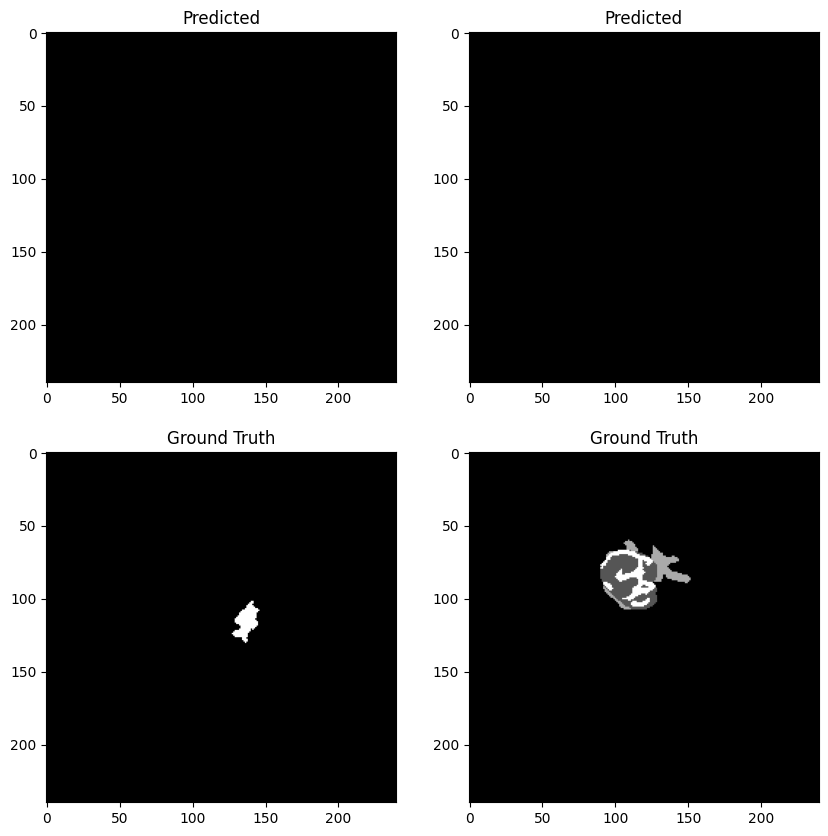

100%|██████████| 136/136 [07:36<00:00,  3.36s/it]



Average Training Loss: 0.31119359963957

Average Training DSC: [0.90852924 0.46622243 0.62742038 0.        ]
Average Training ASSD: [ 23.5286685  193.22748162 124.43439041 362.        ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


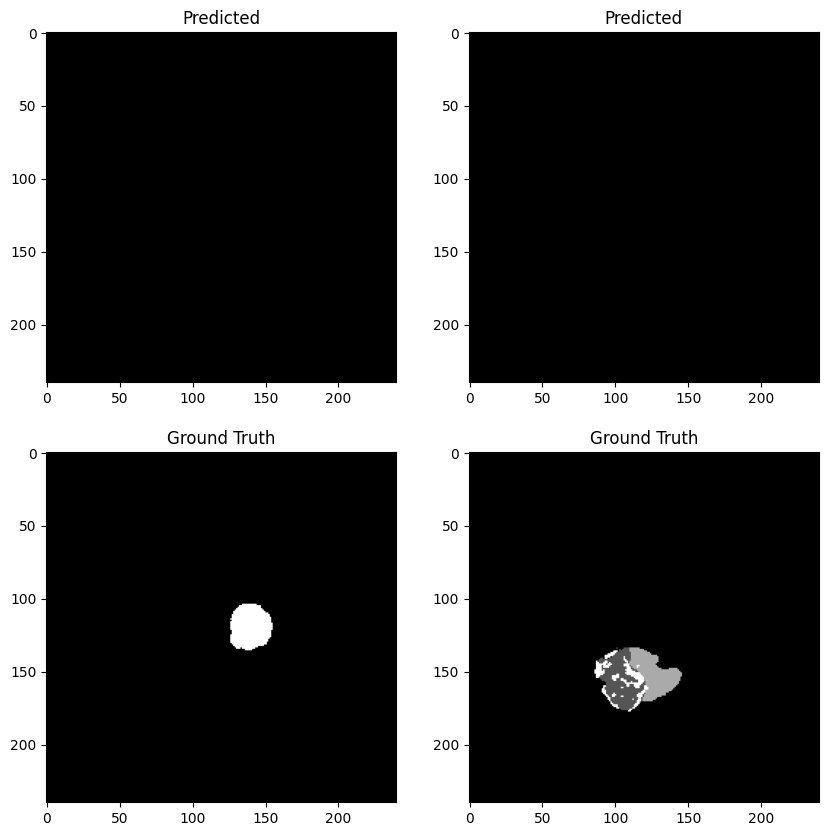

100%|██████████| 34/34 [01:42<00:00,  3.02s/it]


Average Validation Loss: 0.07435573155389112

Average Validation DSC: [0.99011554 0.49787896 0.75311086 0.        ]
Average Validation ASSD: [  5.04713094 181.76781674  89.37386878 362.        ]
Epoch 2/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


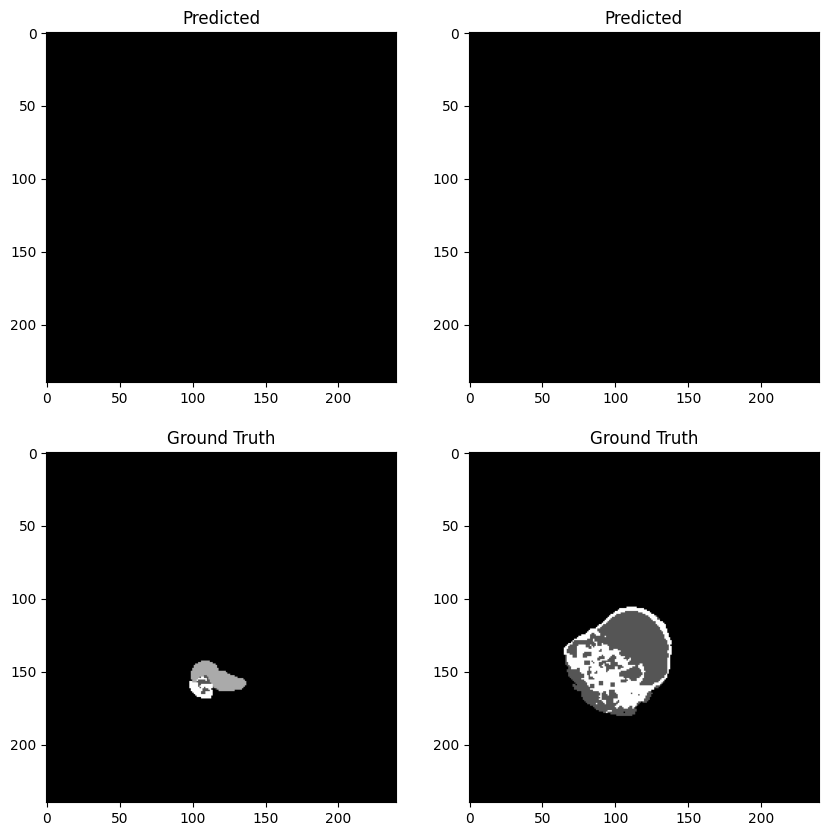

100%|██████████| 136/136 [08:09<00:00,  3.60s/it]



Average Training Loss: 0.0659590693848098

Average Training DSC: [0.99081843 0.46783088 0.75436581 0.0767073 ]
Average Training ASSD: [  3.87722762 192.64522059  88.91957721 270.3257027 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


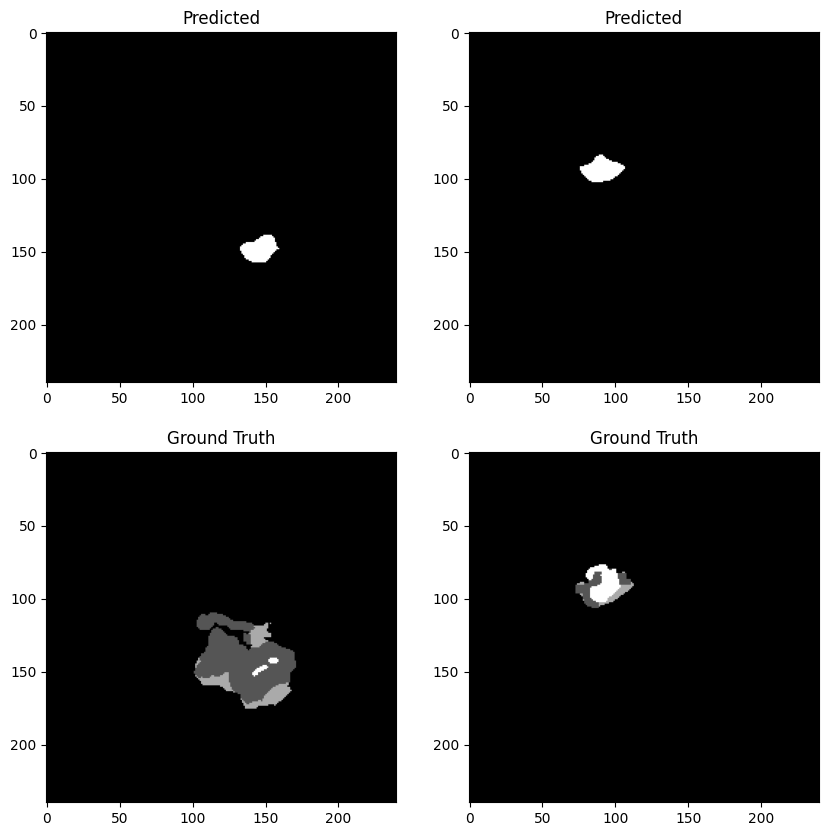

100%|██████████| 34/34 [01:59<00:00,  3.52s/it]


Average Validation Loss: 0.05622039724360494

Average Validation DSC: [0.99346777 0.49766686 0.75289876 0.33226895]
Average Validation ASSD: [  1.29095805 181.84459842  89.45065045  75.4292639 ]
Epoch 3/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


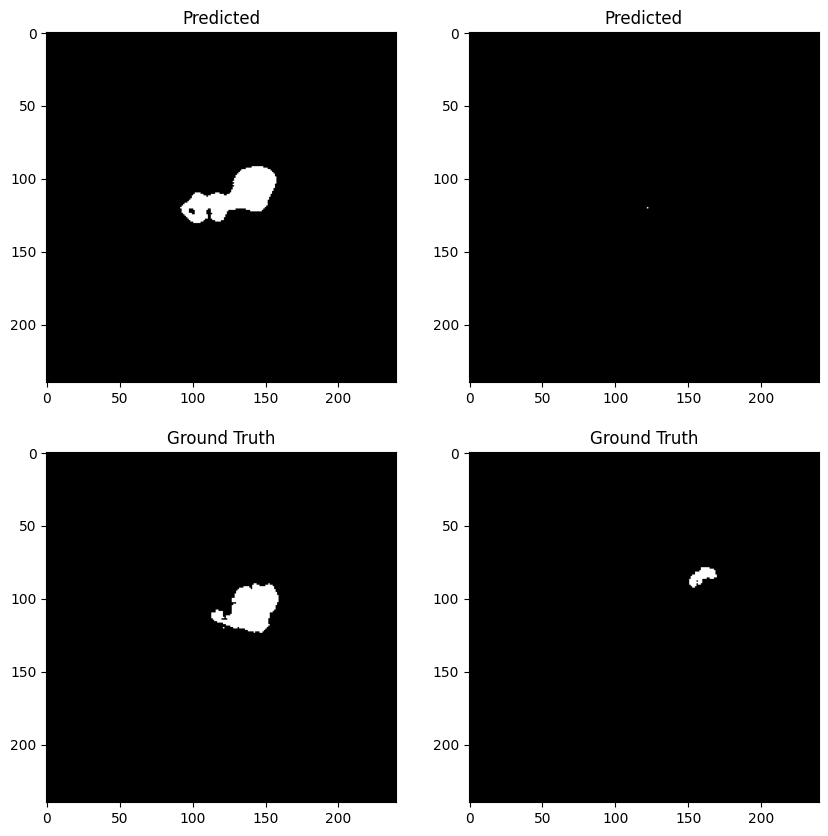

100%|██████████| 136/136 [08:44<00:00,  3.86s/it]



Average Training Loss: 0.04927469010683982

Average Training DSC: [0.99446542 0.44906169 0.75275735 0.3382783 ]
Average Training ASSD: [  1.12122516 175.81110829  89.50183824  70.62436204]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


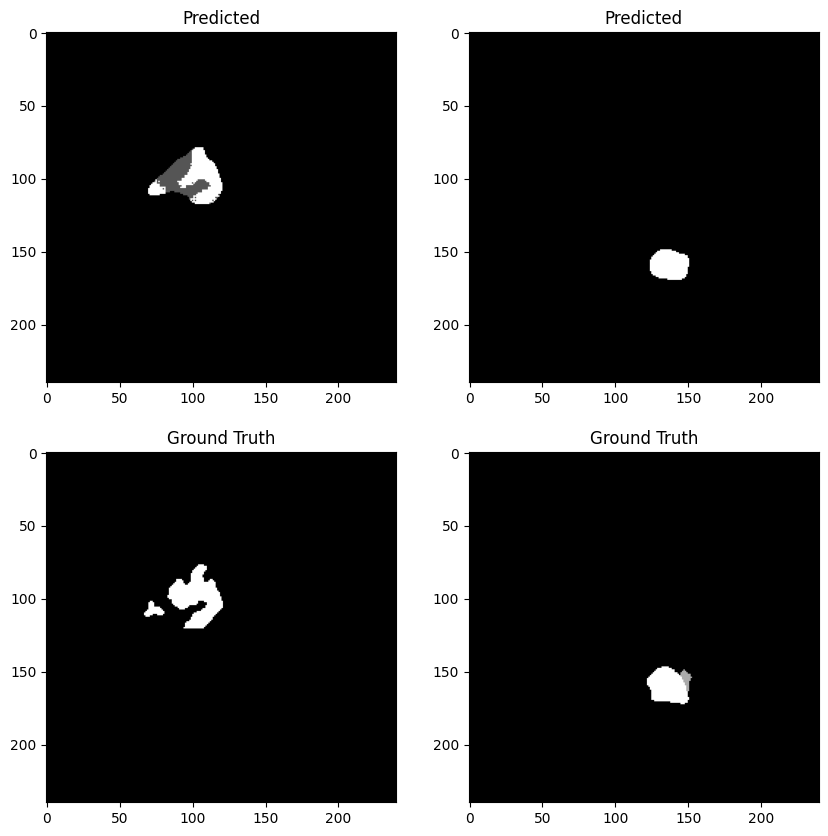

100%|██████████| 34/34 [02:06<00:00,  3.71s/it]


Average Validation Loss: 0.04178838848191149

Average Validation DSC: [0.99546084 0.43501817 0.75289876 0.39612485]
Average Validation ASSD: [  0.75715426 137.96173188  89.45065045  46.45138951]
Epoch 4/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


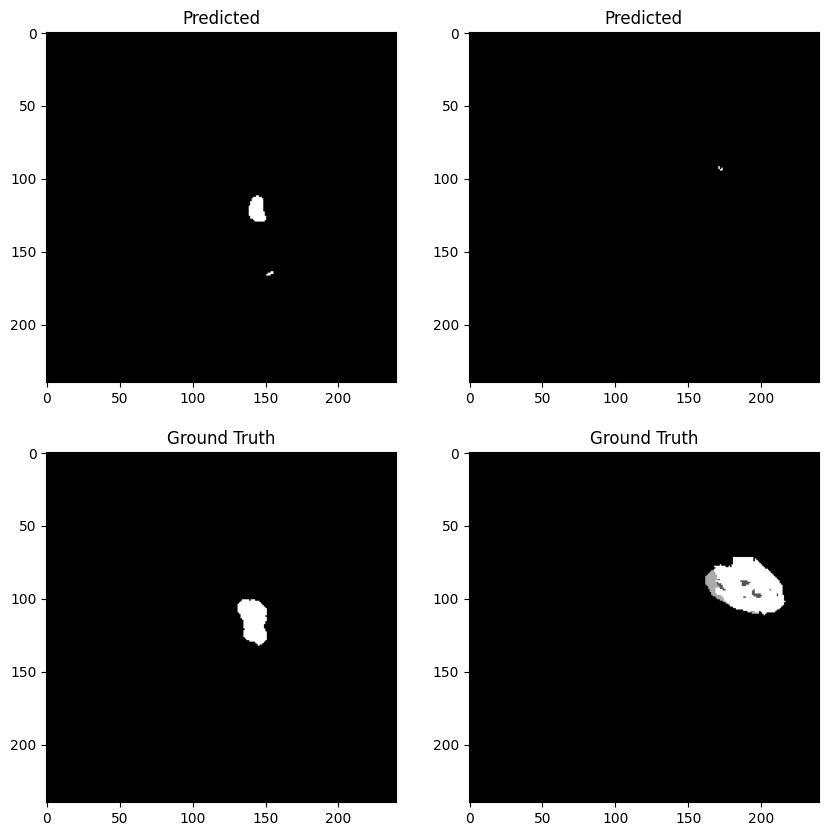

100%|██████████| 136/136 [08:56<00:00,  3.94s/it]



Average Training Loss: 0.040263310170677656

Average Training DSC: [0.99585329 0.49753667 0.75275735 0.35165634]
Average Training ASSD: [  0.82742531 142.12225141  89.50183824  65.99012879]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


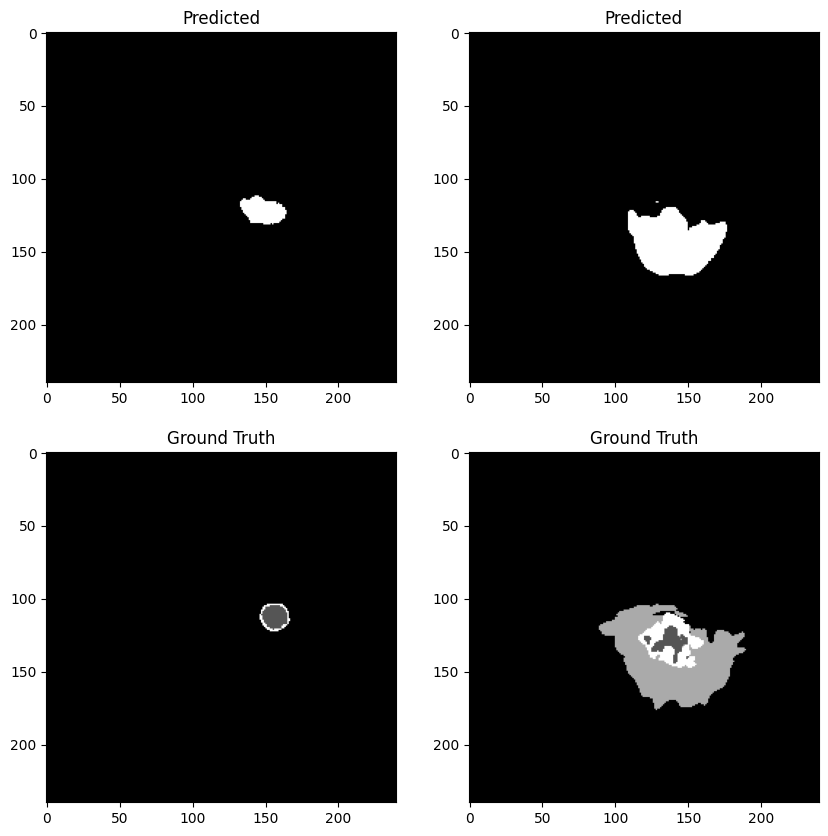

100%|██████████| 34/34 [02:00<00:00,  3.55s/it]


Average Validation Loss: 0.038930340176996064

Average Validation DSC: [0.99585782 0.51123338 0.75332296 0.43612605]
Average Validation ASSD: [  0.65430248 164.1238579   89.2970871   36.16410007]
Epoch 5/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


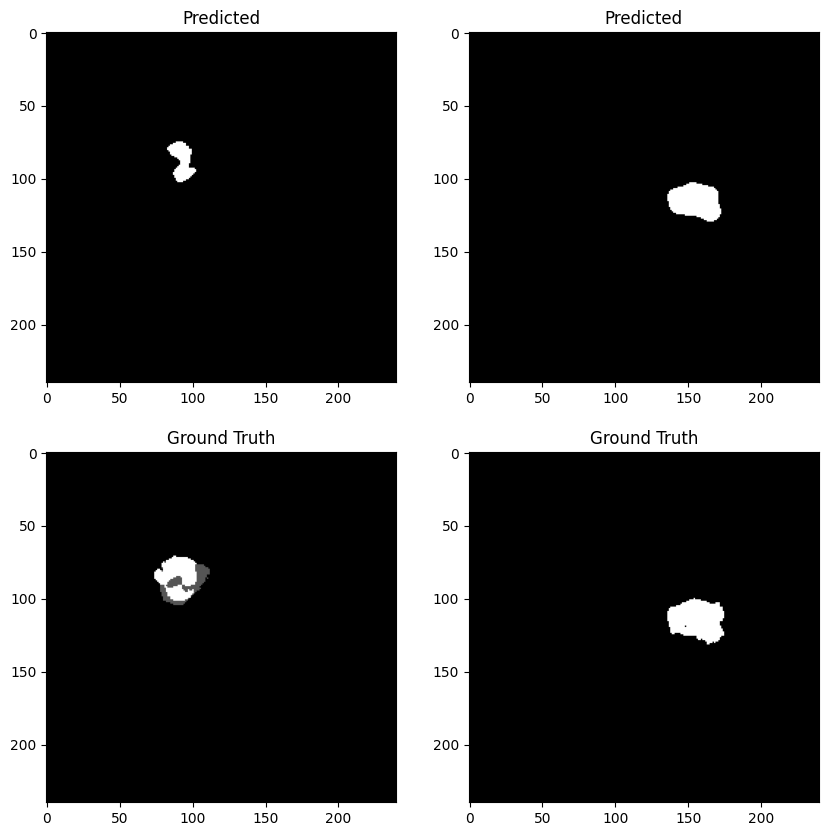

100%|██████████| 136/136 [08:39<00:00,  3.82s/it]



Average Training Loss: 0.03622064232716665

Average Training DSC: [0.99653649 0.51804158 0.75275735 0.38077492]
Average Training ASSD: [  0.67948943 136.88932172  89.50183824  57.69941532]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


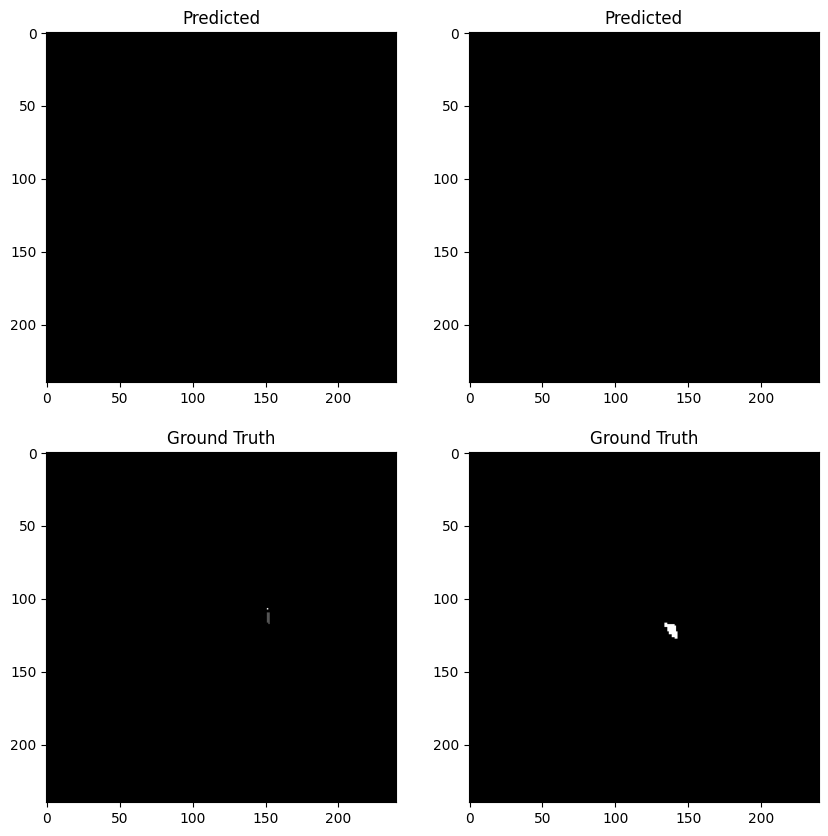

100%|██████████| 34/34 [02:06<00:00,  3.71s/it]


Average Validation Loss: 0.037426908171790486

Average Validation DSC: [0.99637902 0.52332734 0.75311086 0.33686046]
Average Validation ASSD: [  0.83987602 121.92557514  89.37386878  78.95702272]
Epoch 6/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


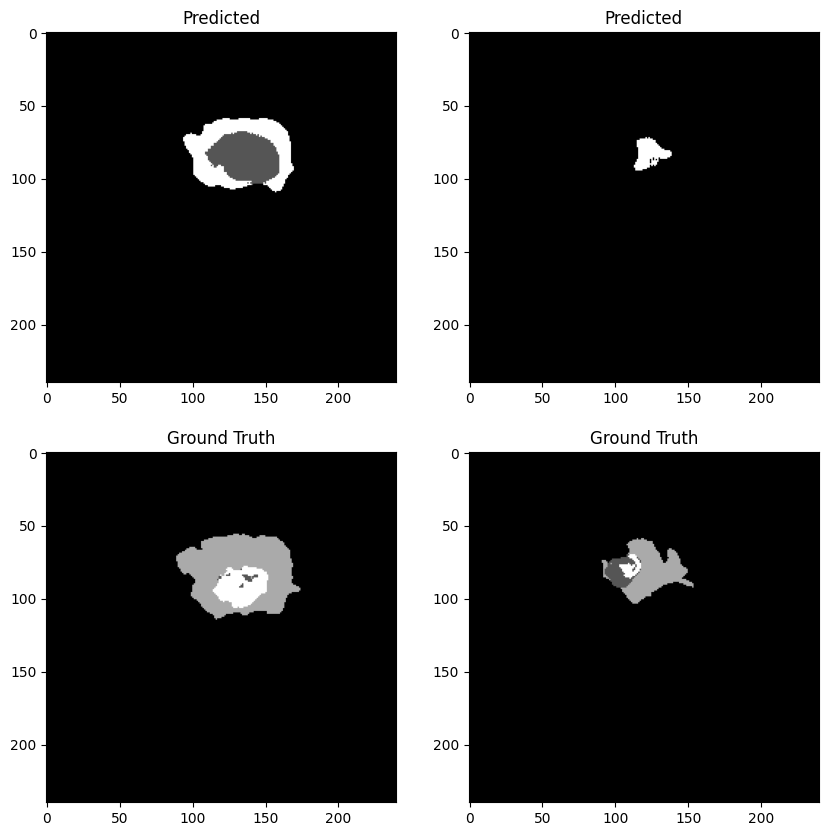

100%|██████████| 136/136 [08:45<00:00,  3.87s/it]



Average Training Loss: 0.03396988362895653

Average Training DSC: [0.99689034 0.5118019  0.75021598 0.40165548]
Average Training ASSD: [  0.61385517 127.86704381  89.29780446  51.39103327]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


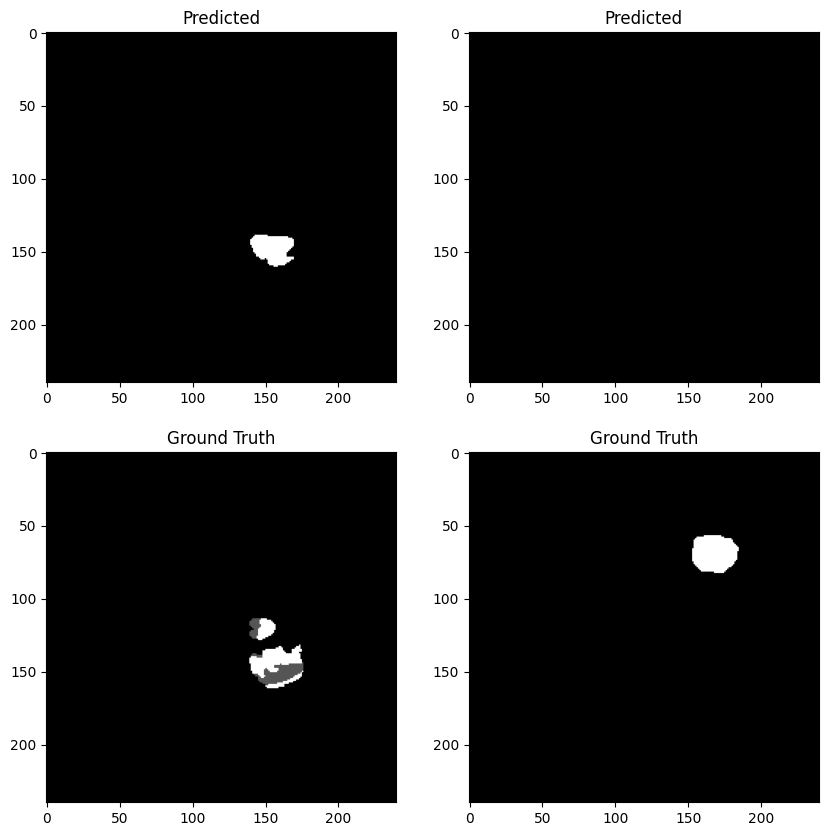

100%|██████████| 34/34 [02:02<00:00,  3.61s/it]


Average Validation Loss: 0.0318749514682328

Average Validation DSC: [0.99721268 0.54637253 0.75353507 0.43854612]
Average Validation ASSD: [  0.49118128 118.9711142   89.22030543  44.05227255]
Epoch 7/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


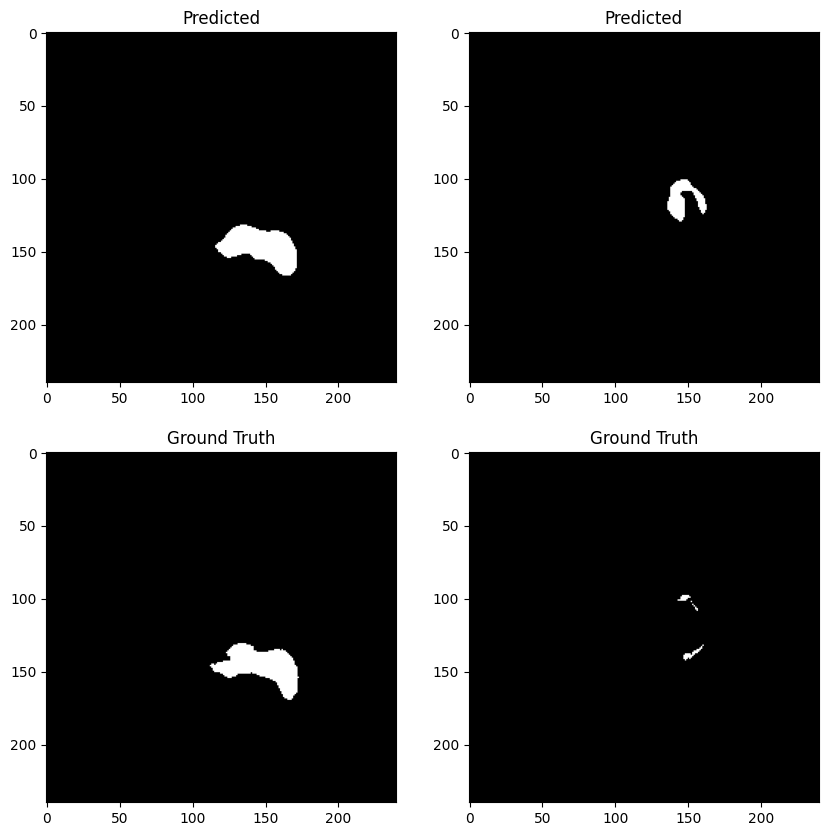

100%|██████████| 136/136 [08:53<00:00,  3.92s/it]



Average Training Loss: 0.03113722724511343

Average Training DSC: [0.99732112 0.4827337  0.71975243 0.42327648]
Average Training ASSD: [  0.50410421 120.71755855  94.31881611  42.30687341]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


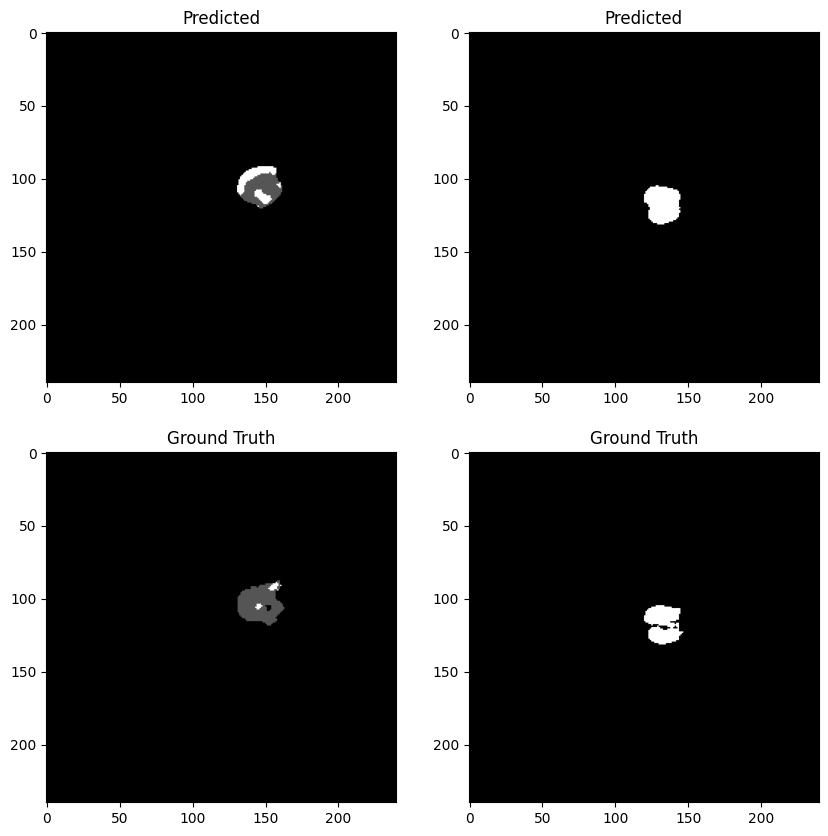

100%|██████████| 34/34 [02:02<00:00,  3.60s/it]


Average Validation Loss: 0.02975204658201512

Average Validation DSC: [0.99754773 0.51009616 0.61565291 0.43805025]
Average Validation ASSD: [  0.44115334 107.43822989 119.76471657  40.60068756]
Epoch 8/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


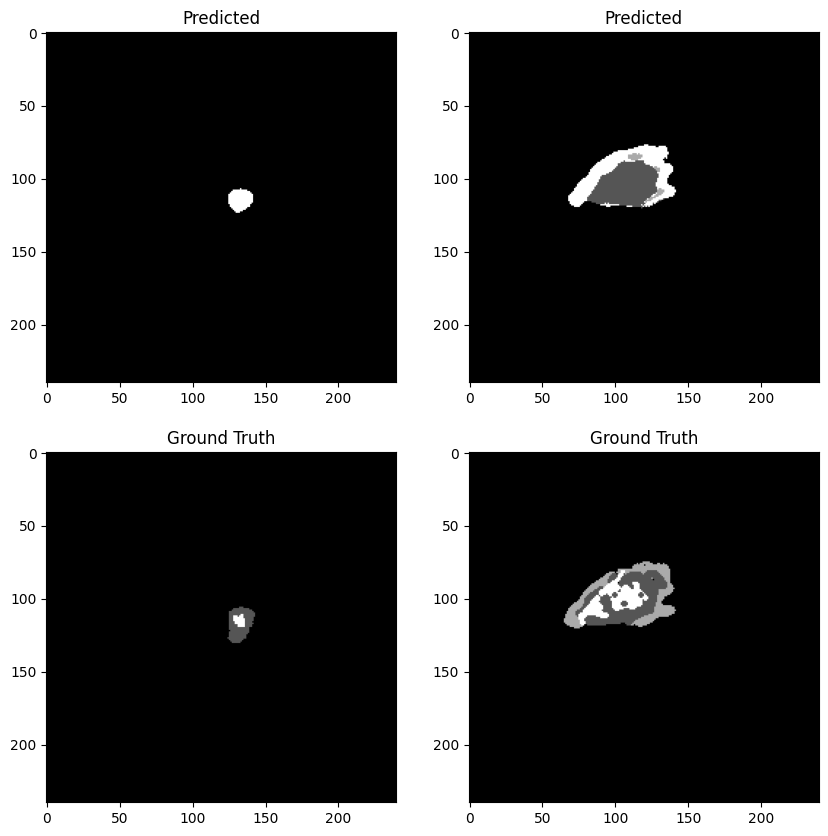

100%|██████████| 136/136 [08:53<00:00,  3.92s/it]



Average Training Loss: 0.02902546268887818

Average Training DSC: [0.99762409 0.45334749 0.66001538 0.42680324]
Average Training ASSD: [  0.43201343 114.13176045 108.16052192  42.17088962]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


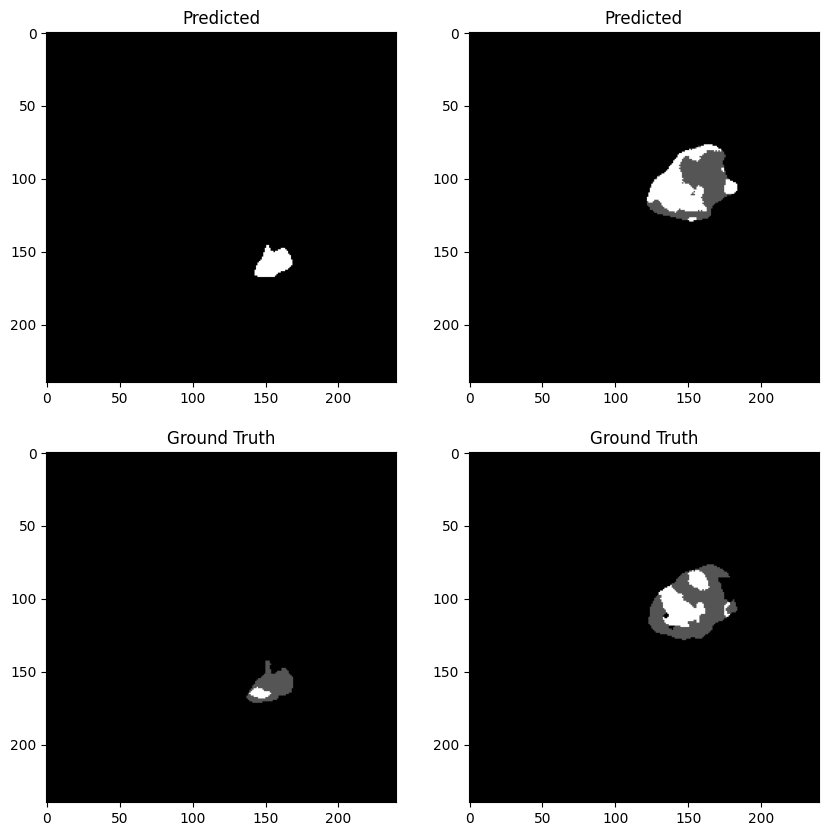

100%|██████████| 34/34 [02:05<00:00,  3.70s/it]


Average Validation Loss: 0.02854340583743418

Average Validation DSC: [0.99769166 0.48431655 0.66125024 0.48117238]
Average Validation ASSD: [  0.39190666 107.34015107 103.10895963  38.01143611]
Epoch 9/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


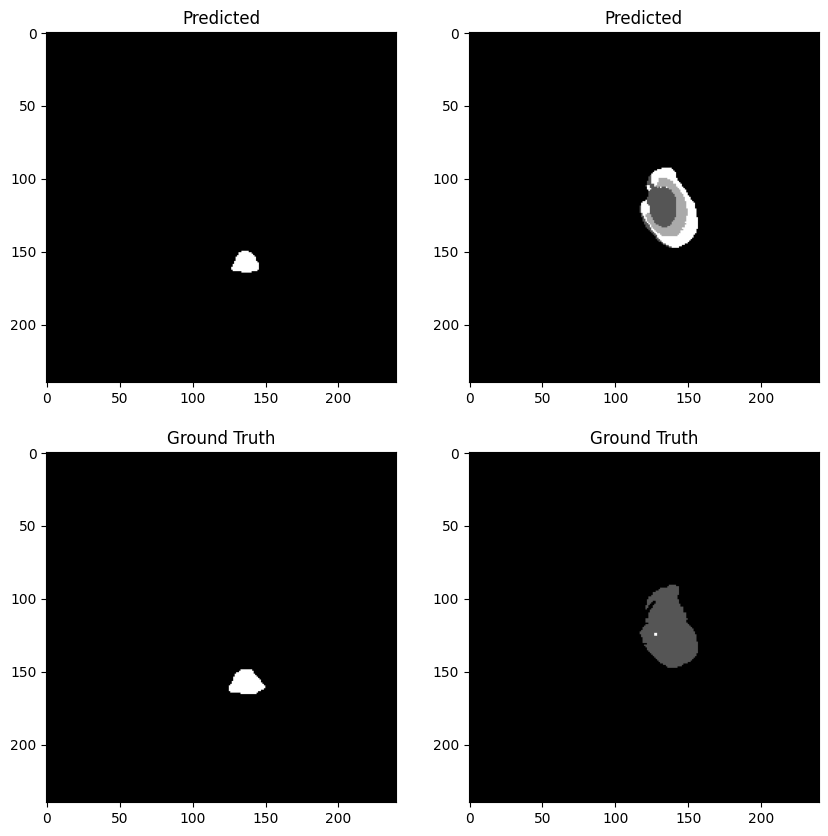

100%|██████████| 136/136 [09:11<00:00,  4.06s/it]



Average Training Loss: 0.02773727195830468

Average Training DSC: [0.99776958 0.49116503 0.62527303 0.42725411]
Average Training ASSD: [  0.39876585 104.86164455 110.74814657  42.98026486]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


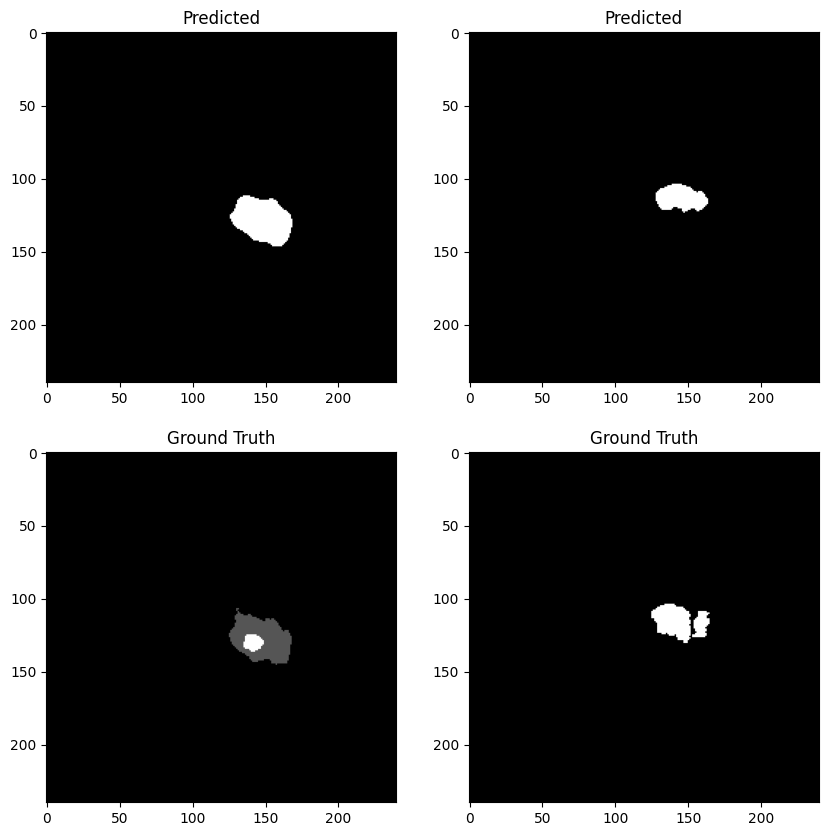

100%|██████████| 34/34 [02:07<00:00,  3.76s/it]


Average Validation Loss: 0.026946191895095742

Average Validation DSC: [0.99780283 0.47985687 0.54990743 0.490547  ]
Average Validation ASSD: [  0.34026164  96.86529845 127.93299428  36.48388872]
Epoch 10/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


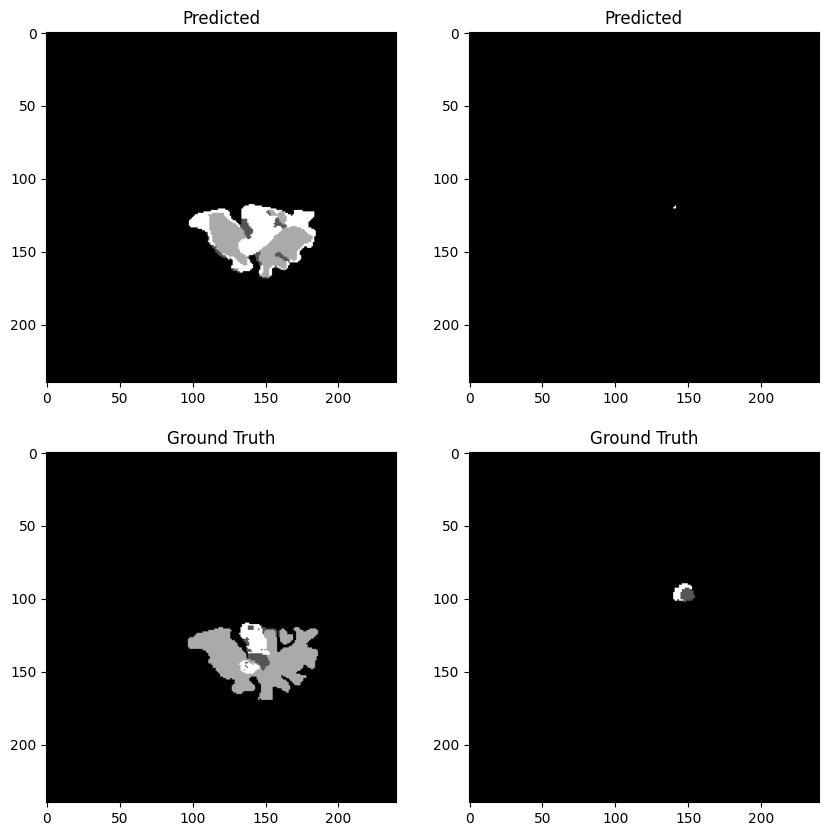

100%|██████████| 136/136 [08:59<00:00,  3.96s/it]



Average Training Loss: 0.026313886114889207

Average Training DSC: [0.99782816 0.48833982 0.57798266 0.43560955]
Average Training ASSD: [  0.36897302 107.32940901 117.76939138  41.30937641]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


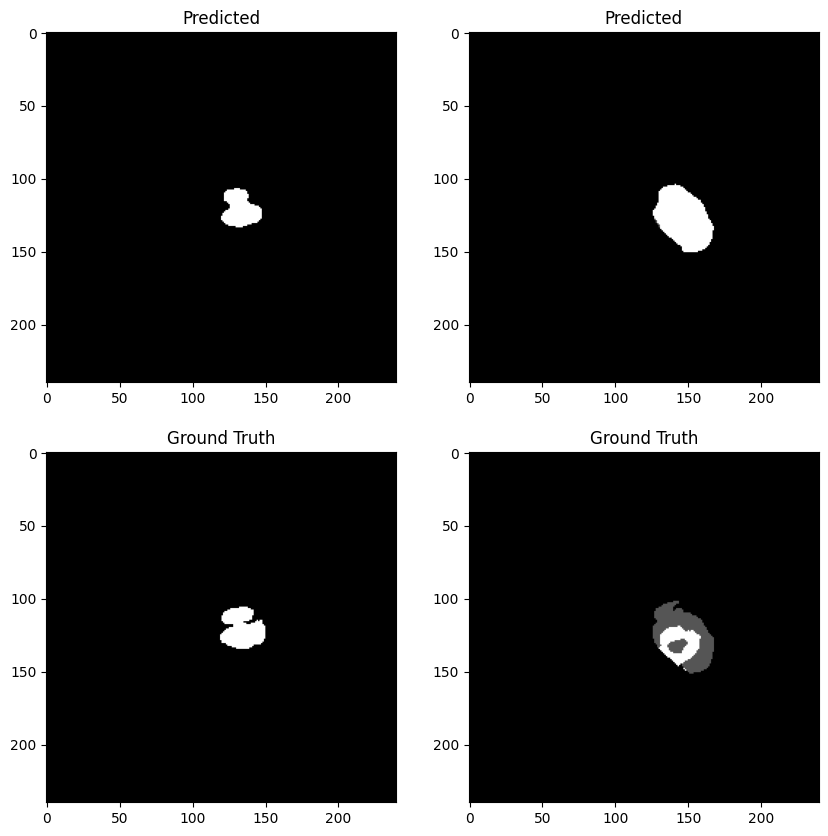

100%|██████████| 34/34 [02:11<00:00,  3.88s/it]


Average Validation Loss: 0.02423087984104367

Average Validation DSC: [0.99789447 0.49850619 0.59747497 0.47003746]
Average Validation ASSD: [  0.33965209 104.95675912 108.58641625  43.87376533]
Epoch 11/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


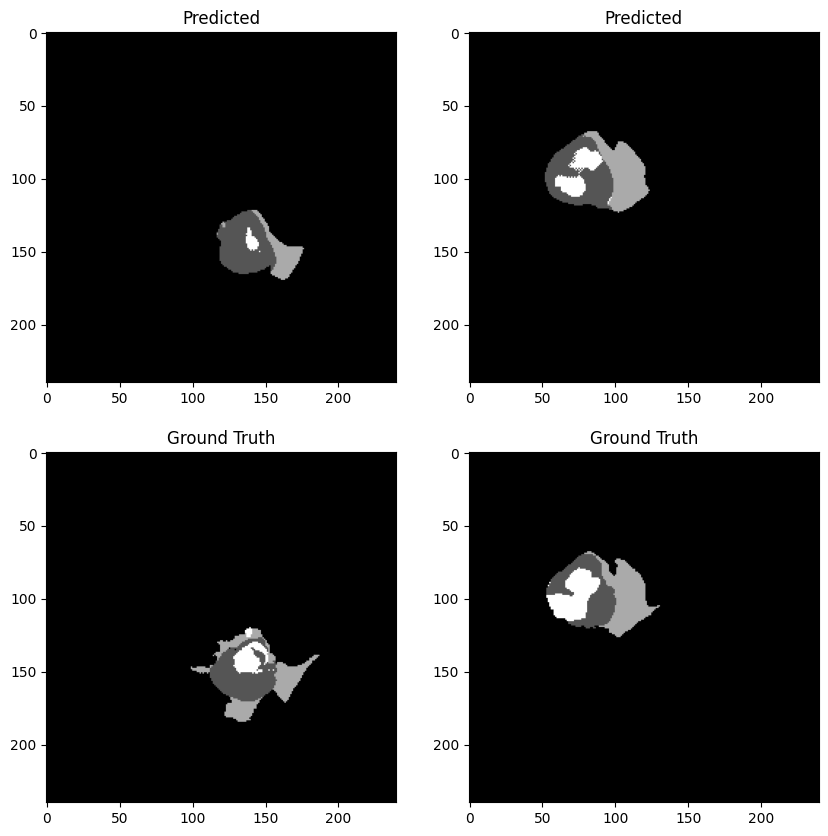

100%|██████████| 136/136 [09:09<00:00,  4.04s/it]



Average Training Loss: 0.02346262038575814

Average Training DSC: [0.9980374  0.50217227 0.66000218 0.44950114]
Average Training ASSD: [  0.33464198 103.32583182  91.20660538  44.26199163]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


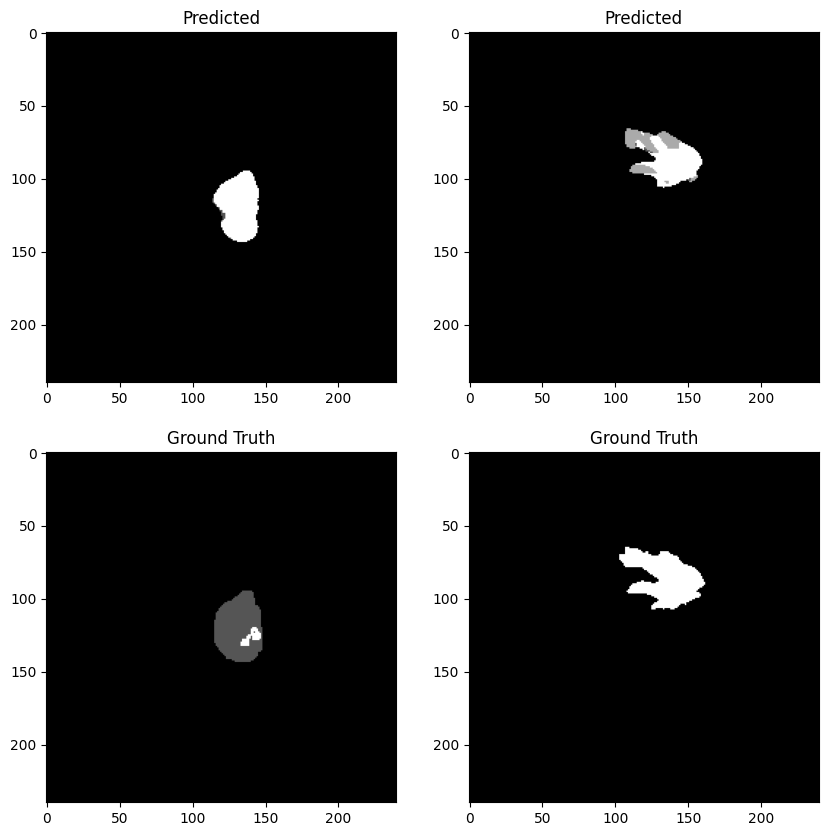

100%|██████████| 34/34 [02:02<00:00,  3.59s/it]


Average Validation Loss: 0.02347284265081672

Average Validation DSC: [0.99788893 0.52513149 0.53474188 0.49352873]
Average Validation ASSD: [  0.37172345  91.38597739 133.76126053  45.55704846]
Epoch 12/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


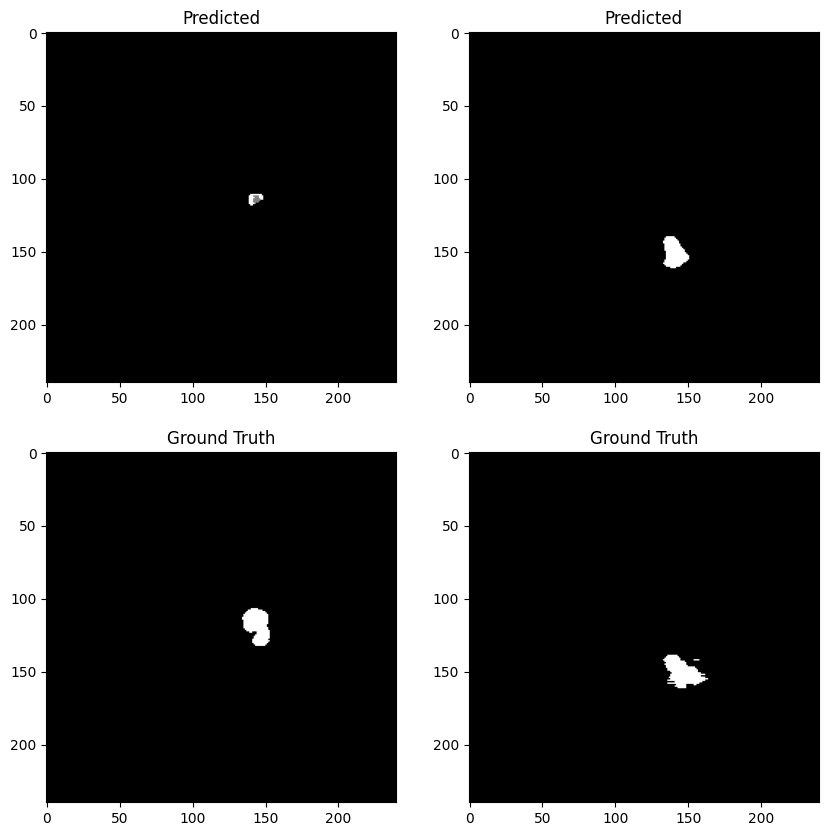

100%|██████████| 136/136 [09:04<00:00,  4.00s/it]



Average Training Loss: 0.0213984935065074

Average Training DSC: [0.99818509 0.53729329 0.73270639 0.48424618]
Average Training ASSD: [ 0.3053351  97.52119188 68.73649732 38.22893417]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


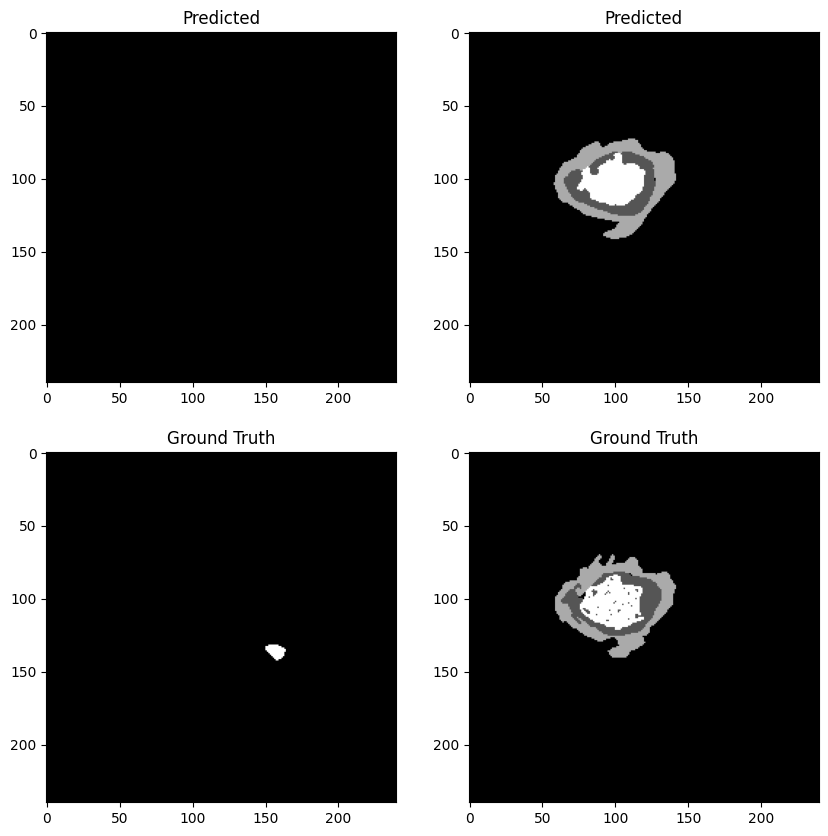

100%|██████████| 34/34 [02:07<00:00,  3.76s/it]


Average Validation Loss: 0.019946284318233237

Average Validation DSC: [0.99814502 0.57950786 0.67942933 0.49688219]
Average Validation ASSD: [ 0.30417577 92.67021601 89.4693943  44.25790156]
Epoch 13/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


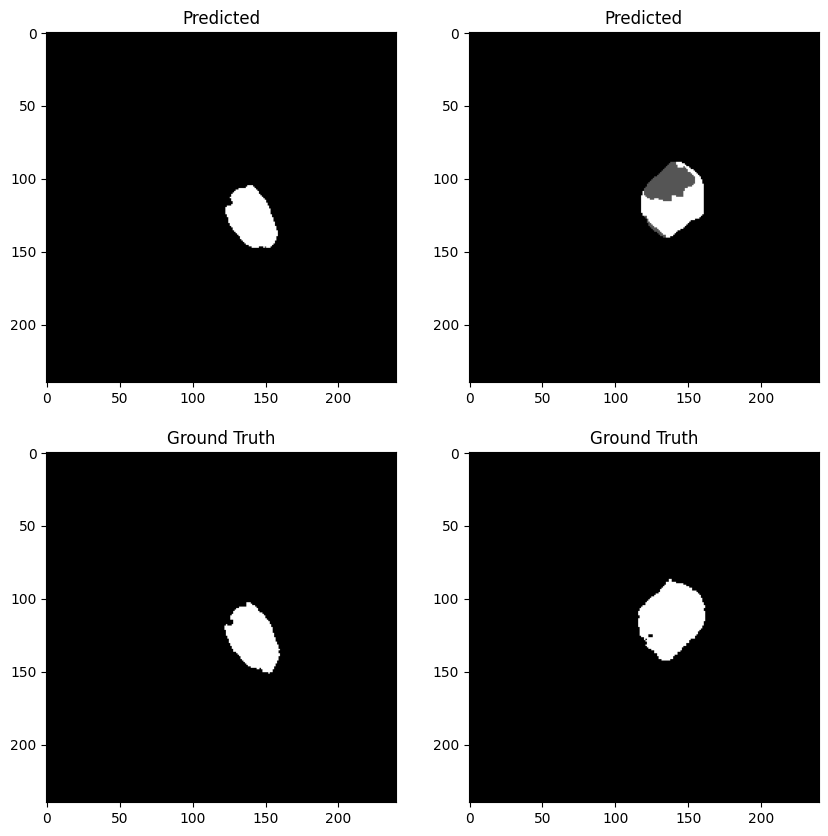

100%|██████████| 136/136 [09:11<00:00,  4.06s/it]



Average Training Loss: 0.01966242230606868

Average Training DSC: [0.99825656 0.58666455 0.77500779 0.50060701]
Average Training ASSD: [ 0.29017707 86.77592247 55.31528366 39.28368161]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


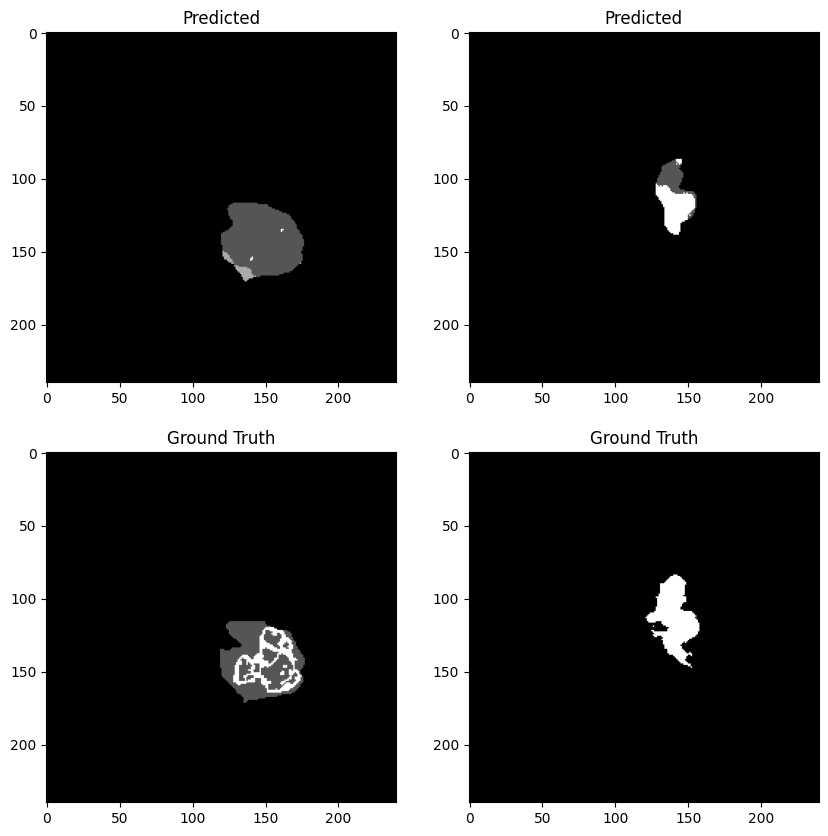

100%|██████████| 34/34 [02:14<00:00,  3.94s/it]


Average Validation Loss: 0.019209133406334063

Average Validation DSC: [0.99817418 0.556426   0.78942194 0.42870843]
Average Validation ASSD: [  0.28633632 103.67812314  52.71056412  57.349356  ]
Epoch 14/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


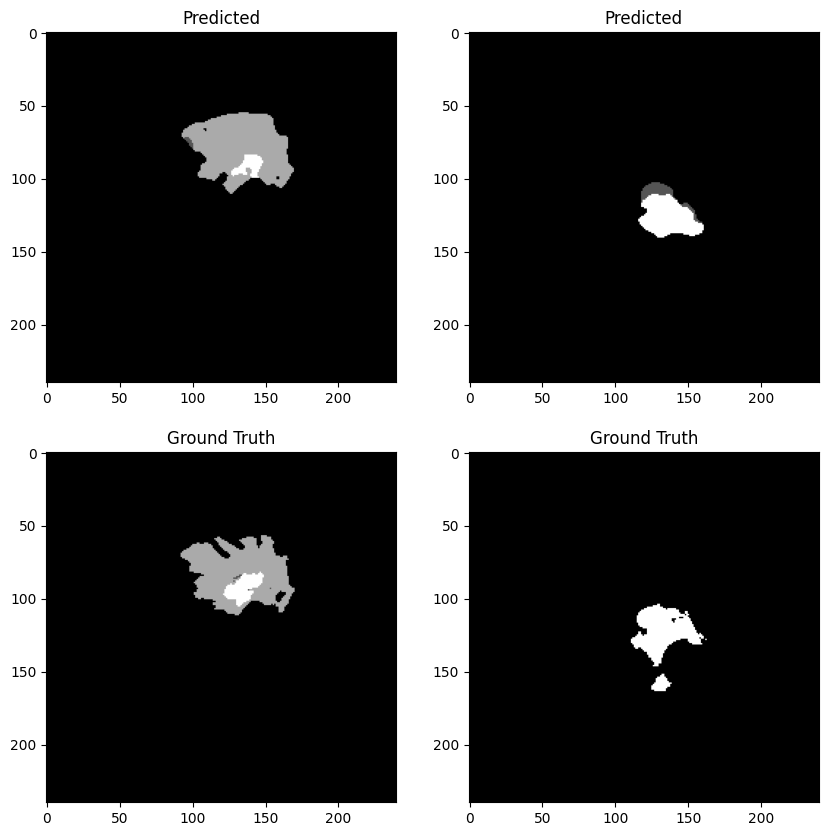

100%|██████████| 136/136 [09:12<00:00,  4.06s/it]



Average Training Loss: 0.017540392616544578

Average Training DSC: [0.99838928 0.63440561 0.81395483 0.53286516]
Average Training ASSD: [ 0.2644913  76.15571494 44.40865351 34.88015977]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


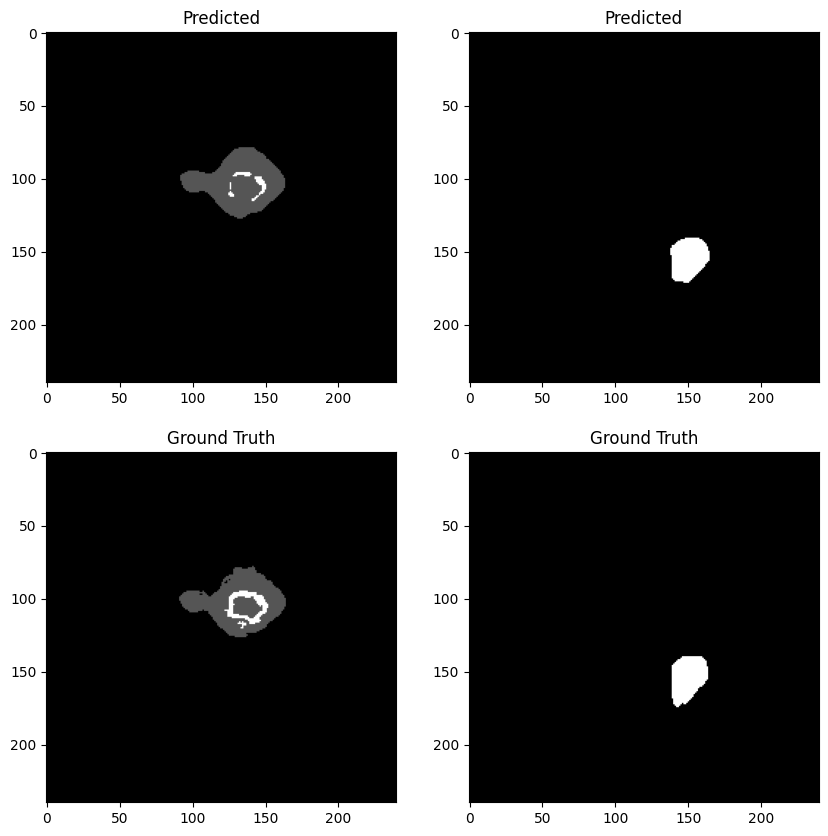

100%|██████████| 34/34 [02:08<00:00,  3.78s/it]


Average Validation Loss: 0.01709455487263553

Average Validation DSC: [0.99836764 0.63174903 0.84332484 0.53649997]
Average Validation ASSD: [ 0.25683442 86.75609521 34.94873777 38.20979578]
Epoch 15/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


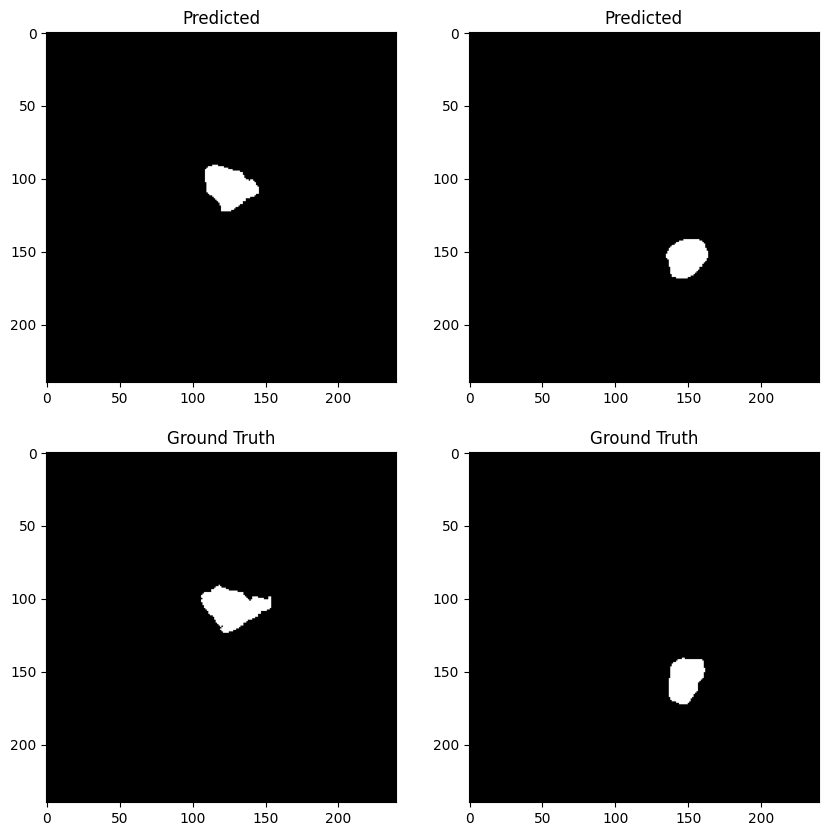

100%|██████████| 136/136 [09:17<00:00,  4.10s/it]



Average Training Loss: 0.01676111710120869

Average Training DSC: [0.99839845 0.66140343 0.83494745 0.54640104]
Average Training ASSD: [ 0.25815256 68.91204981 38.0446544  37.17984321]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


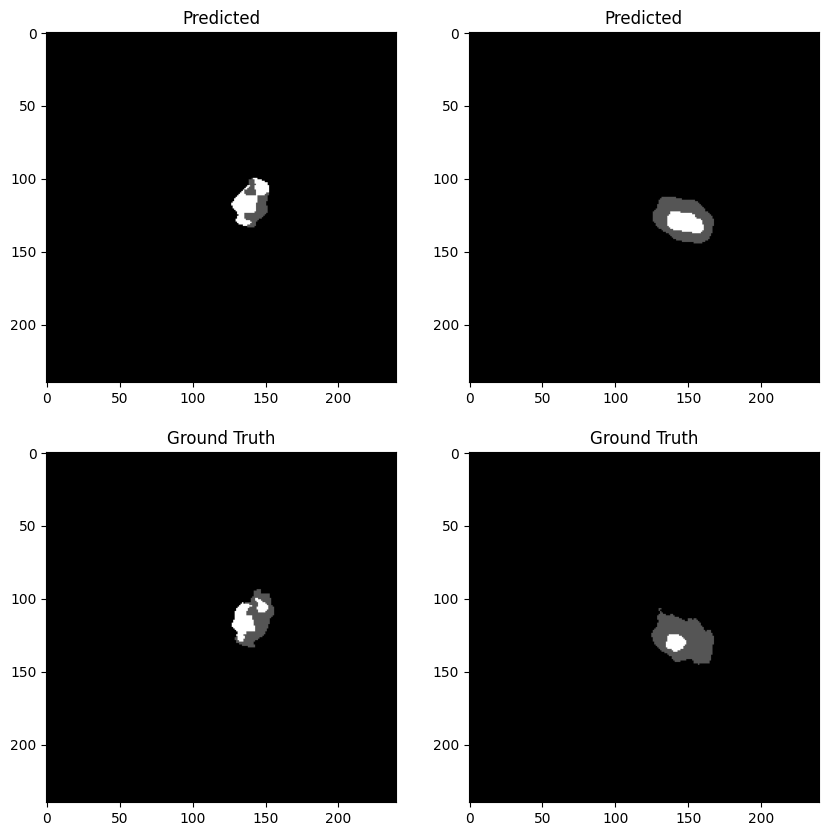

100%|██████████| 34/34 [02:08<00:00,  3.78s/it]


Average Validation Loss: 0.017807394512655103

Average Validation DSC: [0.9981247  0.68325392 0.85059678 0.57241653]
Average Validation ASSD: [ 0.32664364 62.56615746 31.34656531 36.76884097]
Epoch 16/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


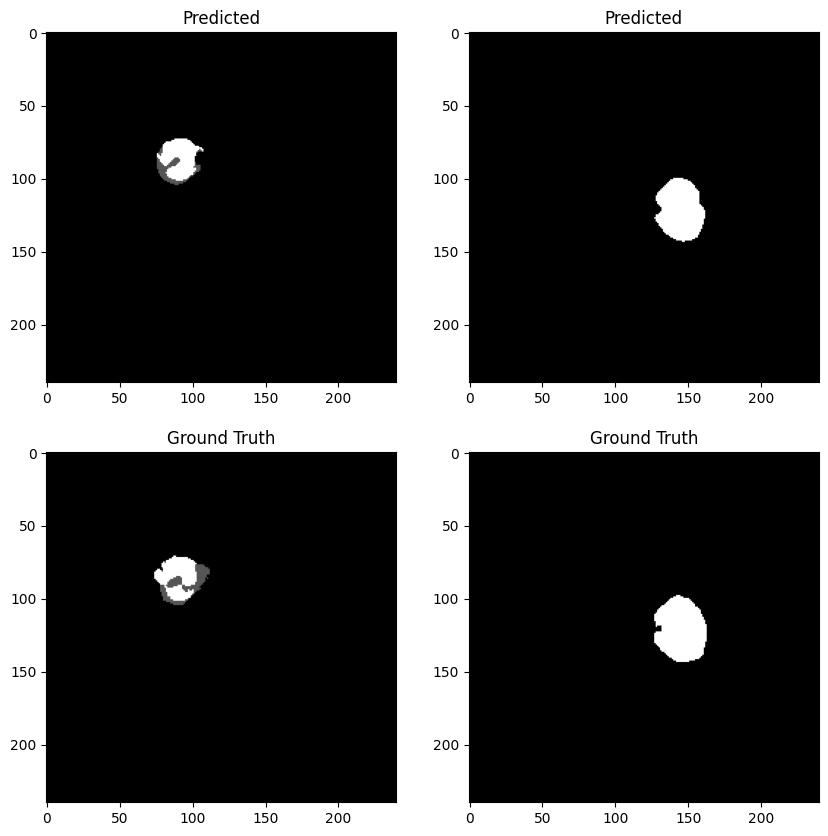

100%|██████████| 136/136 [09:11<00:00,  4.06s/it]



Average Training Loss: 0.015434225089848042

Average Training DSC: [0.9984427  0.71390102 0.83885281 0.57535663]
Average Training ASSD: [ 0.24268482 54.90026139 36.30390324 33.67256642]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


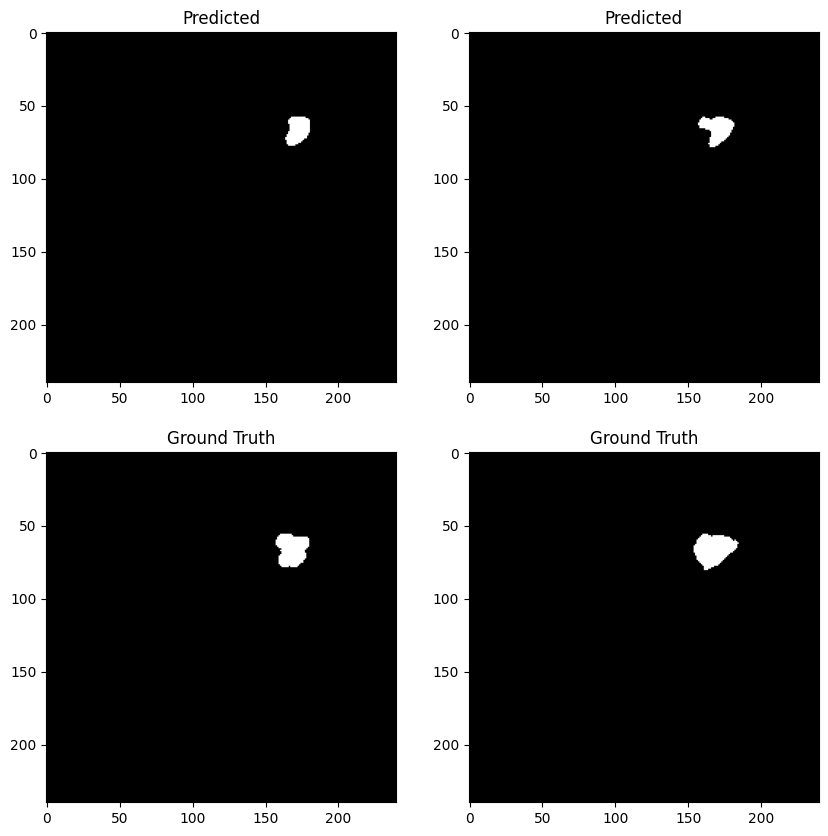

100%|██████████| 34/34 [02:06<00:00,  3.73s/it]


Average Validation Loss: 0.015541697742746156

Average Validation DSC: [0.99835899 0.72598122 0.85927349 0.60570084]
Average Validation ASSD: [ 0.25476967 51.71653672 29.39641738 32.04905362]
Epoch 17/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


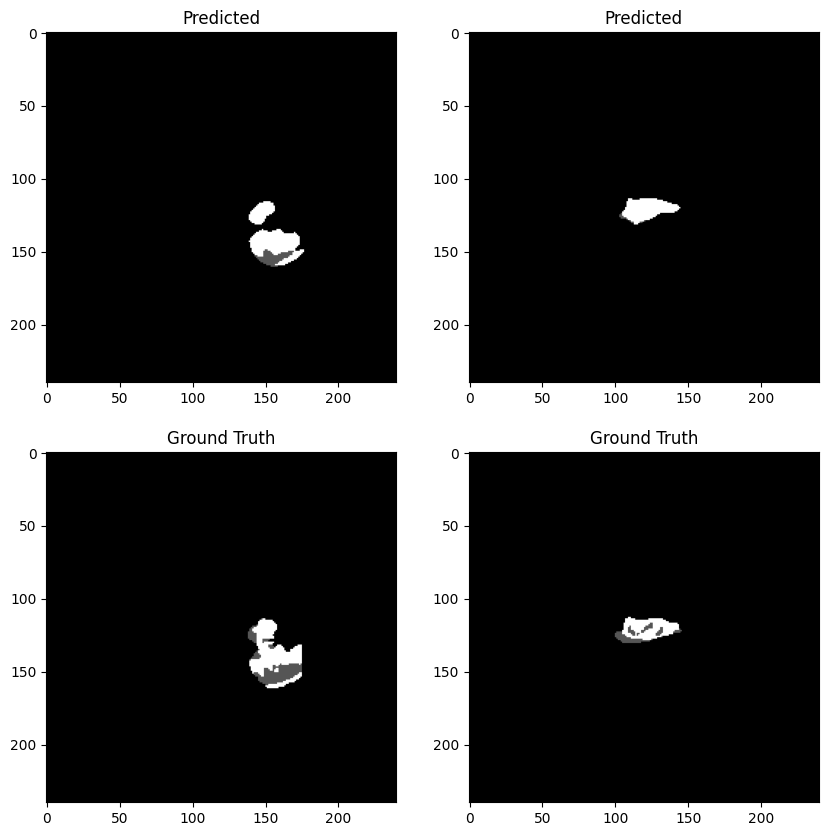

100%|██████████| 136/136 [09:22<00:00,  4.13s/it]



Average Training Loss: 0.014554415665128651

Average Training DSC: [0.99852491 0.73515597 0.85461952 0.59205577]
Average Training ASSD: [ 0.22413811 48.28786561 30.38898118 32.17344329]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


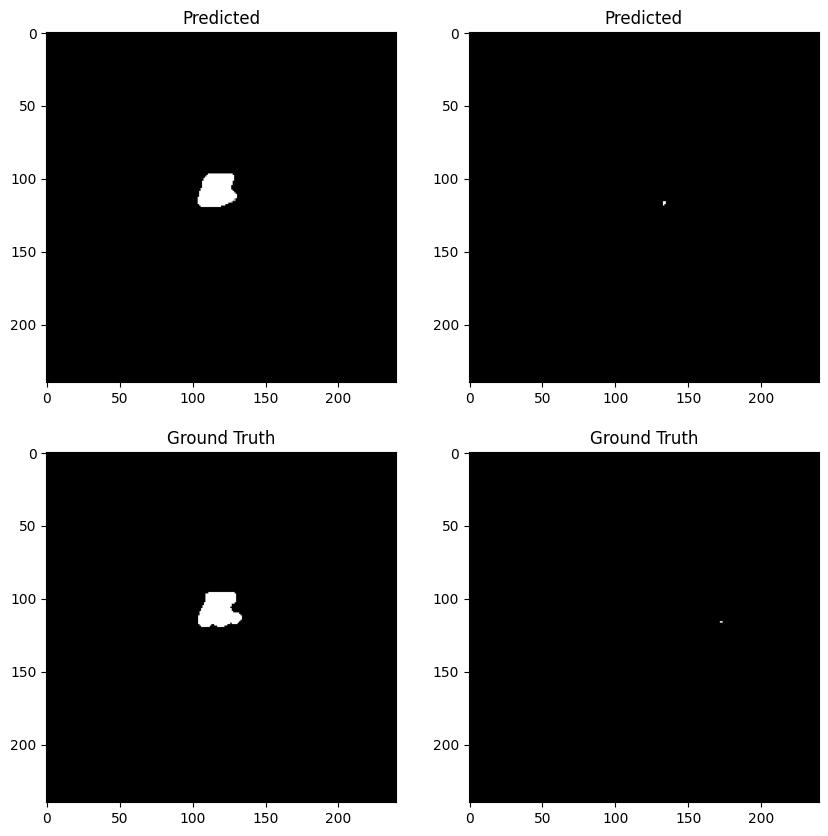

100%|██████████| 34/34 [02:13<00:00,  3.92s/it]


Average Validation Loss: 0.0139848540591843

Average Validation DSC: [0.9985316  0.75611111 0.8509642  0.63005505]
Average Validation ASSD: [ 0.22885252 42.03706784 32.01173569 27.75239099]
Epoch 18/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


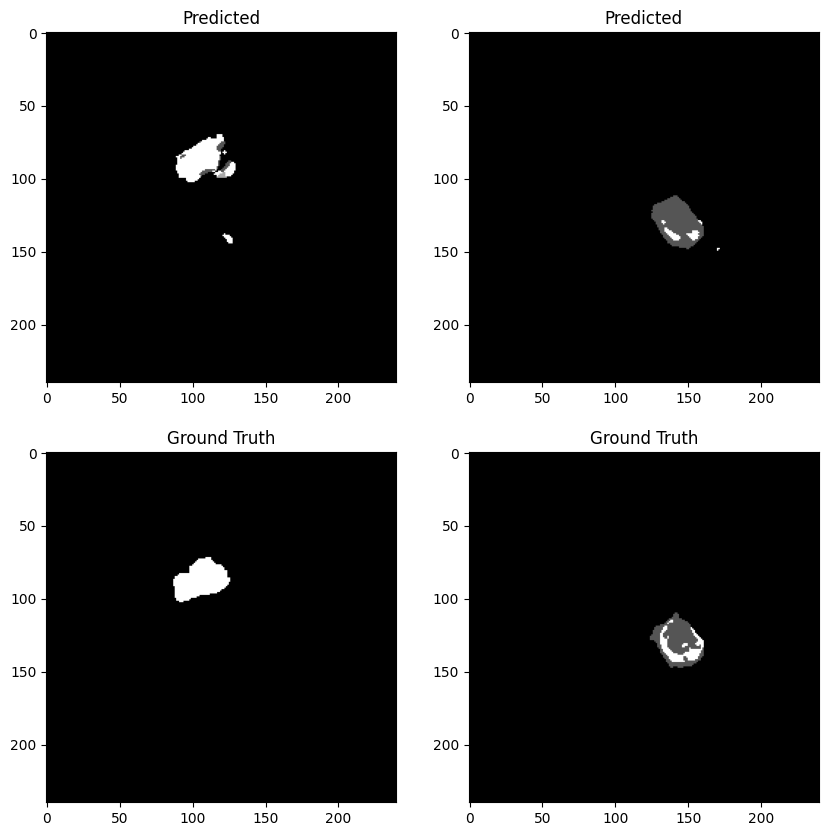

100%|██████████| 136/136 [09:02<00:00,  3.99s/it]



Average Training Loss: 0.013319510446094415

Average Training DSC: [0.99859924 0.76052235 0.87410135 0.61338935]
Average Training ASSD: [ 0.20783993 41.30555665 24.38107497 32.27885806]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


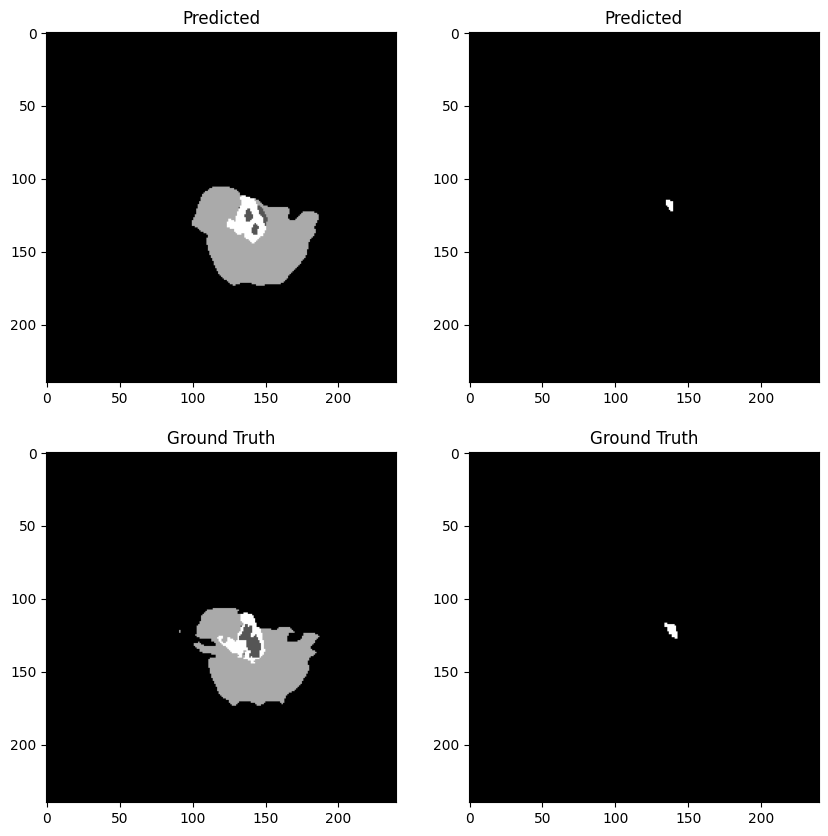

100%|██████████| 34/34 [02:10<00:00,  3.83s/it]


Average Validation Loss: 0.014637219445670353

Average Validation DSC: [0.9983824  0.77697637 0.82987767 0.64670726]
Average Validation ASSD: [ 0.22319198 38.02710839 40.75295446 15.28034374]
Epoch 19/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


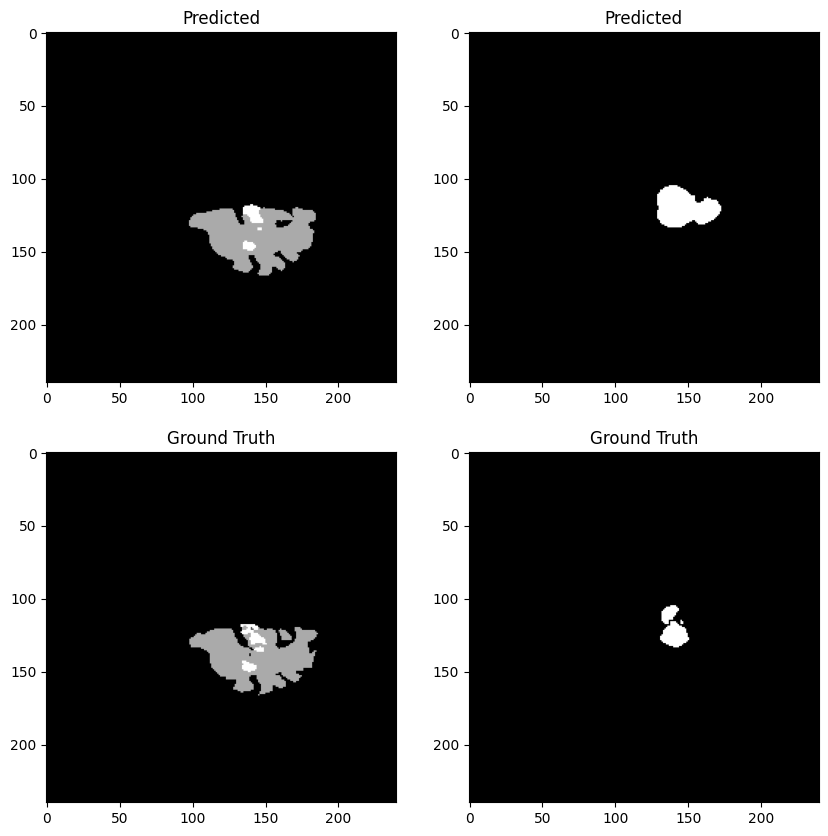

100%|██████████| 136/136 [09:02<00:00,  3.99s/it]



Average Training Loss: 0.013039580457296003

Average Training DSC: [0.99862123 0.78238053 0.86820293 0.62082997]
Average Training ASSD: [ 0.20678345 36.16743451 27.03974574 31.71644563]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


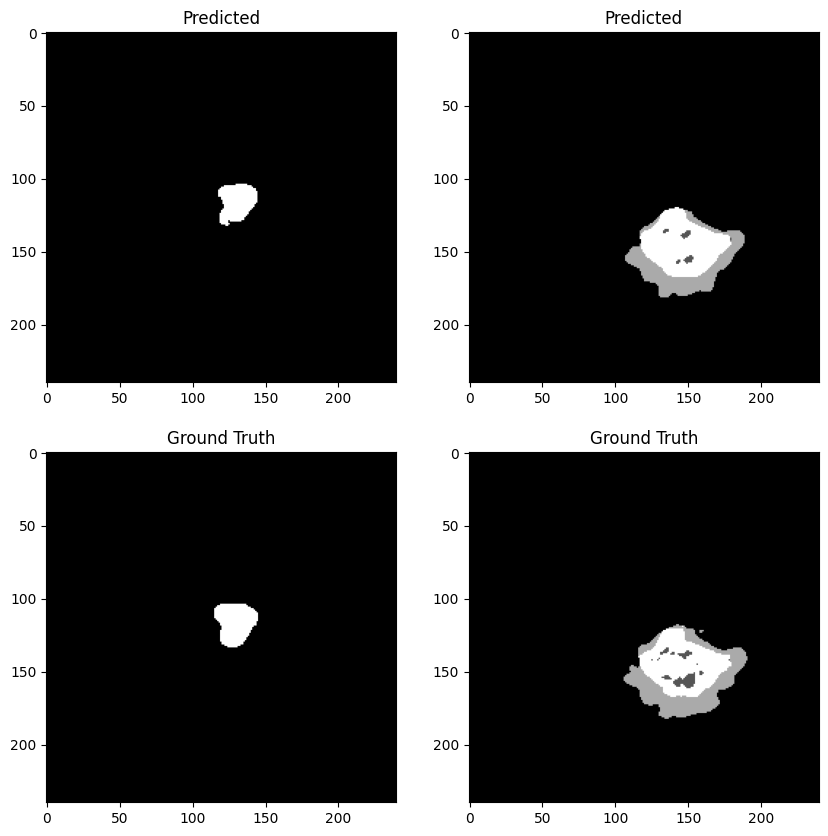

100%|██████████| 34/34 [02:04<00:00,  3.68s/it]


Average Validation Loss: 0.012983744005289148

Average Validation DSC: [0.99861982 0.79930492 0.87451502 0.65558018]
Average Validation ASSD: [ 0.19621436 30.80855491 24.58020947 23.7427363 ]
Epoch 20/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


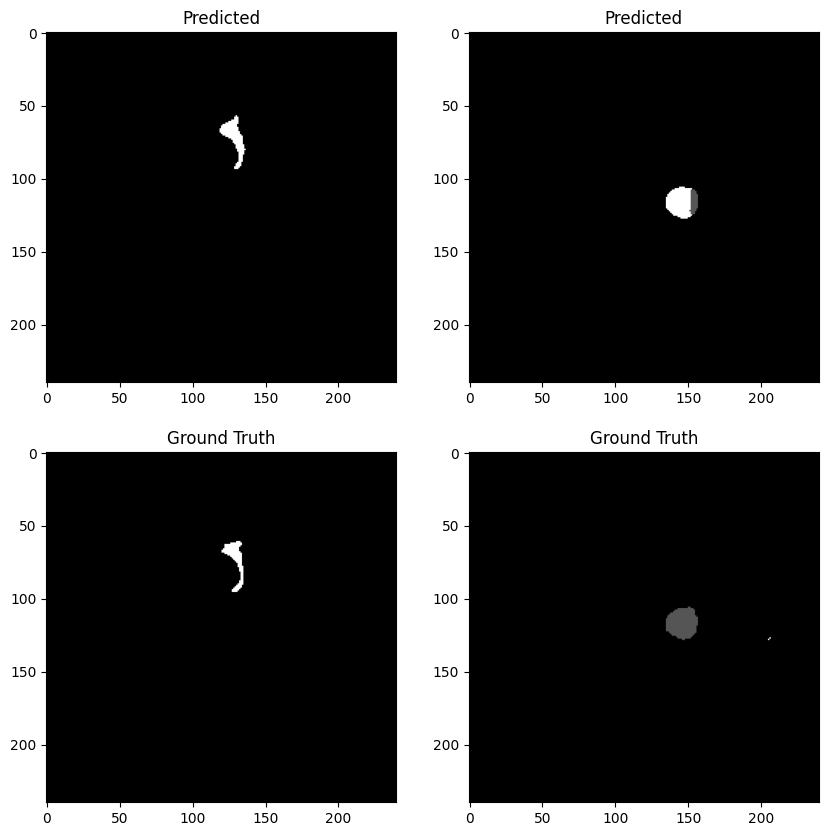

100%|██████████| 136/136 [09:04<00:00,  4.01s/it]



Average Training Loss: 0.011905784239335096

Average Training DSC: [0.99870316 0.79812761 0.88689824 0.6410254 ]
Average Training ASSD: [ 0.18516496 32.94347208 20.26634864 30.45946939]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


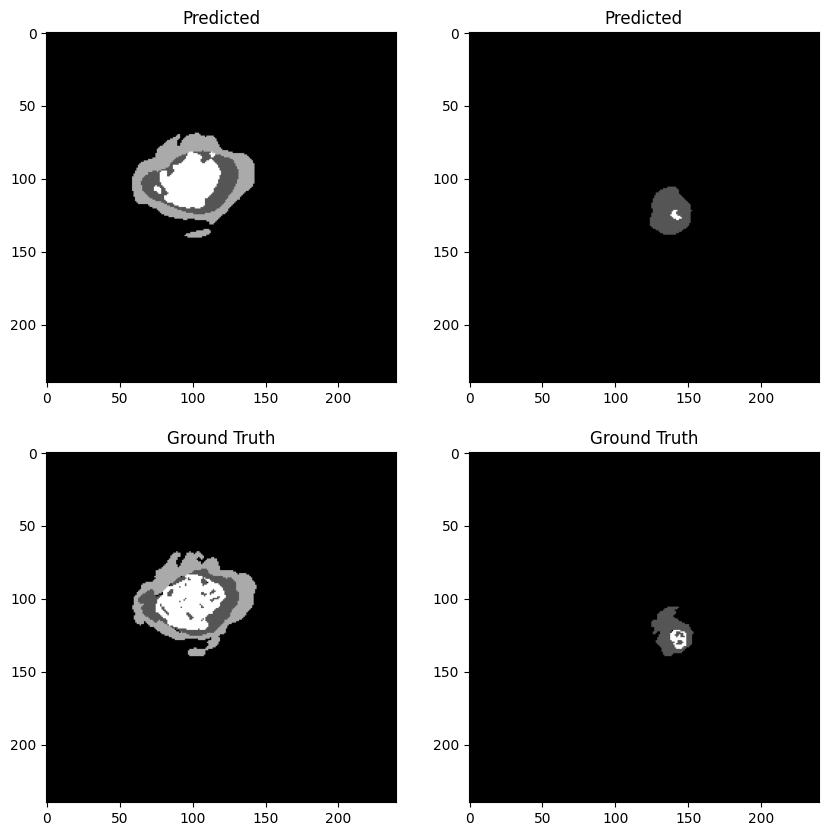

100%|██████████| 34/34 [02:04<00:00,  3.66s/it]


Average Validation Loss: 0.01195259248454343

Average Validation DSC: [0.99867016 0.78974717 0.8868413  0.65632803]
Average Validation ASSD: [ 0.18175479 37.85669934 20.71592139 25.17043355]
Epoch 21/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


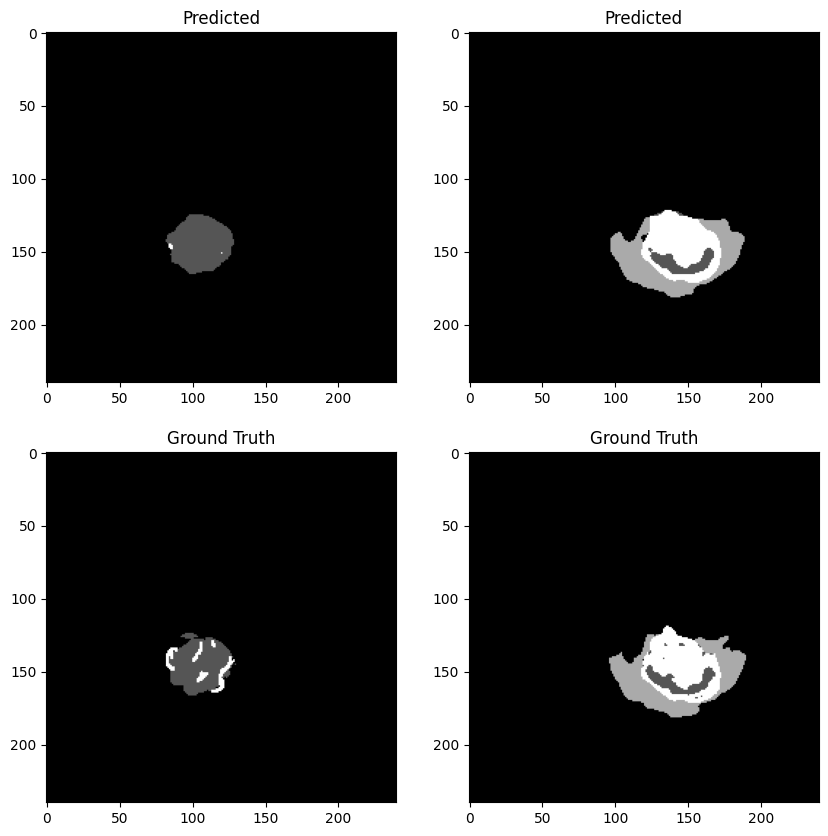

100%|██████████| 136/136 [09:15<00:00,  4.08s/it]



Average Training Loss: 0.011365923482705565

Average Training DSC: [0.99874978 0.80819248 0.88756705 0.65498461]
Average Training ASSD: [ 0.17602396 31.3260505  21.15535979 27.98335282]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


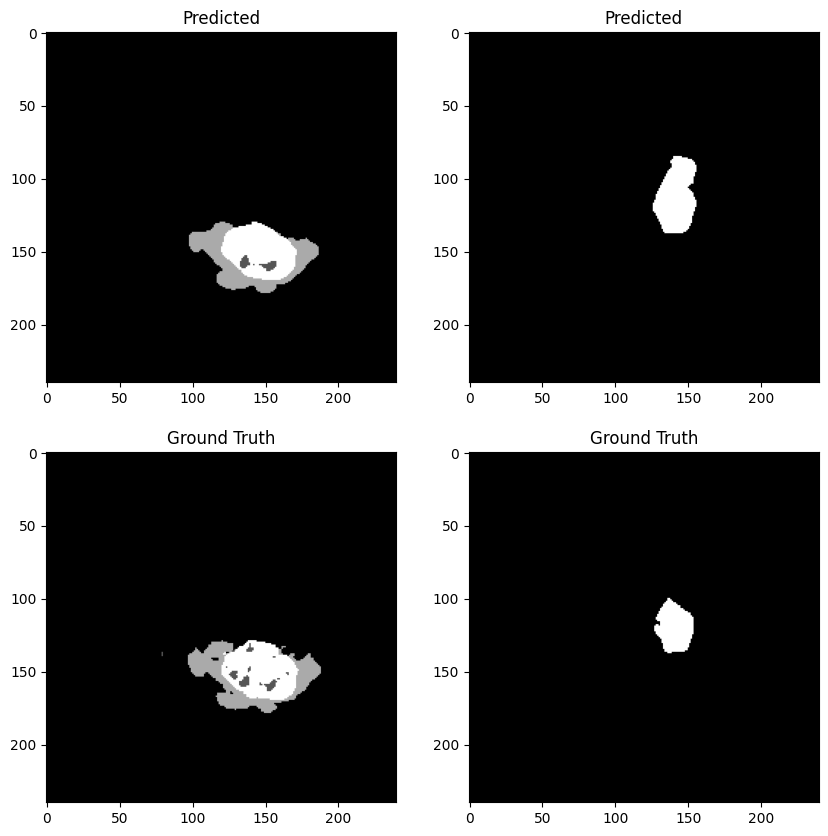

100%|██████████| 34/34 [02:07<00:00,  3.74s/it]


Average Validation Loss: 0.013211779899018653

Average Validation DSC: [0.99849644 0.78358427 0.85907061 0.62666646]
Average Validation ASSD: [ 0.24113788 43.04015339 29.8917914  29.33563162]
Epoch 22/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


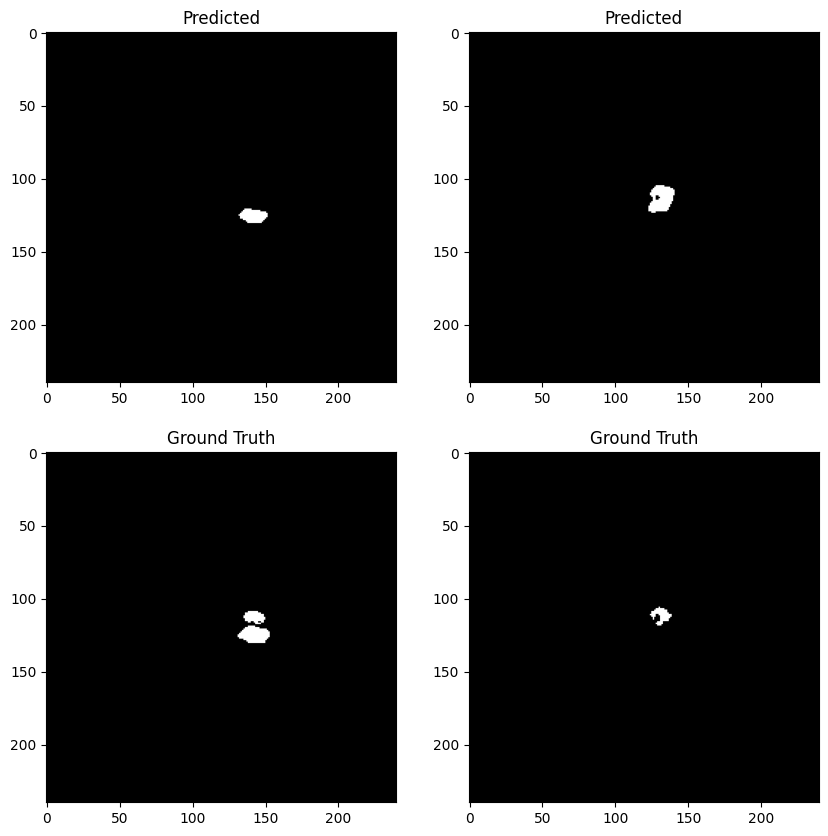

100%|██████████| 136/136 [08:48<00:00,  3.89s/it]



Average Training Loss: 0.011541269380626652

Average Training DSC: [0.99870059 0.806627   0.88372295 0.6577211 ]
Average Training ASSD: [ 0.19442542 31.1627092  21.51123037 29.73061178]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


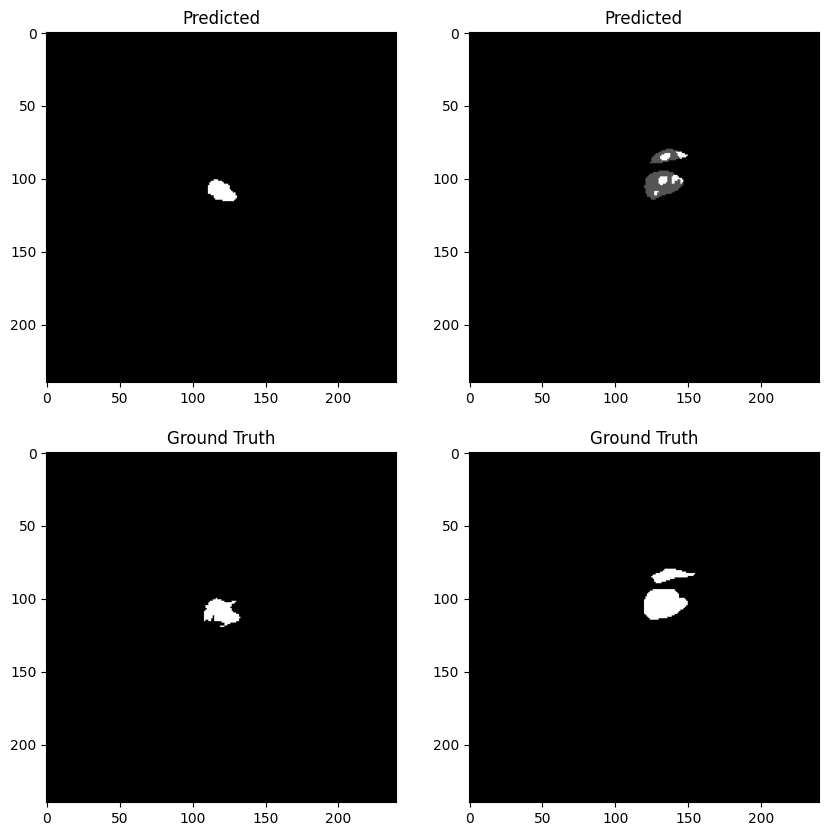

100%|██████████| 34/34 [02:05<00:00,  3.70s/it]


Average Validation Loss: 0.011745775255429395

Average Validation DSC: [0.99868064 0.81629436 0.88673694 0.66849378]
Average Validation ASSD: [ 0.18481778 29.97837385 21.07637246 24.48485732]
Epoch 23/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


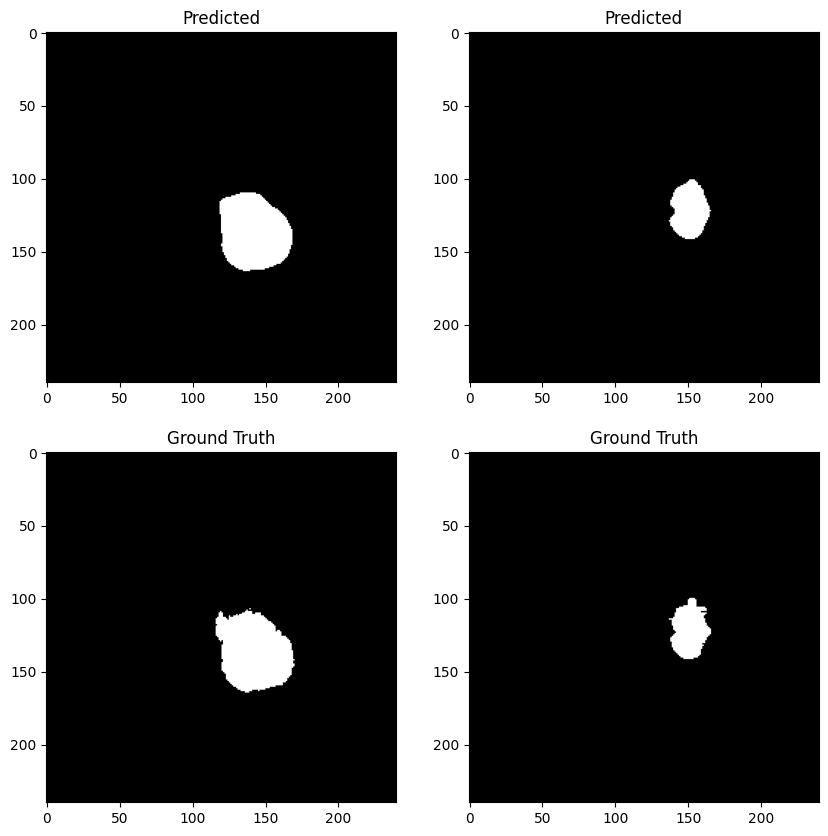

100%|██████████| 136/136 [08:39<00:00,  3.82s/it]



Average Training Loss: 0.011001315245213097

Average Training DSC: [0.99878142 0.82781815 0.8857965  0.66840439]
Average Training ASSD: [ 0.17507674 25.12273798 21.94977042 28.95698604]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


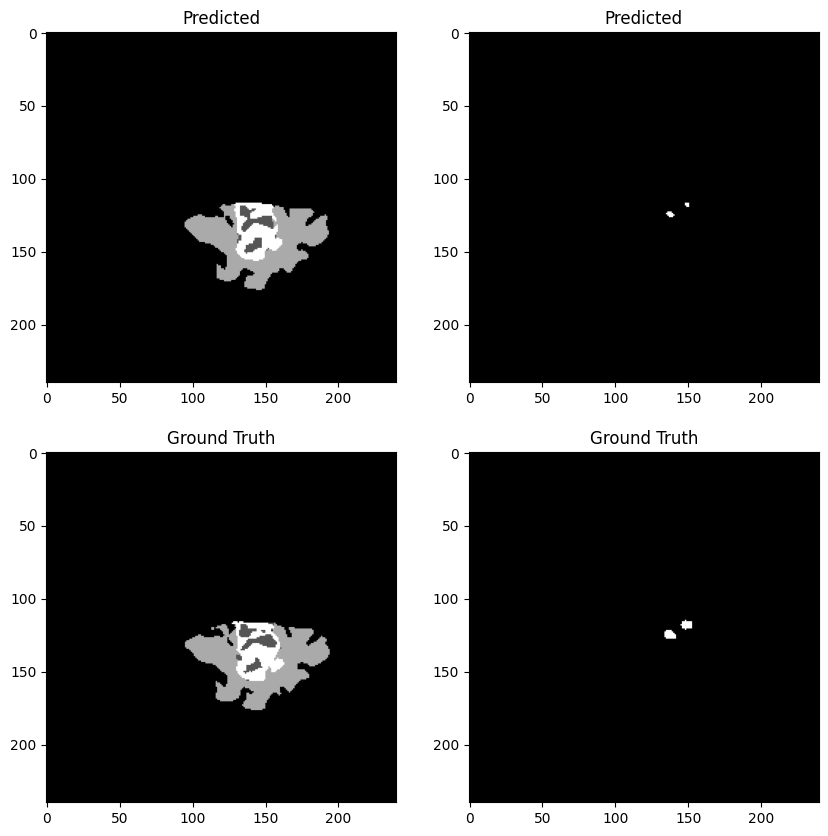

100%|██████████| 34/34 [02:05<00:00,  3.68s/it]


Average Validation Loss: 0.011849314467433621

Average Validation DSC: [0.99876465 0.78901794 0.87004268 0.63674603]
Average Validation ASSD: [ 0.17268649 41.26978457 27.13694025 32.4387475 ]
Epoch 24/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


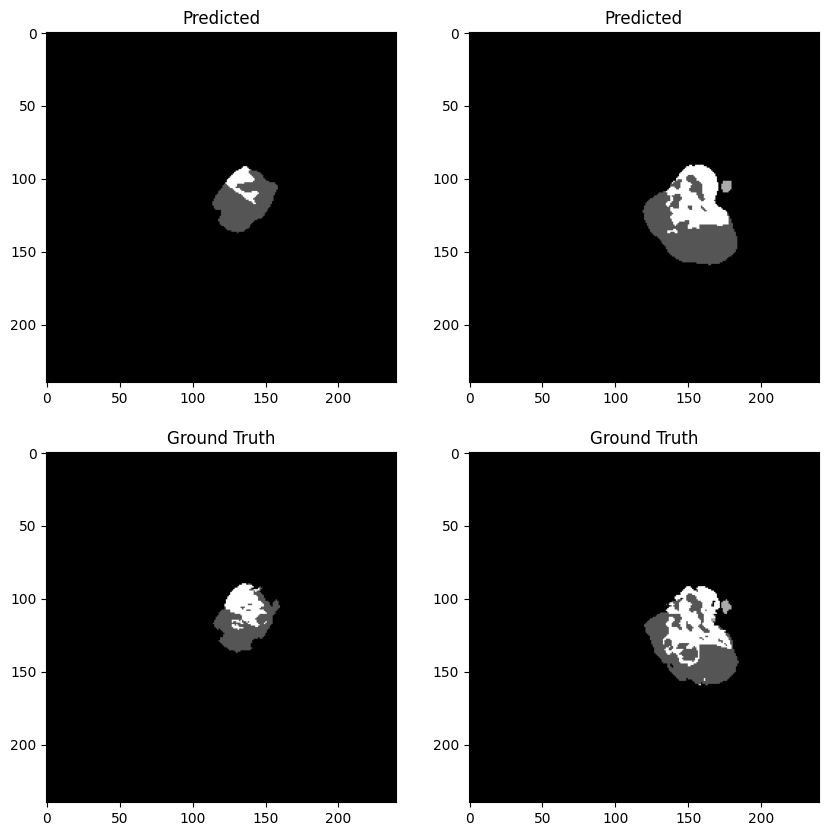

100%|██████████| 136/136 [09:00<00:00,  3.97s/it]



Average Training Loss: 0.010245296686394689

Average Training DSC: [0.99884538 0.83429404 0.90076534 0.67721232]
Average Training ASSD: [ 0.17114414 24.59099092 18.58949567 30.18963432]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


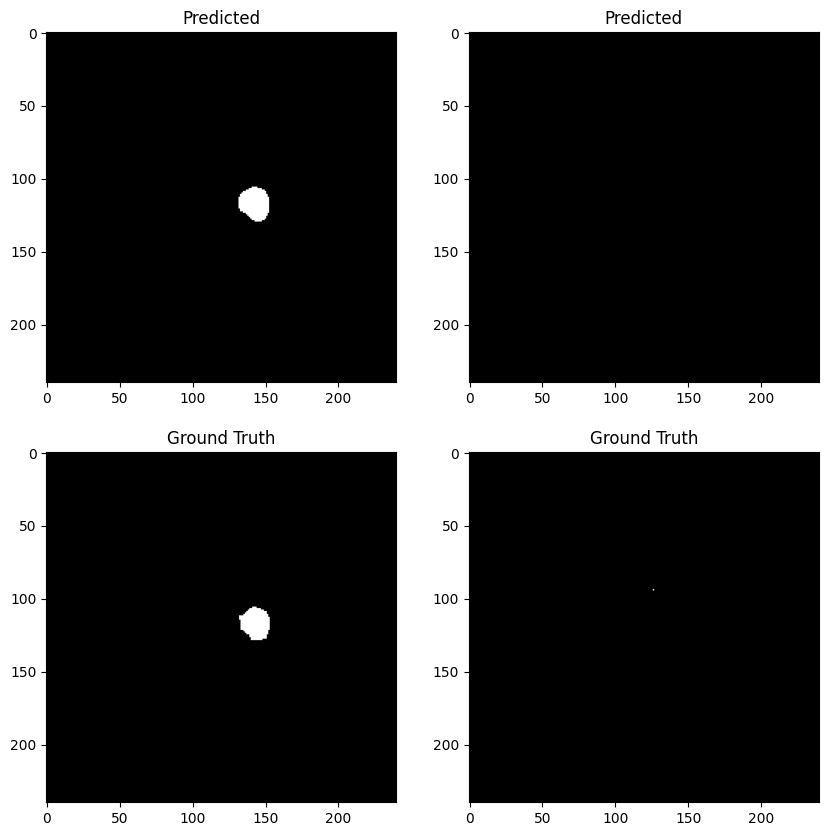

100%|██████████| 34/34 [02:02<00:00,  3.62s/it]


Average Validation Loss: 0.01591633865609765

Average Validation DSC: [0.99848317 0.736168   0.8684162  0.54028487]
Average Validation ASSD: [ 0.19244763 50.83217394 28.44886843 38.98213543]
Epoch 25/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


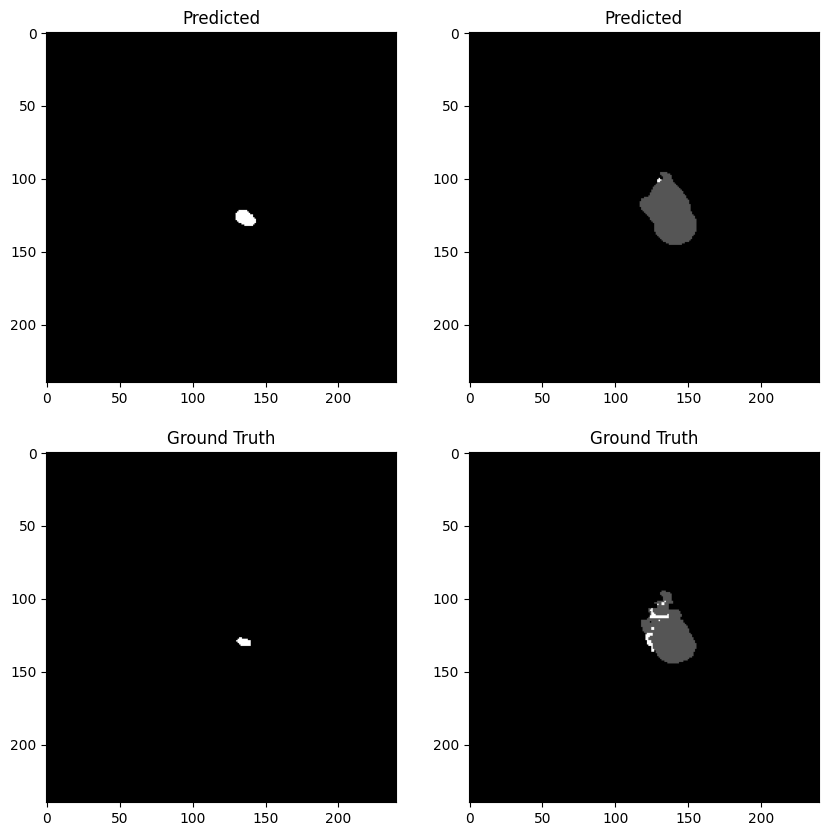

100%|██████████| 136/136 [09:01<00:00,  3.98s/it]



Average Training Loss: 0.010353939398876666

Average Training DSC: [0.99883249 0.83226761 0.90351137 0.6783153 ]
Average Training ASSD: [ 0.16118455 24.85379019 17.19684529 27.64947583]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


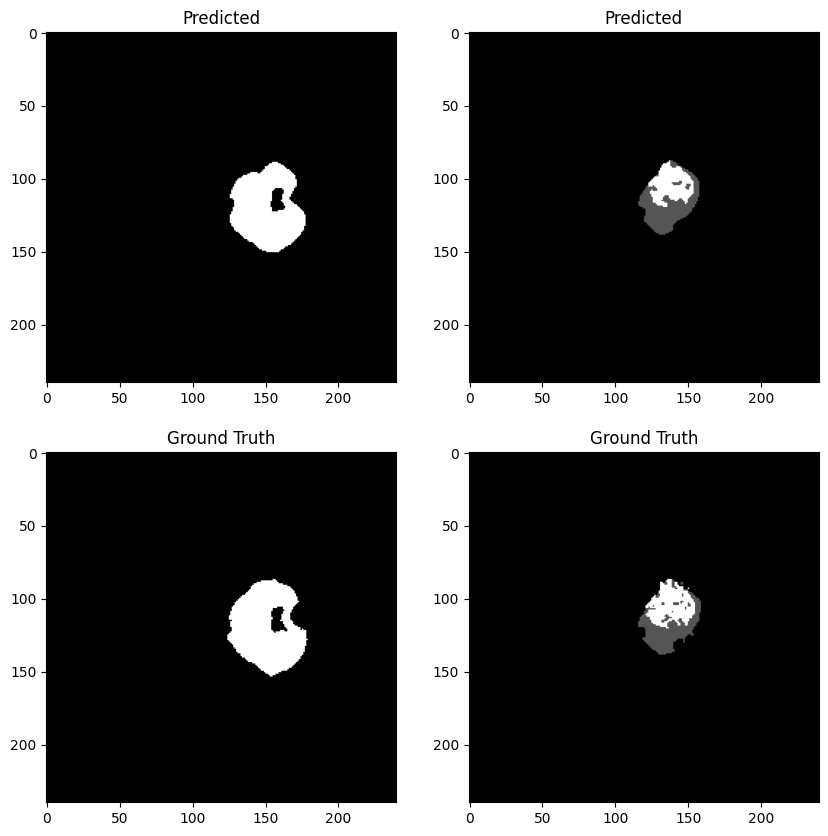

100%|██████████| 34/34 [02:06<00:00,  3.72s/it]


Average Validation Loss: 0.011449252241565025

Average Validation DSC: [0.99874575 0.78624378 0.88892995 0.66076342]
Average Validation ASSD: [ 0.20245759 40.75910874 21.89464924 36.71396904]
Epoch 26/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


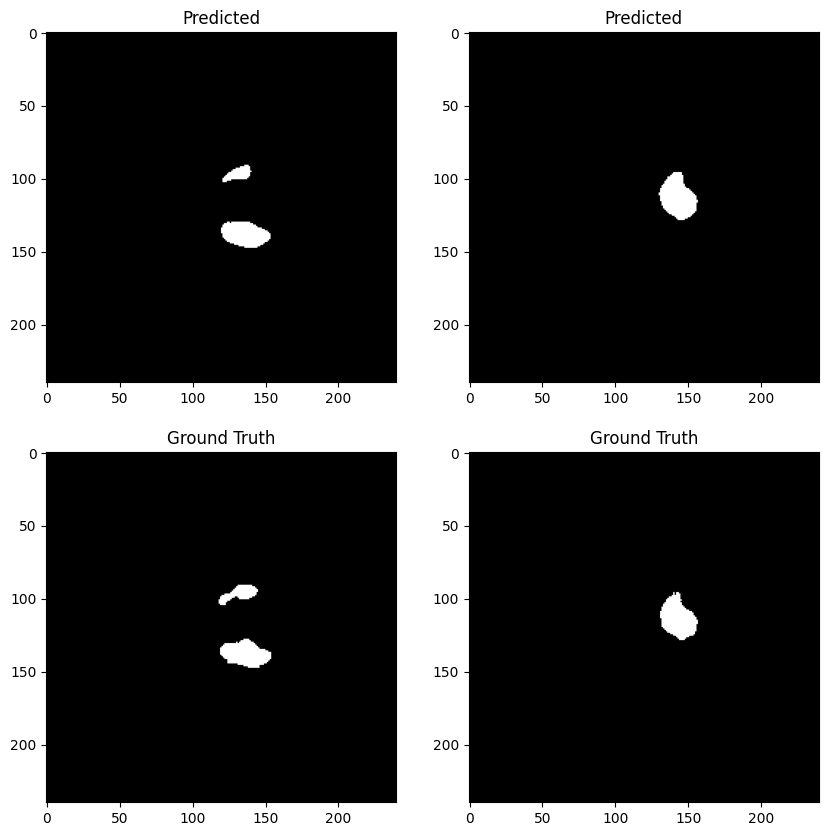

100%|██████████| 136/136 [08:50<00:00,  3.90s/it]



Average Training Loss: 0.009702614936566748

Average Training DSC: [0.99890829 0.84403232 0.91360466 0.69420969]
Average Training ASSD: [ 0.14833896 22.3172498  14.10685056 26.06140102]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


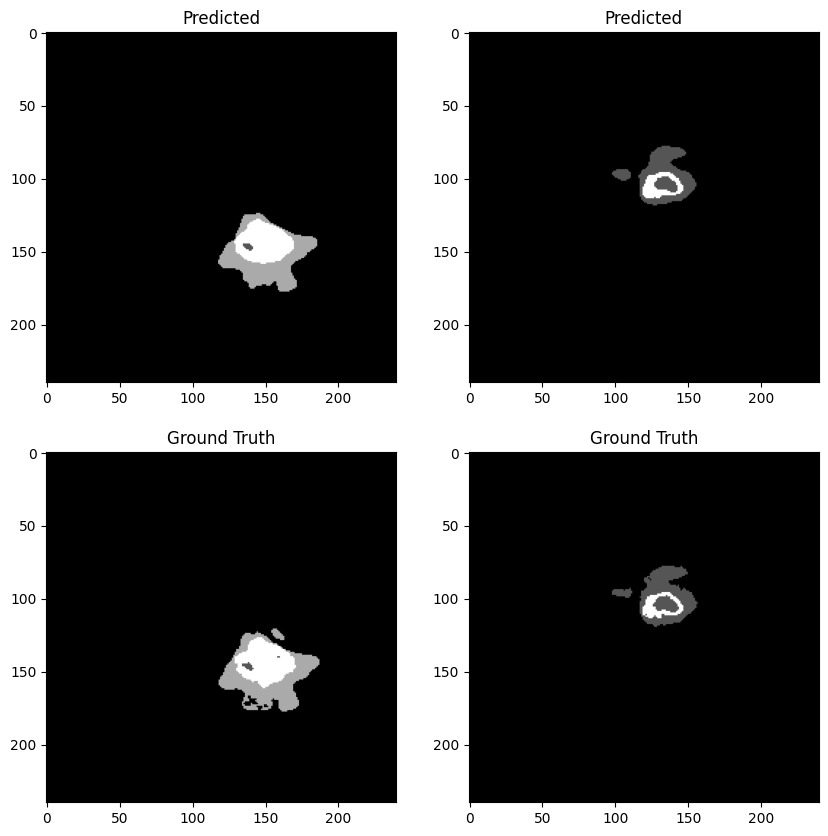

100%|██████████| 34/34 [02:13<00:00,  3.93s/it]


Average Validation Loss: 0.01041234125766684

Average Validation DSC: [0.99882634 0.81682647 0.89897716 0.70594176]
Average Validation ASSD: [ 0.16479344 32.39918419 20.38291216 20.14146464]
Epoch 27/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


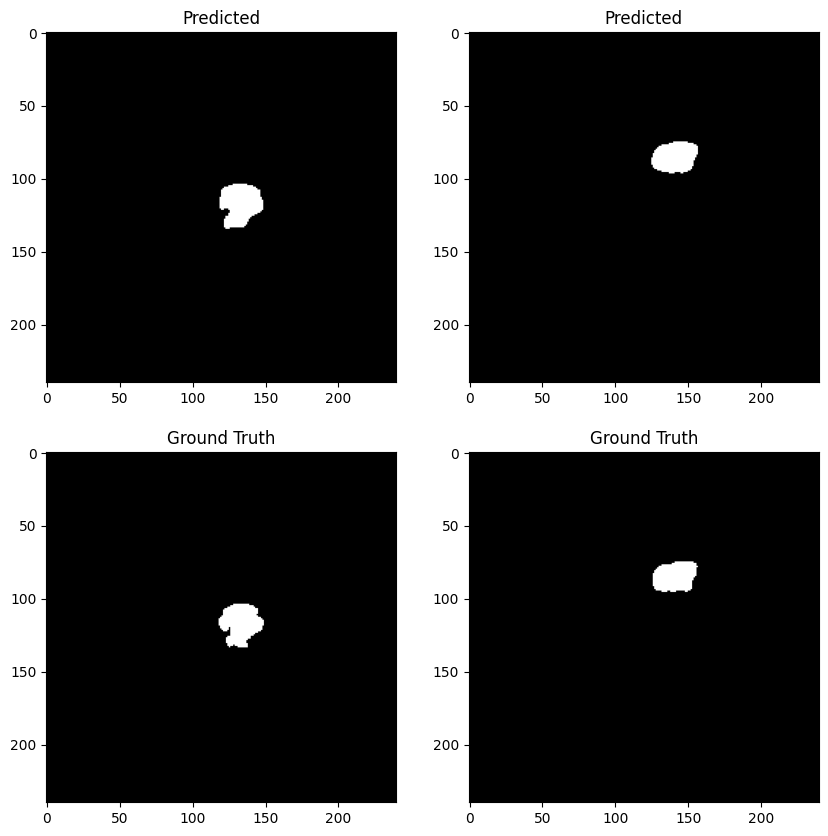

100%|██████████| 136/136 [09:23<00:00,  4.14s/it]



Average Training Loss: 0.009375125676503076

Average Training DSC: [0.99892491 0.84944146 0.90946997 0.70165692]
Average Training ASSD: [ 0.143968   21.20561475 15.51994227 25.41035601]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


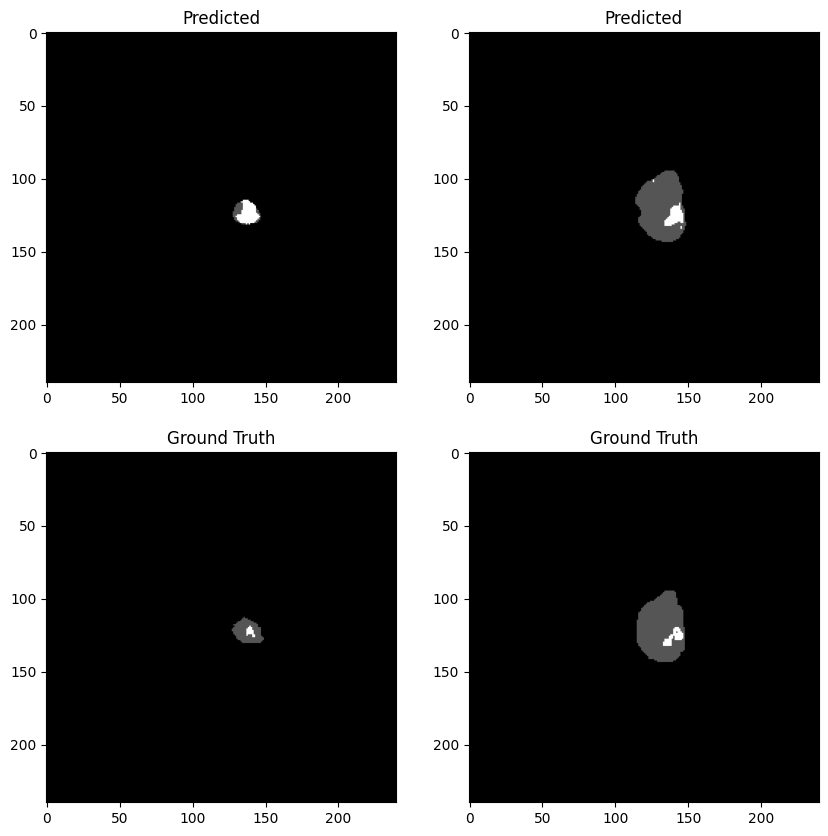

100%|██████████| 34/34 [02:09<00:00,  3.81s/it]


Average Validation Loss: 0.010940215468187542

Average Validation DSC: [0.99882914 0.82341314 0.90923876 0.71637986]
Average Validation ASSD: [ 0.15818085 25.85081651 15.48217819 17.13342344]
Epoch 28/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


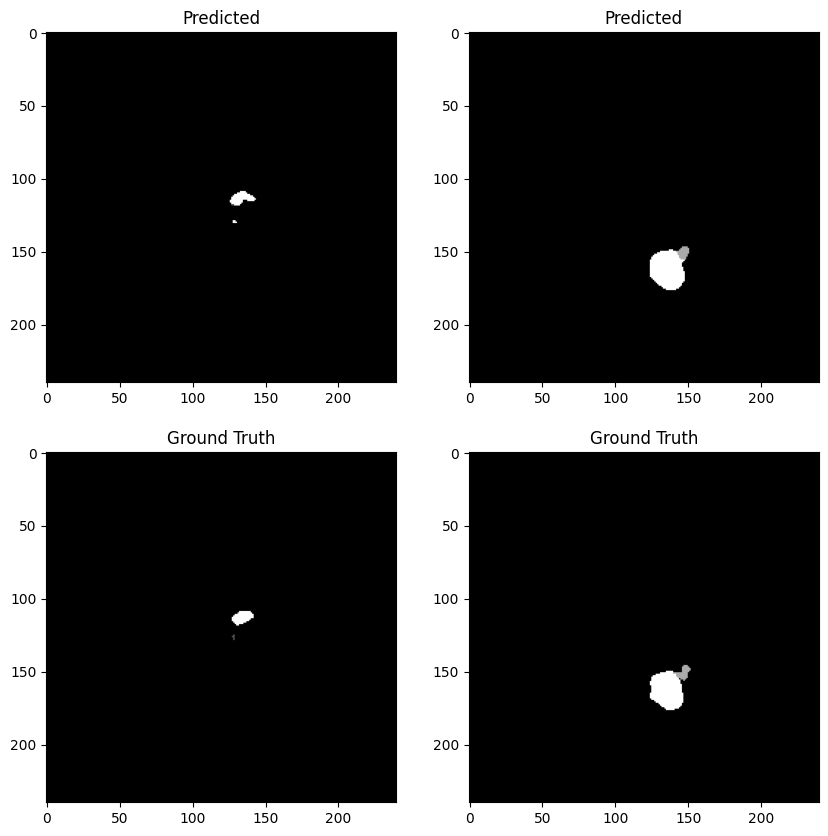

100%|██████████| 136/136 [09:23<00:00,  4.14s/it]



Average Training Loss: 0.009336955626221263

Average Training DSC: [0.99895743 0.84344755 0.91097797 0.70417557]
Average Training ASSD: [ 0.14264502 23.52907312 15.23551065 25.43941697]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


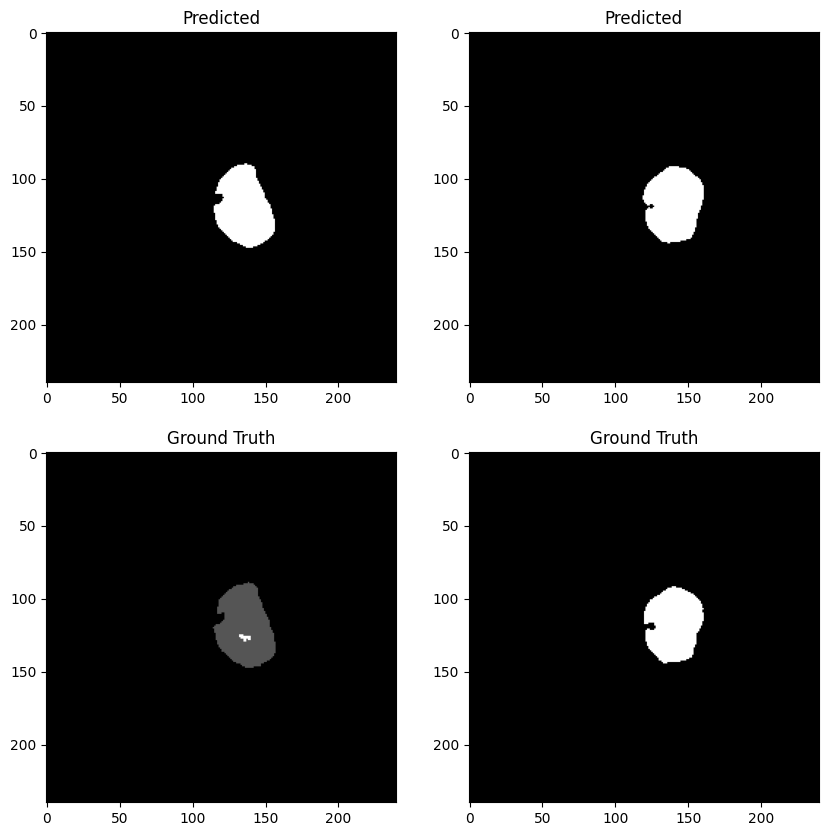

100%|██████████| 34/34 [02:08<00:00,  3.78s/it]


Average Validation Loss: 0.011214600506183855

Average Validation DSC: [0.99884012 0.81543918 0.91475274 0.70561928]
Average Validation ASSD: [ 0.16894274 23.1676993  14.38373121 21.51965374]
Epoch 29/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


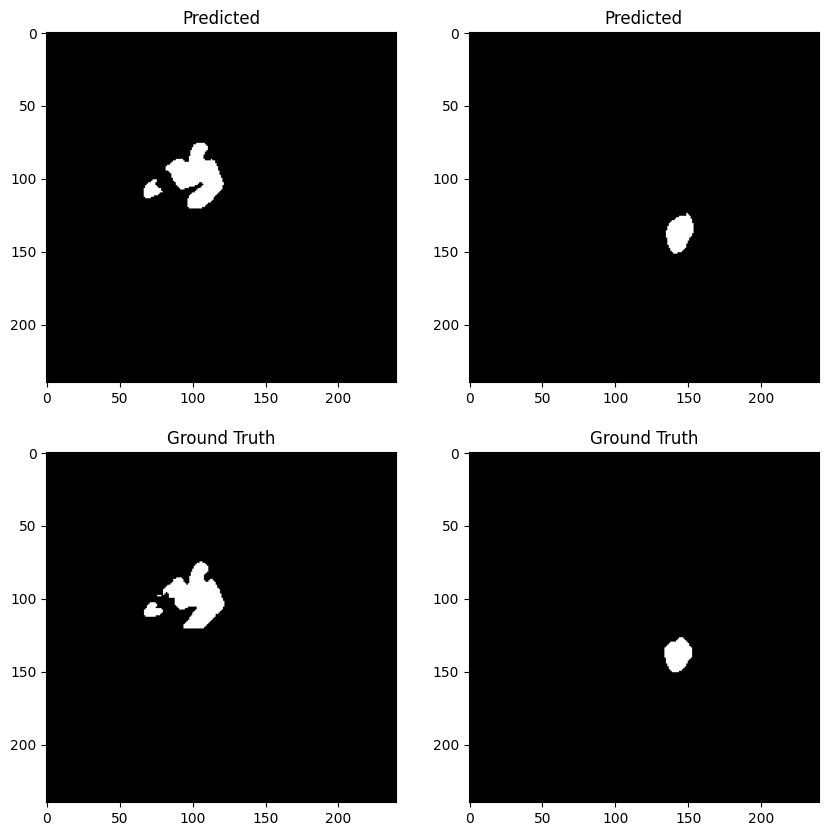

100%|██████████| 136/136 [09:11<00:00,  4.06s/it]



Average Training Loss: 0.009241122653132634

Average Training DSC: [0.99895848 0.85378201 0.90000211 0.70984753]
Average Training ASSD: [ 0.14142444 21.01400356 17.55668669 24.95523062]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


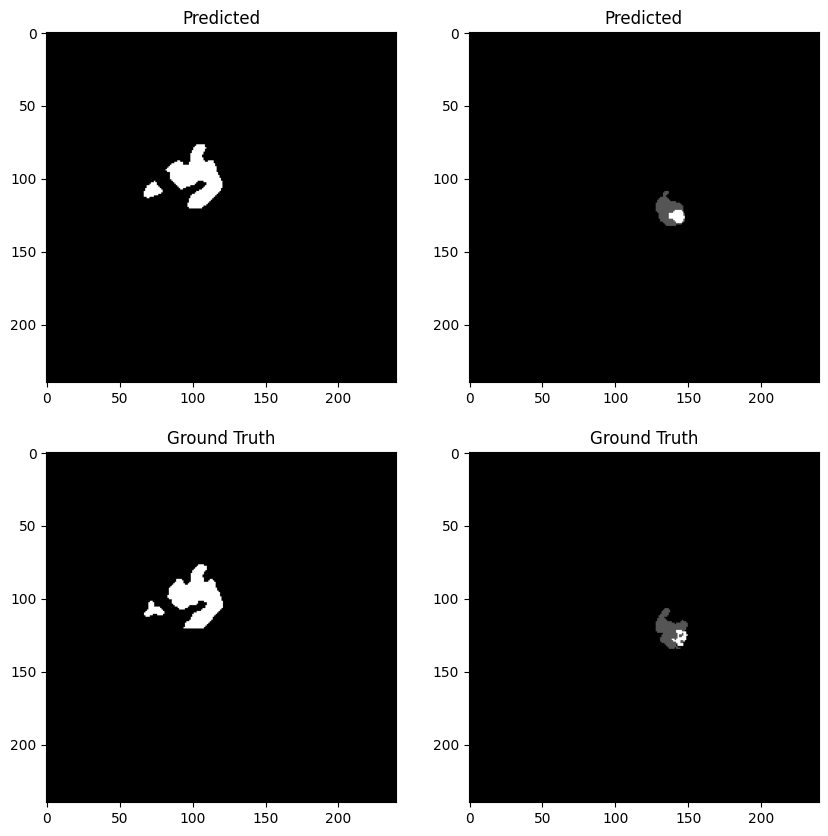

100%|██████████| 34/34 [02:10<00:00,  3.85s/it]


Average Validation Loss: 0.01016685924054507

Average Validation DSC: [0.99890207 0.84636929 0.91460781 0.7106617 ]
Average Validation ASSD: [ 0.16169711 22.69308668 12.33729435 24.0072643 ]
Epoch 30/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


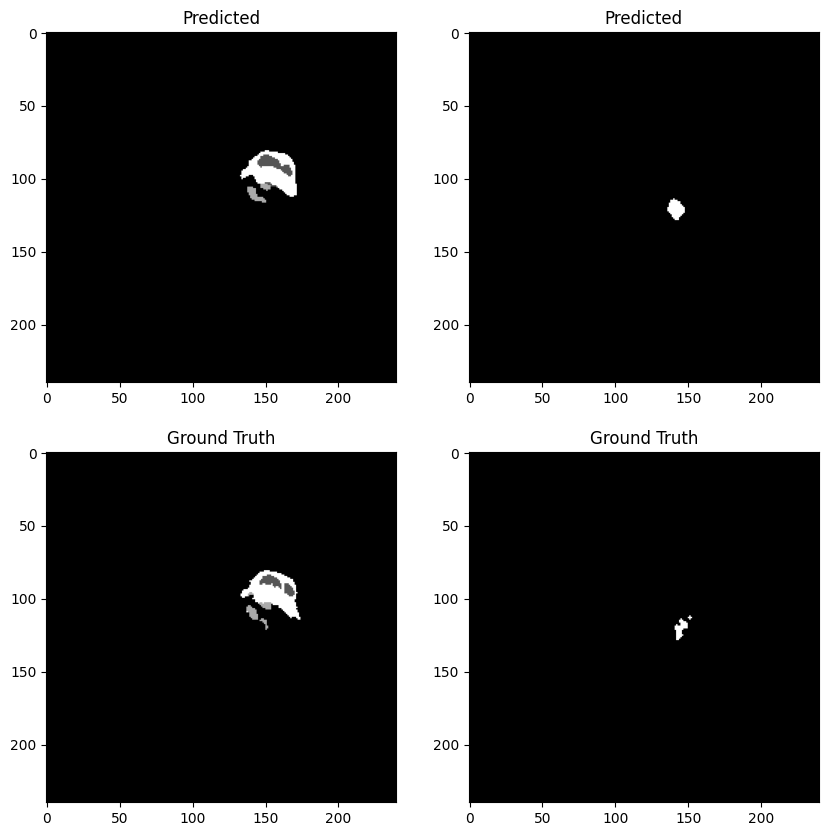

100%|██████████| 136/136 [09:06<00:00,  4.02s/it]



Average Training Loss: 0.00875604264301193

Average Training DSC: [0.99898609 0.86142166 0.92050729 0.71660874]
Average Training ASSD: [ 0.13913467 18.1793906  12.47900697 24.94908179]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


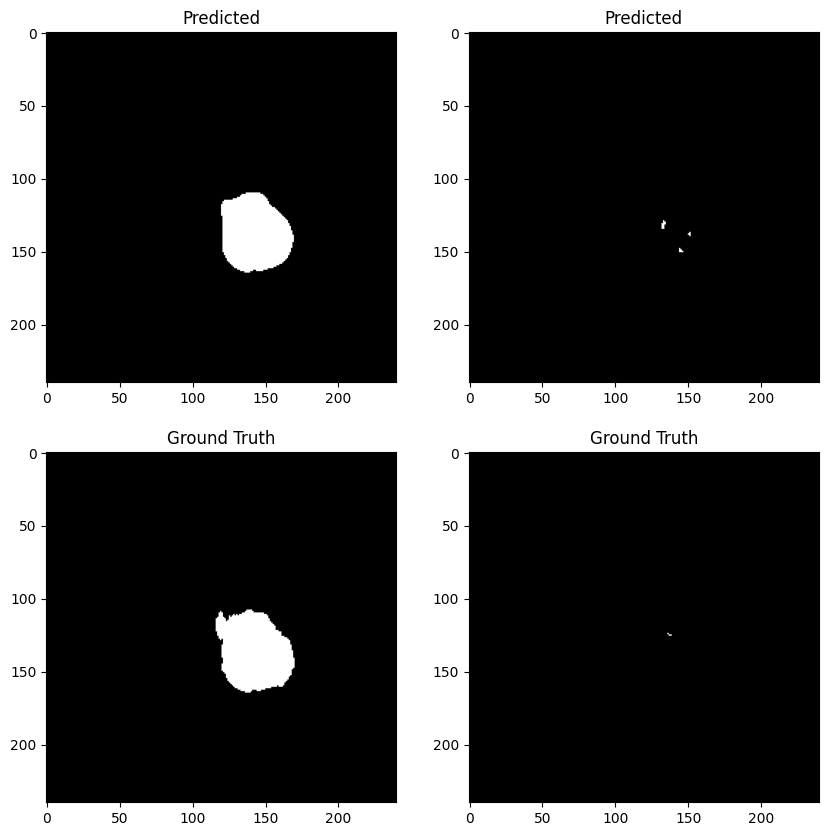

100%|██████████| 34/34 [02:12<00:00,  3.89s/it]


Average Validation Loss: 0.012579333858893198

Average Validation DSC: [0.99849485 0.80576141 0.88872536 0.68732531]
Average Validation ASSD: [ 0.22062662 32.4533942  17.82946853 28.87268636]
Epoch 31/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


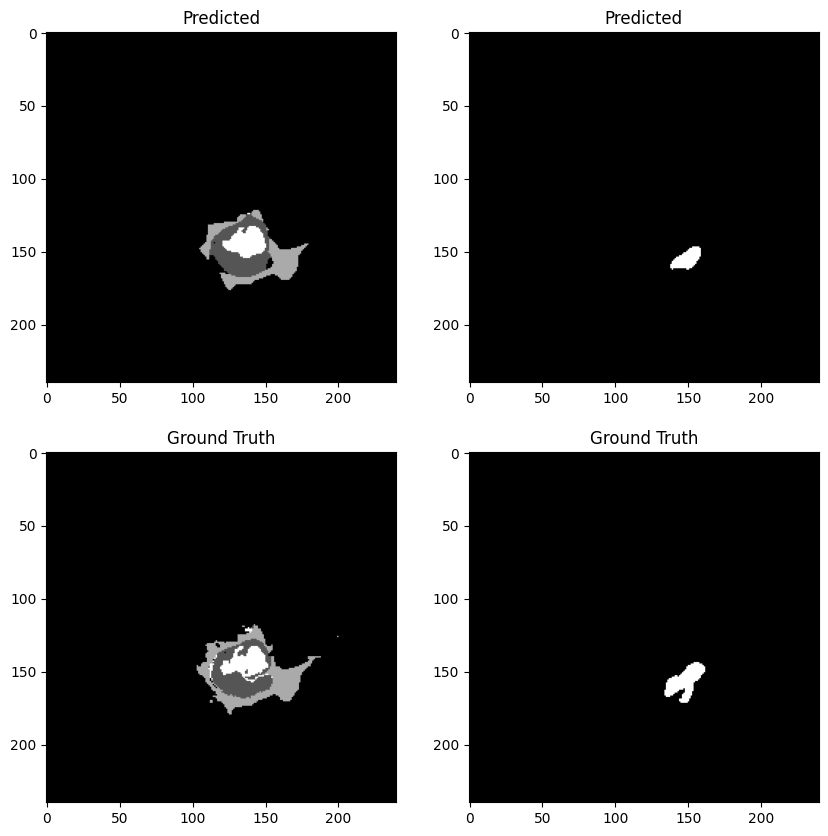

100%|██████████| 136/136 [09:23<00:00,  4.14s/it]



Average Training Loss: 0.008917369016939226

Average Training DSC: [0.99898933 0.85605187 0.91466278 0.72011197]
Average Training ASSD: [ 0.13909295 20.99797291 14.571675   24.49048689]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


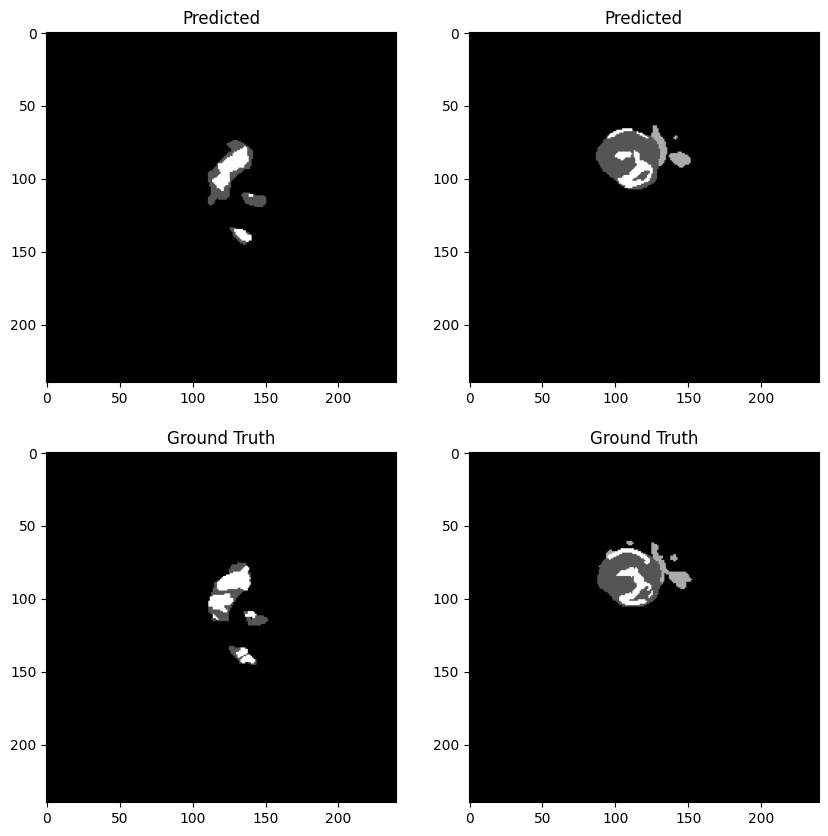

100%|██████████| 34/34 [02:11<00:00,  3.86s/it]


Average Validation Loss: 0.009609438232420123

Average Validation DSC: [0.99896967 0.84600174 0.91535805 0.73096675]
Average Validation ASSD: [ 0.14648169 20.36926181 14.06986369 20.03282454]
Epoch 32/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


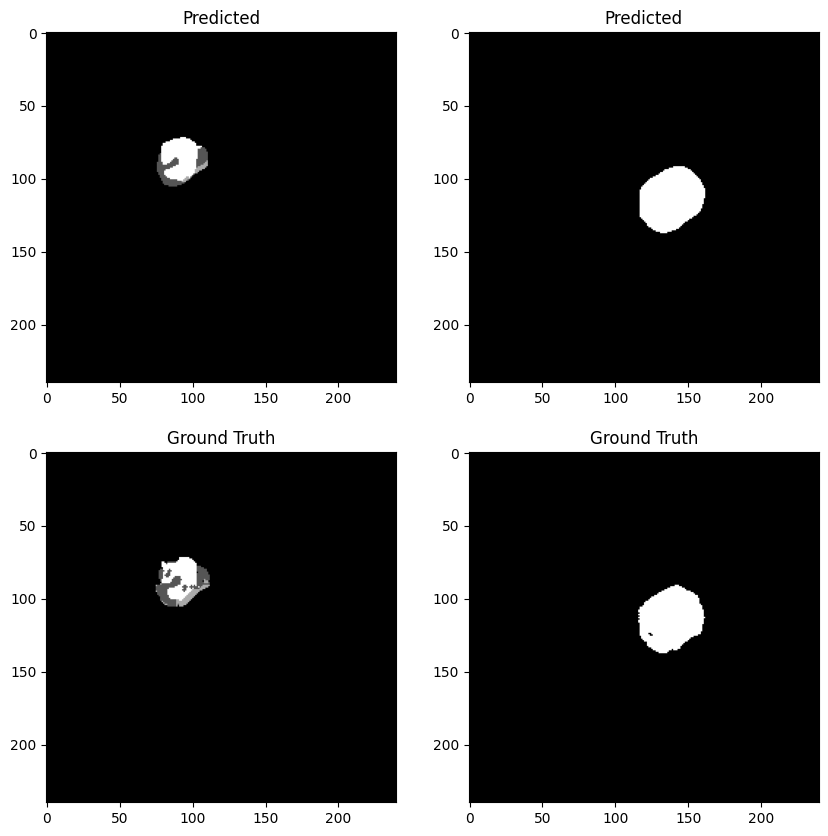

100%|██████████| 136/136 [09:37<00:00,  4.24s/it]



Average Training Loss: 0.00855368307298597

Average Training DSC: [0.99904993 0.86478581 0.92016388 0.72506465]
Average Training ASSD: [ 0.12651741 17.17292655 12.7441432  24.29578258]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


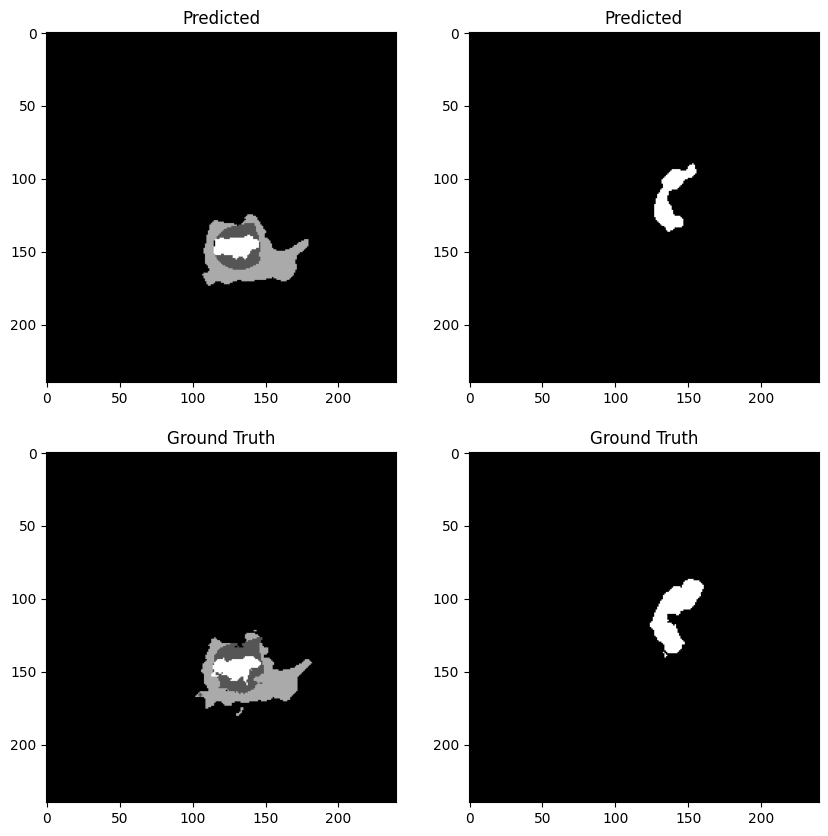

100%|██████████| 34/34 [02:12<00:00,  3.90s/it]


Average Validation Loss: 0.010060469031005222

Average Validation DSC: [0.99890327 0.85263363 0.9122897  0.72691992]
Average Validation ASSD: [ 0.1490073  23.66191167 14.16694323 19.30269278]
Epoch 33/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


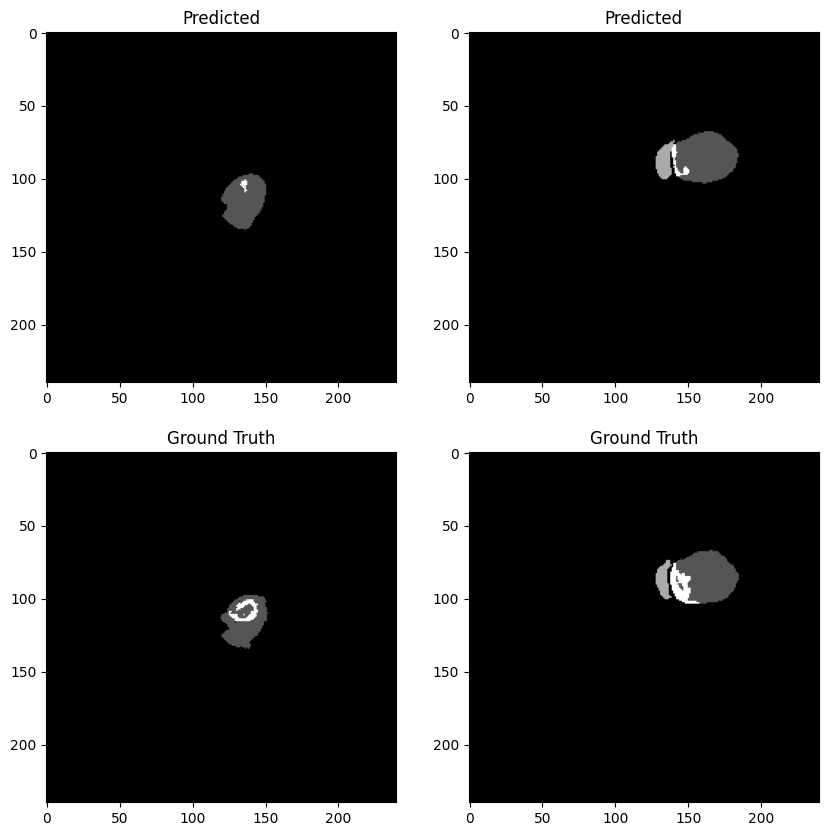

100%|██████████| 136/136 [09:42<00:00,  4.28s/it]



Average Training Loss: 0.008271584218806204

Average Training DSC: [0.99904964 0.86925658 0.92534405 0.73241163]
Average Training ASSD: [ 0.12857022 17.37657429 11.62975584 23.20132382]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


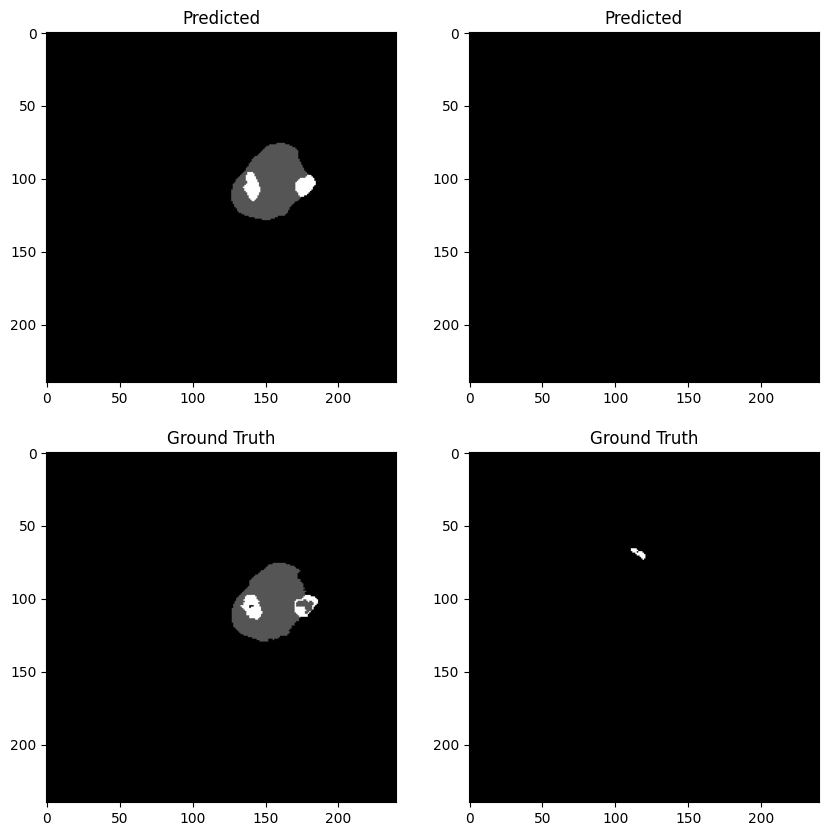

100%|██████████| 34/34 [02:18<00:00,  4.07s/it]


Average Validation Loss: 0.009509526754674666

Average Validation DSC: [0.99897454 0.86114012 0.91708713 0.712074  ]
Average Validation ASSD: [ 0.15429687 21.57592187 14.61281942 28.45298285]
Epoch 34/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


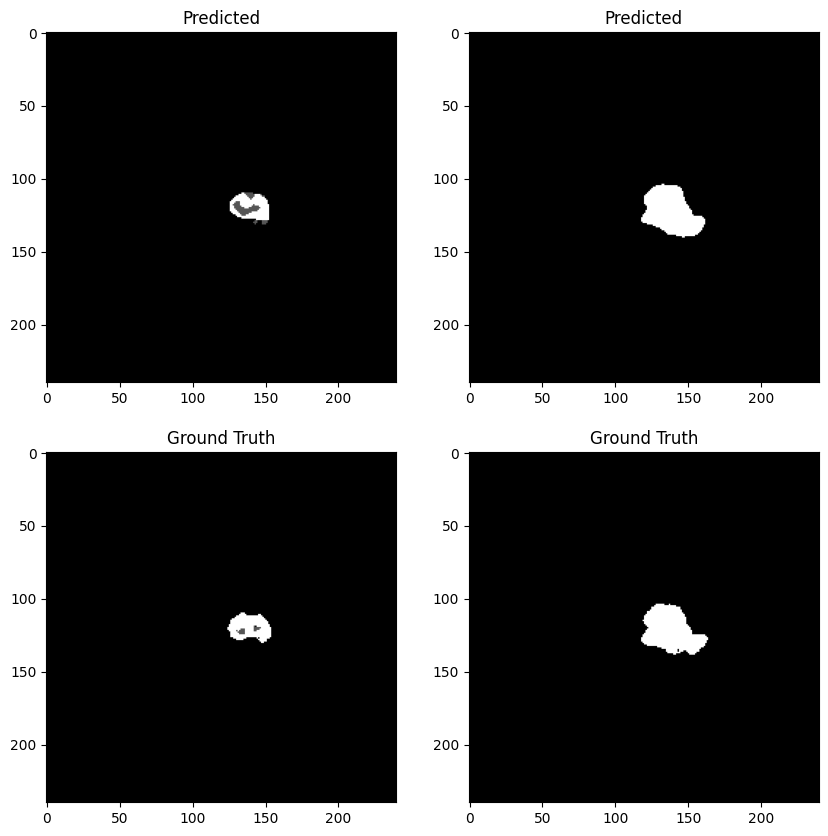

100%|██████████| 136/136 [09:39<00:00,  4.26s/it]



Average Training Loss: 0.008045625540783958

Average Training DSC: [0.99907616 0.87405058 0.92180542 0.73621015]
Average Training ASSD: [ 0.12911479 16.86689306 12.95212722 23.6530423 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


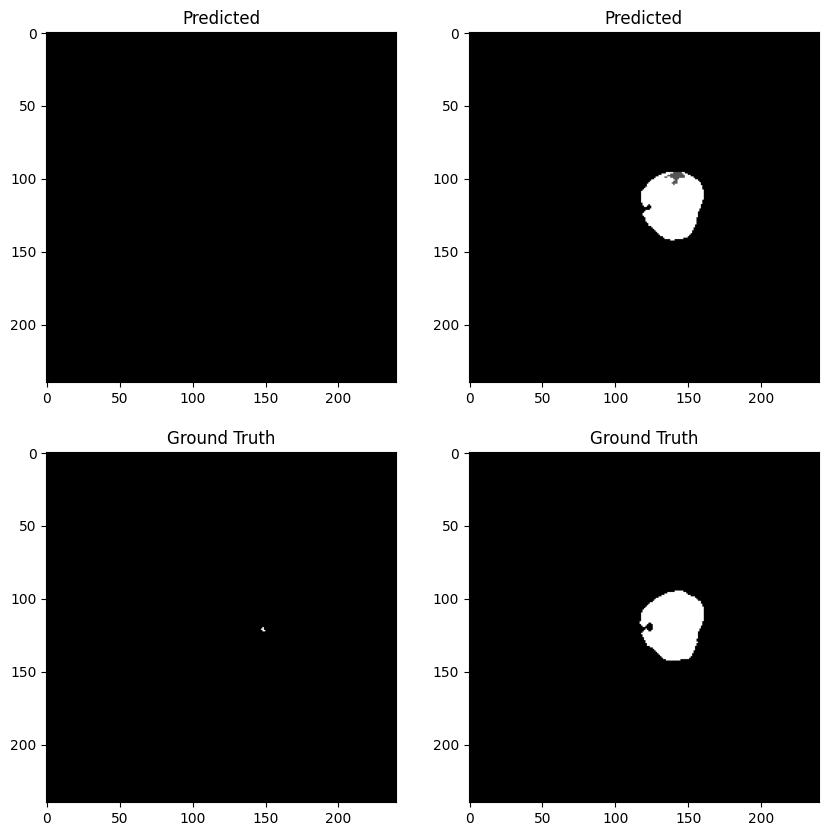

100%|██████████| 34/34 [02:16<00:00,  4.01s/it]


Average Validation Loss: 0.00964051516562262

Average Validation DSC: [0.99896138 0.84571403 0.91114071 0.73208125]
Average Validation ASSD: [ 0.14836935 24.94521017 16.43297511 19.20166544]
Epoch 35/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


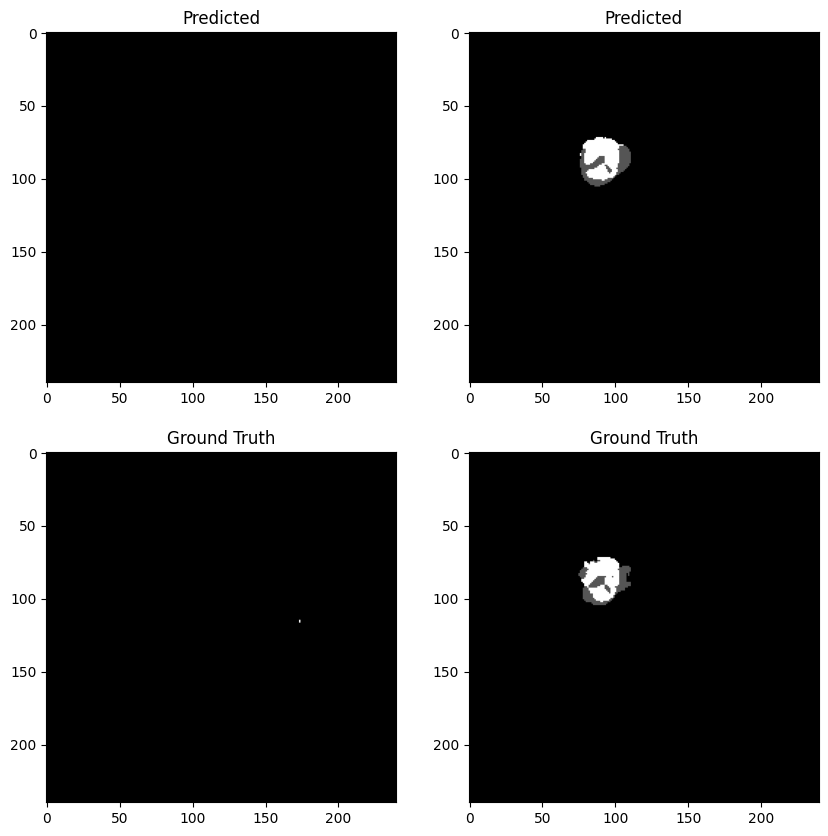

100%|██████████| 136/136 [09:34<00:00,  4.22s/it]



Average Training Loss: 0.008541346900849877

Average Training DSC: [0.99902603 0.86118024 0.91655821 0.72903212]
Average Training ASSD: [ 0.13008528 19.4661892  14.37864361 23.59025661]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


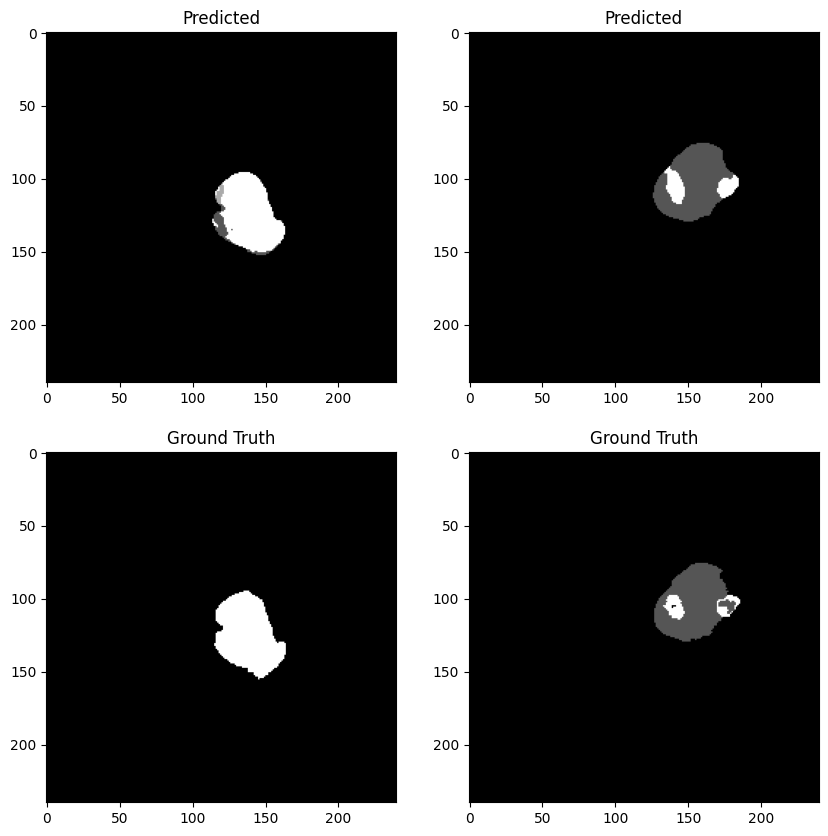

100%|██████████| 34/34 [02:12<00:00,  3.89s/it]


Average Validation Loss: 0.01134905862786314

Average Validation DSC: [0.99884817 0.81921905 0.90164186 0.70600782]
Average Validation ASSD: [ 0.1684026  24.17970723 18.75038115 21.03583049]
Epoch 36/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


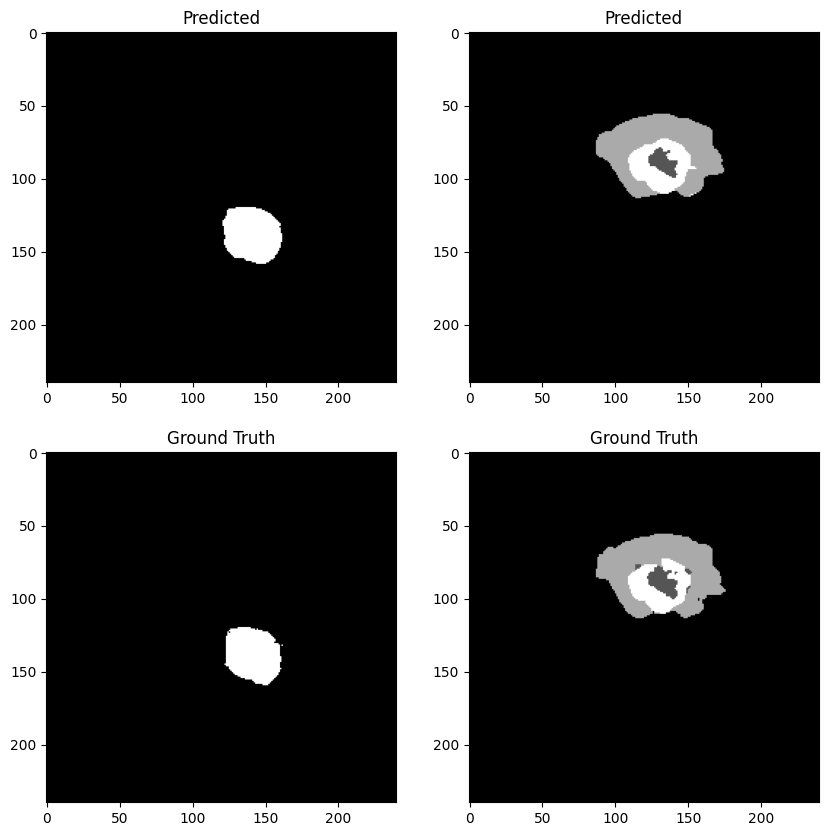

100%|██████████| 136/136 [09:37<00:00,  4.24s/it]



Average Training Loss: 0.007947077173465752

Average Training DSC: [0.99908489 0.87786039 0.92928128 0.74085873]
Average Training ASSD: [ 0.1278611  16.26538564 10.96789344 23.41666431]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


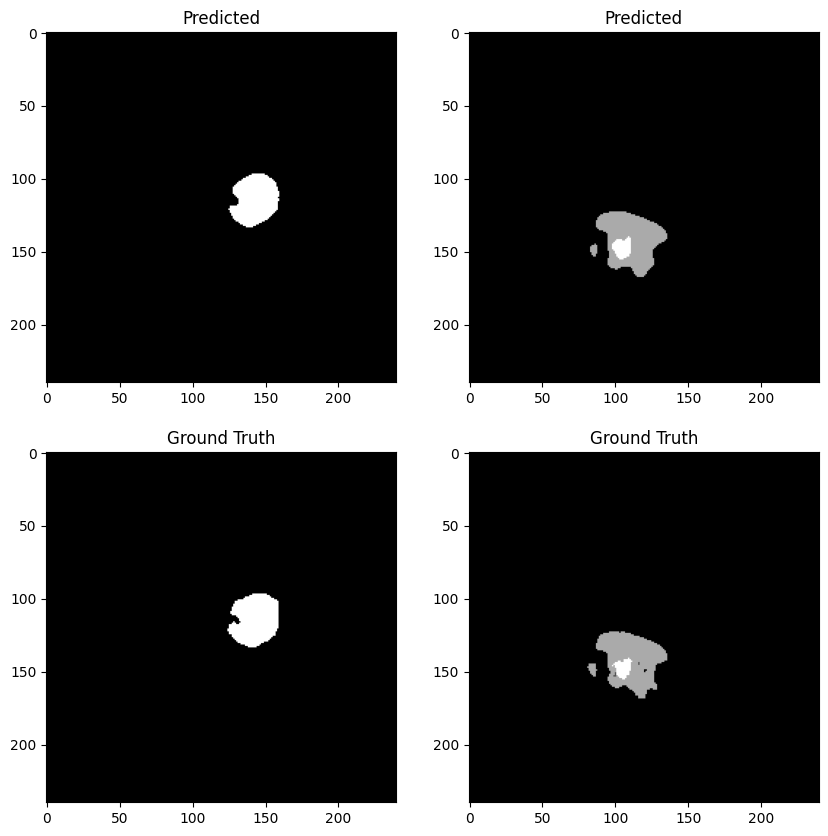

100%|██████████| 34/34 [02:13<00:00,  3.94s/it]


Average Validation Loss: 0.009582045926328967

Average Validation DSC: [0.99893474 0.85673256 0.92411362 0.72381793]
Average Validation ASSD: [ 0.16506547 20.28671019 11.59445844 26.30333726]
Epoch 37/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


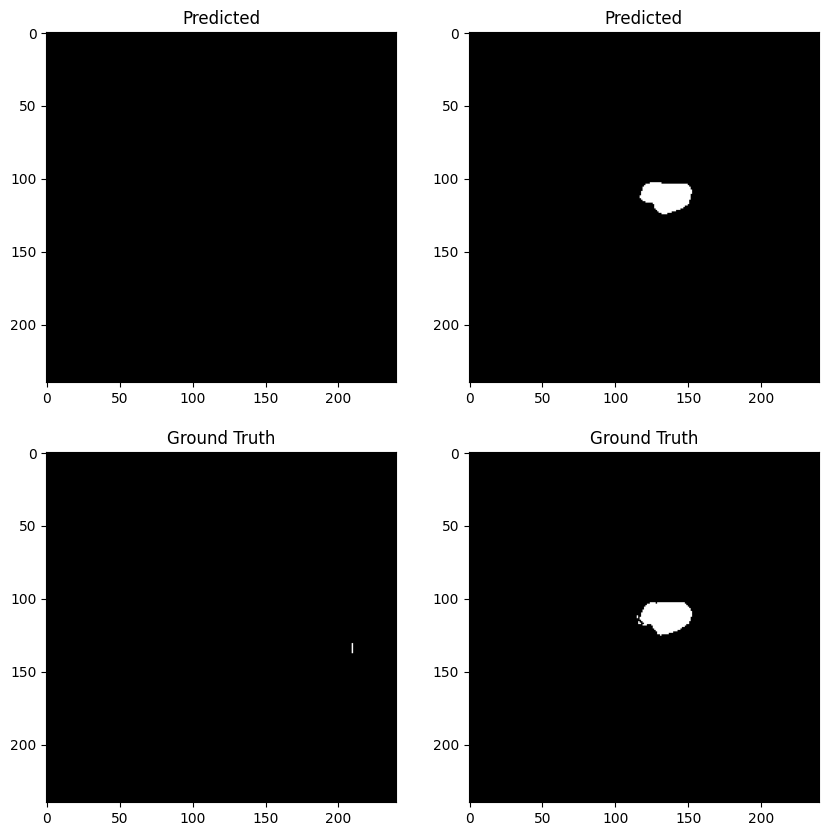

100%|██████████| 136/136 [09:35<00:00,  4.23s/it]



Average Training Loss: 0.00741195138749283

Average Training DSC: [0.99914204 0.88232398 0.93292211 0.75071435]
Average Training ASSD: [ 0.11628888 15.08902229 10.17585227 21.73774417]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


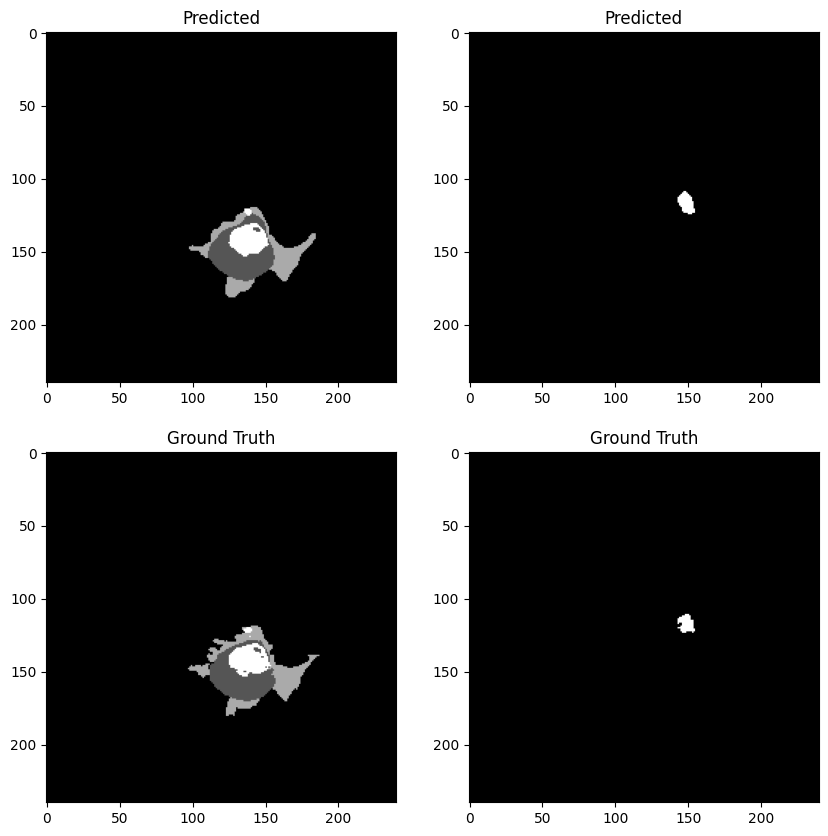

100%|██████████| 34/34 [02:12<00:00,  3.91s/it]


Average Validation Loss: 0.008803386419244549

Average Validation DSC: [0.9990482  0.86598376 0.91875641 0.74556426]
Average Validation ASSD: [ 0.12929654 21.18968768 15.46433446 20.33569454]
Epoch 38/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


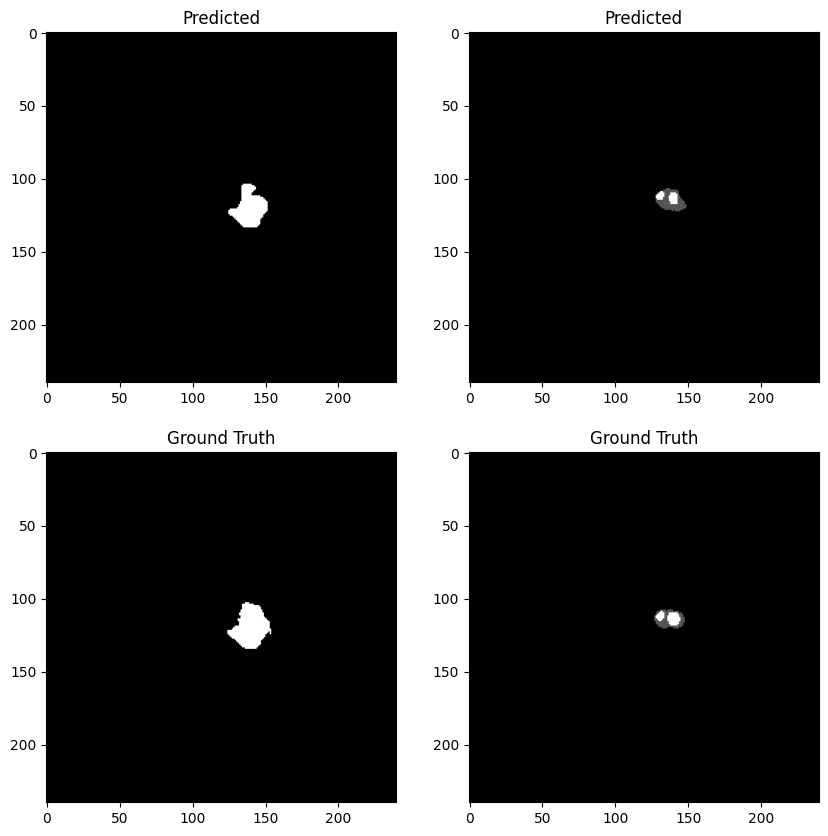

100%|██████████| 136/136 [09:33<00:00,  4.22s/it]



Average Training Loss: 0.007649728210012922

Average Training DSC: [0.99914038 0.87208181 0.92578001 0.747361  ]
Average Training ASSD: [ 0.11446058 17.61060742 12.42026211 21.87031016]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


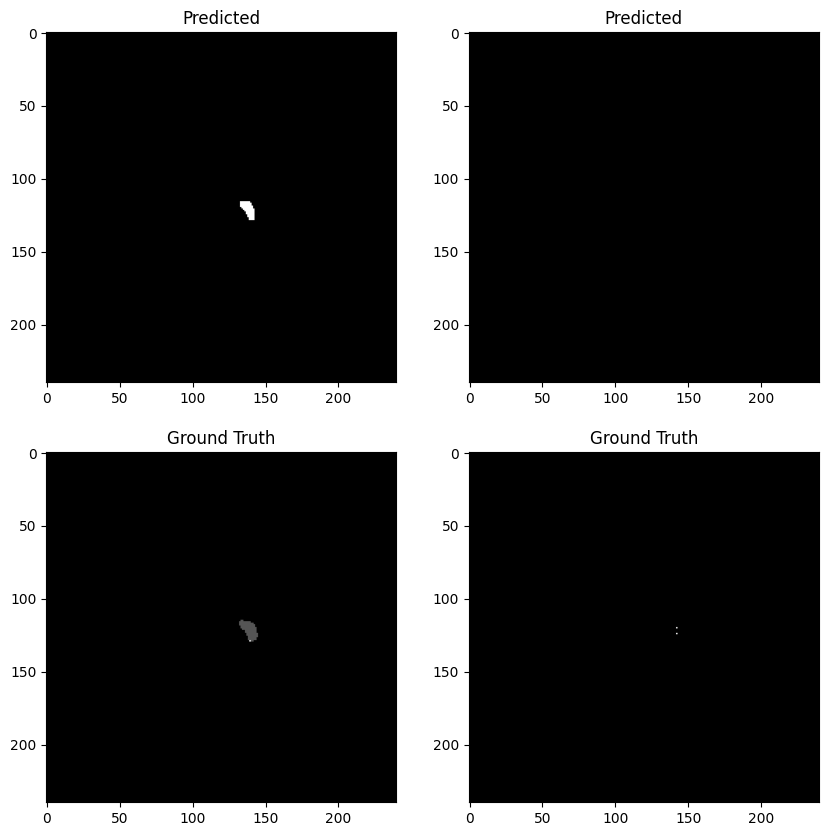

100%|██████████| 34/34 [02:06<00:00,  3.72s/it]


Average Validation Loss: 0.009123404140529387

Average Validation DSC: [0.99905246 0.86020968 0.90595815 0.72947249]
Average Validation ASSD: [ 0.12516476 24.19739739 19.34933177 23.81006632]
Epoch 39/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


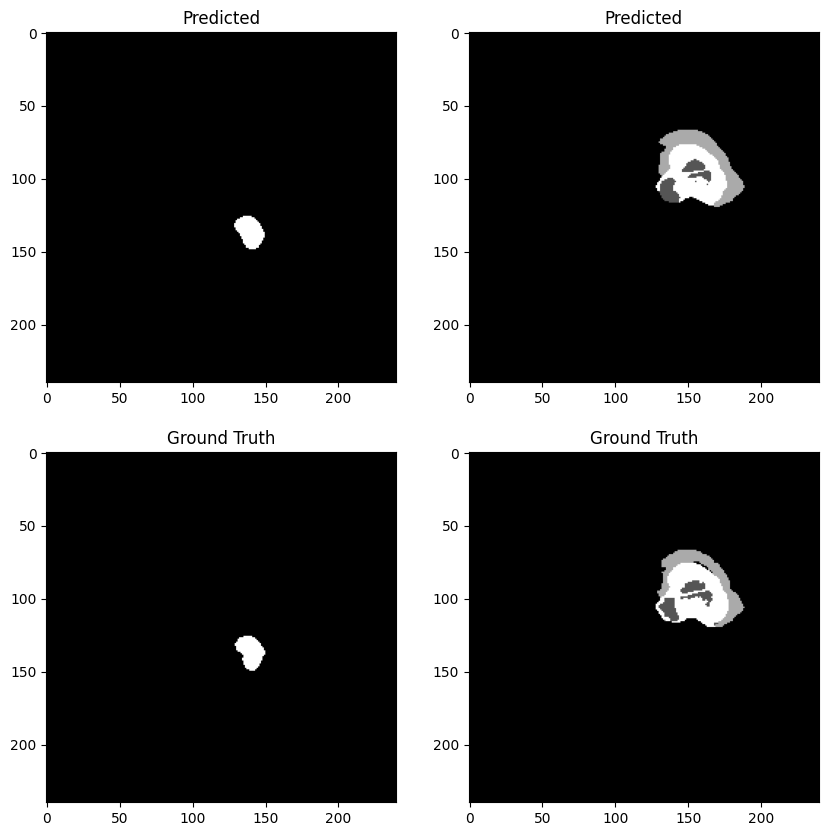

100%|██████████| 136/136 [09:04<00:00,  4.00s/it]



Average Training Loss: 0.007508191215011346

Average Training DSC: [0.99915324 0.88271163 0.92488715 0.75141412]
Average Training ASSD: [ 0.11612939 14.18315311 13.33829957 21.45962718]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


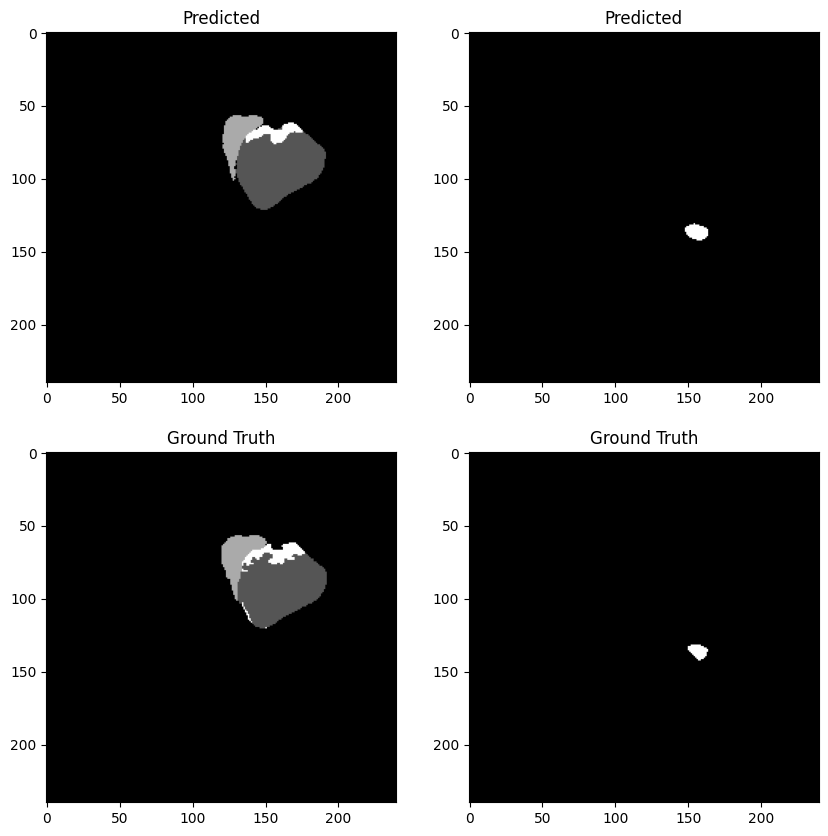

100%|██████████| 34/34 [02:04<00:00,  3.66s/it]


Average Validation Loss: 0.009810486055143616

Average Validation DSC: [0.99899729 0.83157223 0.91149242 0.71379916]
Average Validation ASSD: [ 0.12883639 30.70458919 15.84866235 17.56399348]
Epoch 40/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


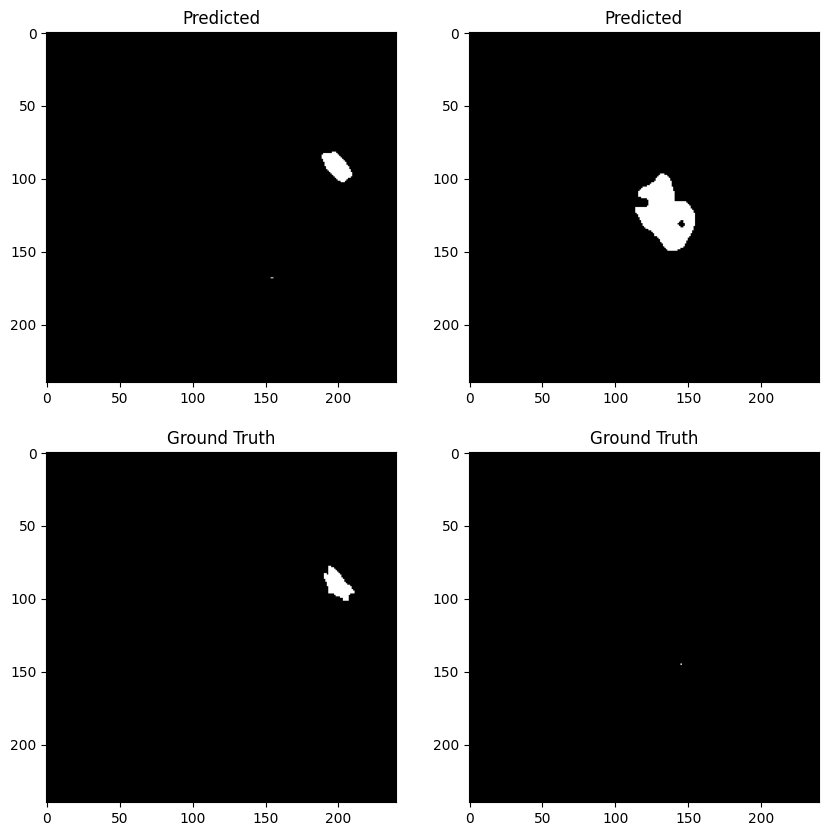

100%|██████████| 136/136 [09:35<00:00,  4.23s/it]



Average Training Loss: 0.007366271646734437

Average Training DSC: [0.99914278 0.88598573 0.93417938 0.75910967]
Average Training ASSD: [ 0.11572586 14.64706026  9.68875917 20.69114152]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


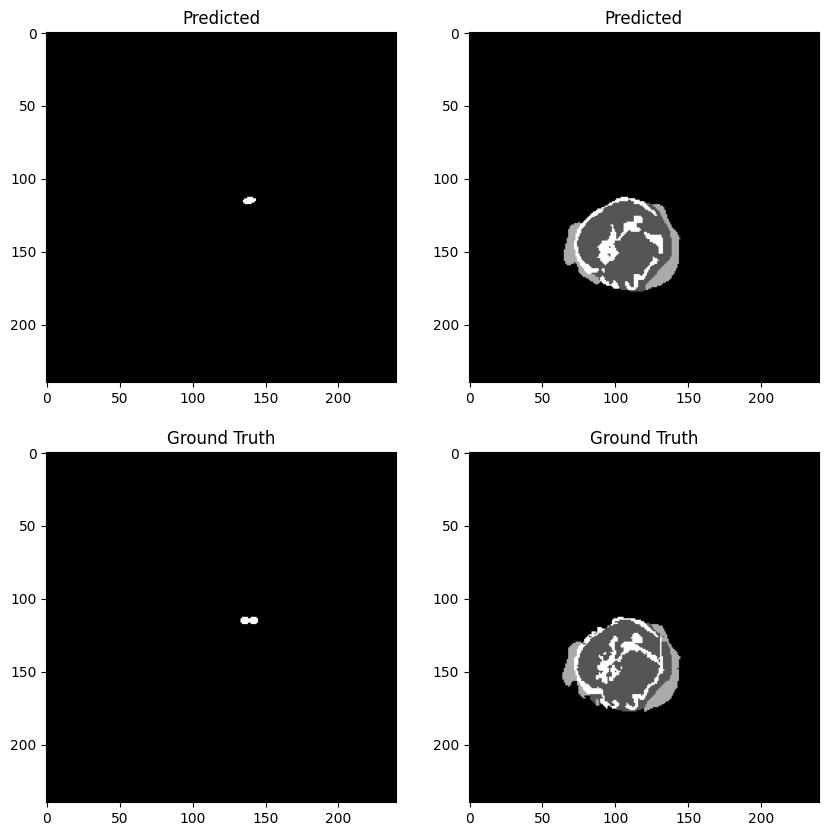

100%|██████████| 34/34 [02:15<00:00,  4.00s/it]


Average Validation Loss: 0.008711883579106891

Average Validation DSC: [0.99907343 0.87506987 0.92097276 0.73847257]
Average Validation ASSD: [ 0.13945984 19.34787139 13.46119054 23.45311004]
Epoch 41/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


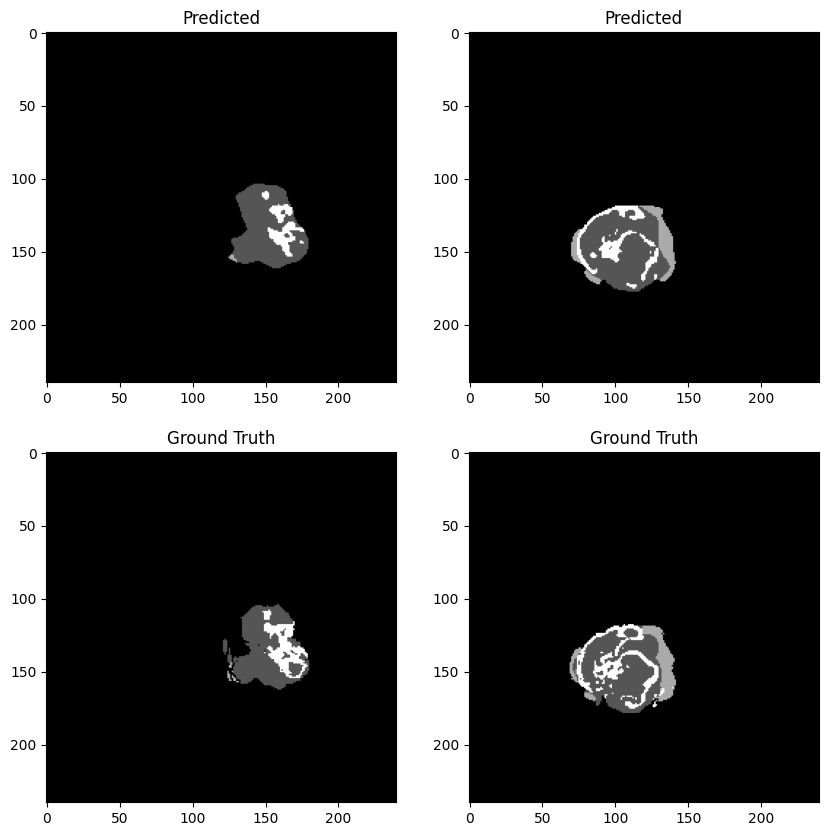

100%|██████████| 136/136 [09:24<00:00,  4.15s/it]



Average Training Loss: 0.006922978236723472

Average Training DSC: [0.9992046  0.89180916 0.93546572 0.76621657]
Average Training ASSD: [ 0.10534793 13.05900689  9.75005398 21.08821162]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


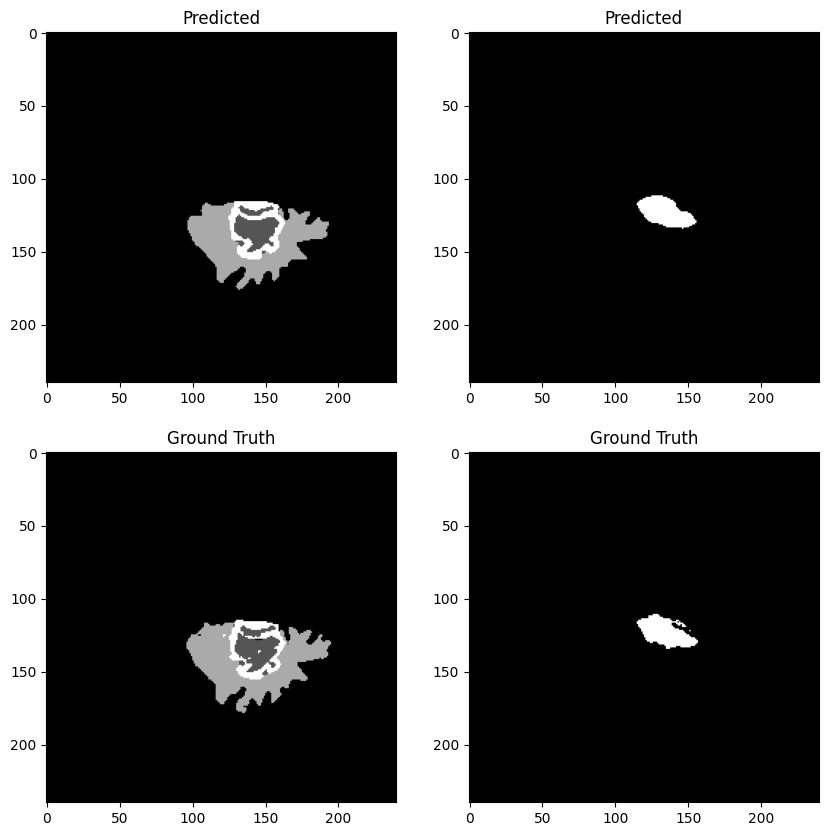

100%|██████████| 34/34 [02:08<00:00,  3.79s/it]


Average Validation Loss: 0.00900044638718314

Average Validation DSC: [0.99899496 0.84868063 0.91786283 0.74794193]
Average Validation ASSD: [ 0.14040065 27.07954255 13.92278746 19.50172553]
Epoch 42/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


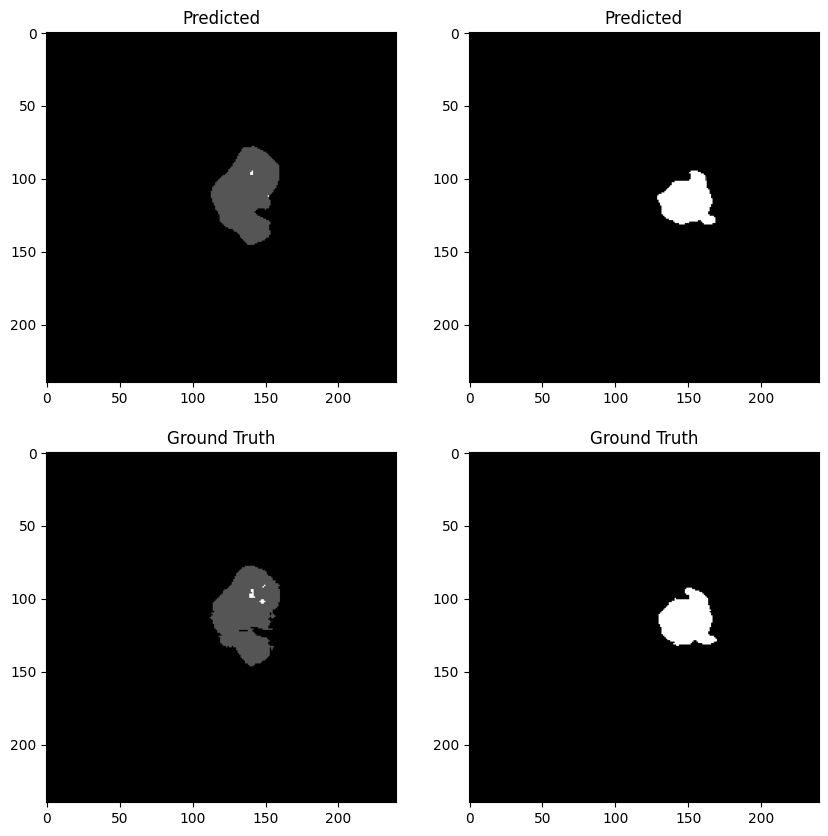

100%|██████████| 136/136 [09:43<00:00,  4.29s/it]



Average Training Loss: 0.007120153808500618

Average Training DSC: [0.99917746 0.88750399 0.92995667 0.76129661]
Average Training ASSD: [ 0.11009891 13.98521386 11.1686847  21.02910553]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


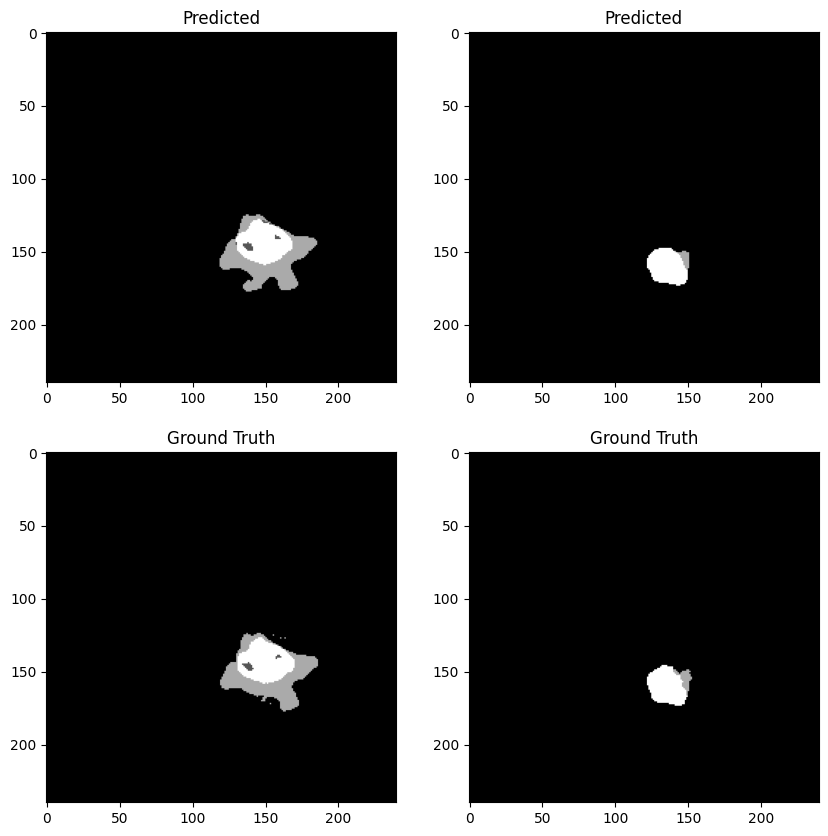

100%|██████████| 34/34 [02:05<00:00,  3.69s/it]


Average Validation Loss: 0.00986028477713904

Average Validation DSC: [0.99898848 0.83063168 0.88048133 0.72272192]
Average Validation ASSD: [ 0.14161403 31.7474965  24.02720735 19.27378082]
Epoch 43/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


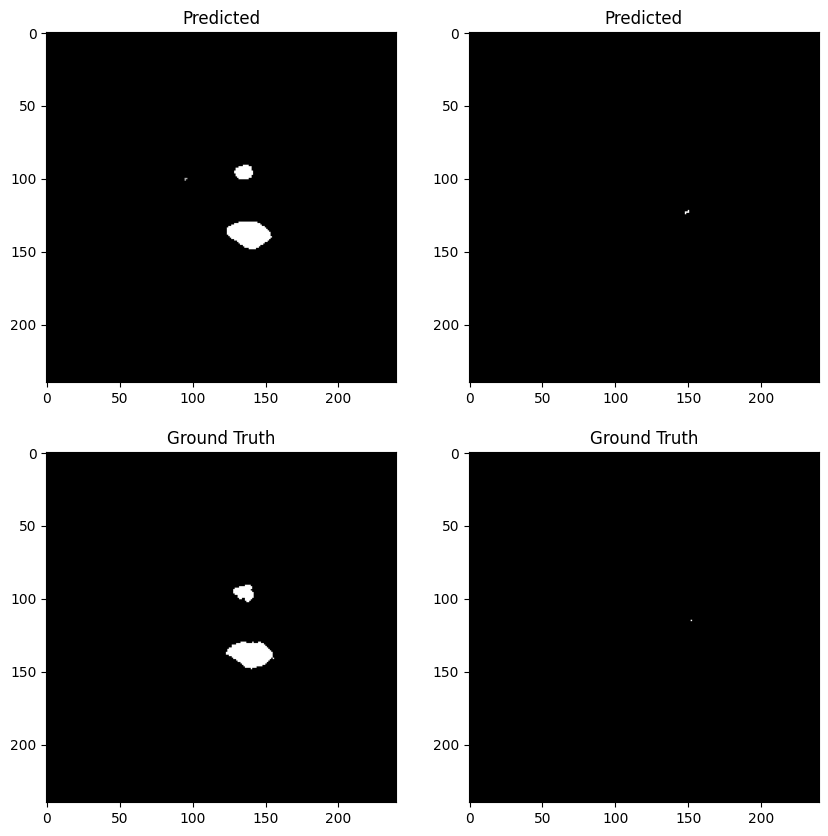

100%|██████████| 136/136 [09:16<00:00,  4.09s/it]



Average Training Loss: 0.0072095560454352595

Average Training DSC: [0.99918706 0.88567819 0.9250041  0.76308963]
Average Training ASSD: [ 0.10908343 14.15350427 12.3546631  20.43135423]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


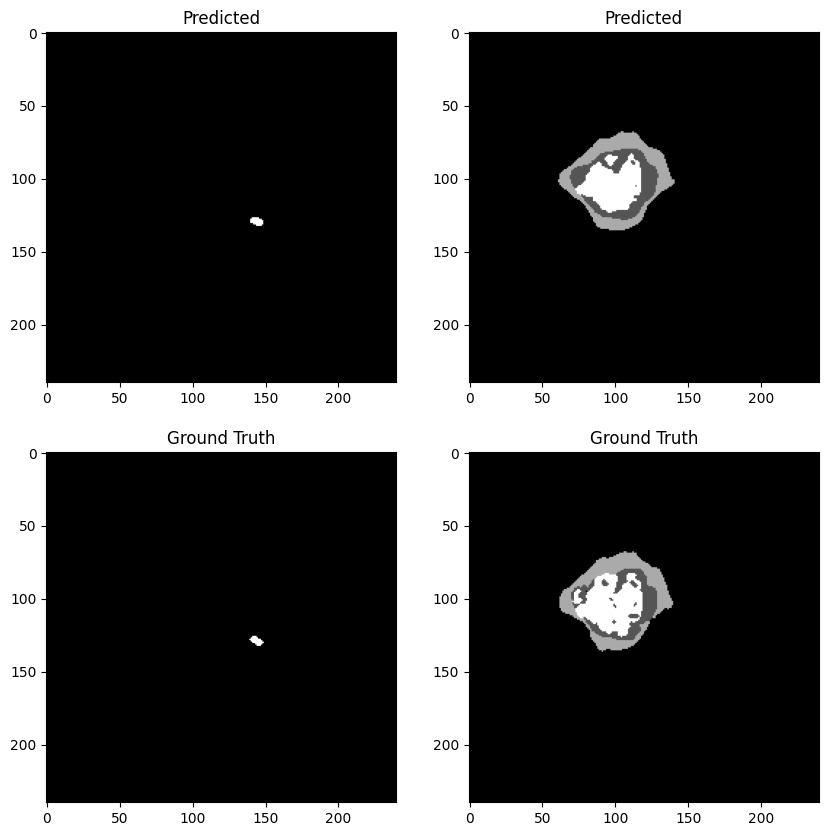

100%|██████████| 34/34 [02:13<00:00,  3.92s/it]


Average Validation Loss: 0.009707218159318846

Average Validation DSC: [0.99904572 0.84686287 0.9174476  0.71186748]
Average Validation ASSD: [ 0.13673695 26.8239815  14.39764814 27.00082877]
Epoch 44/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


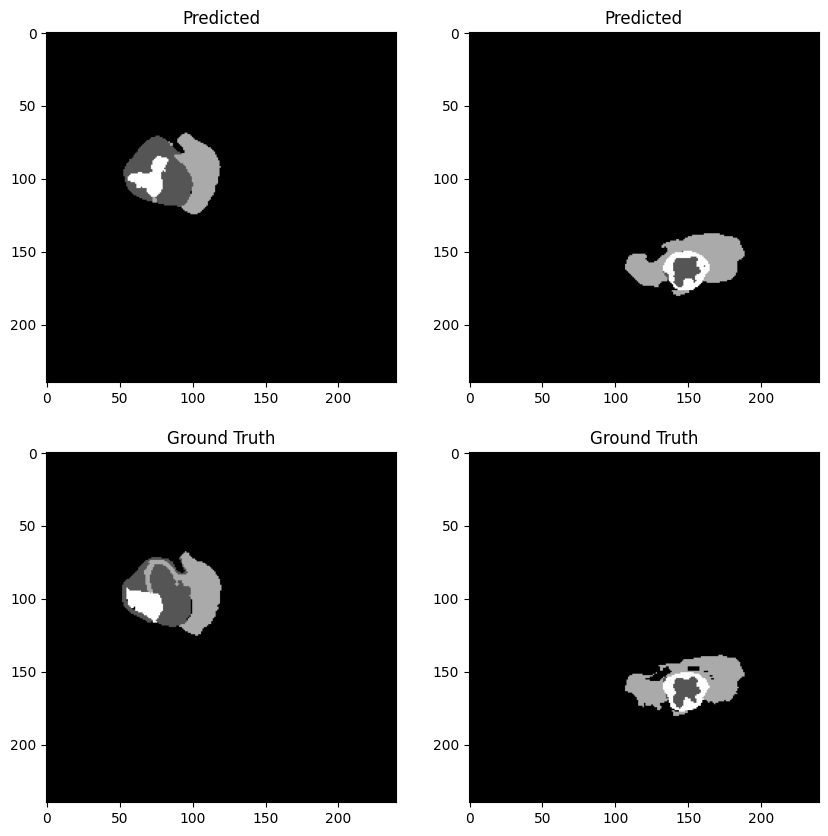

100%|██████████| 136/136 [09:32<00:00,  4.21s/it]



Average Training Loss: 0.007091628007508595

Average Training DSC: [0.99919827 0.88449729 0.93149555 0.76065063]
Average Training ASSD: [ 0.11060011 14.89782177 10.71652845 23.00159664]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


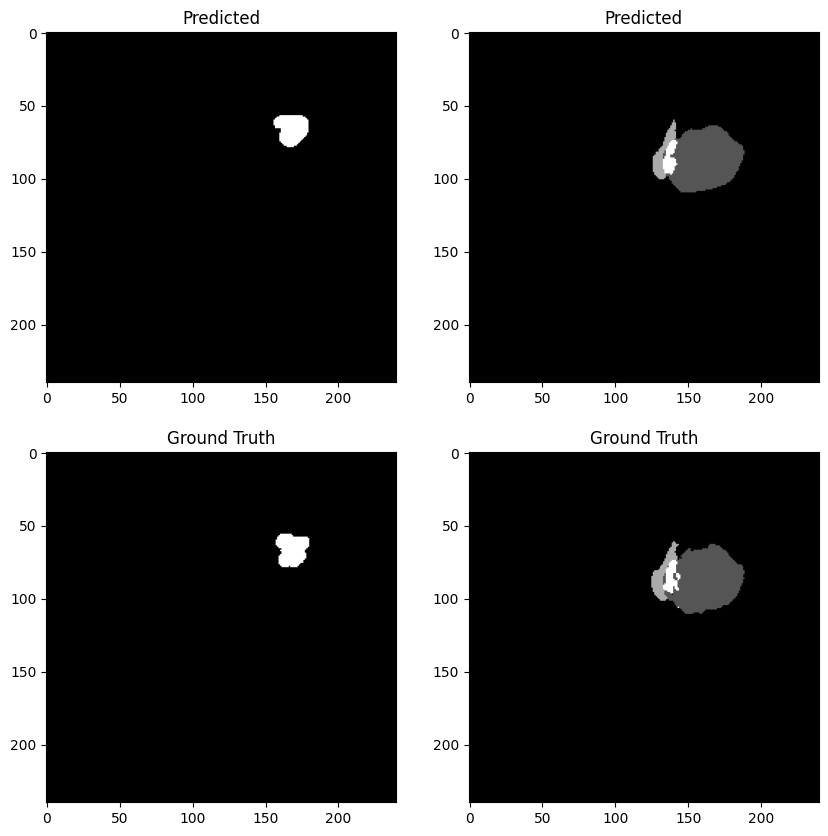

100%|██████████| 34/34 [02:14<00:00,  3.94s/it]


Average Validation Loss: 0.009152609389275312

Average Validation DSC: [0.99897088 0.87134581 0.91770703 0.75287055]
Average Validation ASSD: [ 0.13316834 18.62116198 12.76302664 18.33372076]
Epoch 45/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


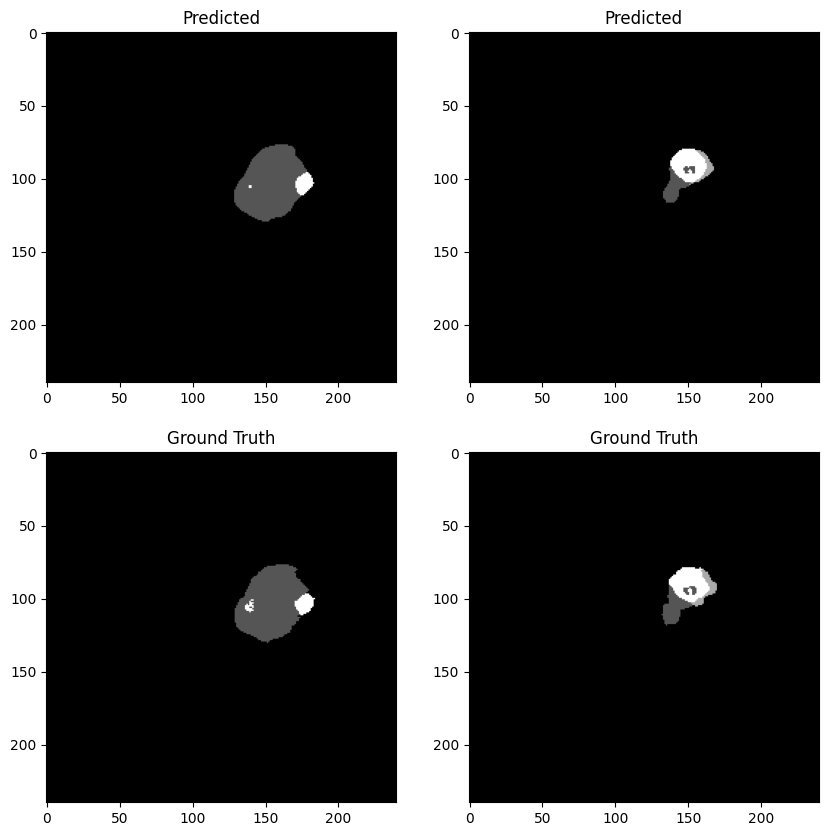

100%|██████████| 136/136 [09:39<00:00,  4.26s/it]



Average Training Loss: 0.0070328615564743385

Average Training DSC: [0.99921185 0.89422429 0.92551566 0.76715943]
Average Training ASSD: [ 0.10886601 12.05097364 12.67137951 20.67693818]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


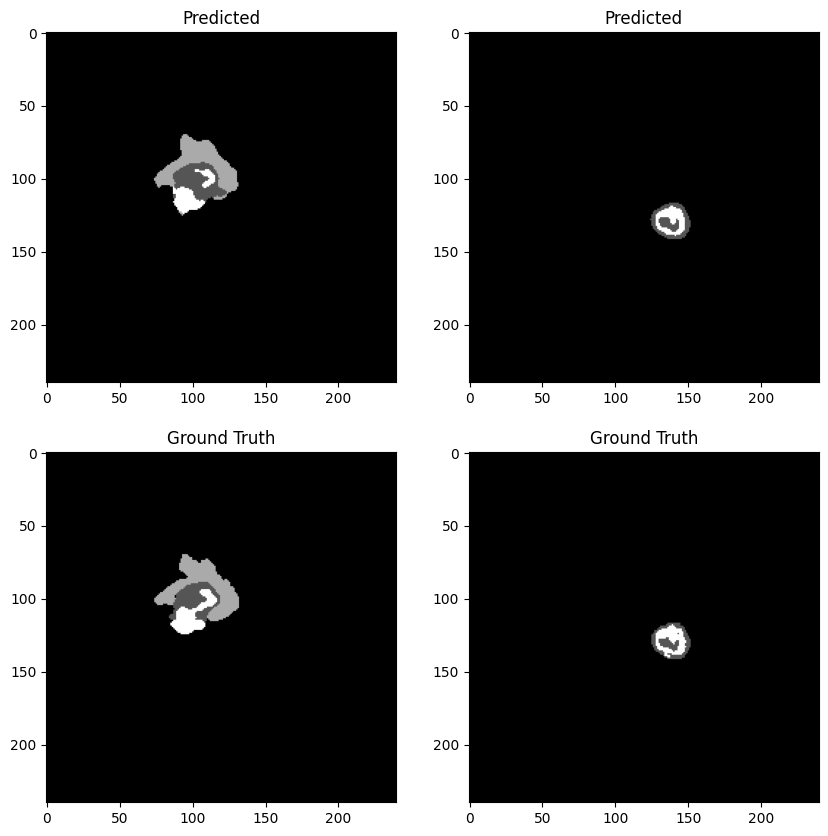

100%|██████████| 34/34 [02:13<00:00,  3.92s/it]


Average Validation Loss: 0.008630824138355605

Average Validation DSC: [0.99907278 0.87829798 0.92736118 0.73103753]
Average Validation ASSD: [ 0.13119174 18.27094834 11.63726951 25.74160668]
Epoch 46/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


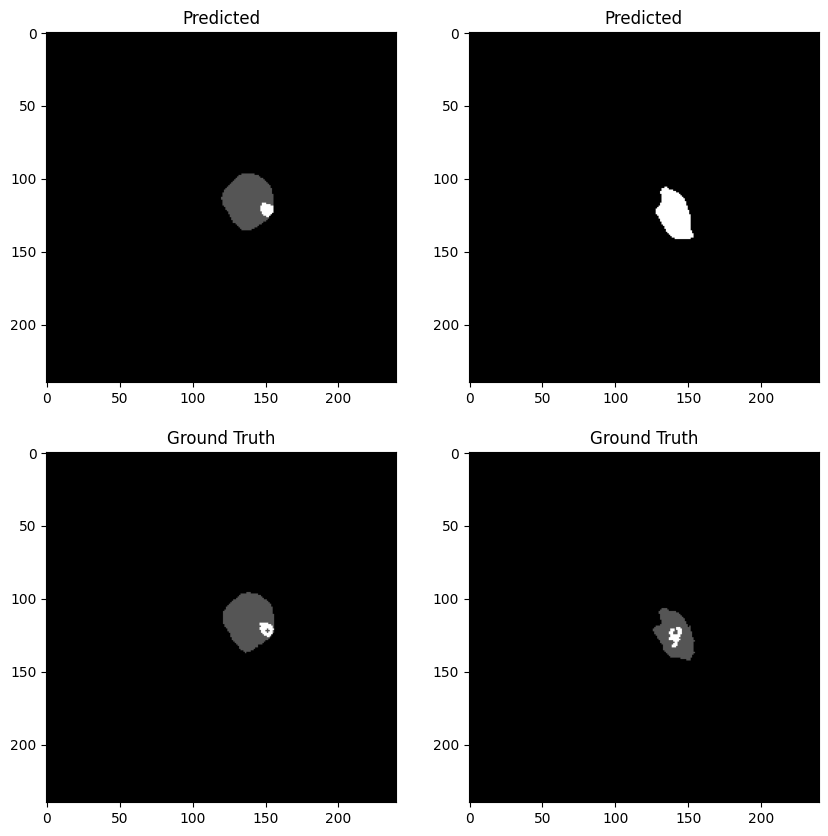

100%|██████████| 136/136 [09:45<00:00,  4.31s/it]



Average Training Loss: 0.006355573856340283

Average Training DSC: [0.99925527 0.90296036 0.94211638 0.78257337]
Average Training ASSD: [ 0.09940017 10.93526249  8.39557506 20.0067052 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


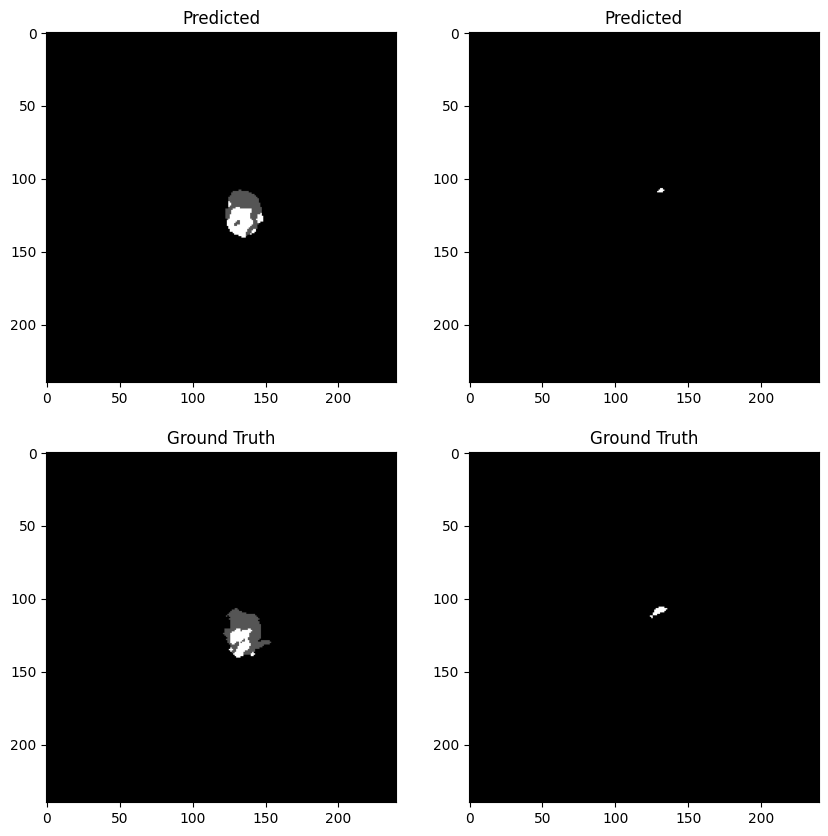

100%|██████████| 34/34 [02:17<00:00,  4.05s/it]


Average Validation Loss: 0.00820790569517104

Average Validation DSC: [0.99913029 0.88017941 0.92988693 0.75428936]
Average Validation ASSD: [ 0.12491378 17.68723847 11.96612278 20.43706435]
Epoch 47/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


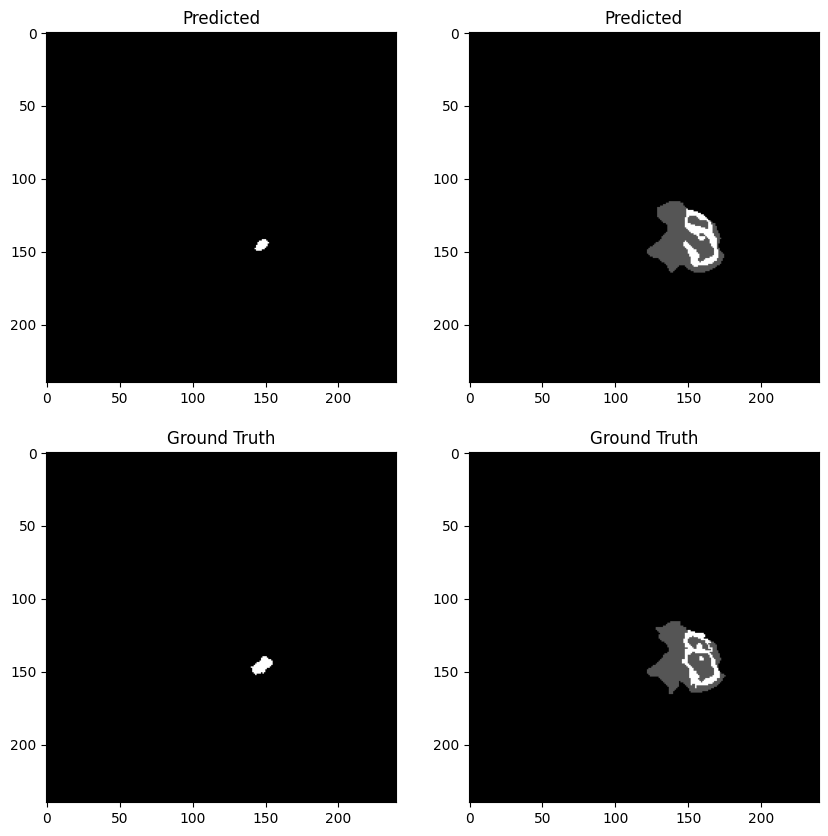

100%|██████████| 136/136 [09:31<00:00,  4.20s/it]



Average Training Loss: 0.006695849052287967

Average Training DSC: [0.99922921 0.89538711 0.93651577 0.77350057]
Average Training ASSD: [ 0.10457817 12.77785329  9.97055856 19.81637469]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


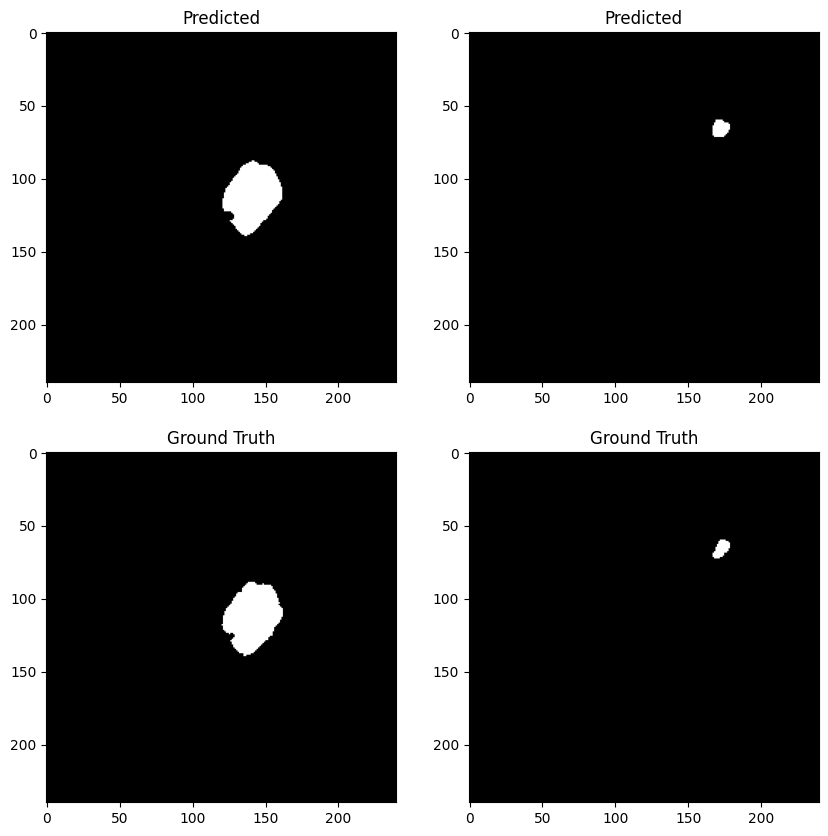

100%|██████████| 34/34 [02:14<00:00,  3.94s/it]


Average Validation Loss: 0.008923305102678783

Average Validation DSC: [0.99904698 0.85240012 0.91174993 0.74028341]
Average Validation ASSD: [ 0.13889025 26.96859852 17.7229955  21.61080388]
Epoch 48/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


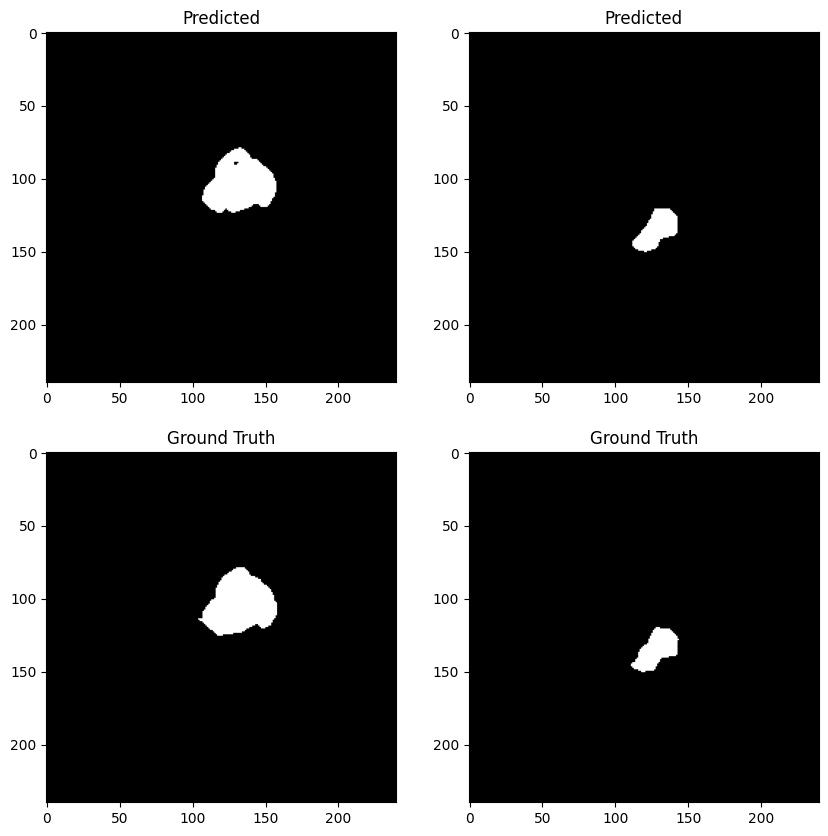

100%|██████████| 136/136 [09:22<00:00,  4.13s/it]



Average Training Loss: 0.006666886288097457

Average Training DSC: [0.99924866 0.89235116 0.94103778 0.77260338]
Average Training ASSD: [ 0.09801162 12.88297726  8.96691568 19.59896831]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


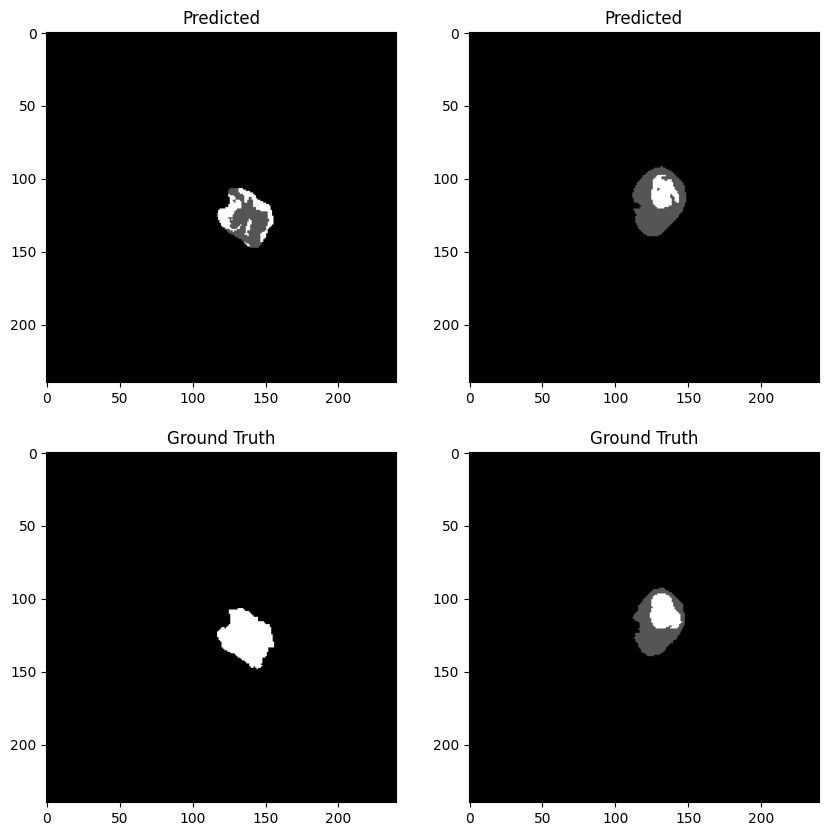

100%|██████████| 34/34 [02:18<00:00,  4.08s/it]


Average Validation Loss: 0.013566843179218909

Average Validation DSC: [0.99888479 0.63300102 0.85945771 0.60955254]
Average Validation ASSD: [ 0.1535973  94.97784864 34.09721558 34.35291718]
Epoch 49/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


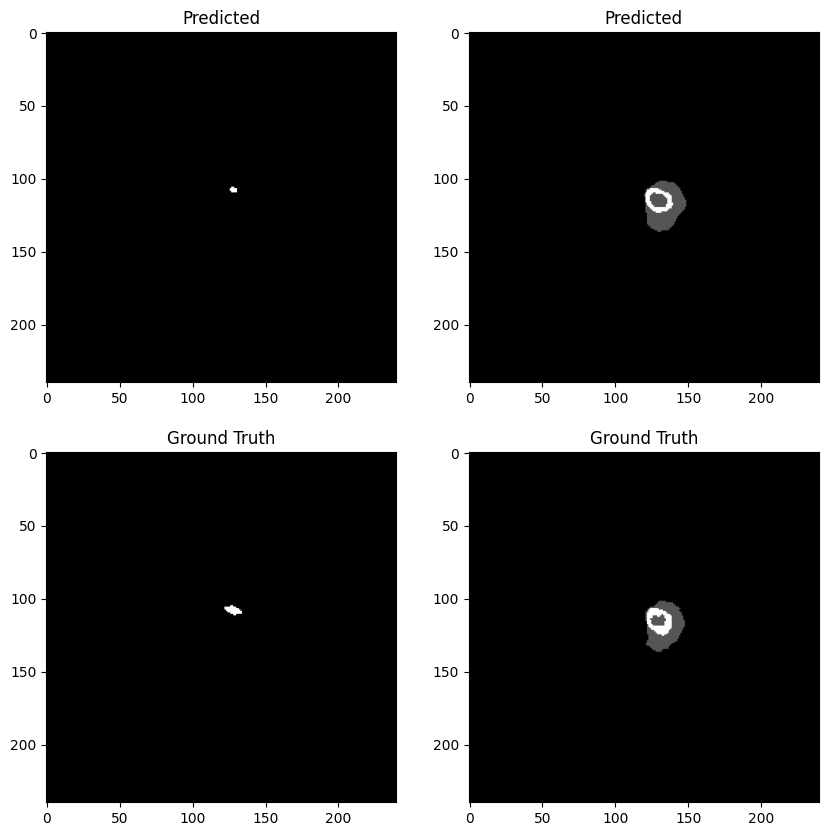

100%|██████████| 136/136 [09:32<00:00,  4.21s/it]



Average Training Loss: 0.009522491062799579

Average Training DSC: [0.99896143 0.83901129 0.90792563 0.71566669]
Average Training ASSD: [ 0.16686128 26.41542689 17.1601     24.5686817 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


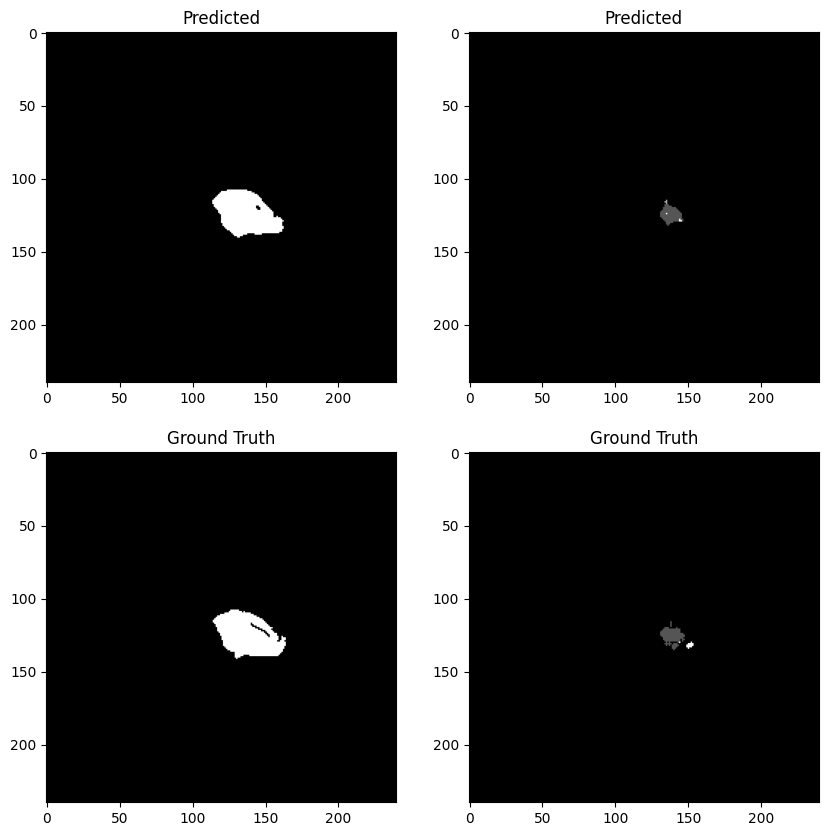

100%|██████████| 34/34 [02:09<00:00,  3.80s/it]


Average Validation Loss: 0.00929342202075264

Average Validation DSC: [0.99908761 0.84785721 0.89182977 0.74635416]
Average Validation ASSD: [ 0.13683632 23.83768356 23.70232328 20.9571087 ]
Epoch 50/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


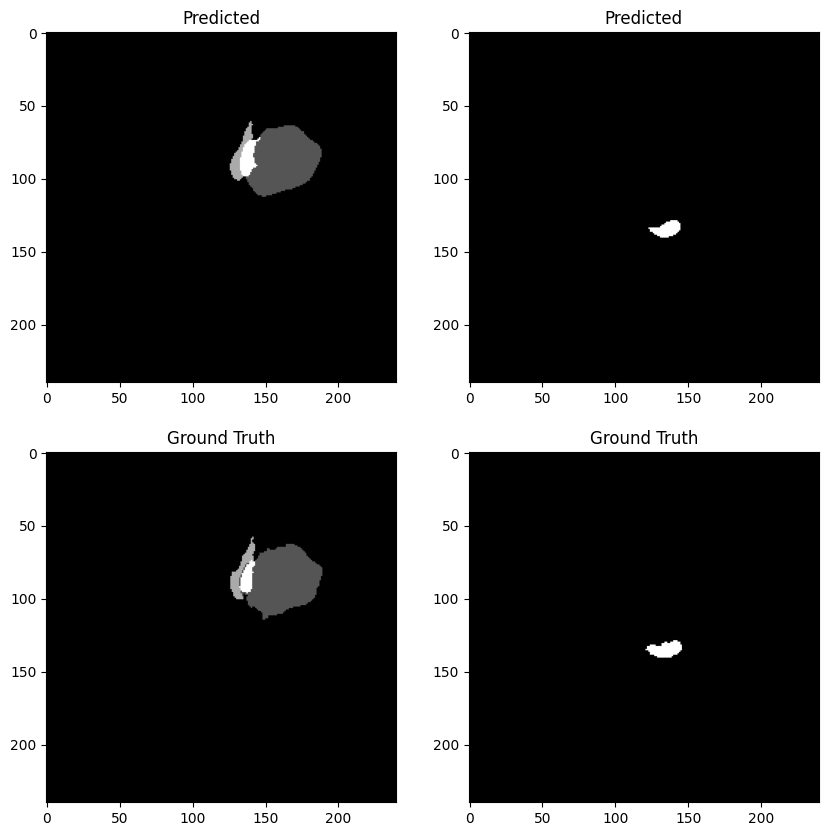

100%|██████████| 136/136 [09:42<00:00,  4.28s/it]



Average Training Loss: 0.0070482905532973

Average Training DSC: [0.99922041 0.88311492 0.93634347 0.76877238]
Average Training ASSD: [ 0.10781785 15.96981814  9.57517194 20.8316077 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


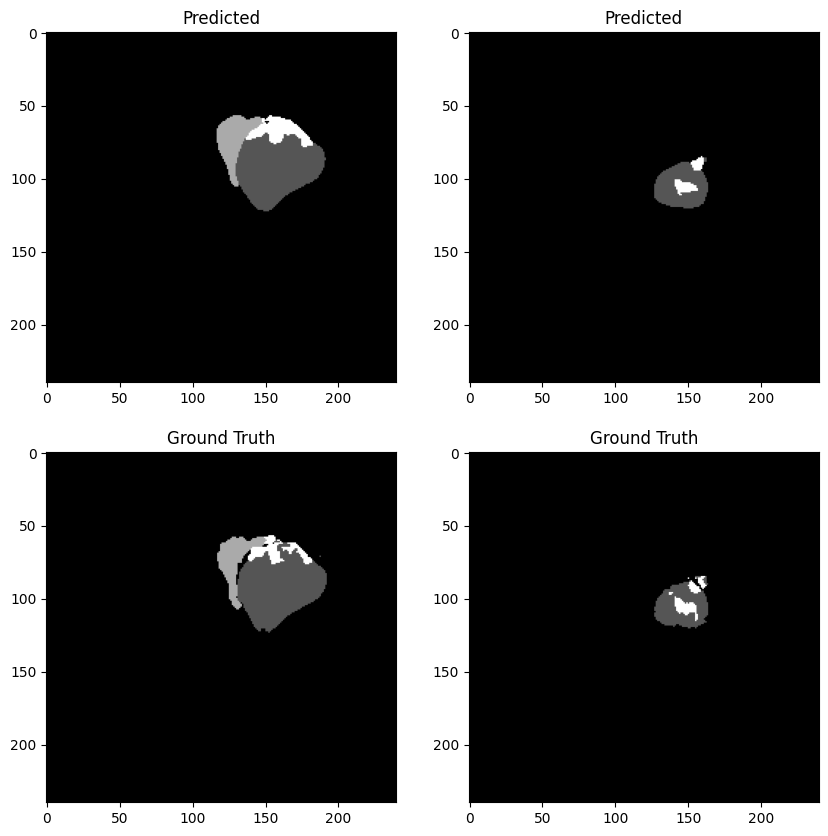

100%|██████████| 34/34 [02:14<00:00,  3.96s/it]


Average Validation Loss: 0.00837350620285553

Average Validation DSC: [0.99911909 0.86767434 0.9262833  0.74535987]
Average Validation ASSD: [ 0.11469809 22.91077006 12.41639019 18.5624325 ]
Epoch 51/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


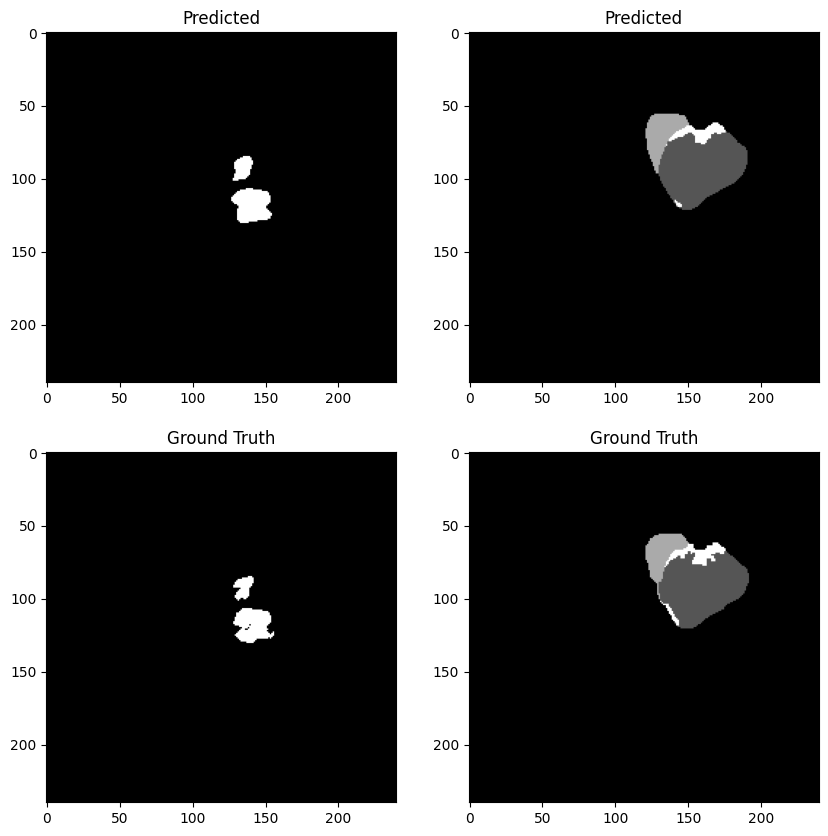

100%|██████████| 136/136 [09:36<00:00,  4.24s/it]



Average Training Loss: 0.006178645850227708

Average Training DSC: [0.99930401 0.90694308 0.944764   0.79155162]
Average Training ASSD: [ 0.09399945 10.00869889  7.79544999 18.62448267]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


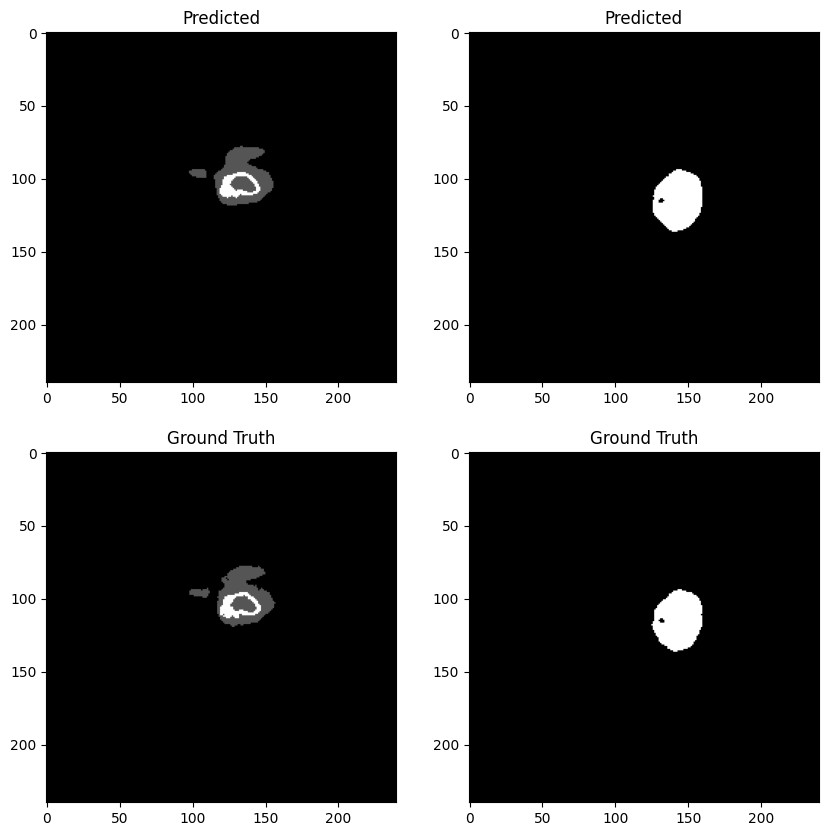

100%|██████████| 34/34 [02:17<00:00,  4.05s/it]


Average Validation Loss: 0.008274116156184497

Average Validation DSC: [0.99913848 0.8812249  0.91834873 0.7581352 ]
Average Validation ASSD: [ 0.12412831 19.3640815  15.05993494 18.62416795]
Epoch 52/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


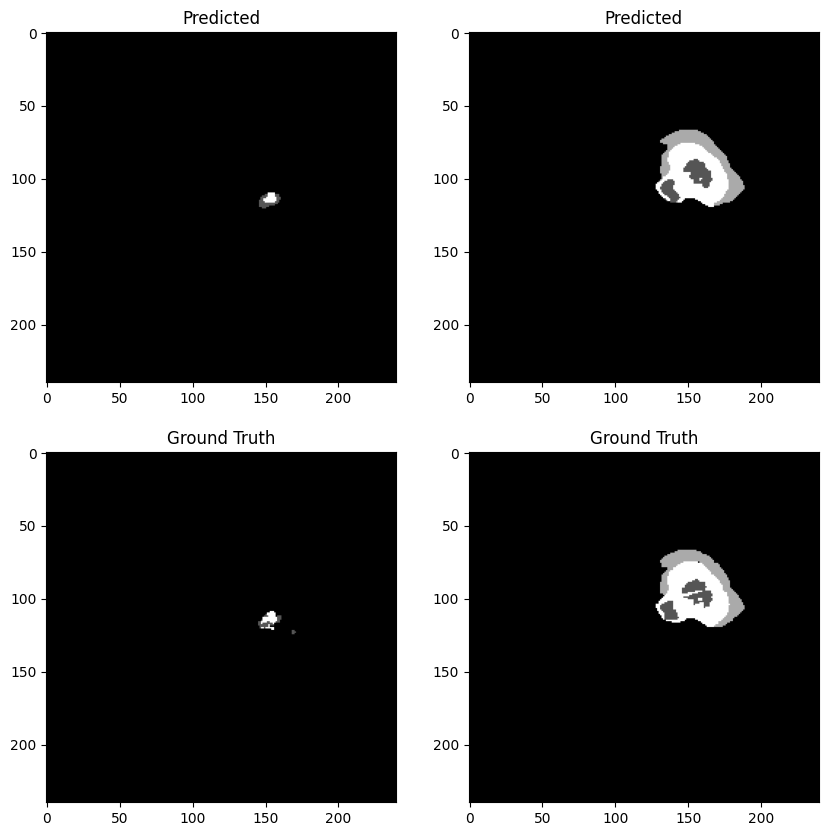

100%|██████████| 136/136 [09:25<00:00,  4.16s/it]



Average Training Loss: 0.005954993652481148

Average Training DSC: [0.9993184  0.91078712 0.94697092 0.79420886]
Average Training ASSD: [ 0.09267627  9.65801258  7.70680206 19.82740309]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


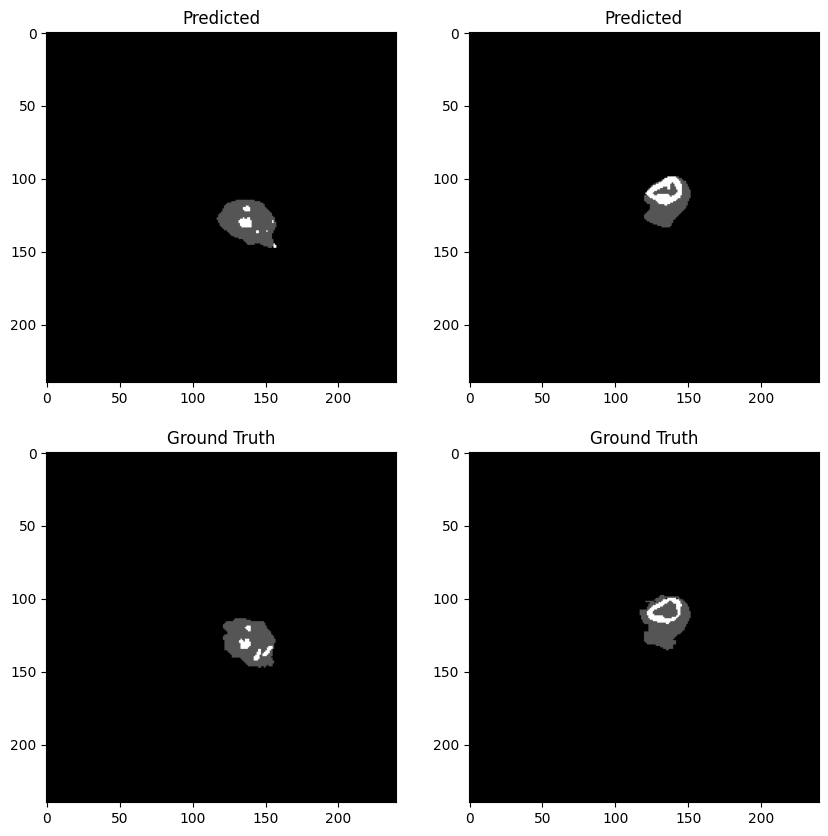

100%|██████████| 34/34 [02:16<00:00,  4.01s/it]


Average Validation Loss: 0.008368913741672741

Average Validation DSC: [0.99909631 0.87175087 0.90851302 0.76590184]
Average Validation ASSD: [ 0.12445454 20.24323272 18.15367426 17.07151722]
Epoch 53/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


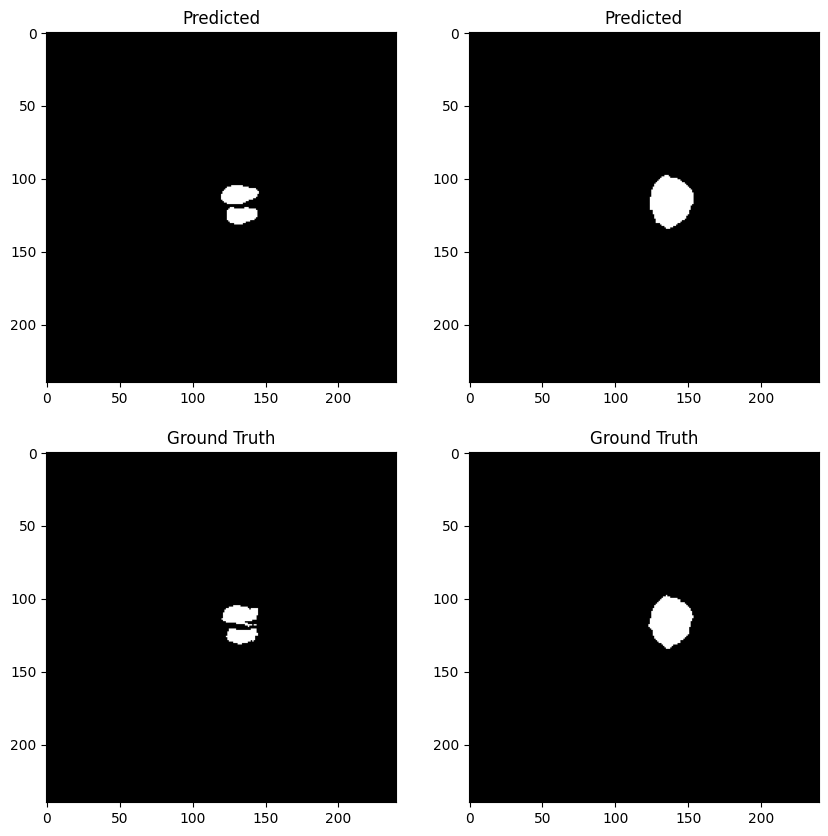

100%|██████████| 136/136 [09:25<00:00,  4.16s/it]



Average Training Loss: 0.005934422003680512

Average Training DSC: [0.99933329 0.90702886 0.94349623 0.7949287 ]
Average Training ASSD: [ 0.09298419 10.66498491  8.55815867 19.65619417]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


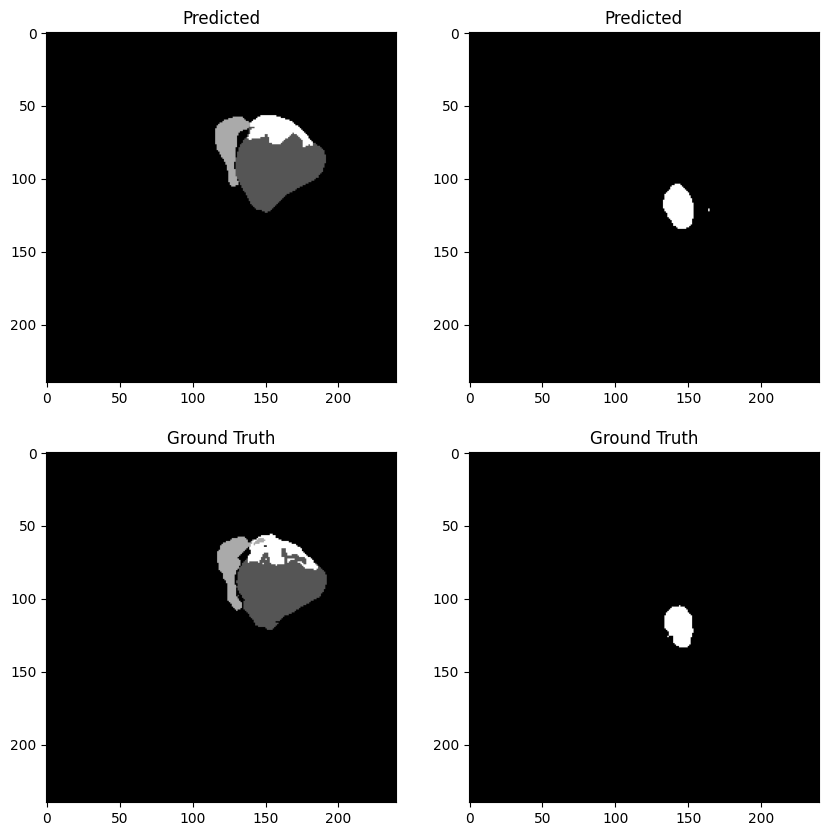

100%|██████████| 34/34 [02:13<00:00,  3.92s/it]


Average Validation Loss: 0.007953737917191842

Average Validation DSC: [0.99918246 0.87931423 0.94042747 0.77598285]
Average Validation ASSD: [ 0.10585274 19.14331689  8.95175285 13.6670556 ]
Epoch 54/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


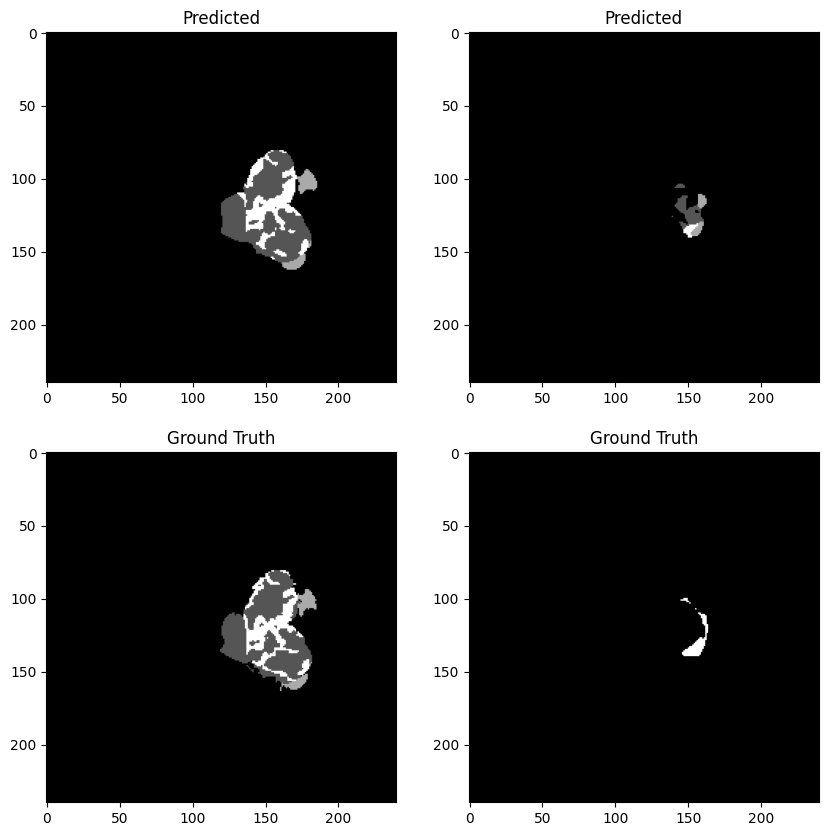

100%|██████████| 136/136 [09:43<00:00,  4.29s/it]



Average Training Loss: 0.005798785041620517

Average Training DSC: [0.99934075 0.90986696 0.94648511 0.79864361]
Average Training ASSD: [ 0.08511028 10.15216745  7.7019953  17.99503288]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


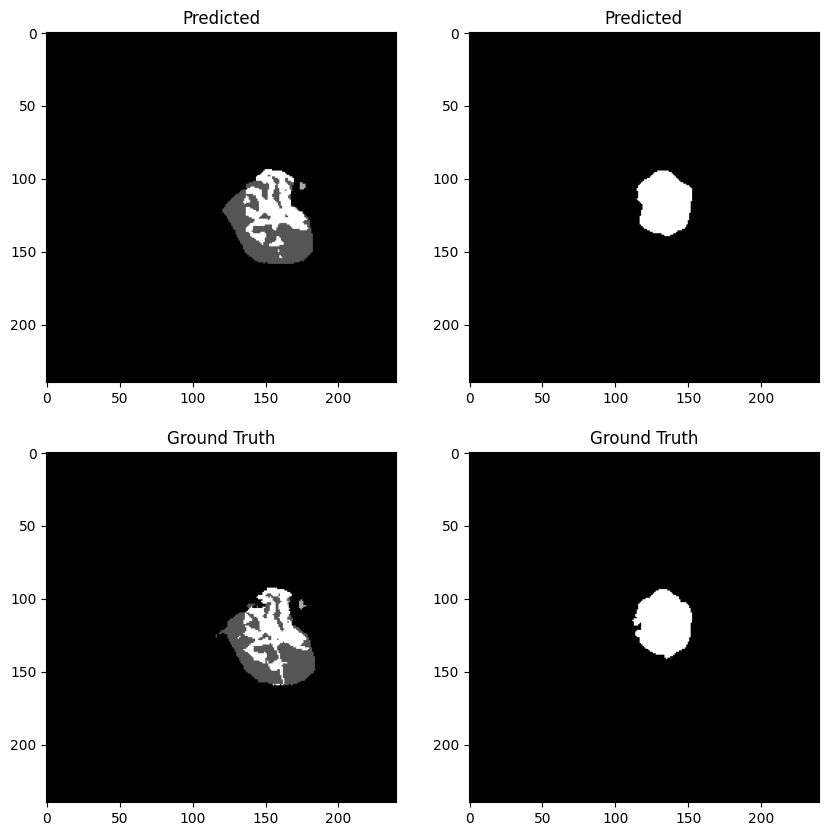

100%|██████████| 34/34 [02:10<00:00,  3.85s/it]


Average Validation Loss: 0.008418947362395771

Average Validation DSC: [0.99911097 0.87925225 0.92901775 0.74856951]
Average Validation ASSD: [ 0.12826865 18.22478743 11.44770906 26.12582894]
Epoch 55/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


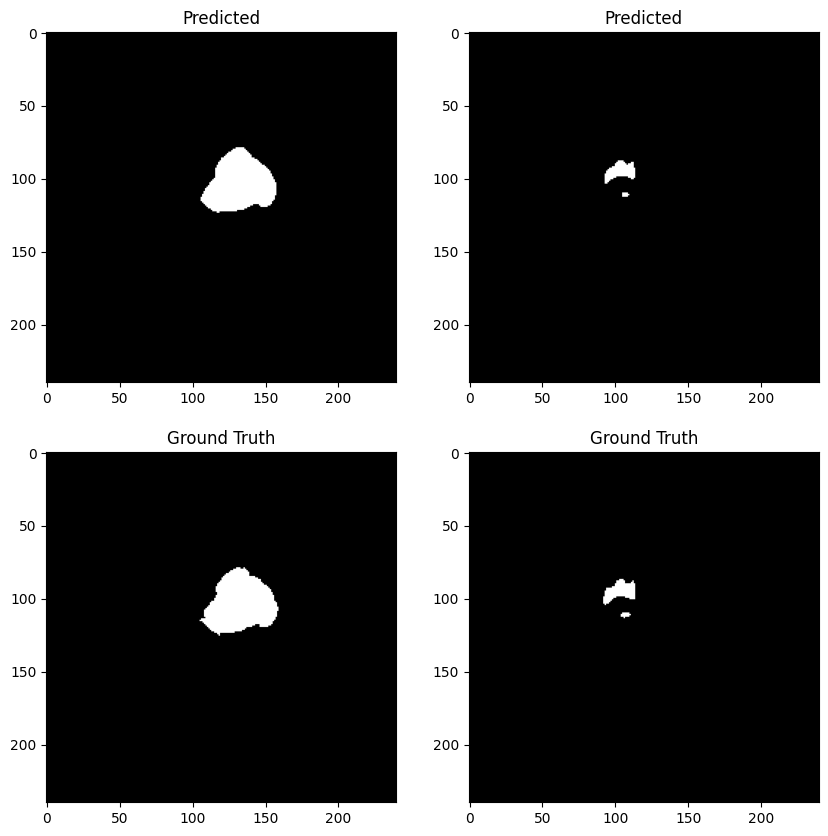

100%|██████████| 136/136 [09:31<00:00,  4.20s/it]



Average Training Loss: 0.005721619229435045

Average Training DSC: [0.99936621 0.913745   0.94831597 0.79991679]
Average Training ASSD: [ 0.08216135  8.89872048  7.52714721 19.50397656]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


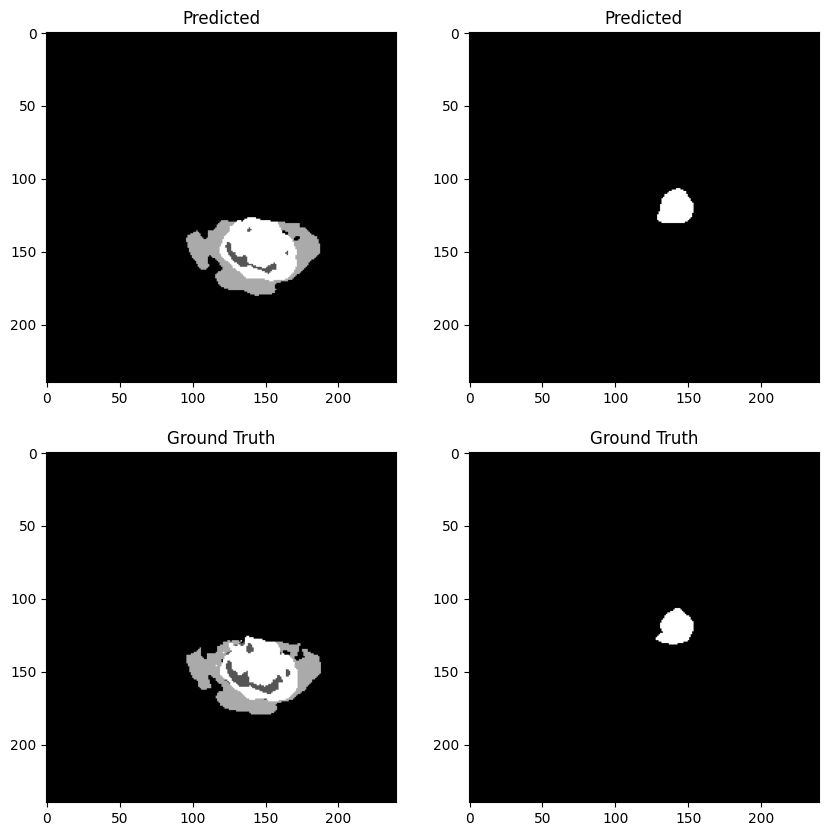

100%|██████████| 34/34 [02:12<00:00,  3.90s/it]


Average Validation Loss: 0.009497424094554256

Average Validation DSC: [0.99911528 0.84915208 0.93057527 0.75835947]
Average Validation ASSD: [ 0.11086847 16.94008754 10.56351672 13.49385732]
Epoch 56/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


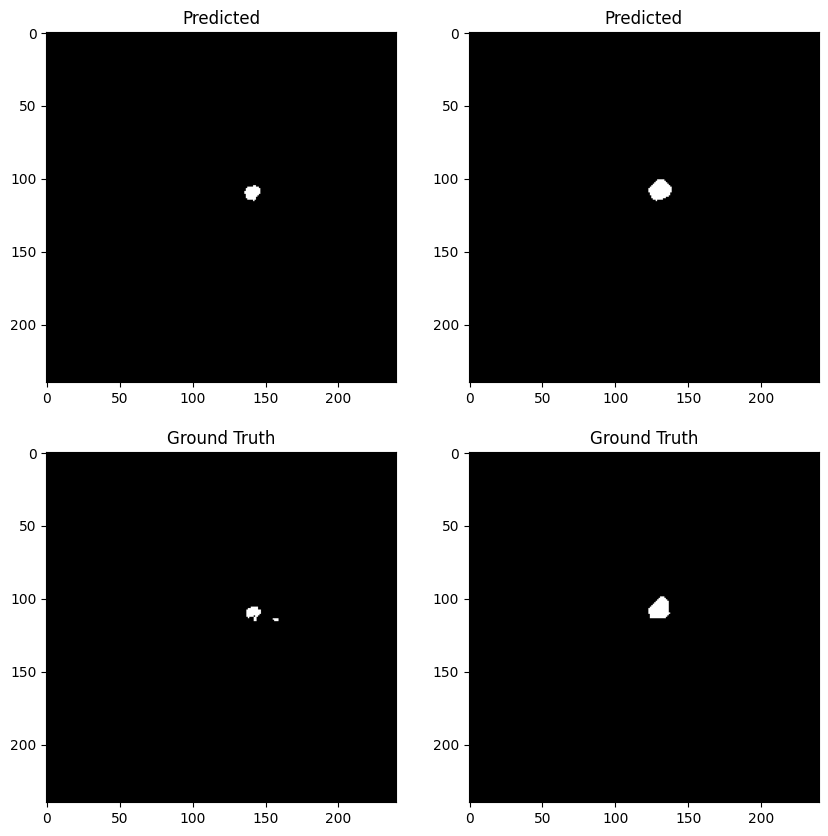

100%|██████████| 136/136 [09:29<00:00,  4.19s/it]



Average Training Loss: 0.006635303213603466

Average Training DSC: [0.99928206 0.89463068 0.93572258 0.78116598]
Average Training ASSD: [ 0.09715087 12.5479605  10.40943818 20.14643009]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


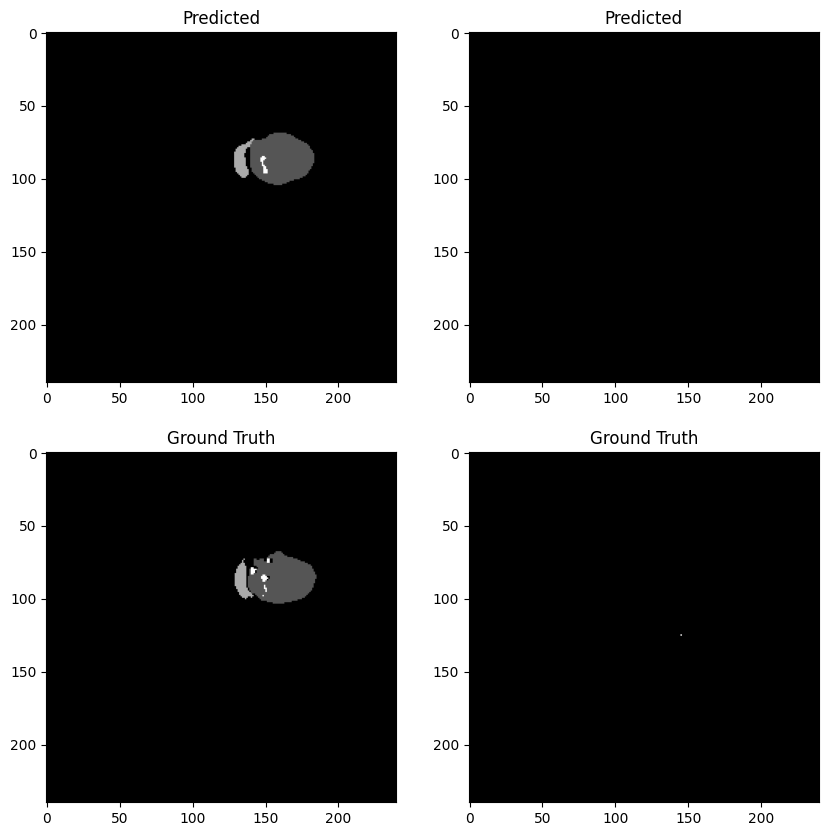

100%|██████████| 34/34 [02:13<00:00,  3.94s/it]


Average Validation Loss: 0.007794778520131812

Average Validation DSC: [0.99920077 0.8857411  0.93740101 0.78527511]
Average Validation ASSD: [ 0.10244226 17.45229402 10.29535186 15.01969012]
Epoch 57/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


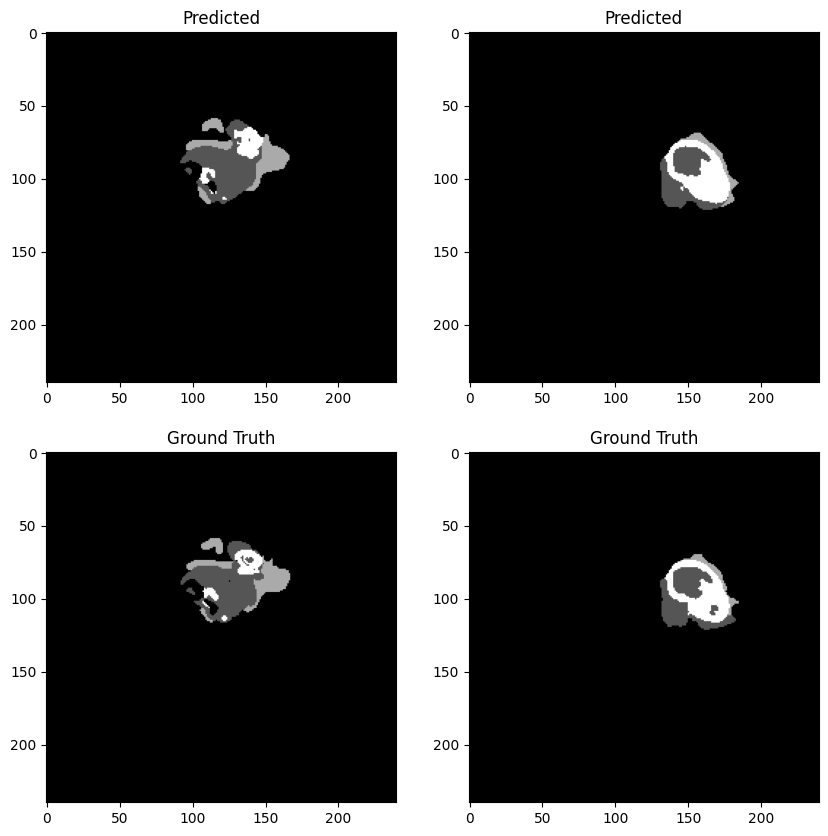

100%|██████████| 136/136 [09:23<00:00,  4.14s/it]



Average Training Loss: 0.005707277276087552

Average Training DSC: [0.99935764 0.91463466 0.9473681  0.80501492]
Average Training ASSD: [ 0.08353702  8.40857016  7.44046197 17.94439735]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


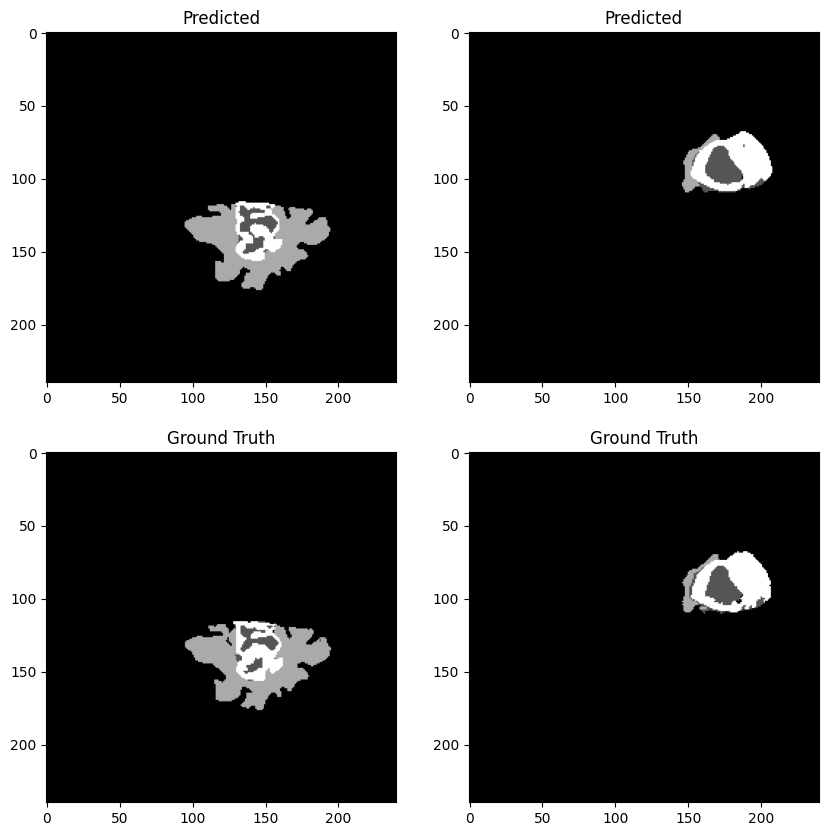

100%|██████████| 34/34 [02:10<00:00,  3.84s/it]


Average Validation Loss: 0.00823541174587958

Average Validation DSC: [0.99921814 0.86482629 0.92510794 0.75754116]
Average Validation ASSD: [ 0.10248893 23.40499332 13.89418901 18.88393333]
Epoch 58/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


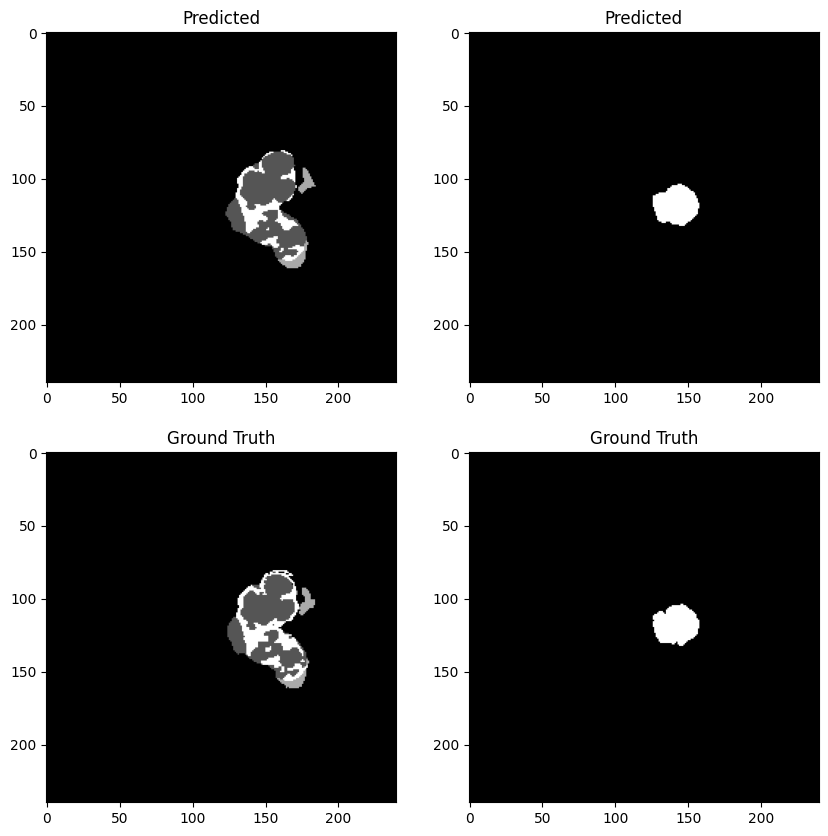

100%|██████████| 136/136 [09:15<00:00,  4.08s/it]



Average Training Loss: 0.0053350470107569195

Average Training DSC: [0.99940573 0.92113907 0.95519629 0.81316276]
Average Training ASSD: [ 0.07900285  7.4610866   5.5250432  16.74805326]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


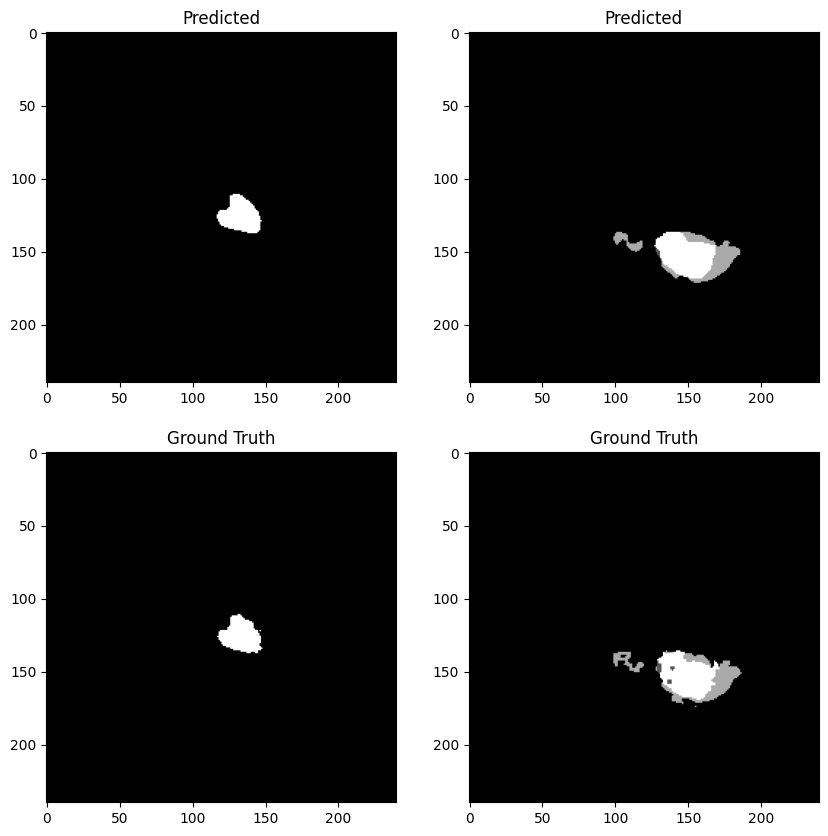

100%|██████████| 34/34 [02:10<00:00,  3.85s/it]


Average Validation Loss: 0.007561772281084867

Average Validation DSC: [0.99924626 0.88181554 0.92628113 0.78594489]
Average Validation ASSD: [ 0.10049786 17.49687533 13.62957913 14.77001355]
Epoch 59/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


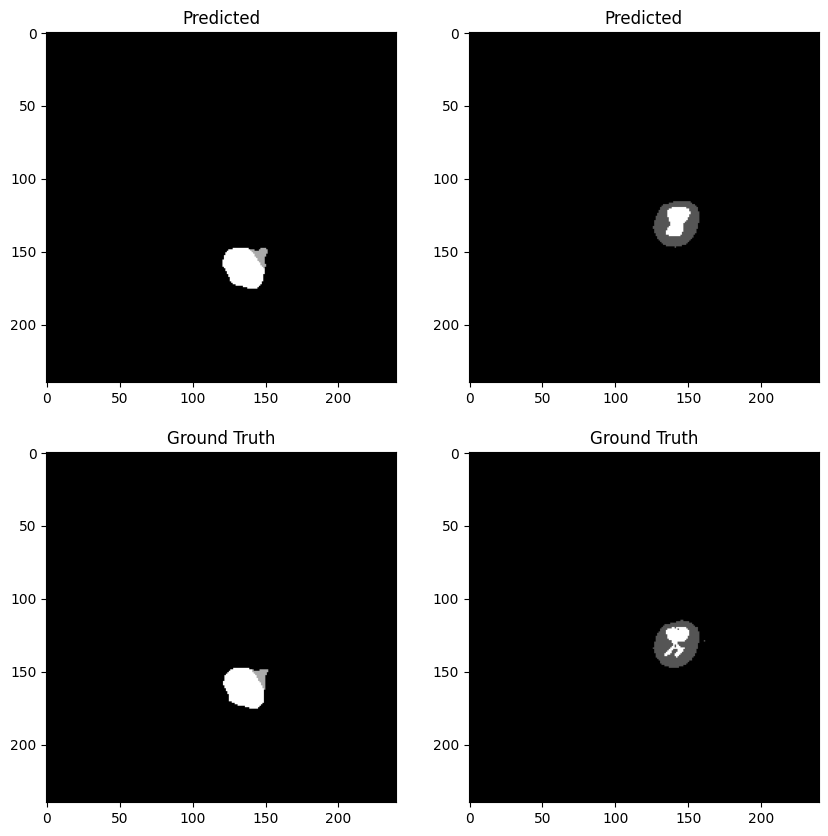

100%|██████████| 136/136 [09:17<00:00,  4.10s/it]



Average Training Loss: 0.005392631296725834

Average Training DSC: [0.99938943 0.92128035 0.95109845 0.81129845]
Average Training ASSD: [ 0.07955688  7.62373125  6.68896484 17.24046311]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


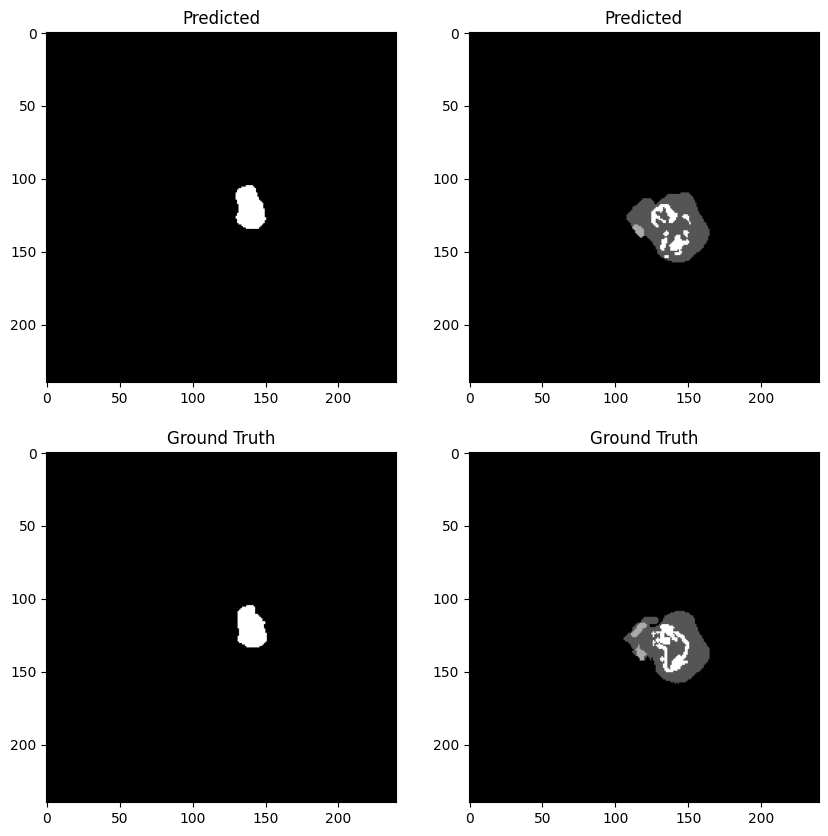

100%|██████████| 34/34 [02:06<00:00,  3.72s/it]


Average Validation Loss: 0.008563330547664972

Average Validation DSC: [0.9991028  0.88812182 0.92205    0.76669849]
Average Validation ASSD: [ 0.11970466 15.82443897 12.28453008 19.21065556]
Epoch 60/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


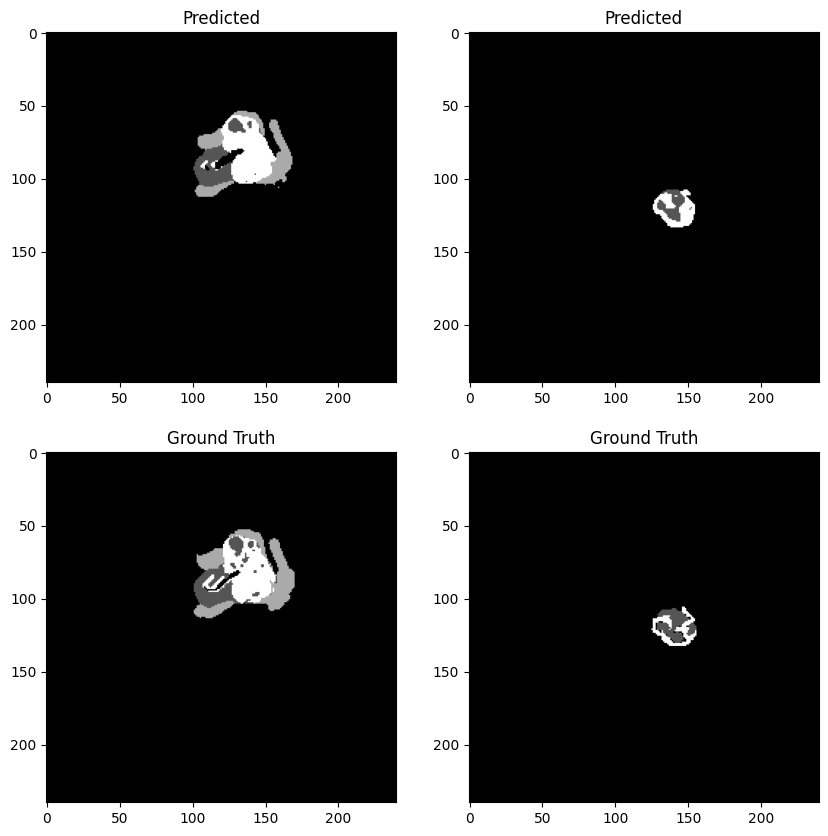

100%|██████████| 136/136 [09:01<00:00,  3.98s/it]



Average Training Loss: 0.005831552698509768

Average Training DSC: [0.99936583 0.90300805 0.93887535 0.80019405]
Average Training ASSD: [ 0.08213718 12.80536602 10.37579665 18.96856528]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


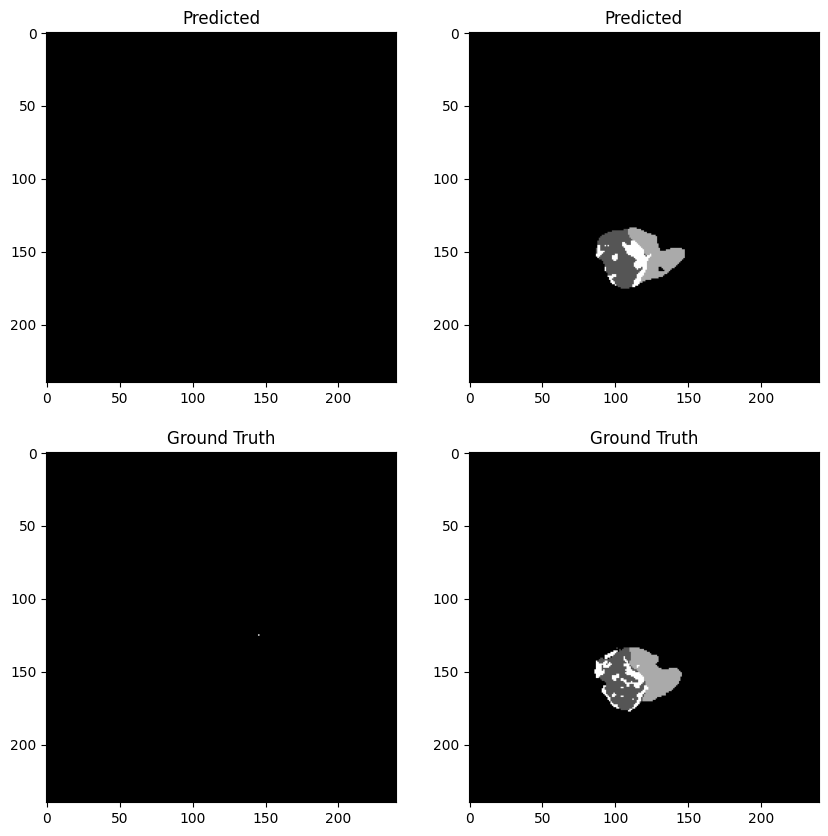

100%|██████████| 34/34 [02:07<00:00,  3.74s/it]


Average Validation Loss: 0.008635774063056005

Average Validation DSC: [0.9991516  0.86245727 0.92899902 0.73775364]
Average Validation ASSD: [ 0.11907678 25.70997775 12.62222779 29.93773048]
Epoch 61/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


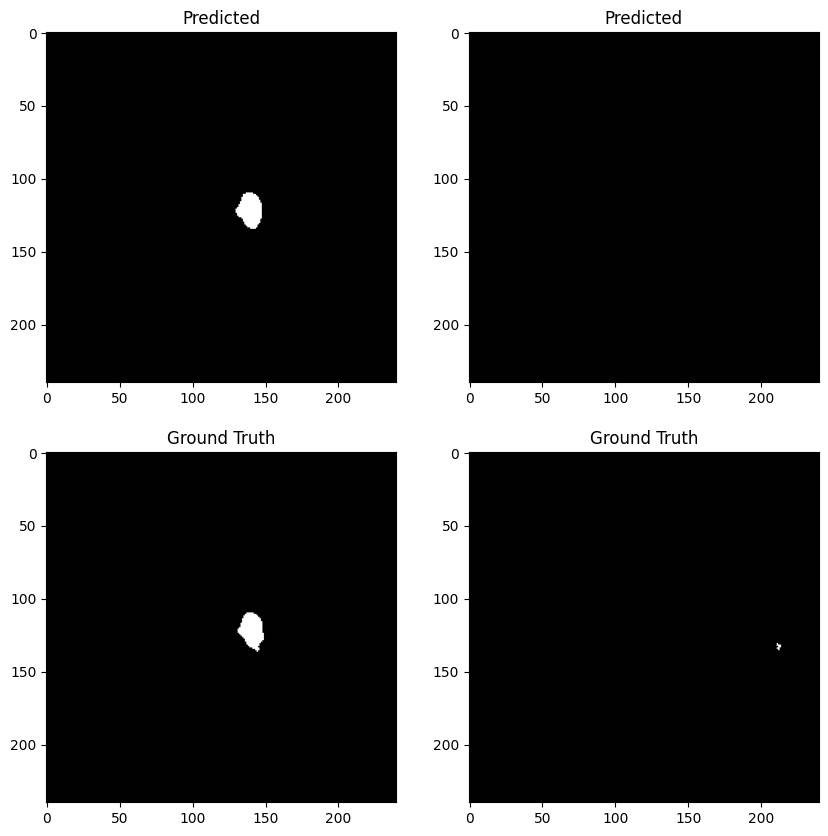

100%|██████████| 136/136 [09:03<00:00,  4.00s/it]



Average Training Loss: 0.005348873287028468

Average Training DSC: [0.99939232 0.91733831 0.95137521 0.80788313]
Average Training ASSD: [ 0.08044338  8.70631576  6.35232624 18.49023127]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


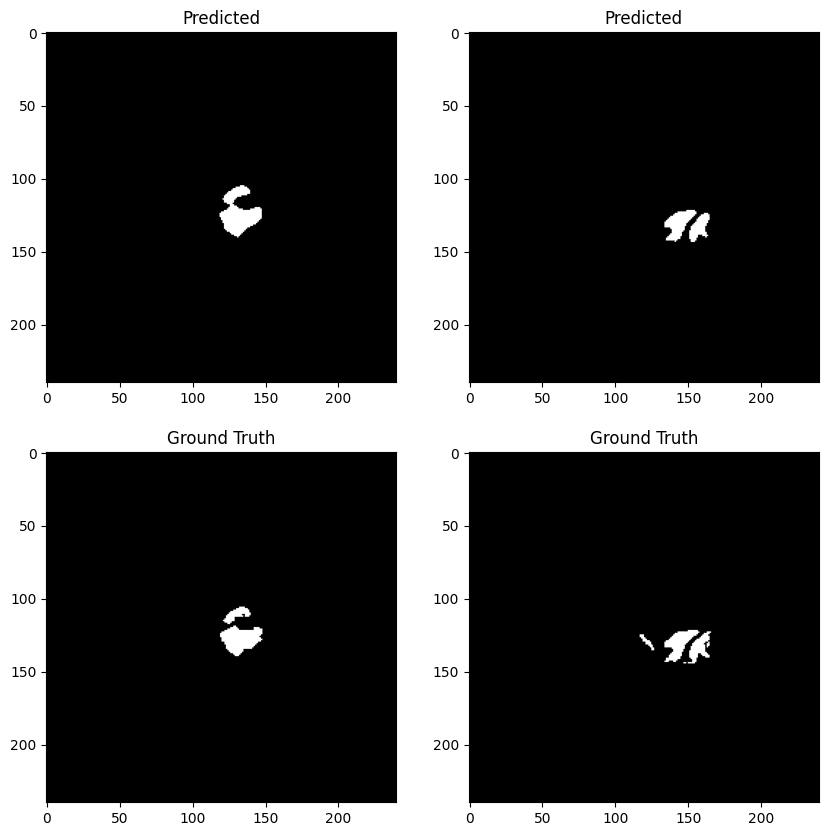

100%|██████████| 34/34 [02:06<00:00,  3.72s/it]


Average Validation Loss: 0.008187432102311184

Average Validation DSC: [0.9991618  0.87354043 0.90847202 0.77773521]
Average Validation ASSD: [ 0.11243671 20.81905063 18.97973174 11.34435091]
Epoch 62/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


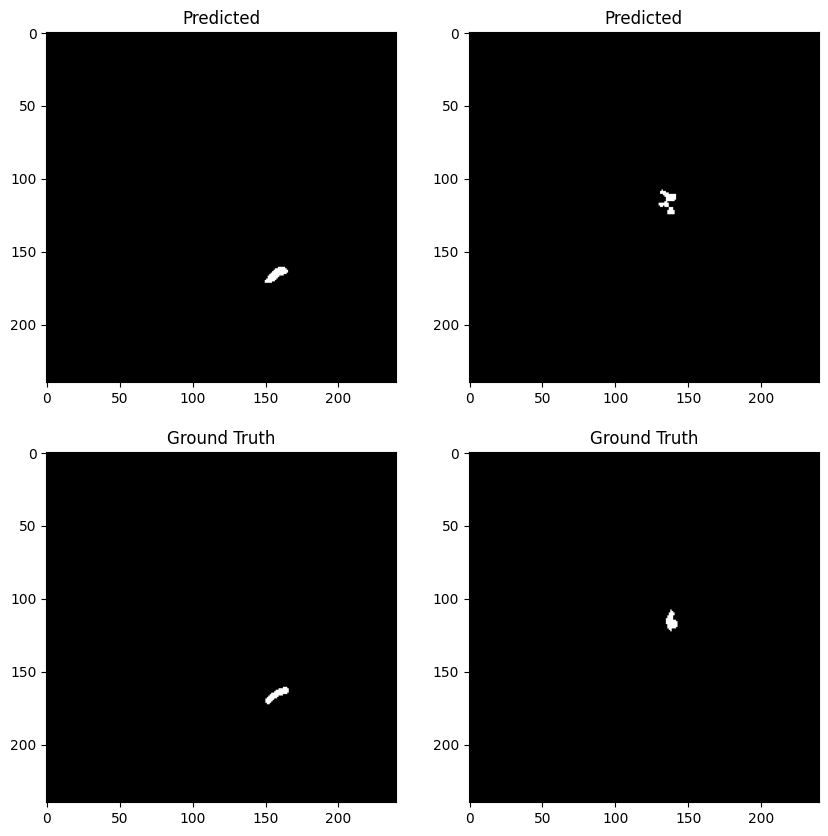

100%|██████████| 136/136 [08:45<00:00,  3.86s/it]



Average Training Loss: 0.005294369406970765

Average Training DSC: [0.9994048  0.91515611 0.94964573 0.81275501]
Average Training ASSD: [ 0.0796887   9.87212333  7.34966179 17.17950409]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


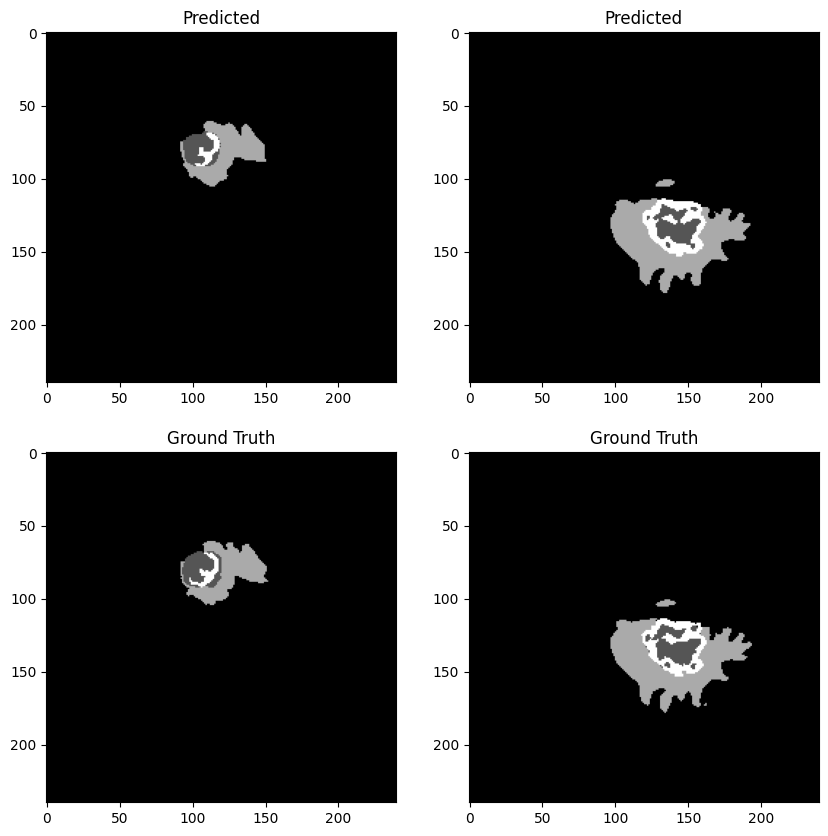

100%|██████████| 34/34 [02:03<00:00,  3.64s/it]


Average Validation Loss: 0.007857458967277232

Average Validation DSC: [0.99926633 0.88577844 0.93692407 0.78386988]
Average Validation ASSD: [ 0.09810218 18.19747883 11.18856664 21.0033168 ]
Epoch 63/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


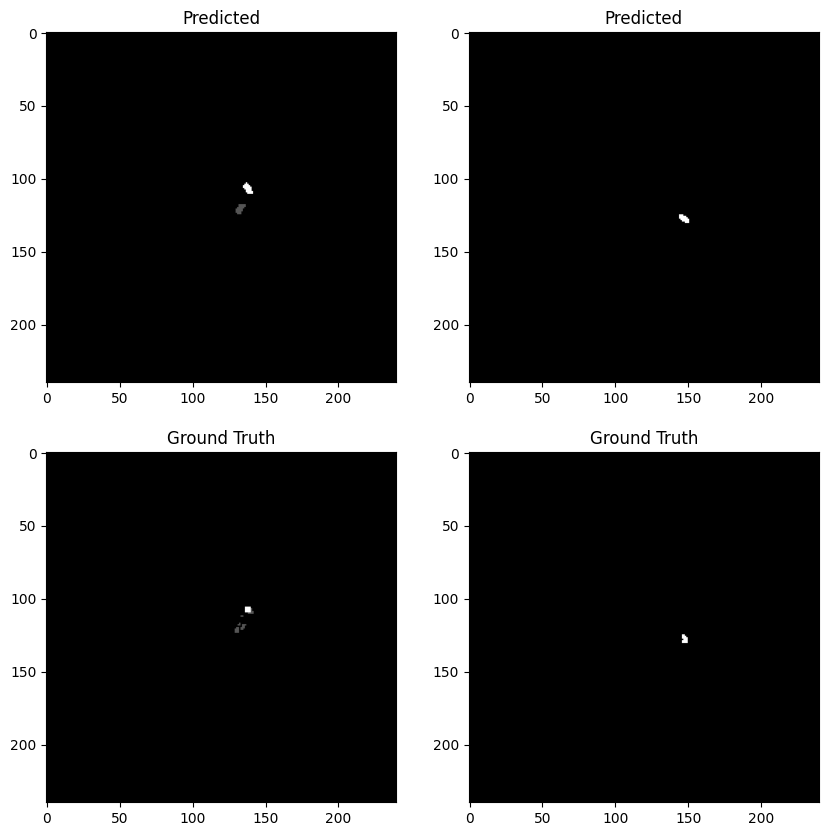

100%|██████████| 136/136 [09:26<00:00,  4.16s/it]



Average Training Loss: 0.005054905262488105

Average Training DSC: [0.99942872 0.92430489 0.95364639 0.82167988]
Average Training ASSD: [ 0.07389746  7.02716007  6.42290079 15.75249213]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


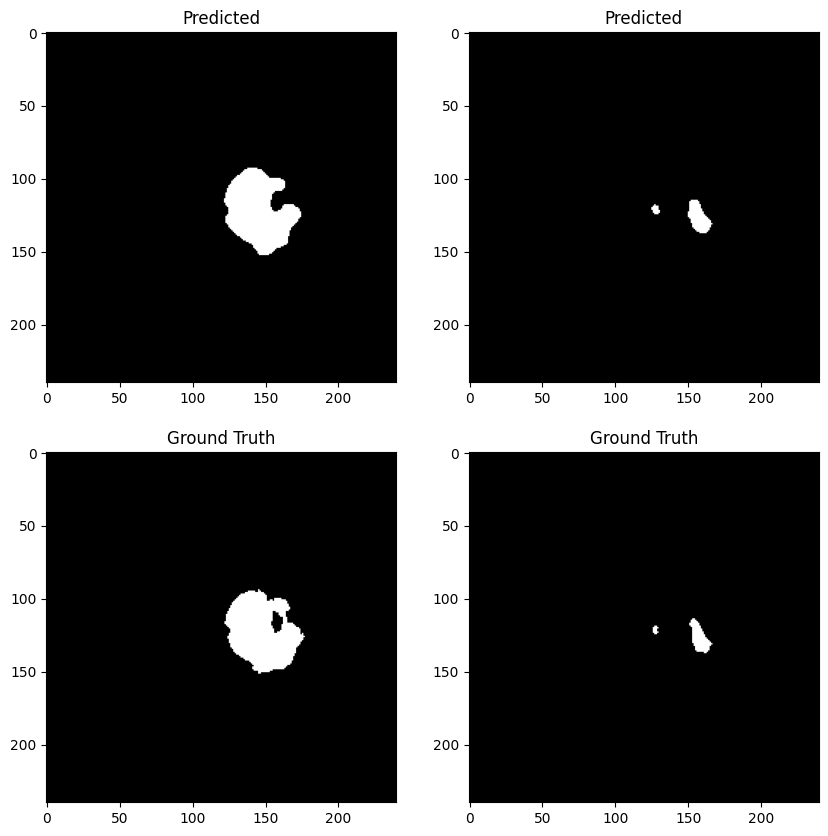

100%|██████████| 34/34 [02:11<00:00,  3.87s/it]


Average Validation Loss: 0.007614753400797353

Average Validation DSC: [0.99921771 0.88587091 0.92846656 0.78179182]
Average Validation ASSD: [ 0.10201717 19.1820228  13.93842181 15.54414563]
Epoch 64/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


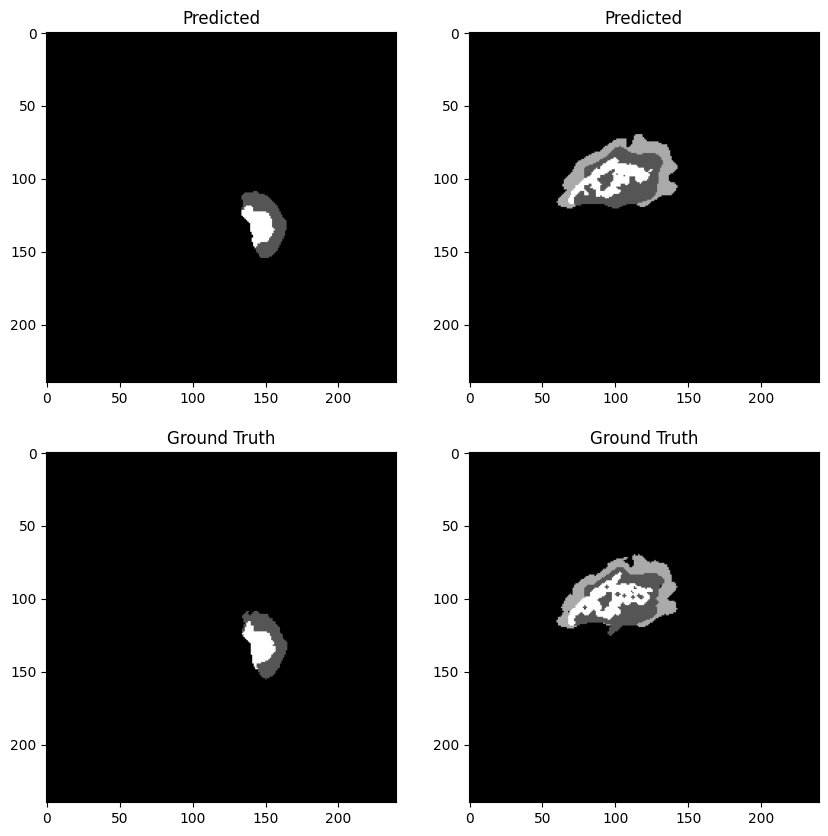

100%|██████████| 136/136 [09:30<00:00,  4.19s/it]



Average Training Loss: 0.005034671010969973

Average Training DSC: [0.99943503 0.92579721 0.95670425 0.81940341]
Average Training ASSD: [ 0.07470896  6.44646225  5.18136974 17.17098898]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


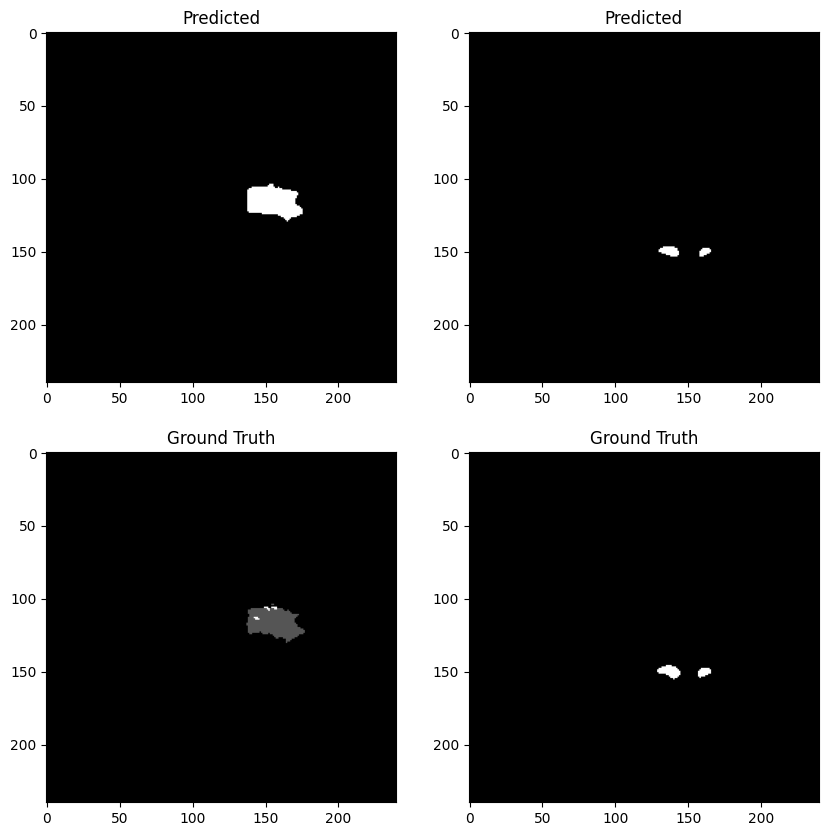

100%|██████████| 34/34 [02:09<00:00,  3.82s/it]


Average Validation Loss: 0.00855505938970429

Average Validation DSC: [0.9991721  0.85182709 0.92164432 0.75207228]
Average Validation ASSD: [ 0.10879099 30.51561552 16.15505805 21.82229951]
Epoch 65/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


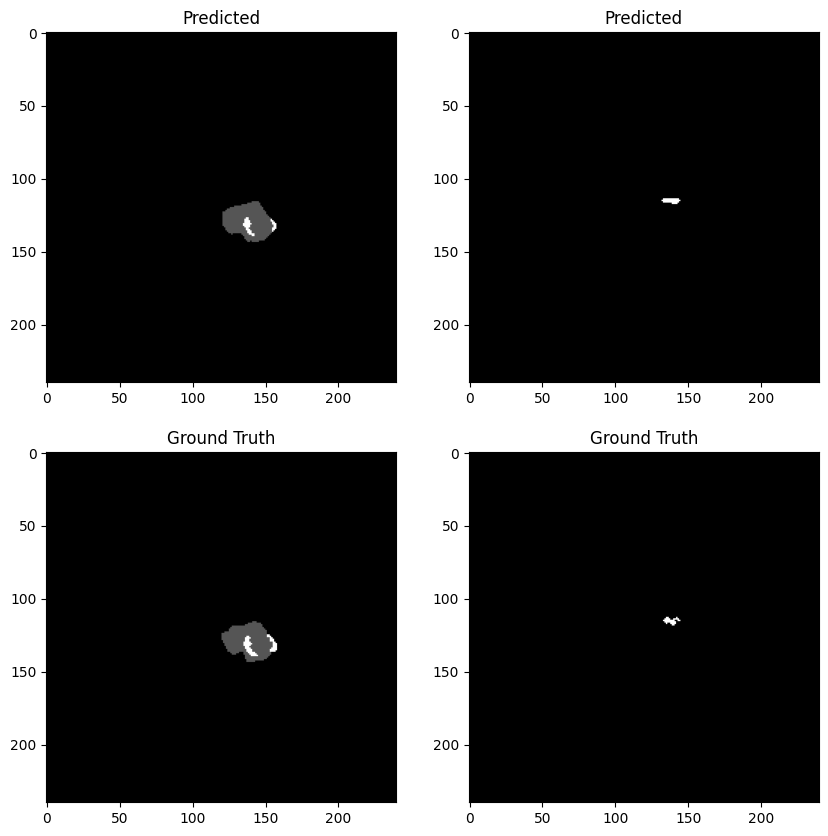

100%|██████████| 136/136 [09:39<00:00,  4.26s/it]



Average Training Loss: 0.005378022516036735

Average Training DSC: [0.99939767 0.91155074 0.94930913 0.81147256]
Average Training ASSD: [ 0.07910457 10.70263784  7.11701349 17.0768593 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


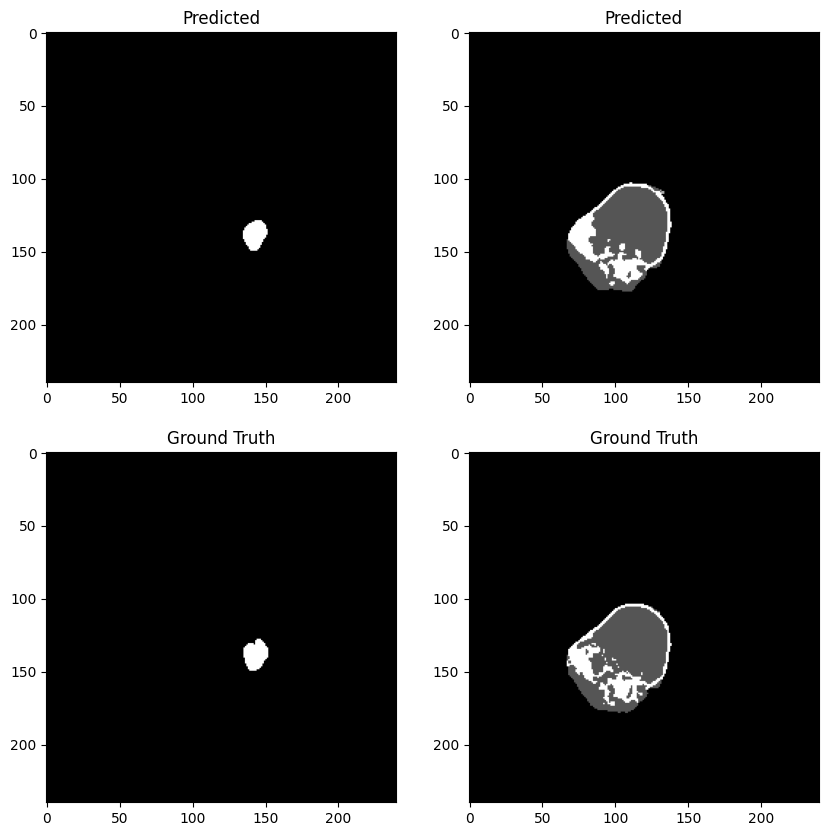

100%|██████████| 34/34 [02:10<00:00,  3.82s/it]


Average Validation Loss: 0.007897486389778993

Average Validation DSC: [0.99923714 0.88334786 0.93019602 0.76620933]
Average Validation ASSD: [ 0.09944796 19.52341314 13.02821469 23.55566445]
Epoch 66/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


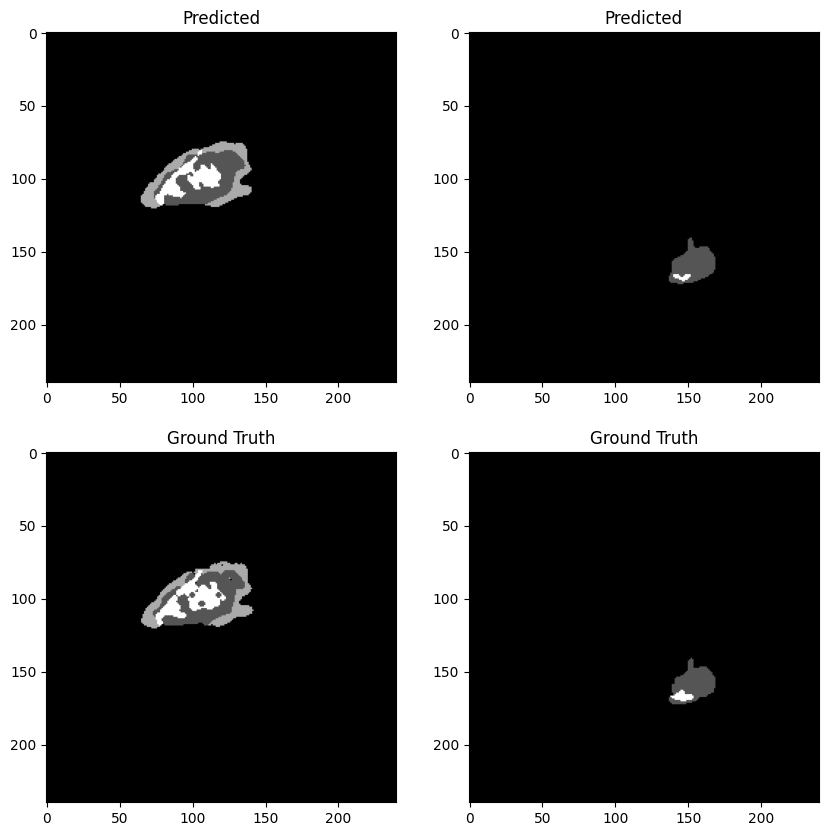

100%|██████████| 136/136 [09:39<00:00,  4.26s/it]



Average Training Loss: 0.004846067075371085

Average Training DSC: [0.99946504 0.92563649 0.95706315 0.82410493]
Average Training ASSD: [ 0.06876797  7.50982127  5.42965753 16.74023898]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


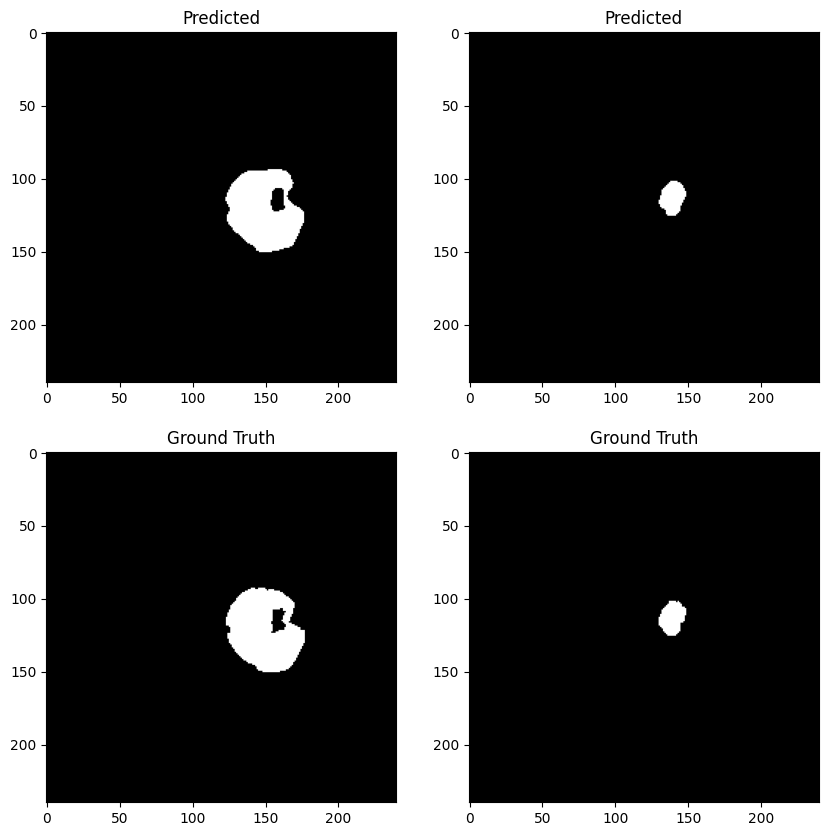

100%|██████████| 34/34 [02:12<00:00,  3.91s/it]


Average Validation Loss: 0.00791412515921847

Average Validation DSC: [0.99929128 0.88959312 0.92621599 0.79410834]
Average Validation ASSD: [ 0.09074203 15.54604898 14.62287594 13.71992493]
Epoch 67/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


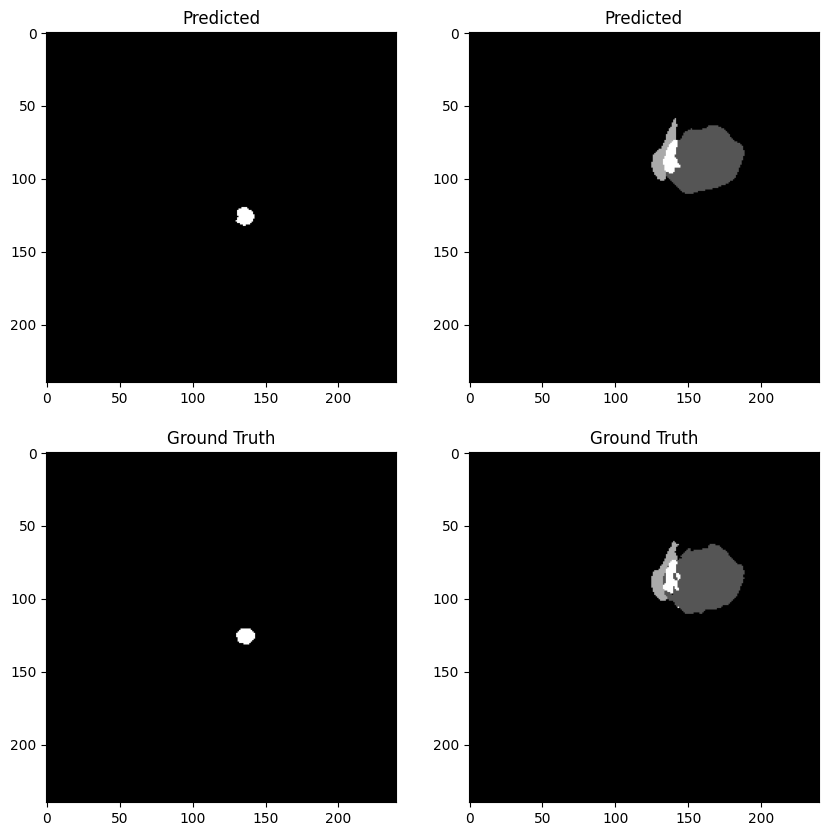

100%|██████████| 136/136 [09:48<00:00,  4.33s/it]



Average Training Loss: 0.00512889154111583

Average Training DSC: [0.99944005 0.91633348 0.94852017 0.81737827]
Average Training ASSD: [ 0.07430927  9.4479213   8.09529747 16.49822456]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


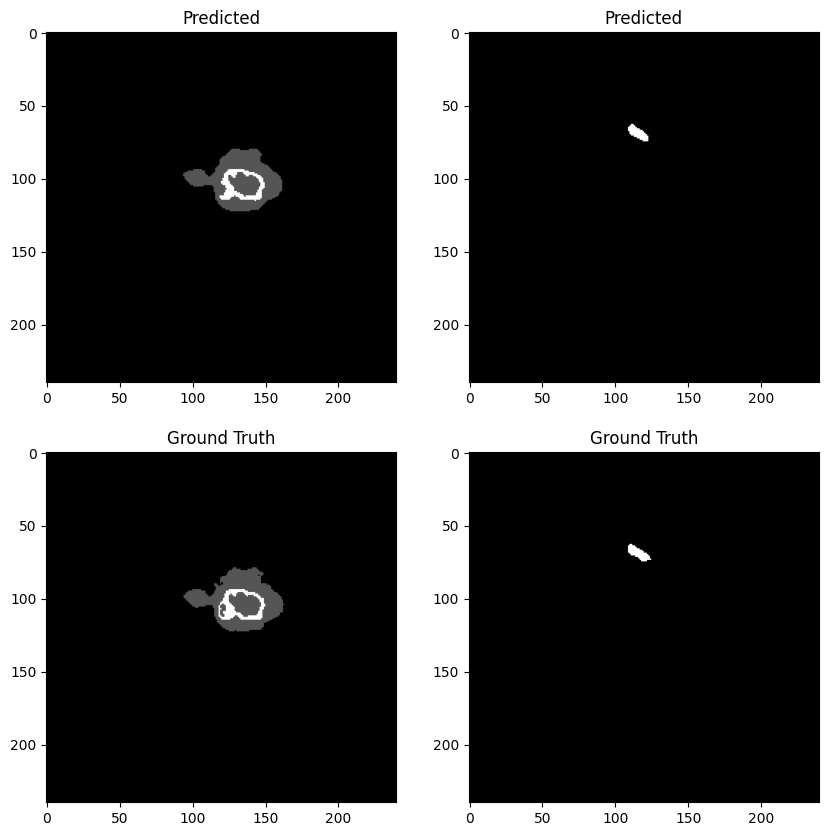

100%|██████████| 34/34 [02:19<00:00,  4.10s/it]


Average Validation Loss: 0.007573678418446113

Average Validation DSC: [0.99924398 0.87353351 0.92980849 0.78687352]
Average Validation ASSD: [ 0.09444444 21.19791053 13.99786486 16.37194582]
Epoch 68/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


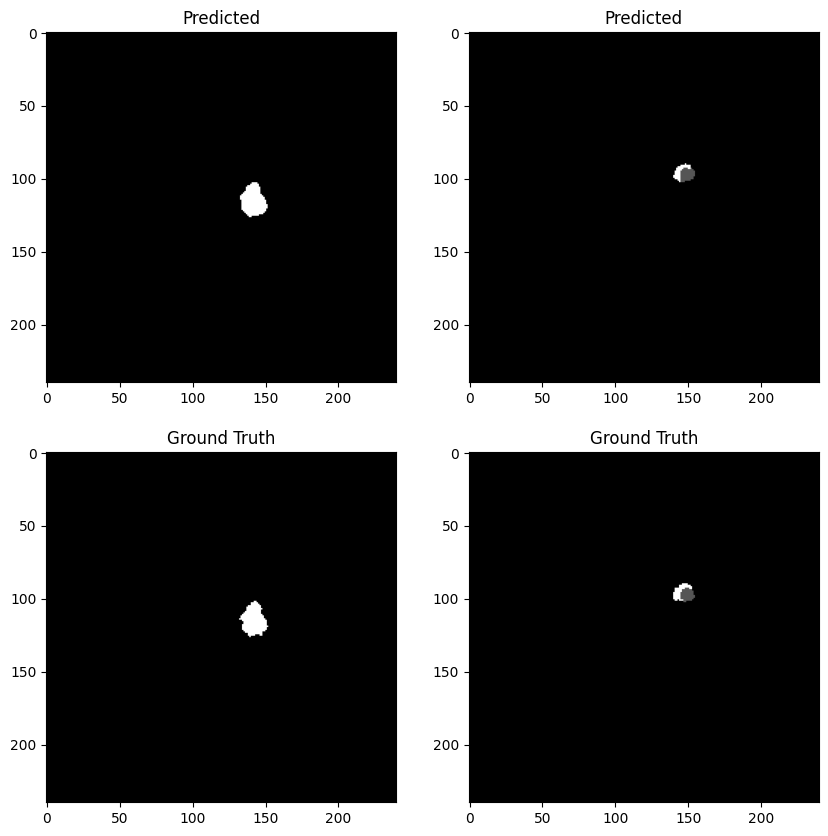

100%|██████████| 136/136 [09:57<00:00,  4.39s/it]



Average Training Loss: 0.005817148137686993

Average Training DSC: [0.99937765 0.90023248 0.94567979 0.81247892]
Average Training ASSD: [ 0.08355837 13.88210485  8.42797465 15.05576196]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


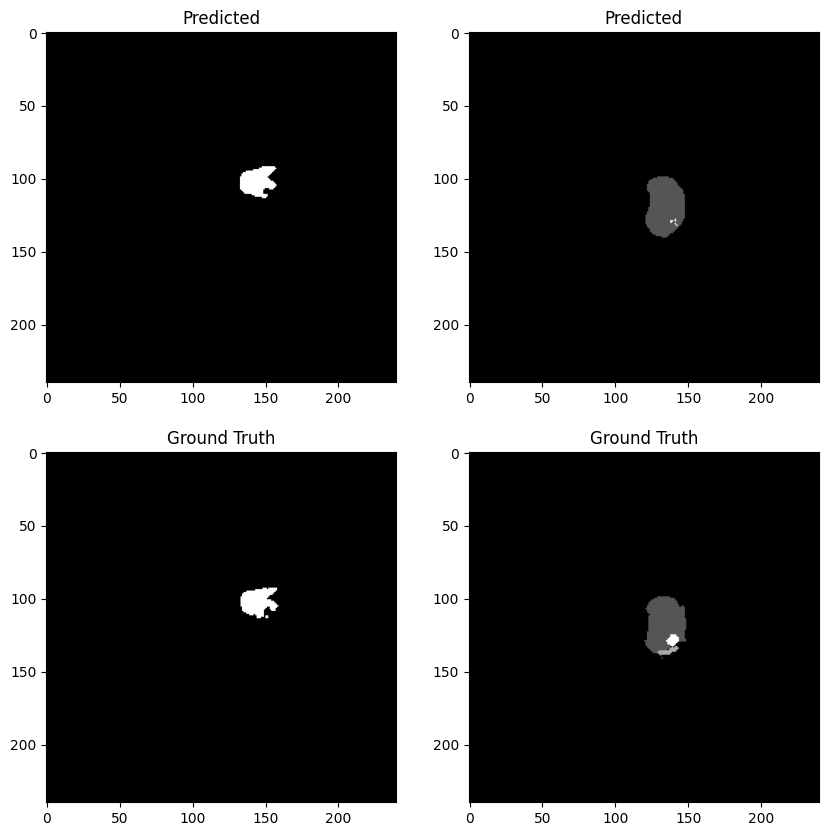

100%|██████████| 34/34 [02:15<00:00,  3.97s/it]


Average Validation Loss: 0.007268440170104013

Average Validation DSC: [0.99923162 0.87833044 0.93458006 0.7742422 ]
Average Validation ASSD: [ 0.10183591 22.09474348 11.32725864 18.82115934]
Epoch 69/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


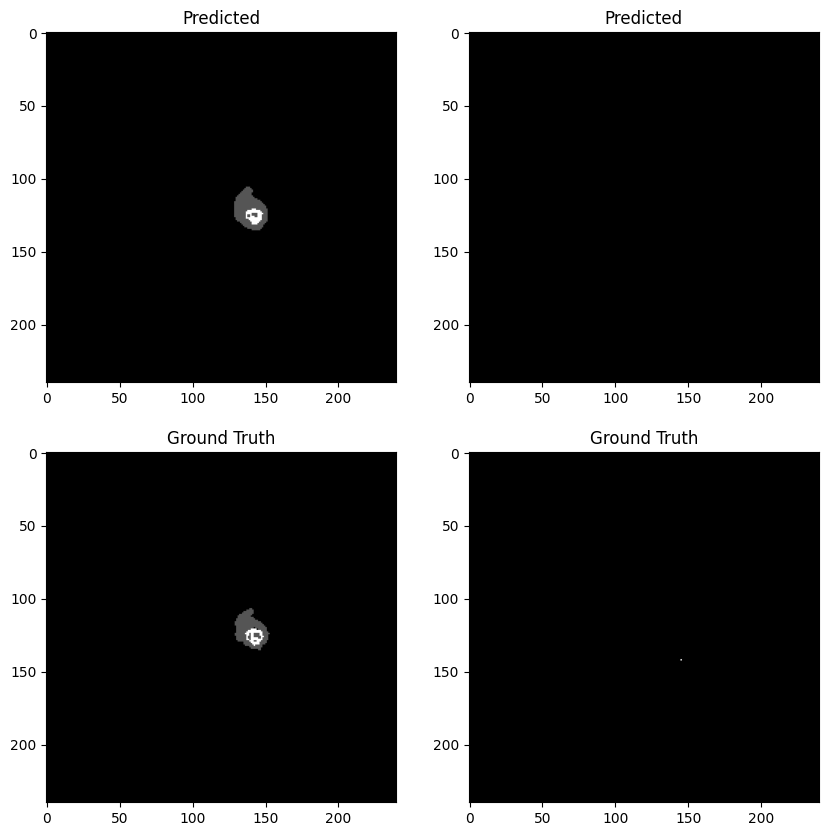

100%|██████████| 136/136 [09:56<00:00,  4.38s/it]



Average Training Loss: 0.005110084906953168

Average Training DSC: [0.99942491 0.92245037 0.95088956 0.81823539]
Average Training ASSD: [ 0.07459138  8.01877842  7.19297329 16.36694596]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


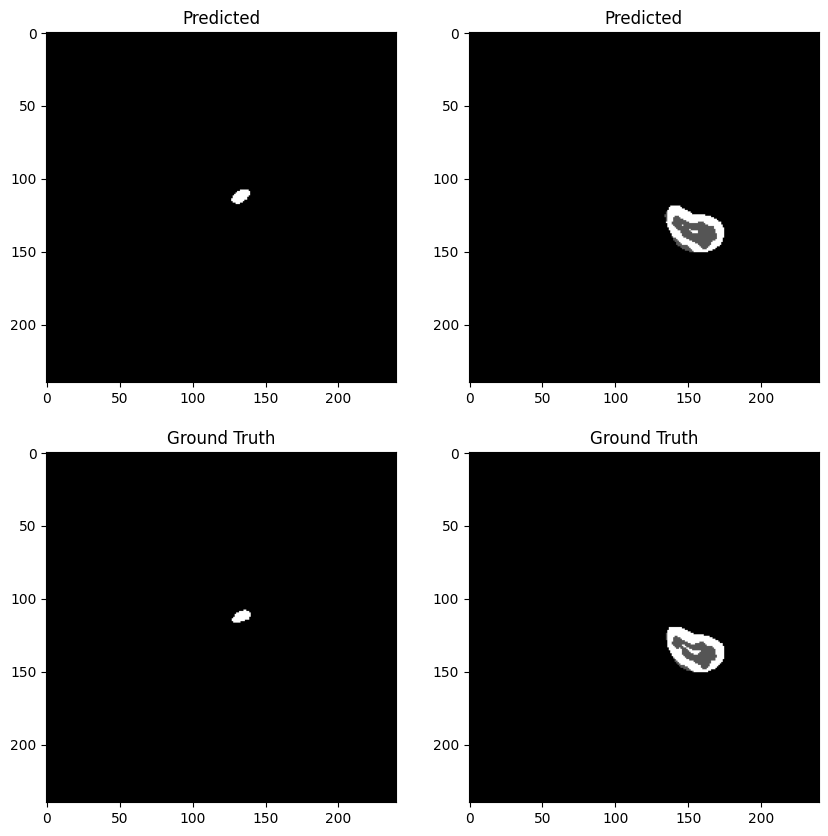

100%|██████████| 34/34 [02:14<00:00,  3.94s/it]


Average Validation Loss: 0.007326496244572541

Average Validation DSC: [0.99925937 0.89388655 0.93956005 0.78204103]
Average Validation ASSD: [ 0.0990856  16.52160618 10.58321698 17.56679205]
Epoch 70/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


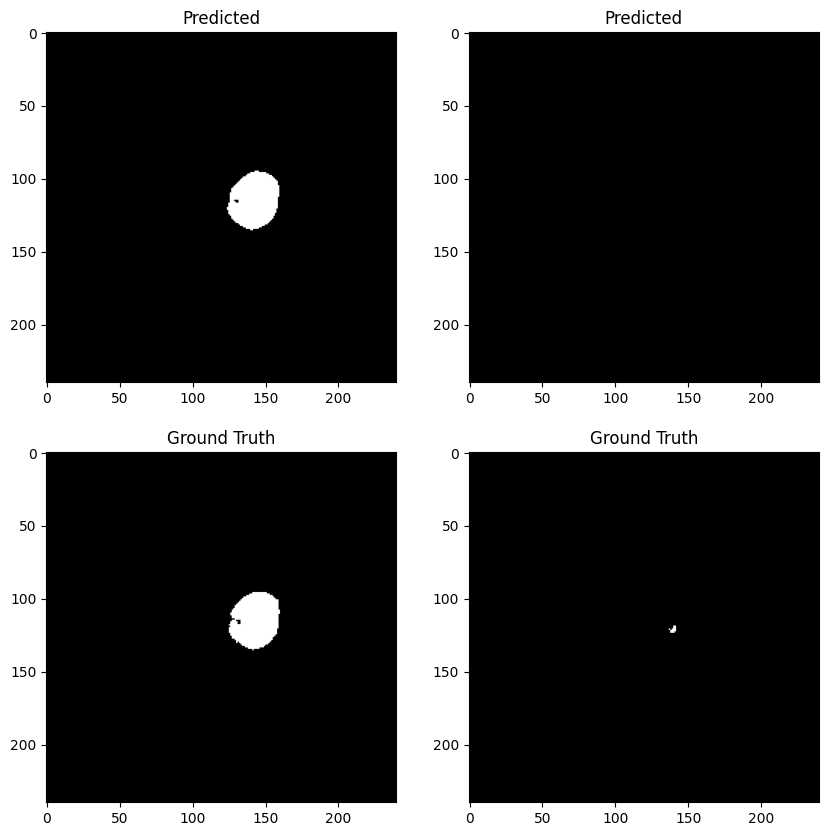

100%|██████████| 136/136 [09:35<00:00,  4.23s/it]



Average Training Loss: 0.004579594557392685

Average Training DSC: [0.99948871 0.93240759 0.95631621 0.83266576]
Average Training ASSD: [ 0.06575241  5.33561976  5.98636656 15.70358775]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


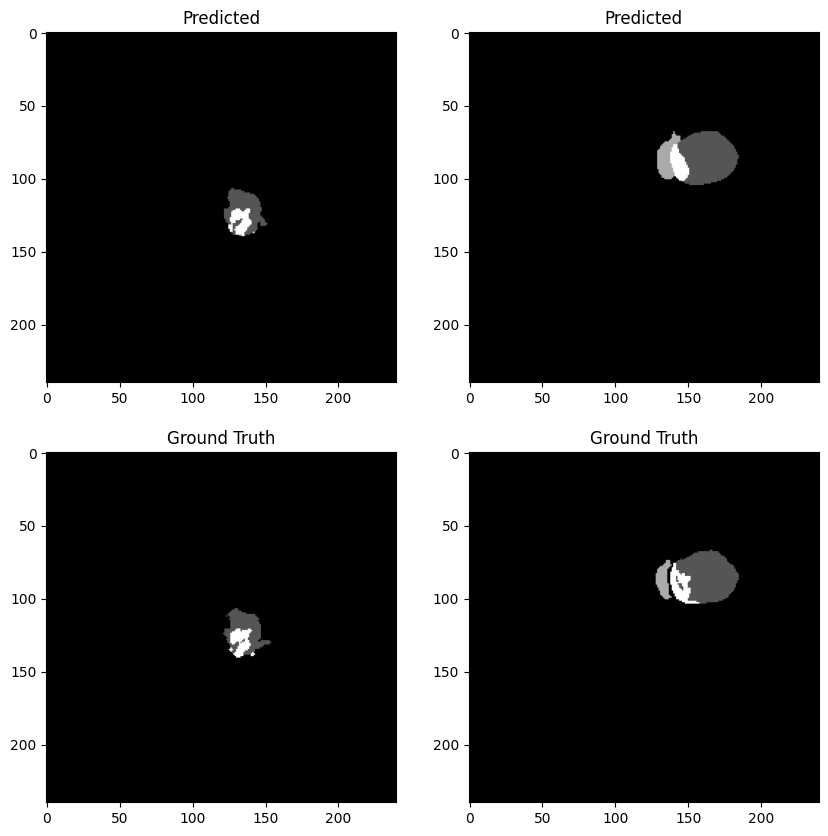

100%|██████████| 34/34 [02:11<00:00,  3.88s/it]


Average Validation Loss: 0.0073634485358043626

Average Validation DSC: [0.99924974 0.8891278  0.93816643 0.79407057]
Average Validation ASSD: [ 0.09351564 18.45585889  9.64516352 13.67016582]
Epoch 71/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


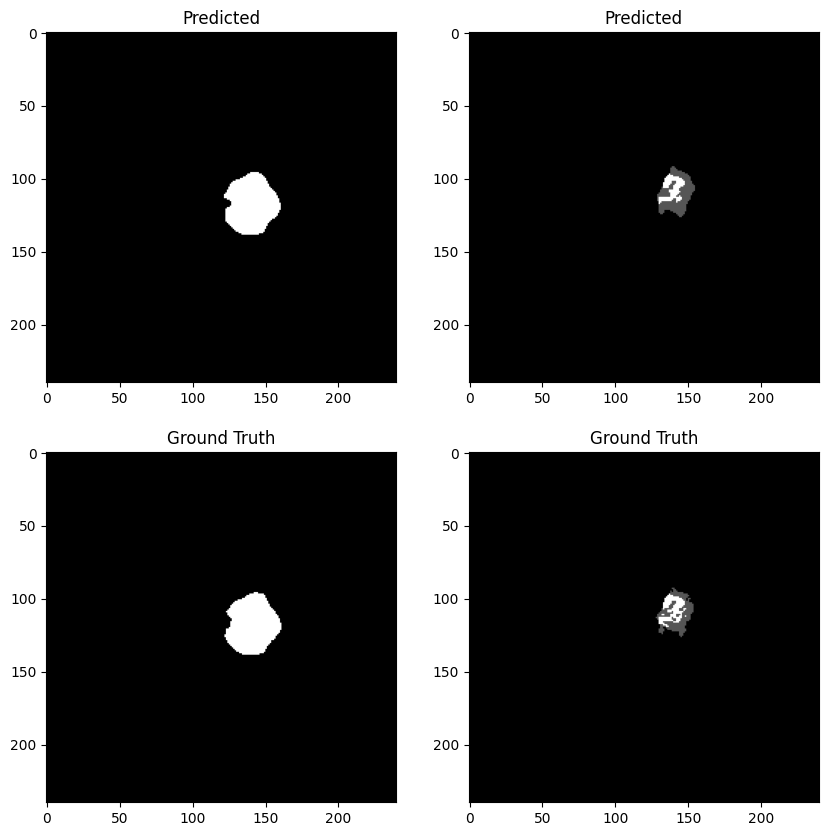

100%|██████████| 136/136 [09:46<00:00,  4.32s/it]



Average Training Loss: 0.004710098304820028

Average Training DSC: [0.99947599 0.93222841 0.95550778 0.83306547]
Average Training ASSD: [ 0.06786394  5.6627024   6.40497245 15.77121541]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


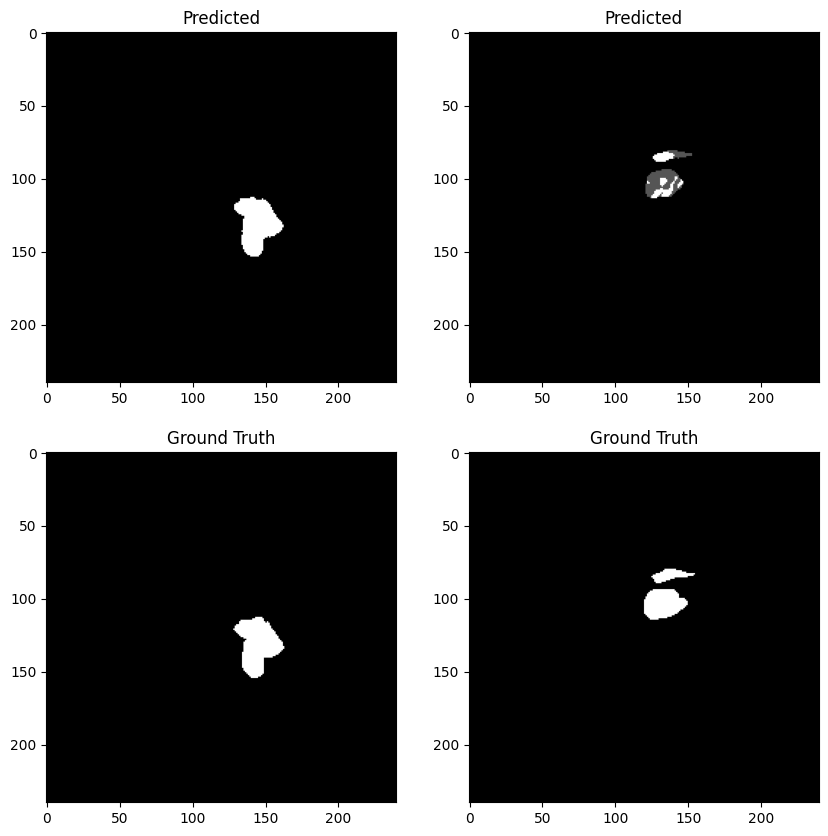

100%|██████████| 34/34 [02:16<00:00,  4.01s/it]


Average Validation Loss: 0.007898679537260356

Average Validation DSC: [0.99923585 0.89008258 0.92195664 0.77400248]
Average Validation ASSD: [ 0.11144517 17.60079318 14.0107256  23.0229009 ]
Epoch 72/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


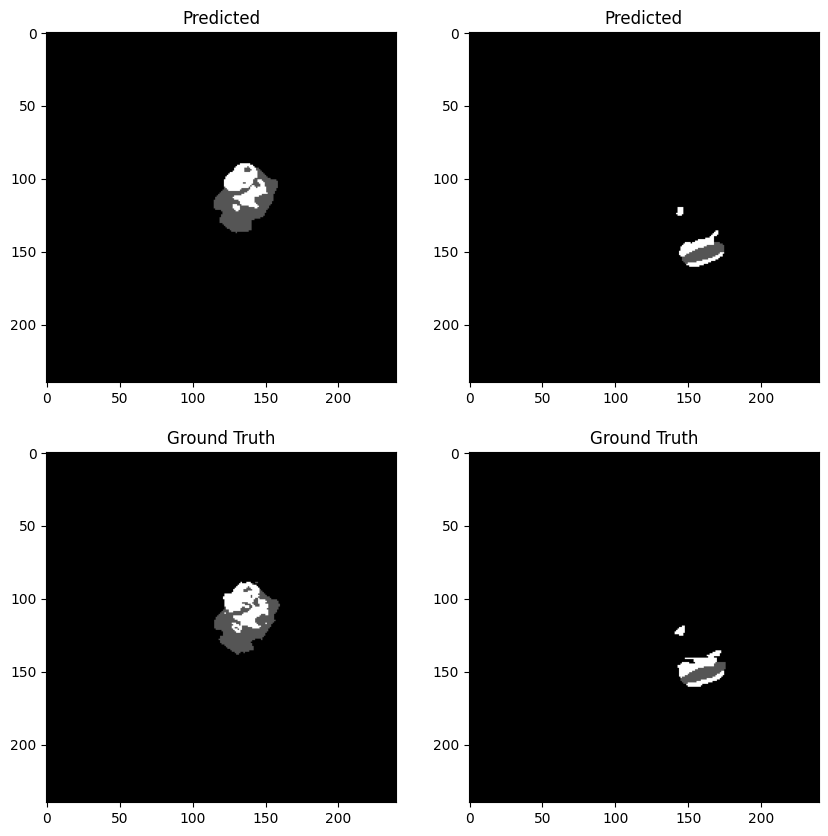

100%|██████████| 136/136 [09:31<00:00,  4.20s/it]



Average Training Loss: 0.004800322008497246

Average Training DSC: [0.99945903 0.9282183  0.95260038 0.82732747]
Average Training ASSD: [ 0.07127195  7.24562374  7.00361493 16.07695532]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


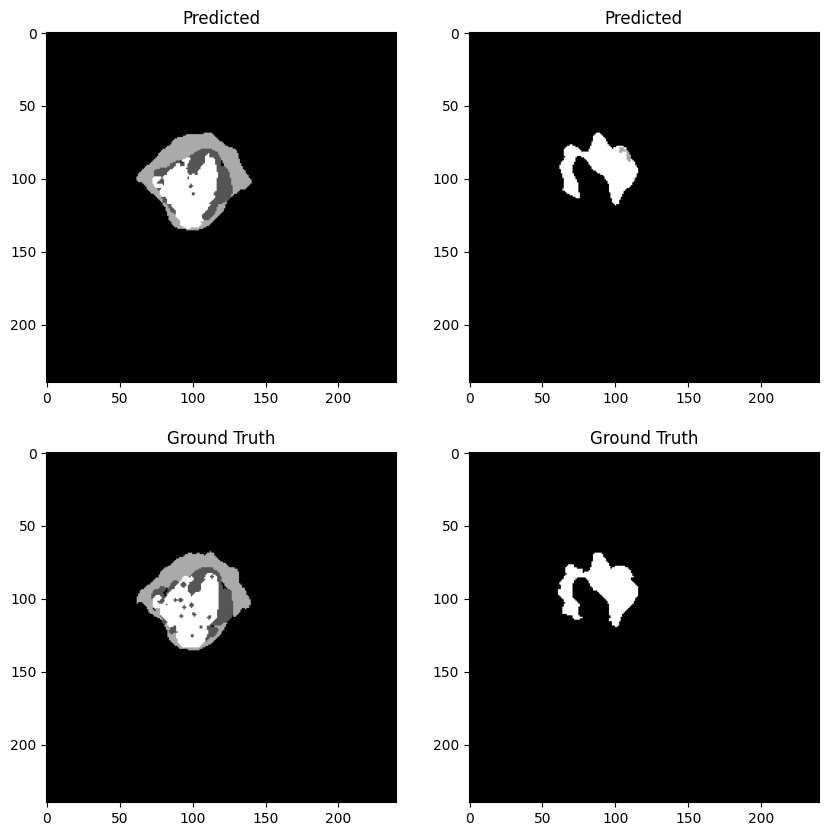

100%|██████████| 34/34 [02:21<00:00,  4.17s/it]


Average Validation Loss: 0.007216858985724256

Average Validation DSC: [0.99930591 0.8927139  0.93164844 0.78596357]
Average Validation ASSD: [ 0.09003636 18.07541531 12.53796352 18.93799082]
Epoch 73/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


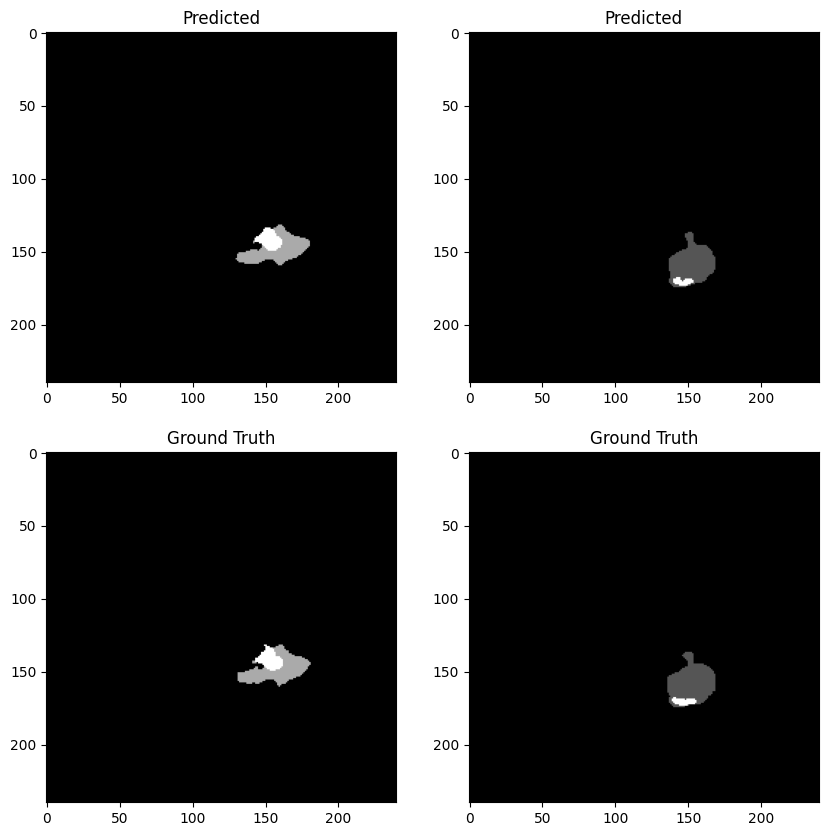

100%|██████████| 136/136 [09:51<00:00,  4.35s/it]



Average Training Loss: 0.005026790726012276

Average Training DSC: [0.99944874 0.92585993 0.94129624 0.82541071]
Average Training ASSD: [ 0.07197634  6.85626166  9.94302473 15.23071508]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


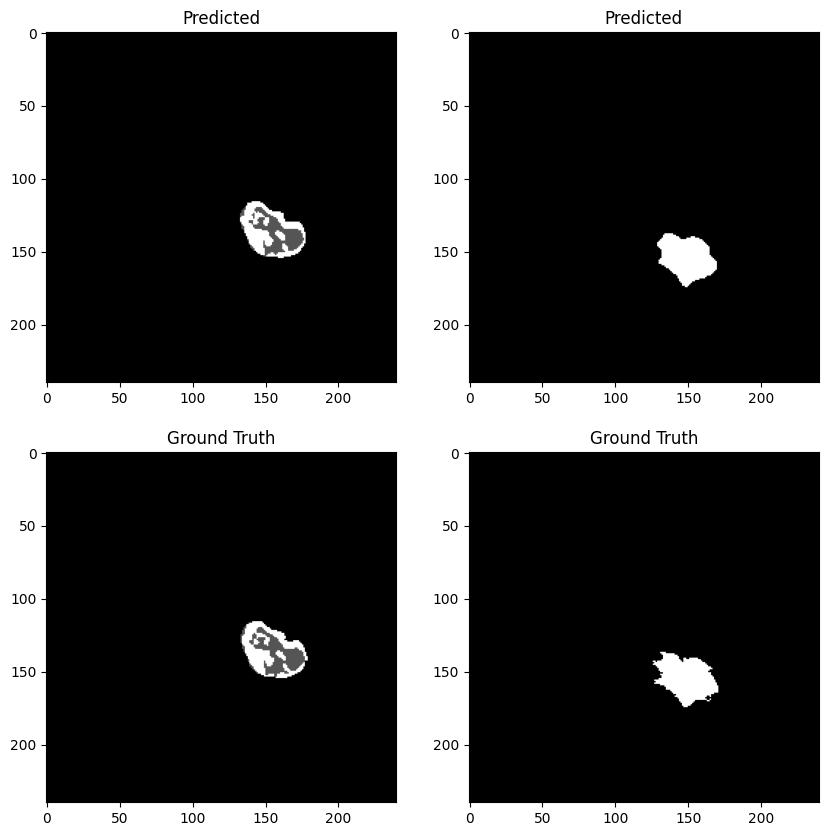

100%|██████████| 34/34 [02:10<00:00,  3.85s/it]


Average Validation Loss: 0.00740987406221821

Average Validation DSC: [0.99926813 0.88932469 0.9360635  0.77193301]
Average Validation ASSD: [ 0.10139453 18.18292607 11.3276707  23.4078004 ]
Epoch 74/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


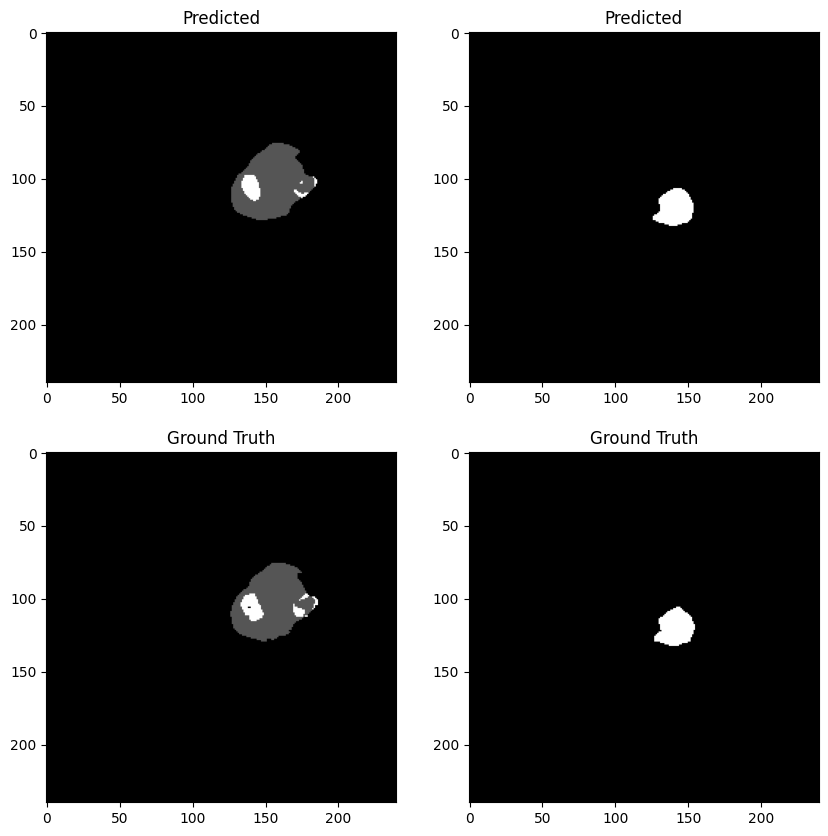

100%|██████████| 136/136 [09:41<00:00,  4.27s/it]



Average Training Loss: 0.00472245055511046

Average Training DSC: [0.99948102 0.9306629  0.95099529 0.83126304]
Average Training ASSD: [ 0.06894333  6.25142686  7.42264645 16.84362811]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


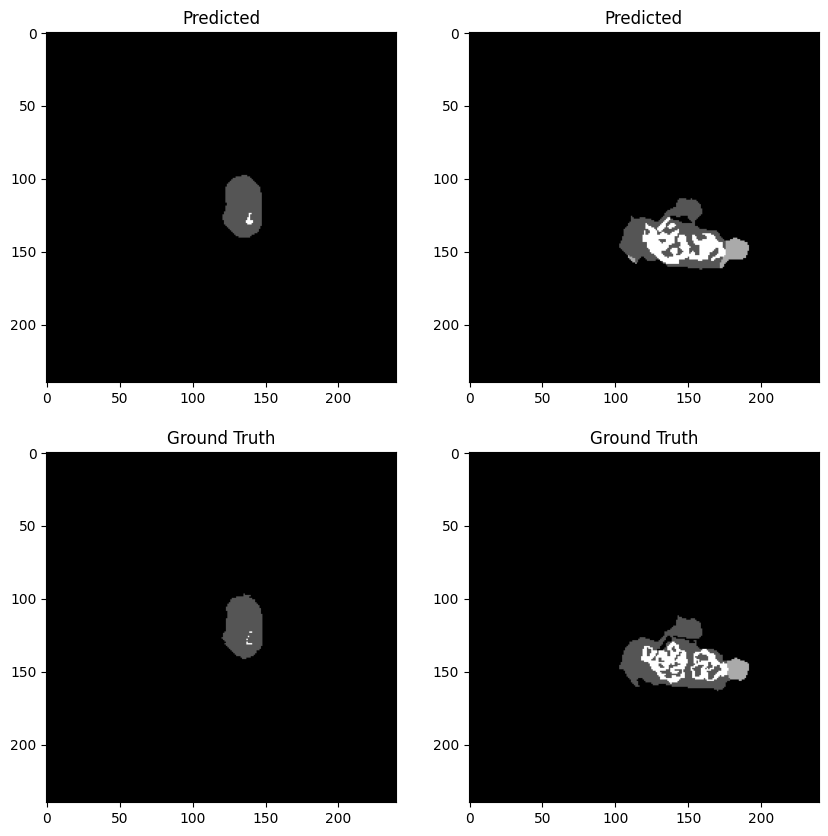

100%|██████████| 34/34 [02:19<00:00,  4.09s/it]


Average Validation Loss: 0.00768736595123568

Average Validation DSC: [0.99929306 0.88378268 0.91085538 0.79440669]
Average Validation ASSD: [ 0.09288159 20.10528572 19.2322628  14.95808361]
Epoch 75/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


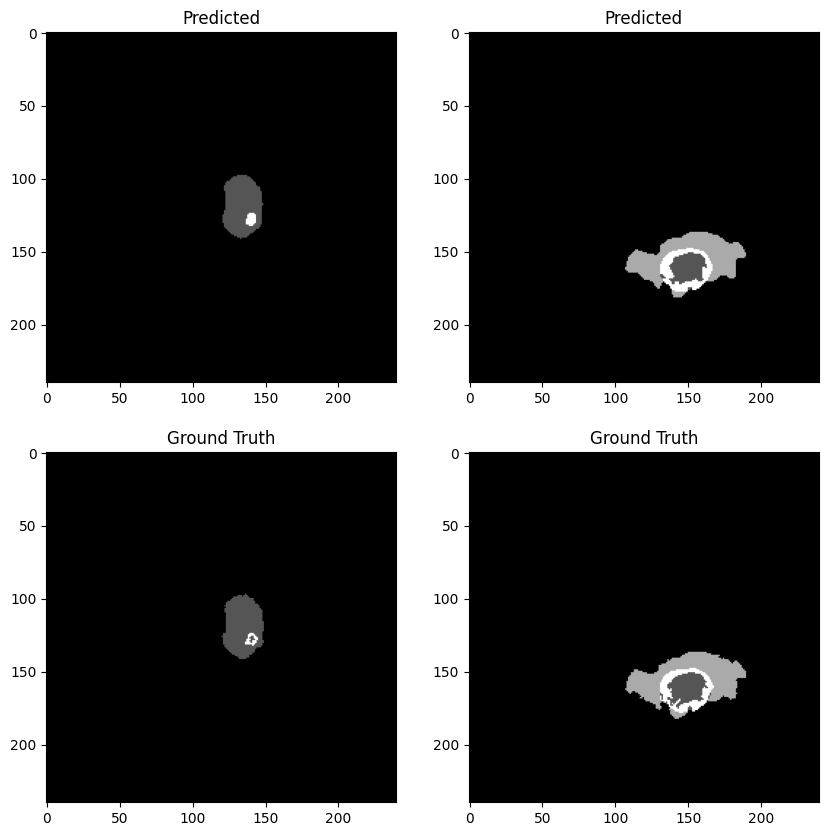

100%|██████████| 136/136 [09:43<00:00,  4.29s/it]



Average Training Loss: 0.00505273779409061

Average Training DSC: [0.9994463  0.91927037 0.94804476 0.82335087]
Average Training ASSD: [ 0.07212019  9.91852553  8.59086534 15.45607919]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


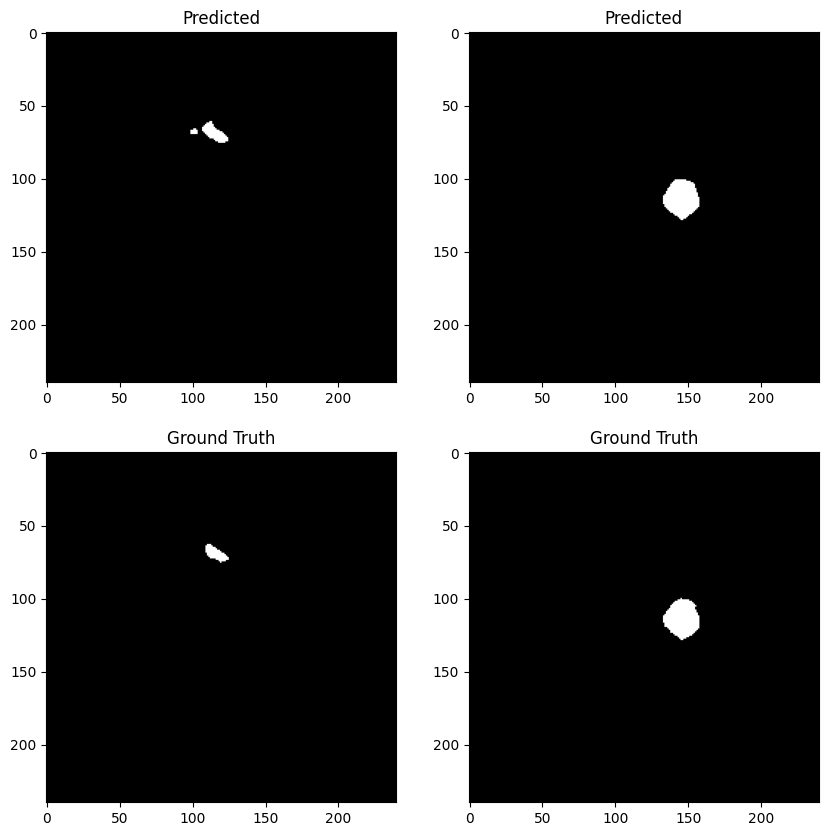

100%|██████████| 34/34 [02:18<00:00,  4.07s/it]


Average Validation Loss: 0.008095351664130302

Average Validation DSC: [0.99919952 0.86708352 0.93837732 0.77375129]
Average Validation ASSD: [ 0.10653137 25.75601481  8.95760594 19.76827372]
Epoch 76/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


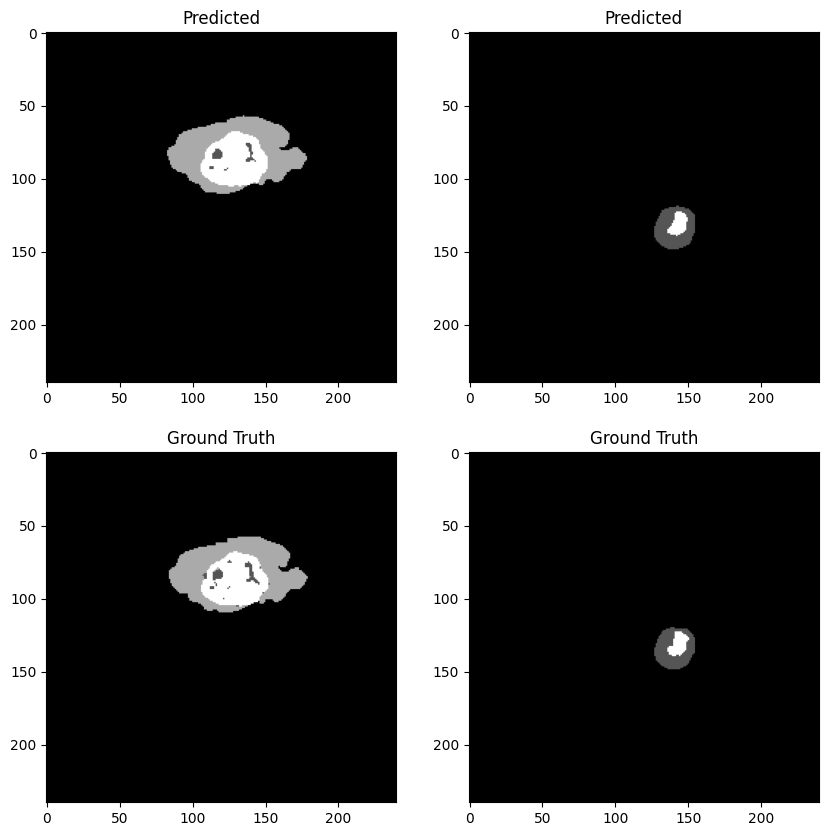

100%|██████████| 136/136 [09:52<00:00,  4.35s/it]



Average Training Loss: 0.004959800523733173

Average Training DSC: [0.99945678 0.91915916 0.95111761 0.82965084]
Average Training ASSD: [ 0.07118035  9.34938692  7.25681508 14.61902599]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


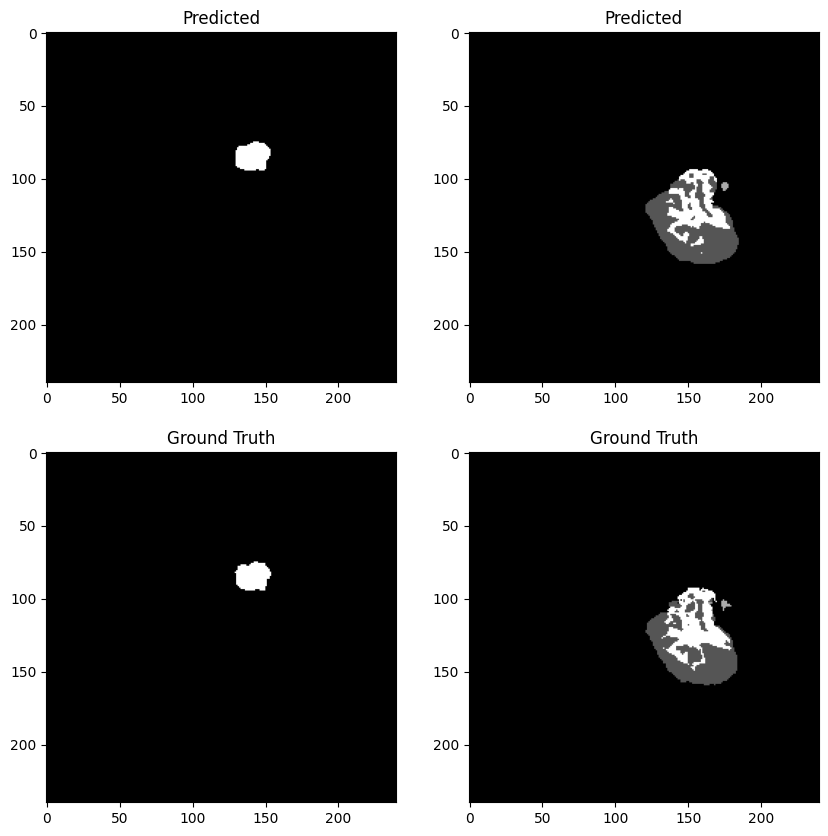

100%|██████████| 34/34 [02:09<00:00,  3.82s/it]


Average Validation Loss: 0.007361374918700141

Average Validation DSC: [0.99930072 0.89062554 0.94087839 0.78253044]
Average Validation ASSD: [ 0.09650667 18.48812338  9.53460339 21.24941196]
Epoch 77/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


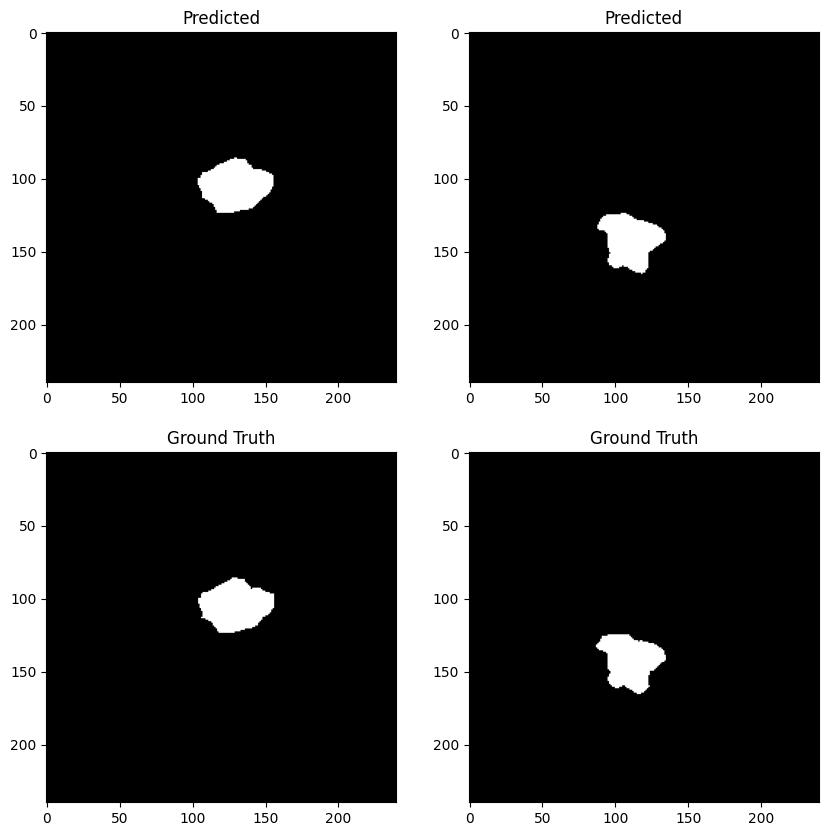

100%|██████████| 136/136 [09:49<00:00,  4.33s/it]



Average Training Loss: 0.0045763036143719495

Average Training DSC: [0.99949239 0.92840659 0.95746502 0.83547935]
Average Training ASSD: [ 0.06669867  7.5671657   5.57932209 15.2856689 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


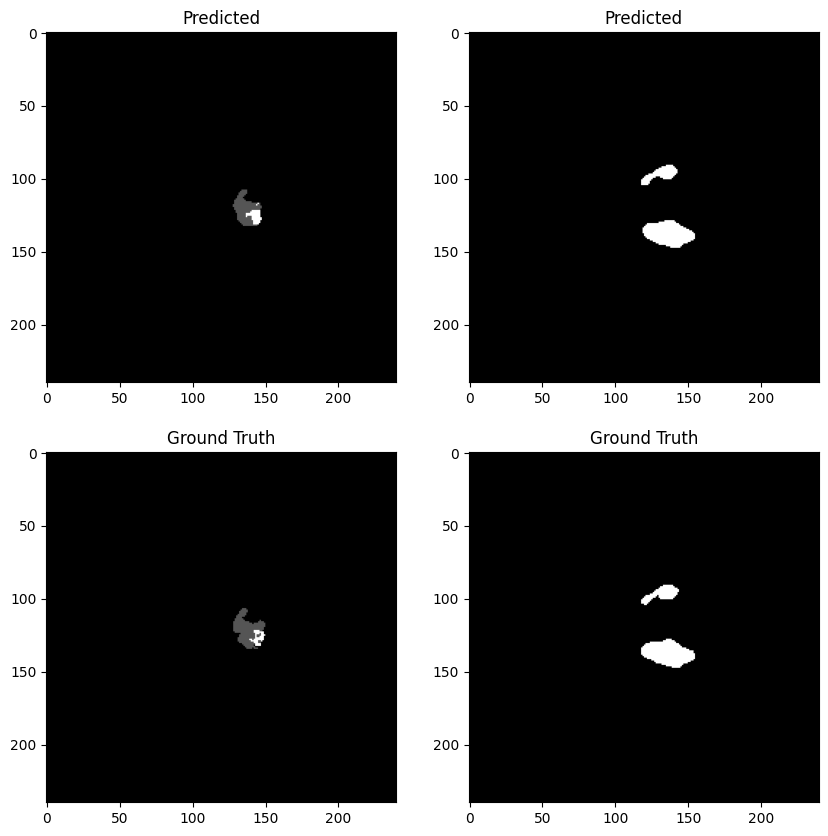

100%|██████████| 34/34 [02:13<00:00,  3.91s/it]


Average Validation Loss: 0.007314853863242795

Average Validation DSC: [0.99929047 0.88577649 0.93307646 0.78434446]
Average Validation ASSD: [ 0.0977316  18.75608421 12.2952625  21.43061315]
Epoch 78/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


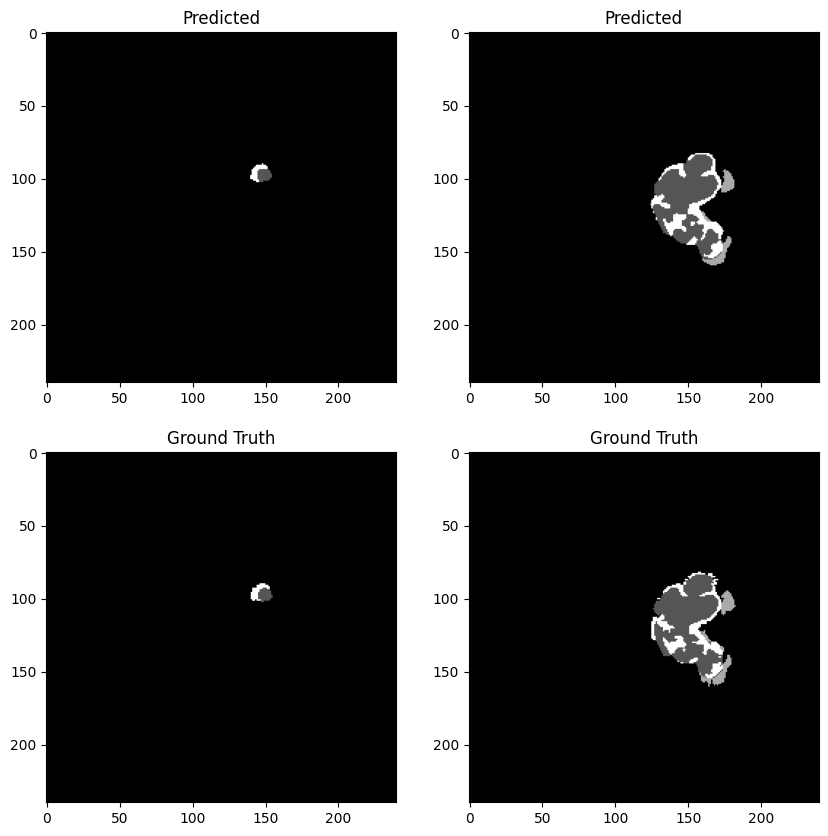

100%|██████████| 136/136 [09:34<00:00,  4.23s/it]



Average Training Loss: 0.004530431017937029

Average Training DSC: [0.9994953  0.92868378 0.95761218 0.83612266]
Average Training ASSD: [ 0.06569948  7.32191512  5.98593483 14.87483678]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


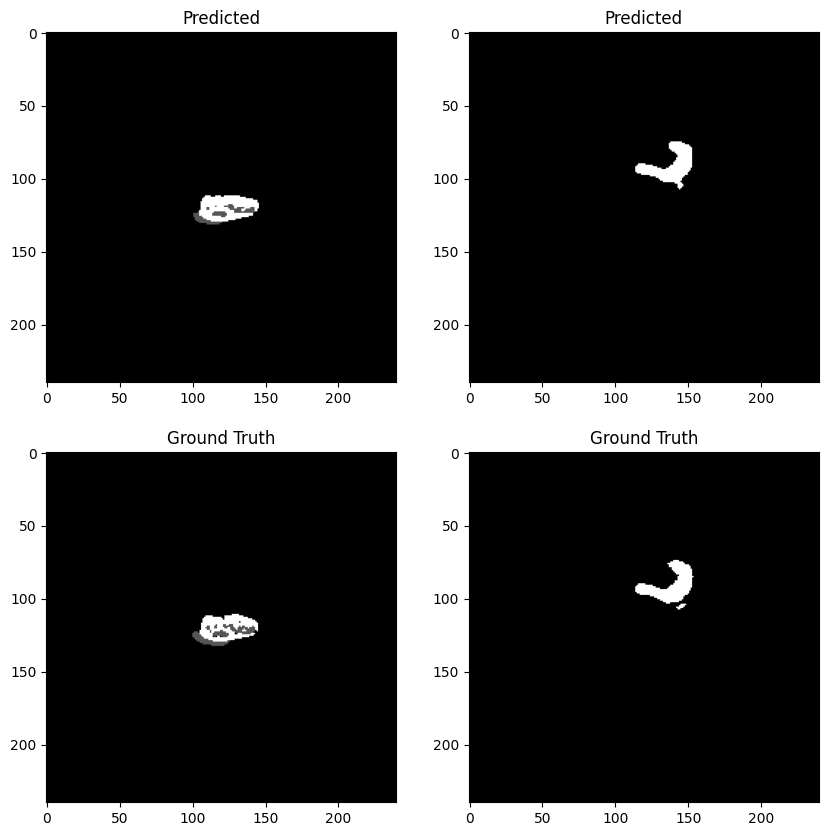

100%|██████████| 34/34 [02:15<00:00,  4.00s/it]


Average Validation Loss: 0.007264944327556912

Average Validation DSC: [0.99931197 0.89348421 0.93310795 0.79989013]
Average Validation ASSD: [ 0.08777208 15.59975519 12.19322405 14.93338646]
Epoch 79/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


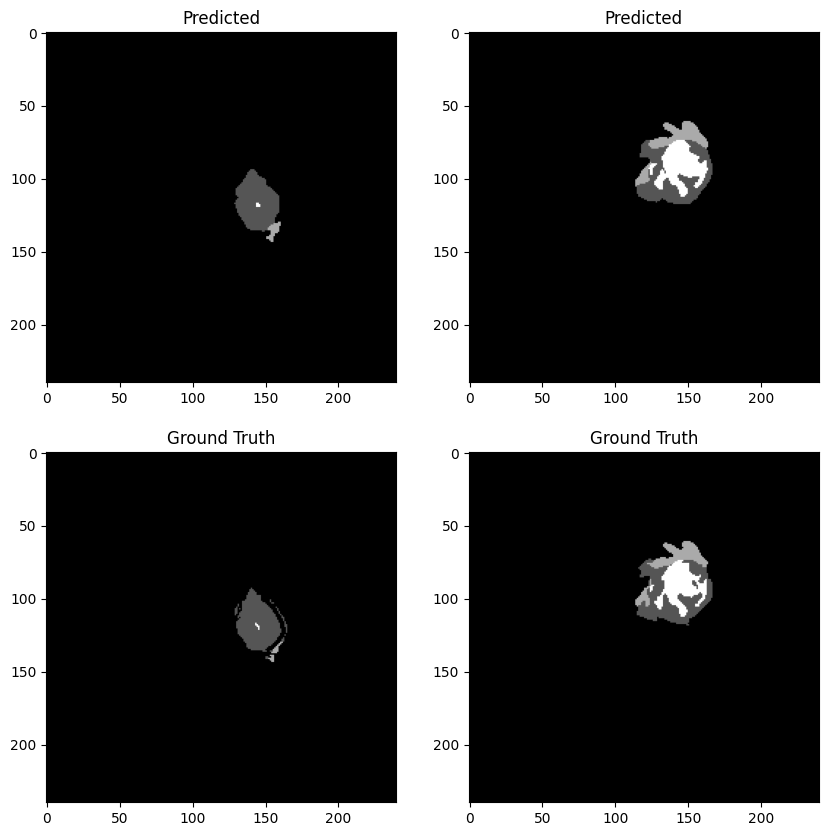

100%|██████████| 136/136 [09:41<00:00,  4.28s/it]



Average Training Loss: 0.004138992150889381

Average Training DSC: [0.9995425  0.93841049 0.9615318  0.84561435]
Average Training ASSD: [ 0.06026118  4.96791448  5.05917272 14.69702618]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


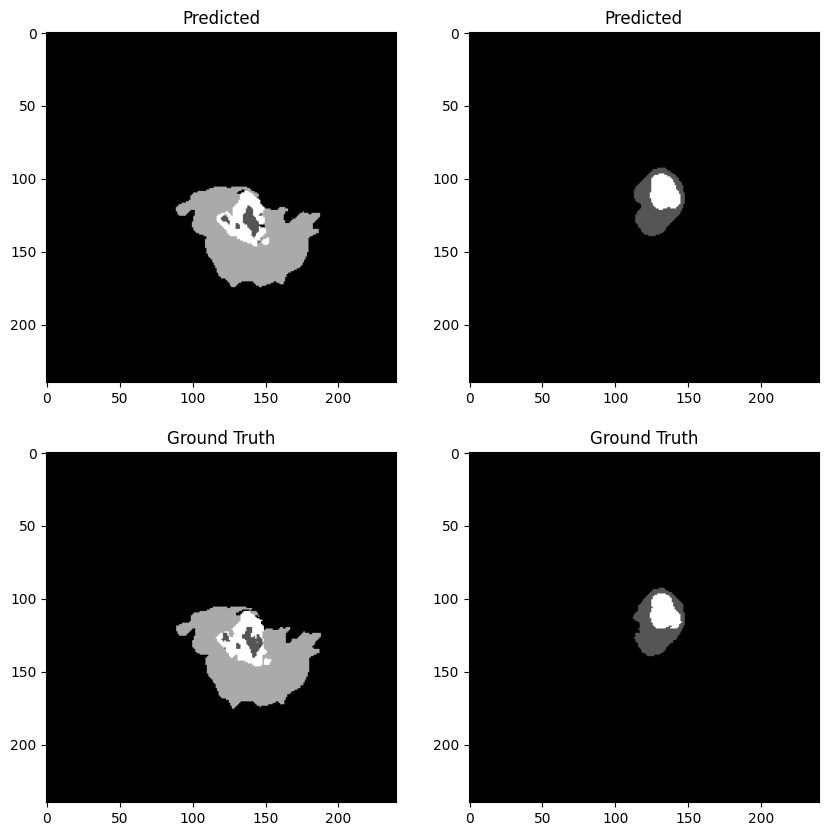

100%|██████████| 34/34 [02:14<00:00,  3.95s/it]


Average Validation Loss: 0.007208081099259502

Average Validation DSC: [0.99934271 0.90204345 0.94067221 0.79783318]
Average Validation ASSD: [ 0.08551912 14.73615661 10.18183434 17.32431852]
Epoch 80/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


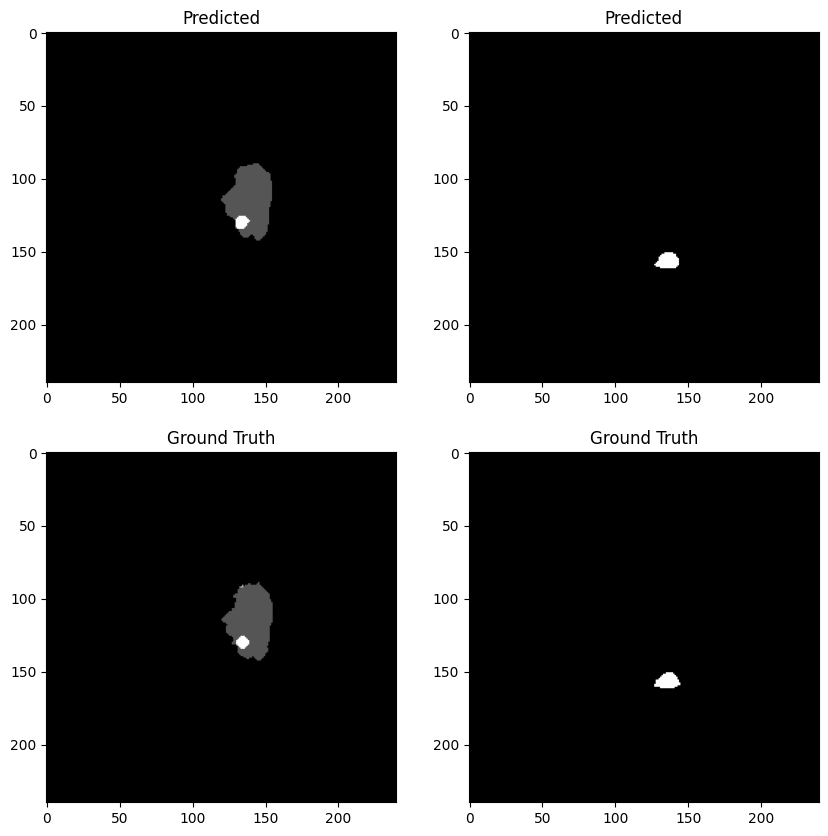

100%|██████████| 136/136 [09:40<00:00,  4.27s/it]



Average Training Loss: 0.00414457221631892

Average Training DSC: [0.99955421 0.9376039  0.96056053 0.84914434]
Average Training ASSD: [ 0.05761842  5.70688037  5.31923468 14.28739906]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


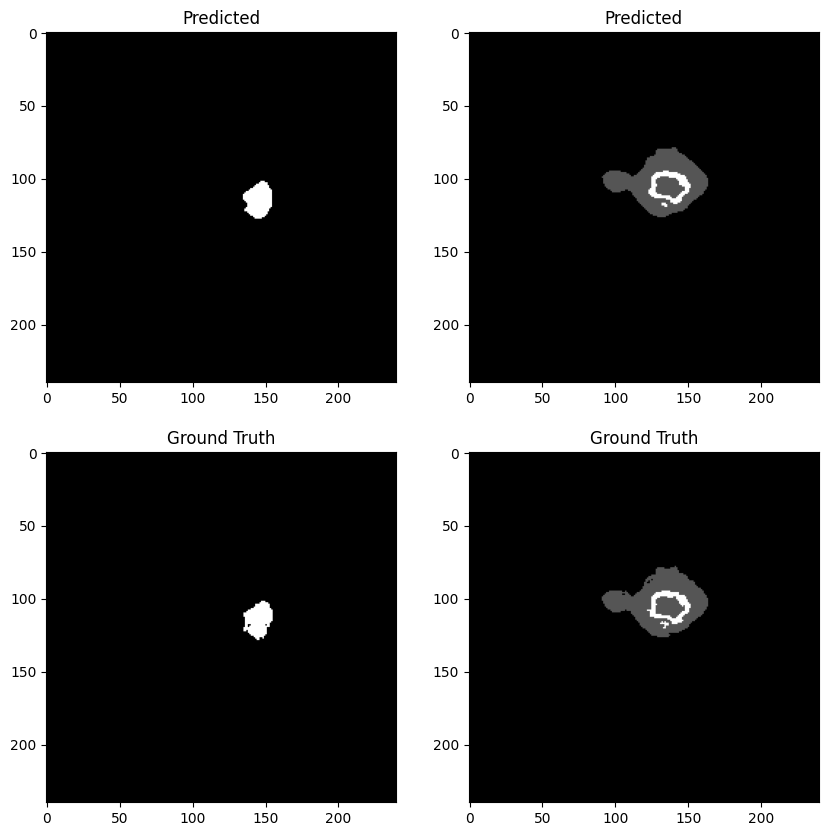

100%|██████████| 34/34 [02:08<00:00,  3.77s/it]


Average Validation Loss: 0.007247196181732065

Average Validation DSC: [0.99932129 0.89906475 0.93629411 0.79754809]
Average Validation ASSD: [ 0.0877443  15.17329382 11.02114725 17.16866782]
Epoch 81/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


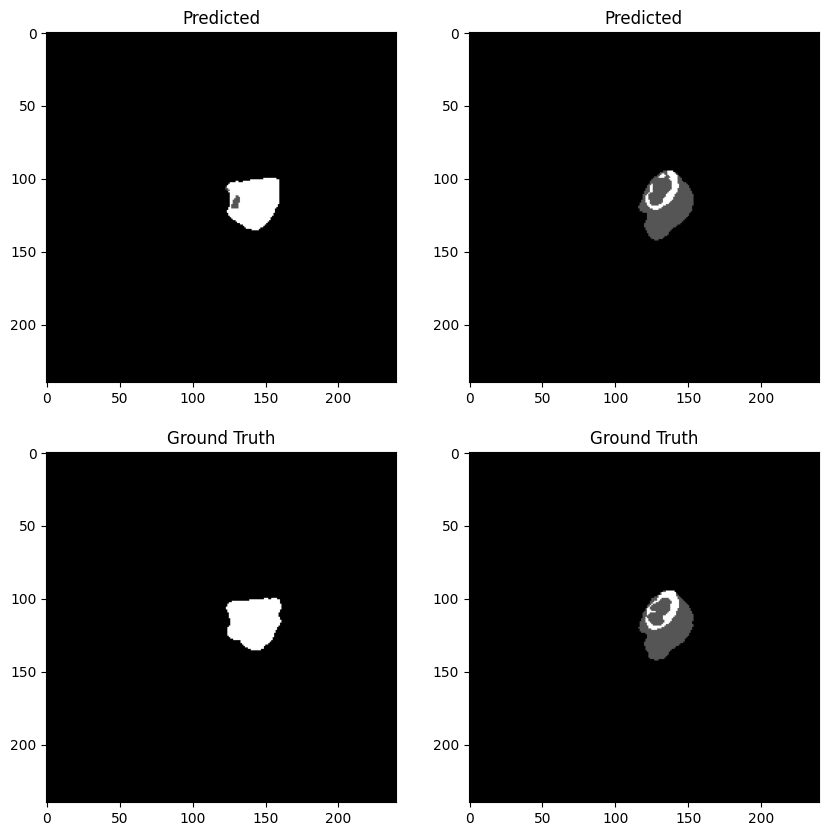

100%|██████████| 136/136 [09:36<00:00,  4.24s/it]



Average Training Loss: 0.003935015080702107

Average Training DSC: [0.99956865 0.94205176 0.9632592  0.85533739]
Average Training ASSD: [ 0.05543522  3.87605135  4.88182517 13.58305669]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


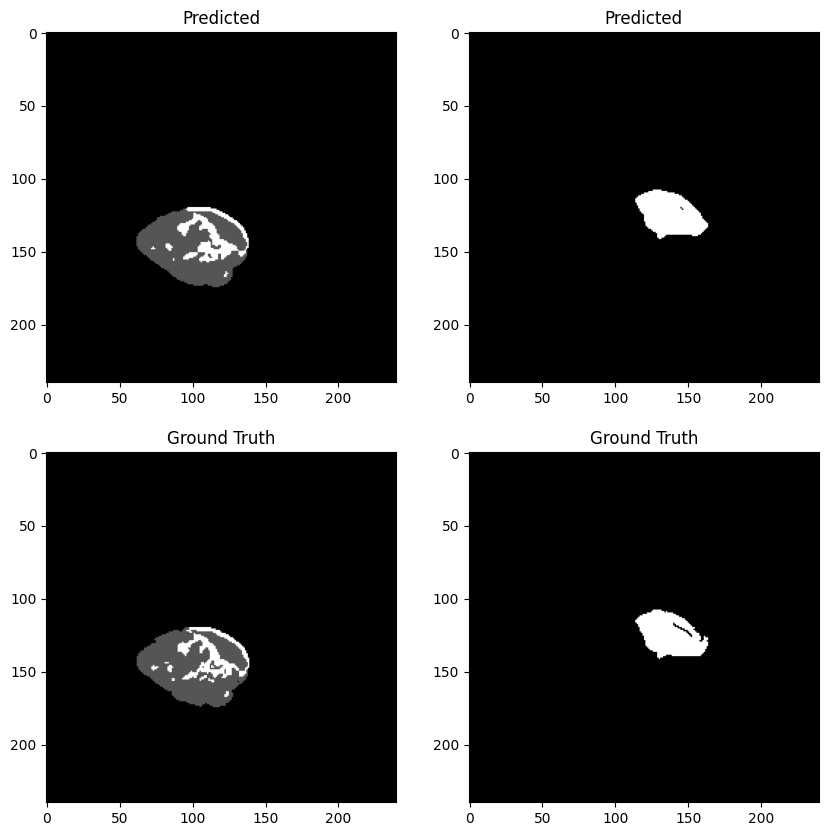

100%|██████████| 34/34 [02:13<00:00,  3.93s/it]


Average Validation Loss: 0.00719889227355666

Average Validation DSC: [0.99936521 0.90315859 0.94385802 0.79593545]
Average Validation ASSD: [ 0.0839159  14.90615168  9.49445711 19.35649776]
Epoch 82/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


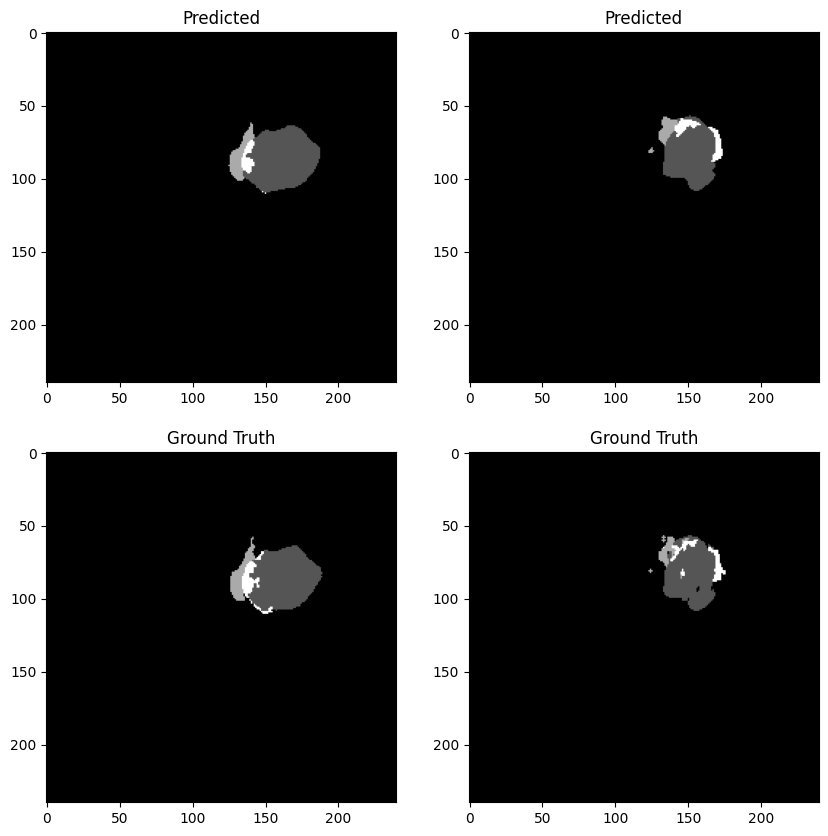

100%|██████████| 136/136 [09:41<00:00,  4.27s/it]



Average Training Loss: 0.003935827570624978

Average Training DSC: [0.99956539 0.94490457 0.95963342 0.85244304]
Average Training ASSD: [ 0.05659117  3.62057421  5.88075402 15.05227102]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


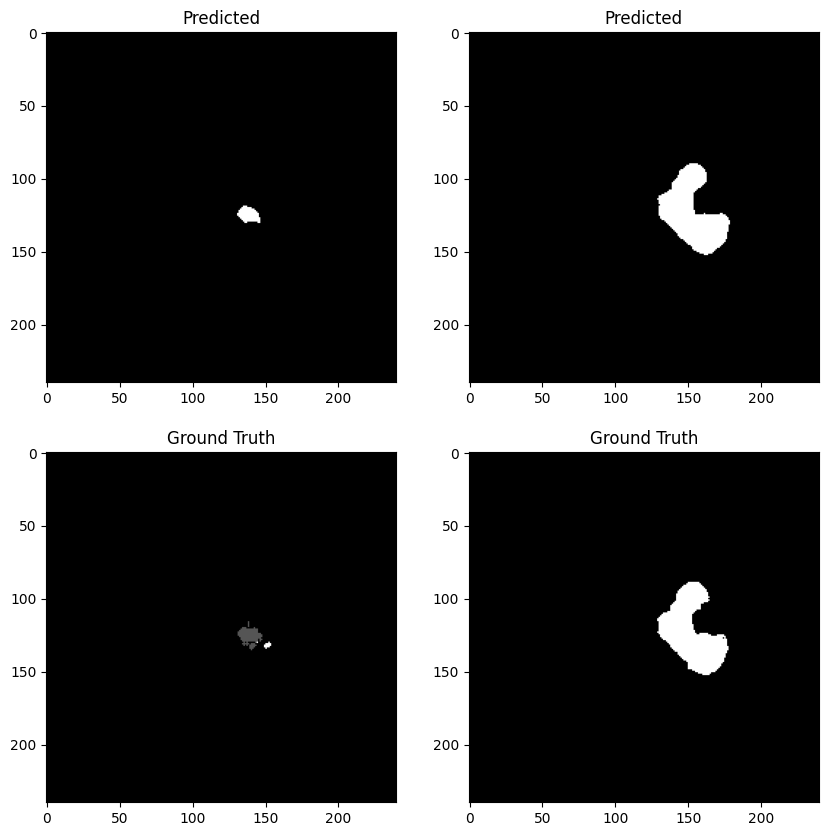

100%|██████████| 34/34 [02:19<00:00,  4.11s/it]


Average Validation Loss: 0.007343532873646301

Average Validation DSC: [0.99933989 0.901048   0.93992704 0.79620925]
Average Validation ASSD: [ 0.08479858 15.9977633  10.52405667 19.10514102]
Epoch 83/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


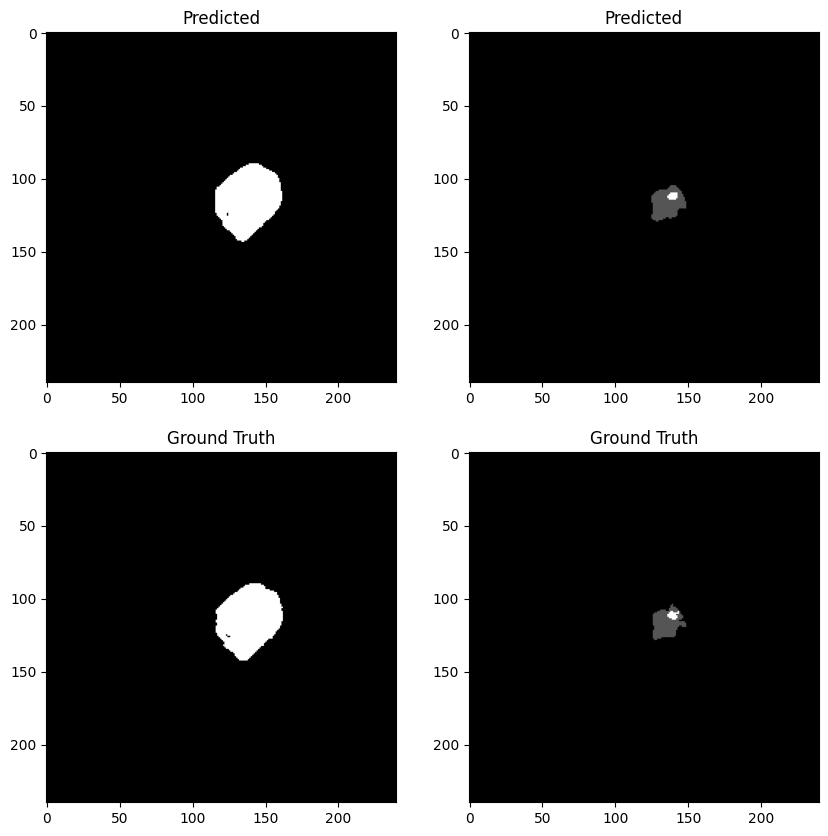

100%|██████████| 136/136 [09:34<00:00,  4.23s/it]



Average Training Loss: 0.003896389127476141

Average Training DSC: [0.99957546 0.94294811 0.96263266 0.85300577]
Average Training ASSD: [ 0.05462719  4.29107554  5.051619   14.27289915]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


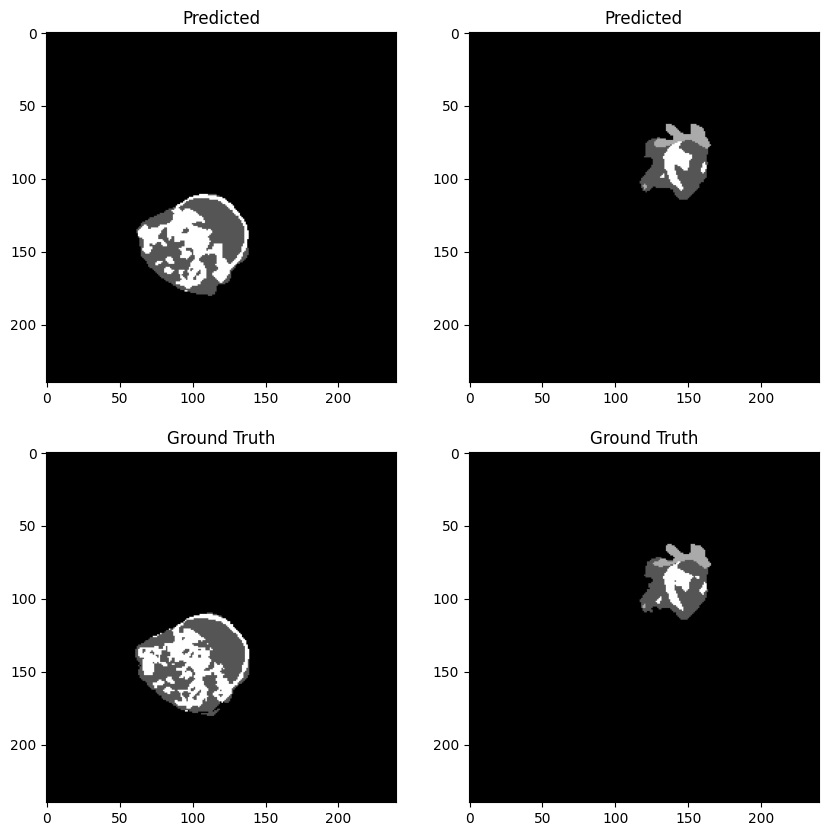

100%|██████████| 34/34 [02:16<00:00,  4.01s/it]


Average Validation Loss: 0.007119313149493845

Average Validation DSC: [0.99936877 0.89382662 0.93526888 0.80841821]
Average Validation ASSD: [ 0.08097687 17.66431162 11.83865885 14.62483473]
Epoch 84/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


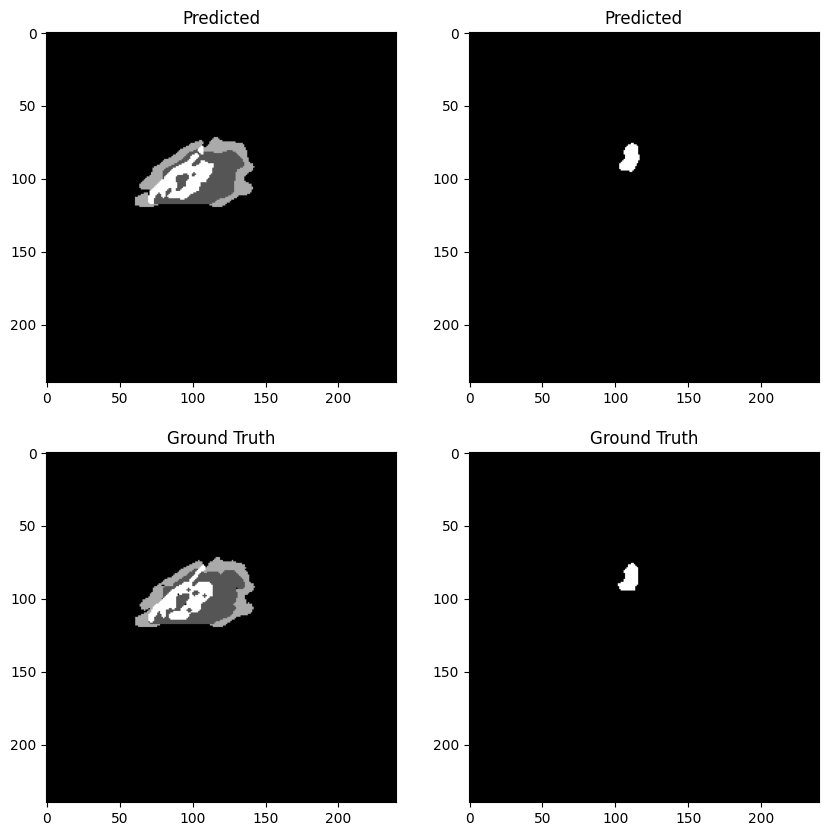

100%|██████████| 136/136 [09:41<00:00,  4.28s/it]



Average Training Loss: 0.00377731399716782

Average Training DSC: [0.99958488 0.94457652 0.96418956 0.85629222]
Average Training ASSD: [ 0.05340532  3.86722351  4.30129983 14.72707311]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


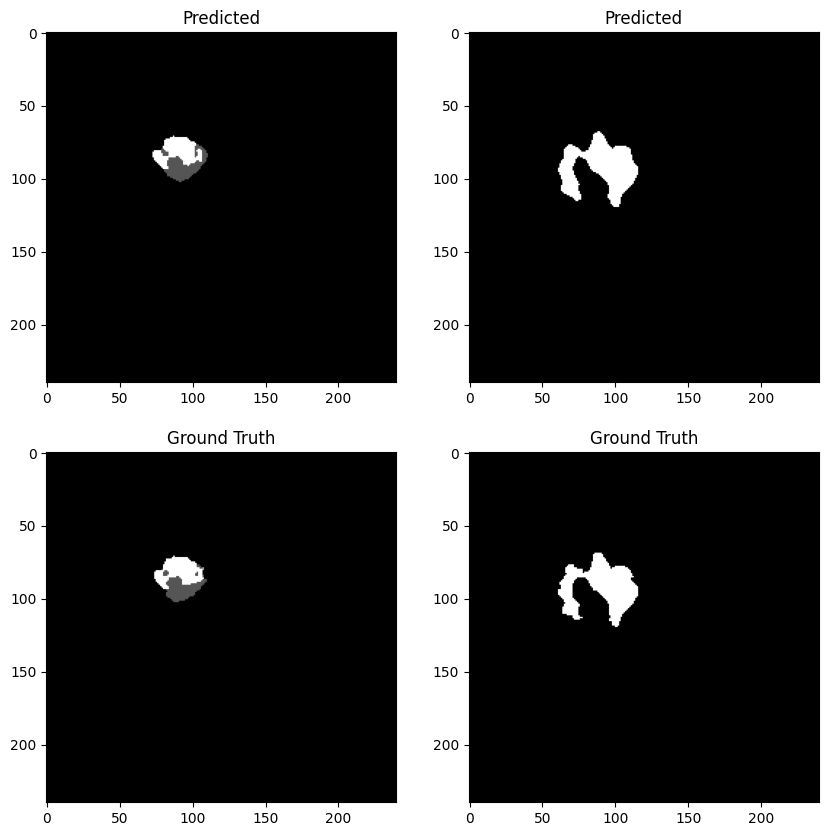

100%|██████████| 34/34 [02:16<00:00,  4.02s/it]


Average Validation Loss: 0.00713930613196948

Average Validation DSC: [0.99935657 0.90000464 0.9456034  0.81111957]
Average Validation ASSD: [ 0.0843336  15.81736686  8.83229321  9.37470897]
Epoch 85/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


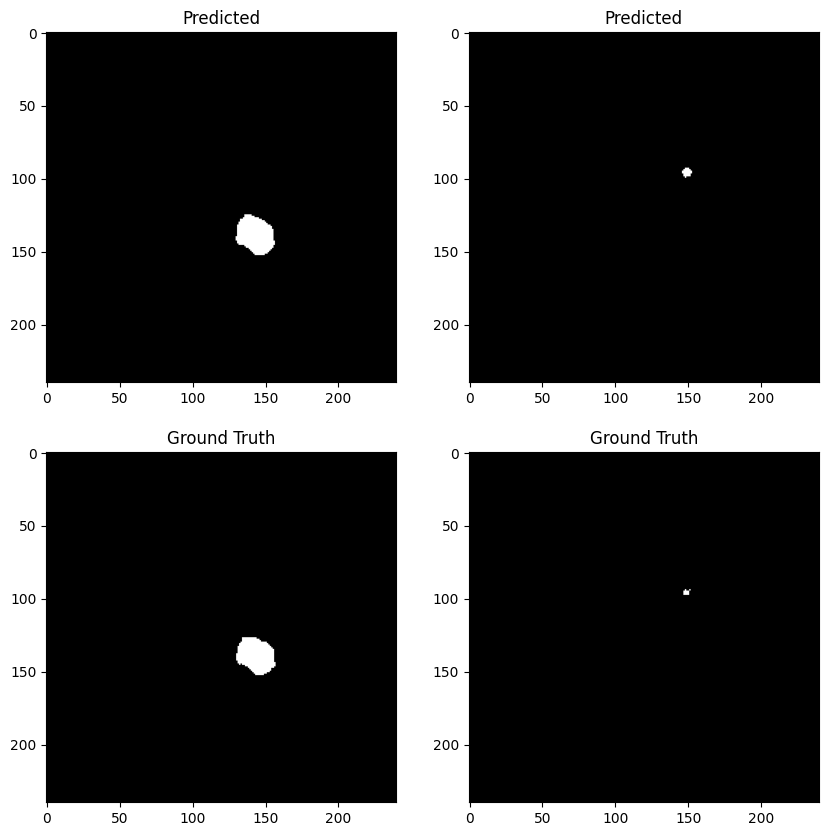

100%|██████████| 136/136 [09:46<00:00,  4.31s/it]



Average Training Loss: 0.0036904658790102556

Average Training DSC: [0.99959827 0.9473036  0.96474455 0.86207426]
Average Training ASSD: [ 0.0511202   3.59864522  4.46731907 14.11548984]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


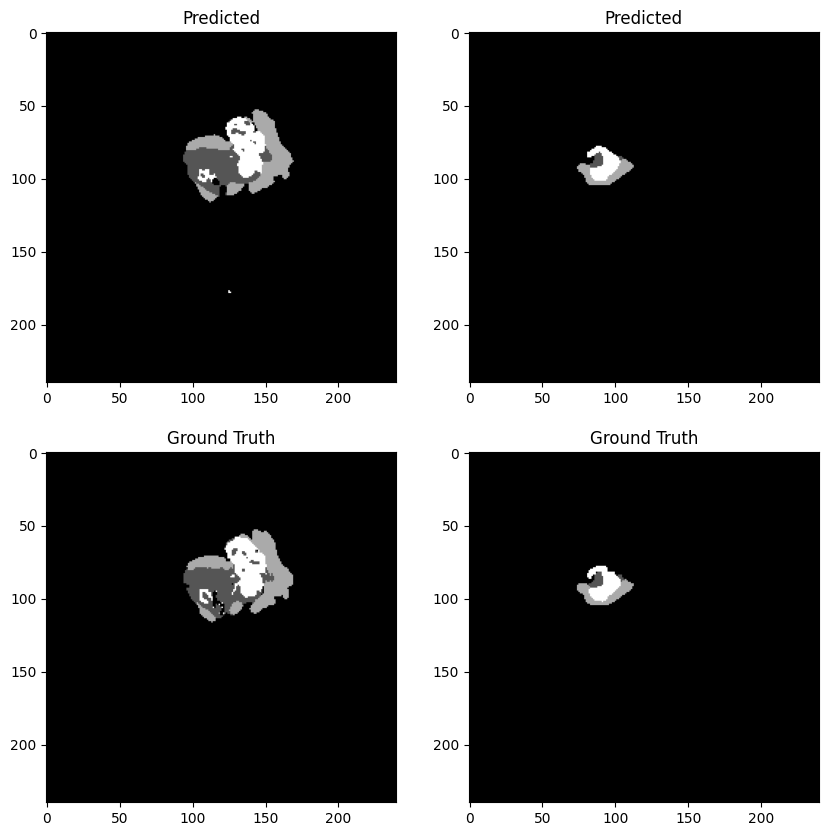

100%|██████████| 34/34 [02:15<00:00,  3.98s/it]


Average Validation Loss: 0.006995800334741087

Average Validation DSC: [0.99938924 0.90663444 0.94354567 0.8112069 ]
Average Validation ASSD: [ 0.07874876 13.15584974  8.2556     15.11820965]
Epoch 86/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


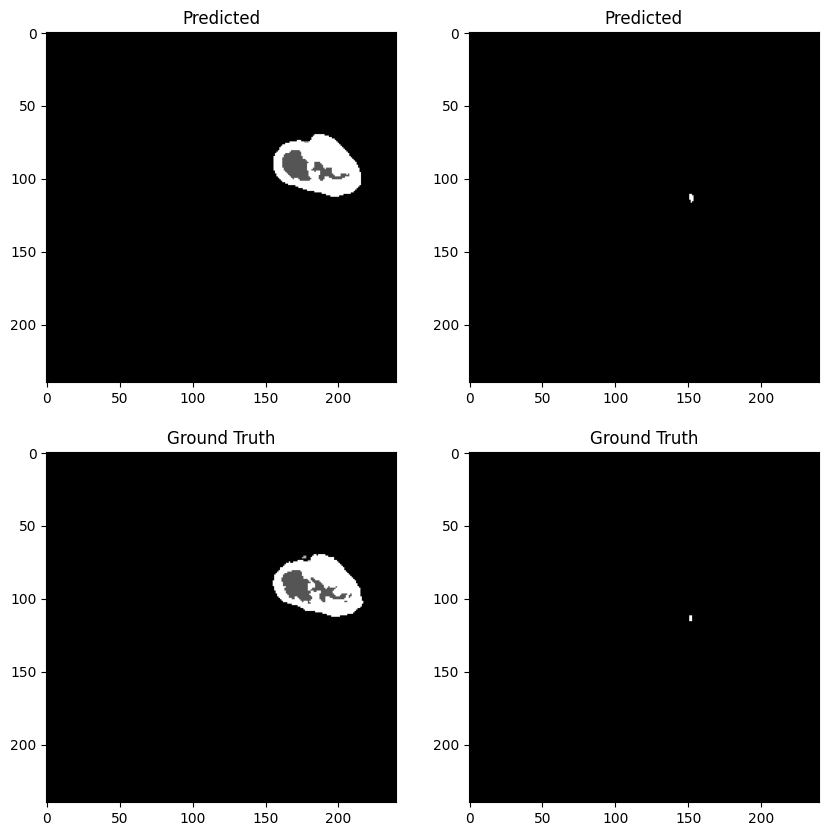

100%|██████████| 136/136 [09:22<00:00,  4.13s/it]



Average Training Loss: 0.0038999419090995457

Average Training DSC: [0.99957807 0.93942061 0.96322775 0.8559159 ]
Average Training ASSD: [ 0.05373371  5.60943674  4.97195726 13.53246105]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


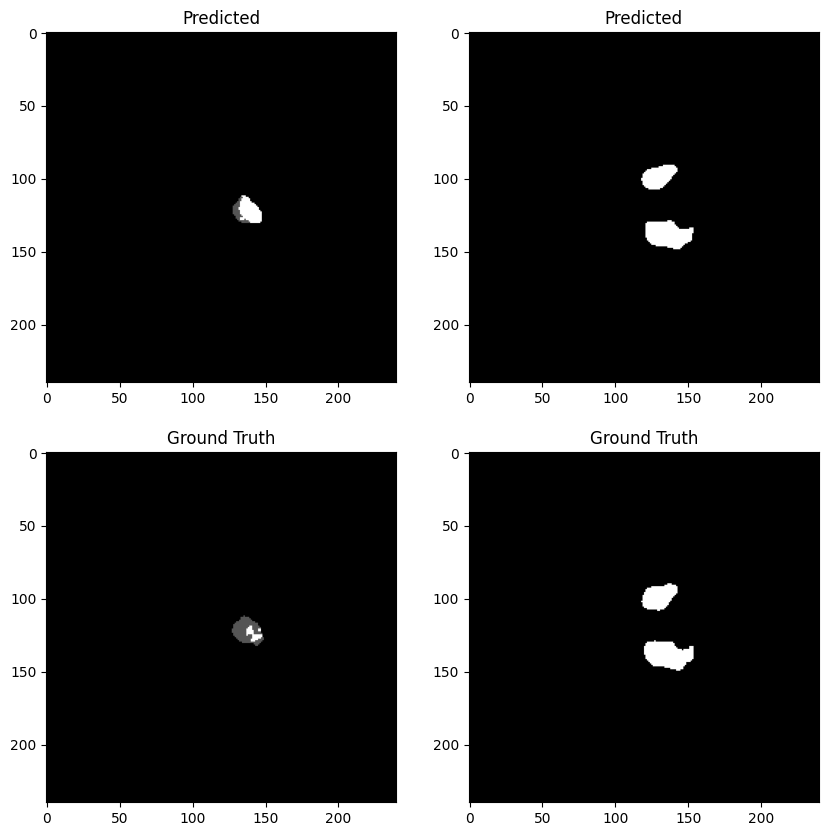

100%|██████████| 34/34 [02:16<00:00,  4.02s/it]


Average Validation Loss: 0.007055849151904969

Average Validation DSC: [0.99935752 0.89721619 0.94510113 0.8025219 ]
Average Validation ASSD: [ 0.08434251 15.70177657  8.826561   13.57431483]
Epoch 87/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


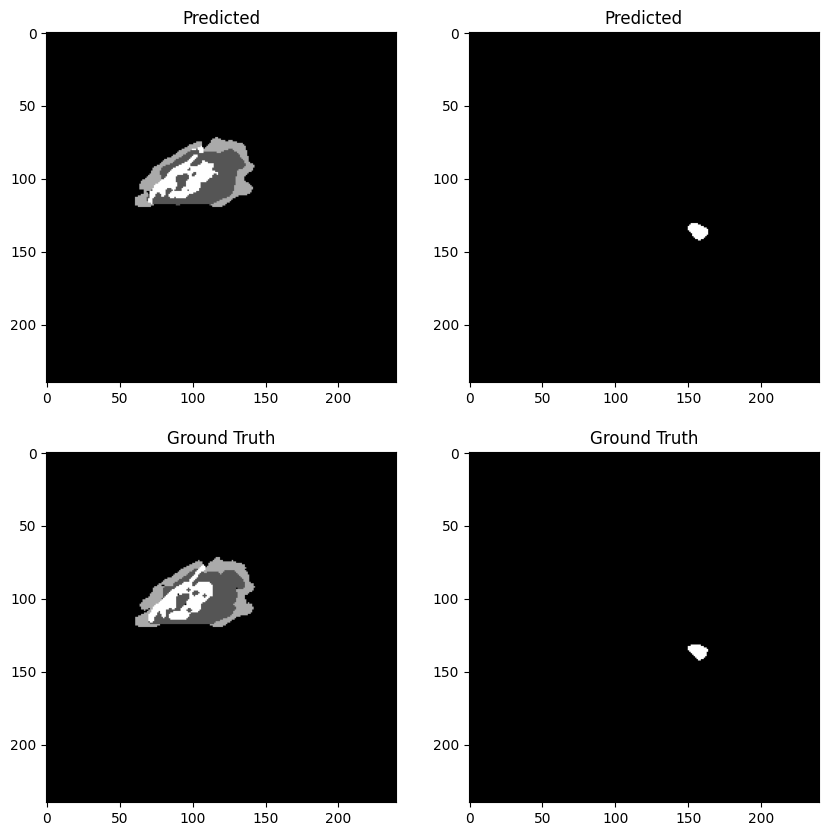

100%|██████████| 136/136 [09:42<00:00,  4.28s/it]



Average Training Loss: 0.004311215048587388

Average Training DSC: [0.99952228 0.92998165 0.95327141 0.84131081]
Average Training ASSD: [ 0.06281698  7.47172571  7.5696575  13.83799813]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


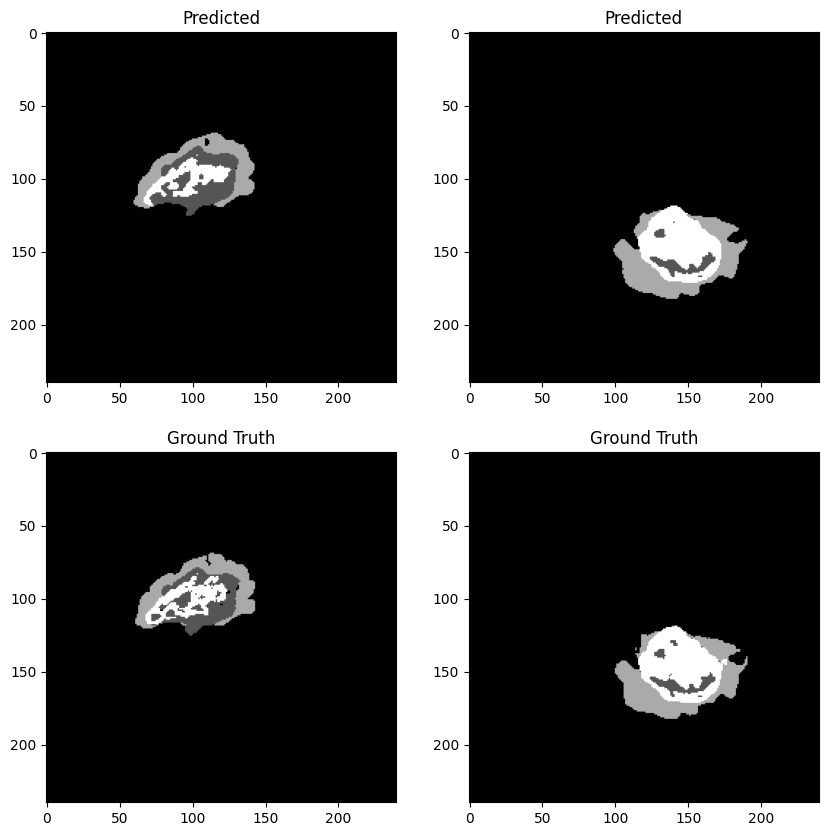

100%|██████████| 34/34 [02:14<00:00,  3.96s/it]


Average Validation Loss: 0.007047999294146019

Average Validation DSC: [0.9993444  0.90290767 0.93473536 0.80718303]
Average Validation ASSD: [ 0.08556014 14.67513089 11.19356732 11.45813048]
Epoch 88/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


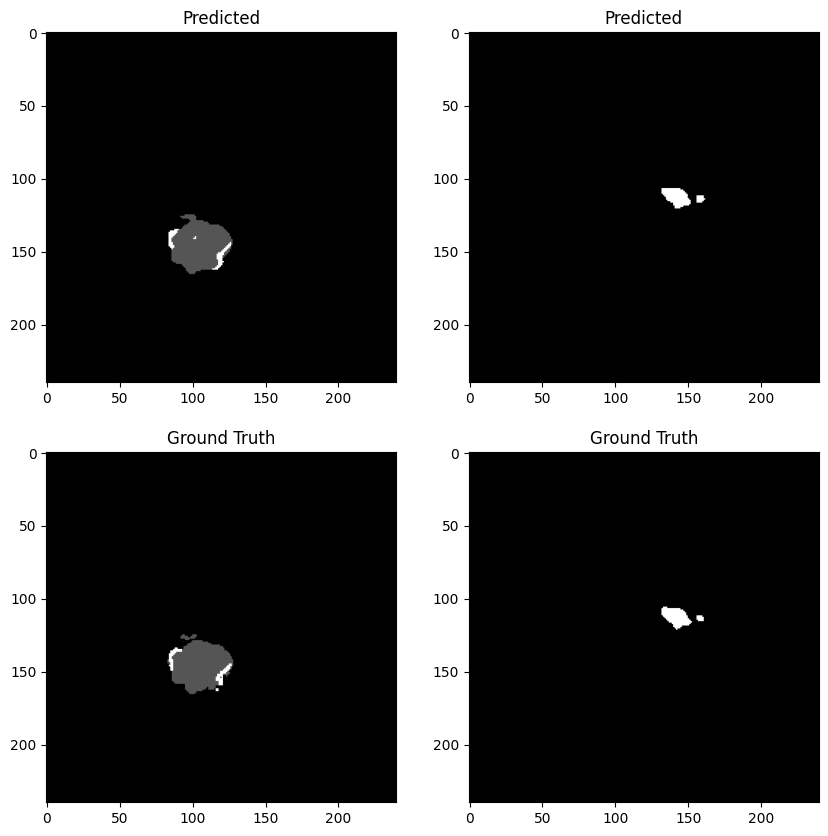

100%|██████████| 136/136 [09:42<00:00,  4.28s/it]



Average Training Loss: 0.004715527597855886

Average Training DSC: [0.99948668 0.9217304  0.94878716 0.83388213]
Average Training ASSD: [ 0.06830438  9.16412522  8.48946676 14.26722021]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


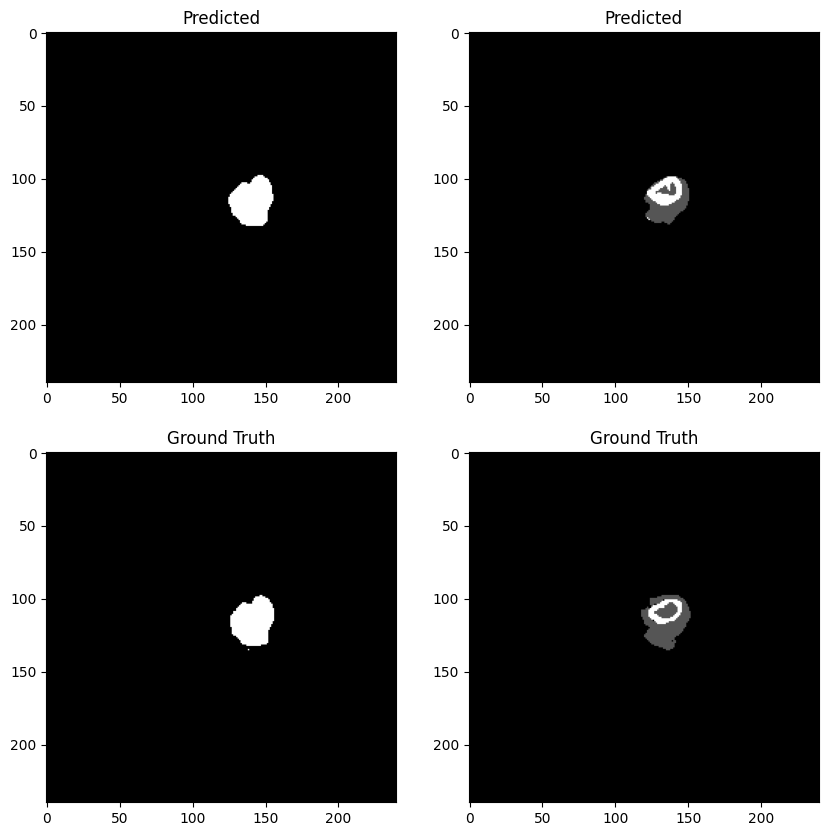

100%|██████████| 34/34 [02:19<00:00,  4.09s/it]


Average Validation Loss: 0.0082851414267412

Average Validation DSC: [0.99915529 0.86071105 0.82701239 0.78343841]
Average Validation ASSD: [ 0.18563486 26.28663861 46.59561182 11.63459355]
Epoch 89/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


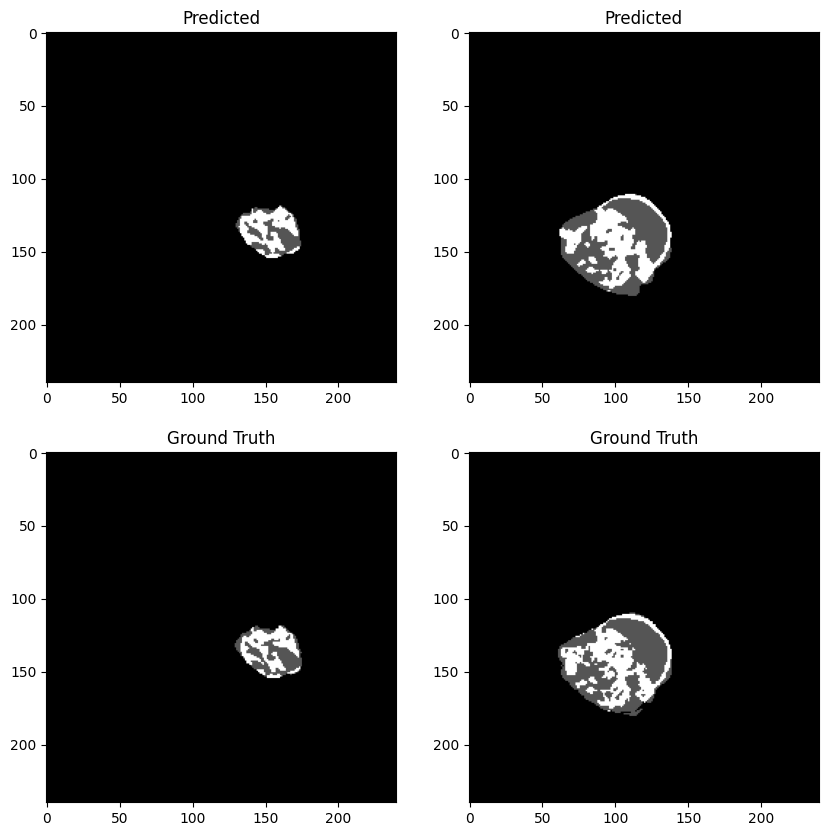

100%|██████████| 136/136 [09:46<00:00,  4.31s/it]



Average Training Loss: 0.0054302718558841764

Average Training DSC: [0.9994113  0.91043865 0.94541637 0.82263772]
Average Training ASSD: [ 0.08217713 12.18124316  9.25378274 13.31483406]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


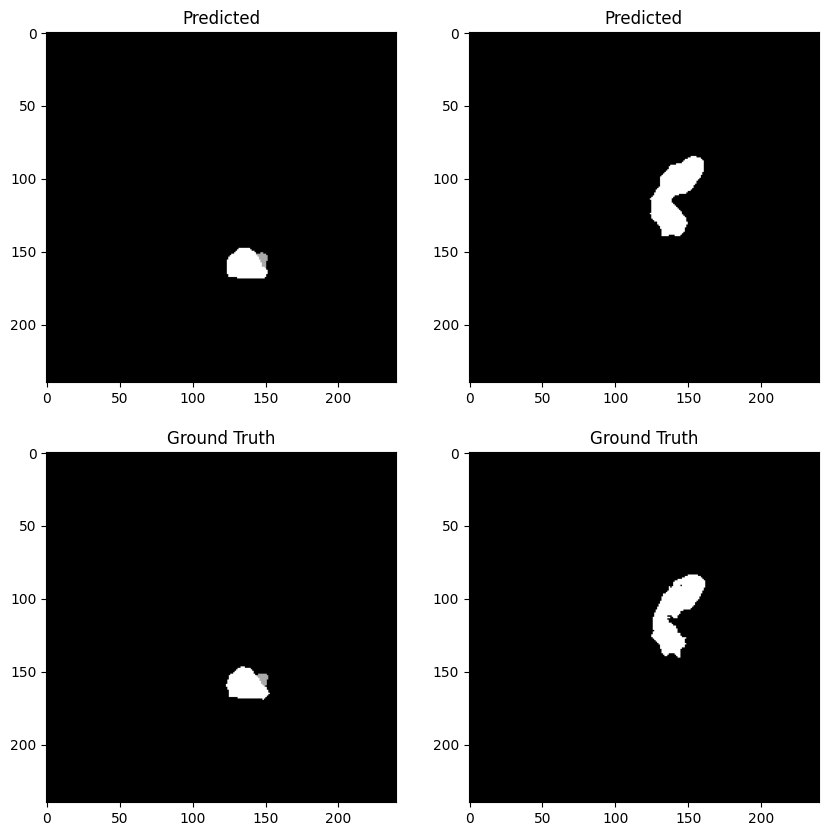

100%|██████████| 34/34 [02:10<00:00,  3.83s/it]


Average Validation Loss: 0.008371647721266045

Average Validation DSC: [0.99917117 0.8693643  0.92201848 0.76594268]
Average Validation ASSD: [ 0.12238013 23.29725601 15.31785029 21.41226831]
Epoch 90/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


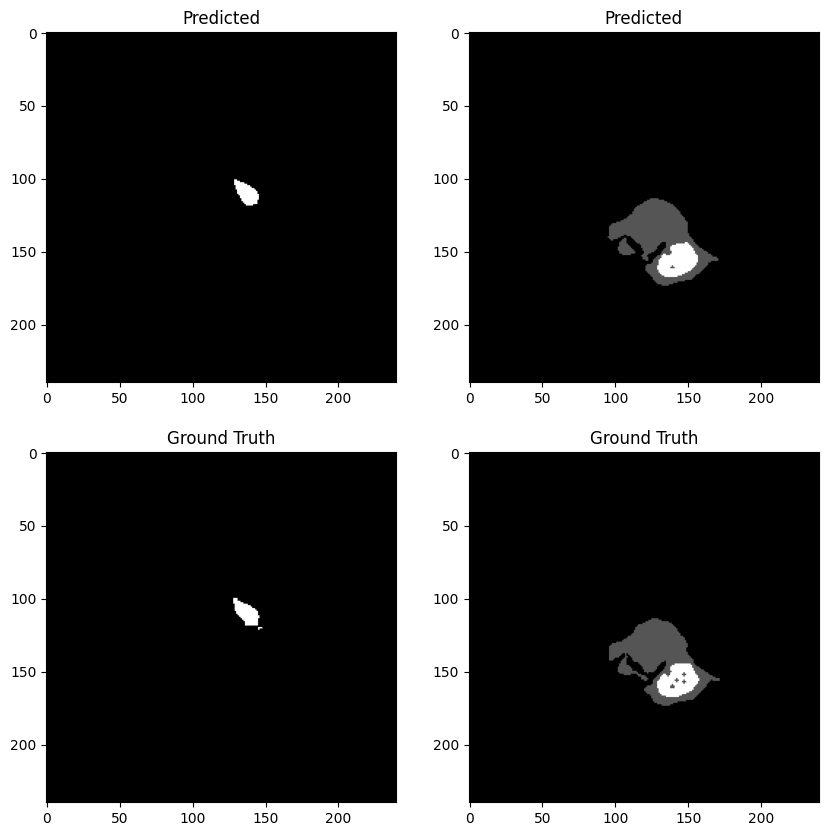

100%|██████████| 136/136 [09:42<00:00,  4.28s/it]



Average Training Loss: 0.004934675089316443

Average Training DSC: [0.99946343 0.9176528  0.95066685 0.83197341]
Average Training ASSD: [ 0.07181082 10.99469226  7.92134357 12.74332431]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


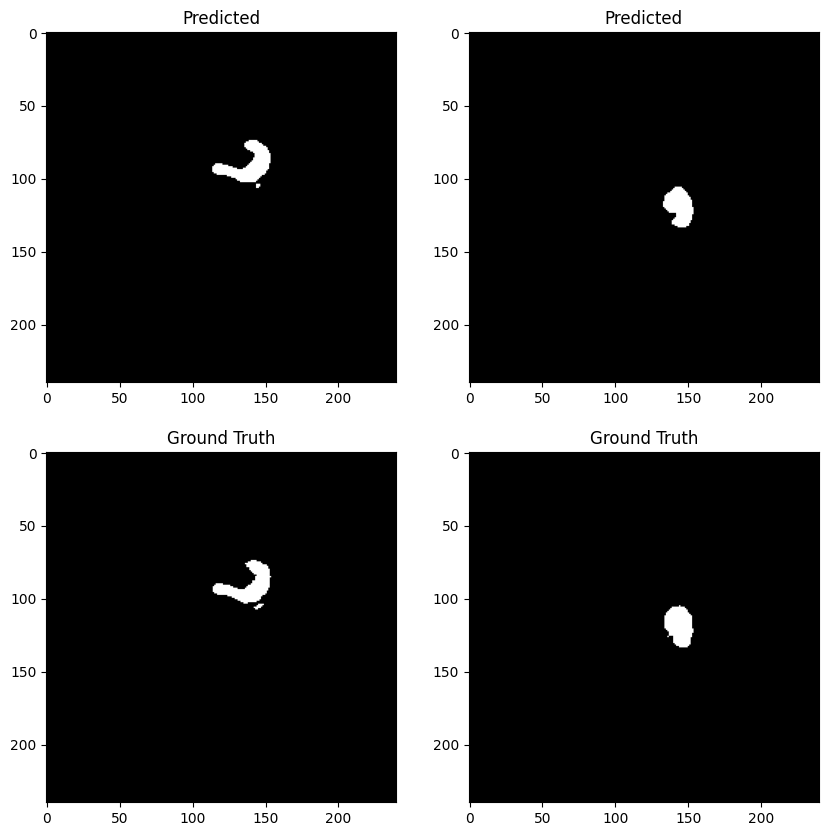

100%|██████████| 34/34 [02:15<00:00,  3.97s/it]


Average Validation Loss: 0.008893924463978586

Average Validation DSC: [0.99910031 0.86315789 0.93262783 0.74999861]
Average Validation ASSD: [ 0.139416   26.91976133 10.96903943 26.20557294]
Epoch 91/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


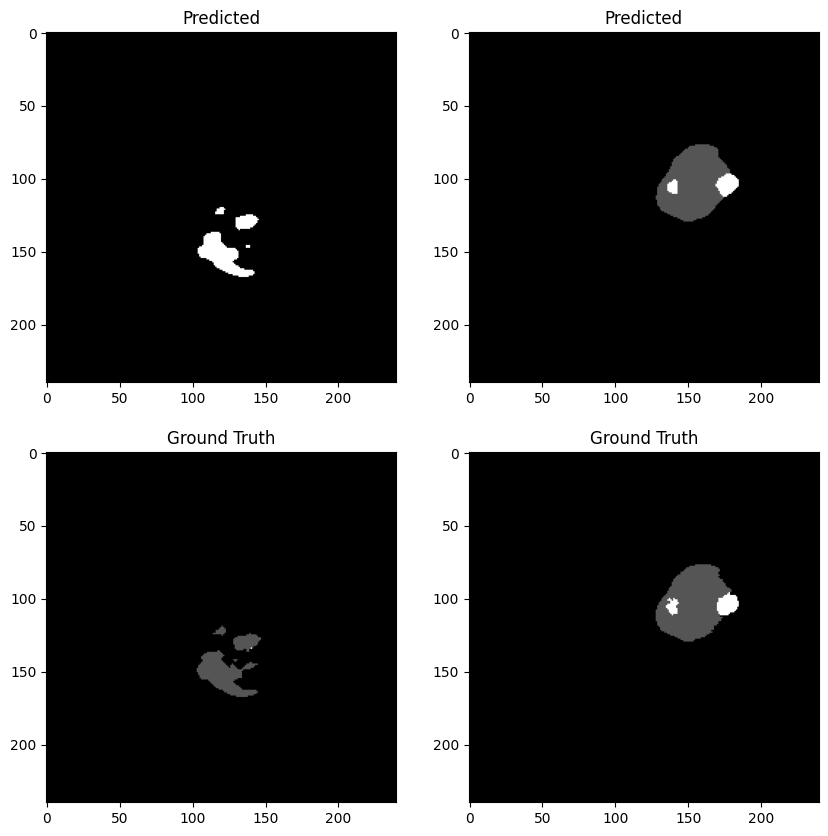

100%|██████████| 136/136 [09:37<00:00,  4.24s/it]



Average Training Loss: 0.005034566545338535

Average Training DSC: [0.99944586 0.91872306 0.94854951 0.82999734]
Average Training ASSD: [ 0.07708911 10.49300071  8.41141885 14.21590787]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


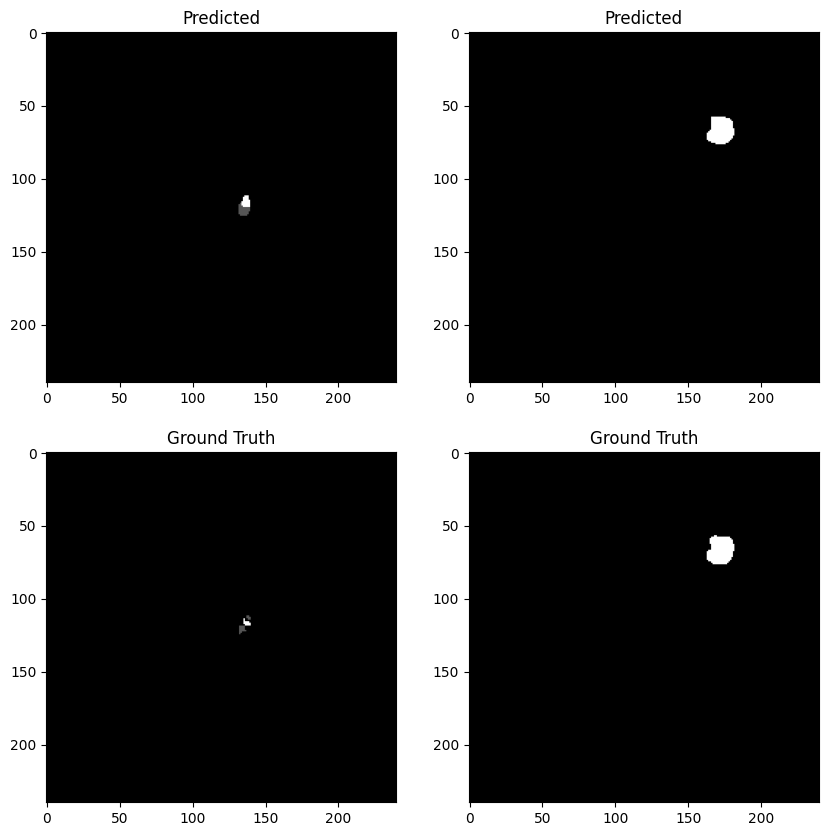

100%|██████████| 34/34 [02:14<00:00,  3.95s/it]


Average Validation Loss: 0.007291015552575974

Average Validation DSC: [0.99928353 0.89015317 0.9313812  0.79142434]
Average Validation ASSD: [ 0.08921079 19.01523862 11.85888058 14.9015964 ]
Epoch 92/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


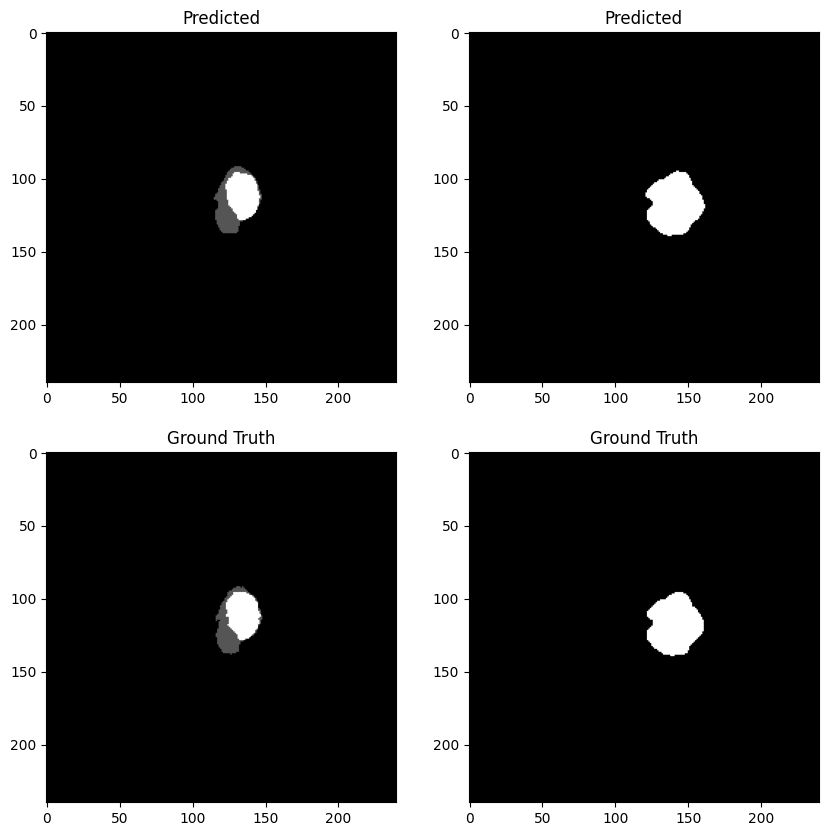

100%|██████████| 136/136 [09:47<00:00,  4.32s/it]



Average Training Loss: 0.0049603885375237204

Average Training DSC: [0.99949297 0.92027192 0.9467118  0.83223237]
Average Training ASSD: [ 0.0668651   9.744225    9.57676232 13.51048026]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


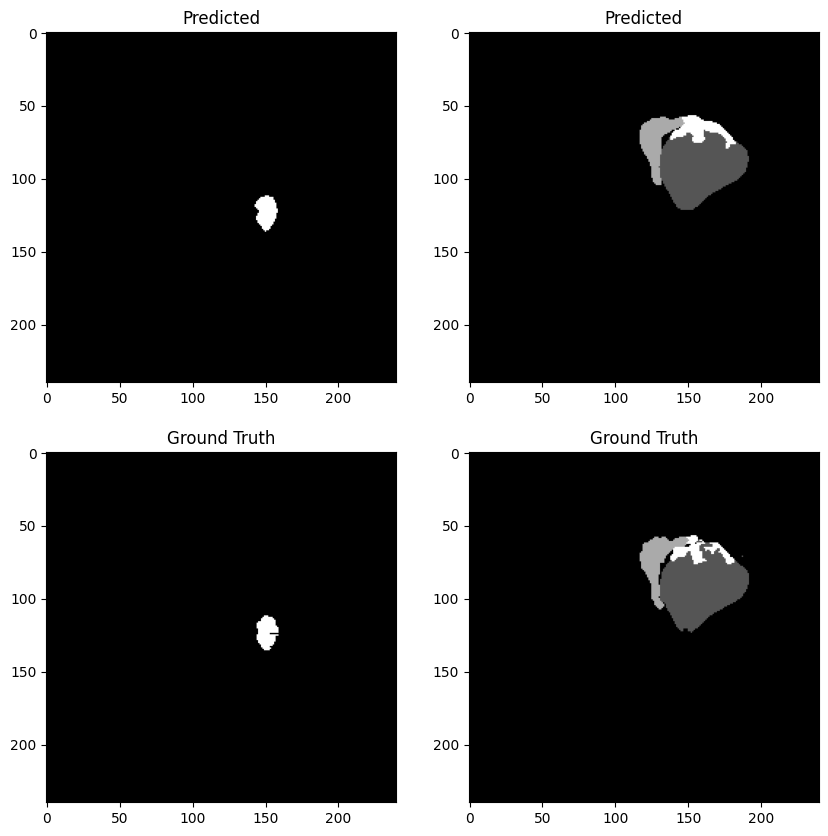

100%|██████████| 34/34 [02:11<00:00,  3.87s/it]


Average Validation Loss: 0.006927393869880368

Average Validation DSC: [0.99931628 0.89409469 0.93951147 0.79992185]
Average Validation ASSD: [ 0.08728075 18.71401237 10.27159927 12.57346994]
Epoch 93/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


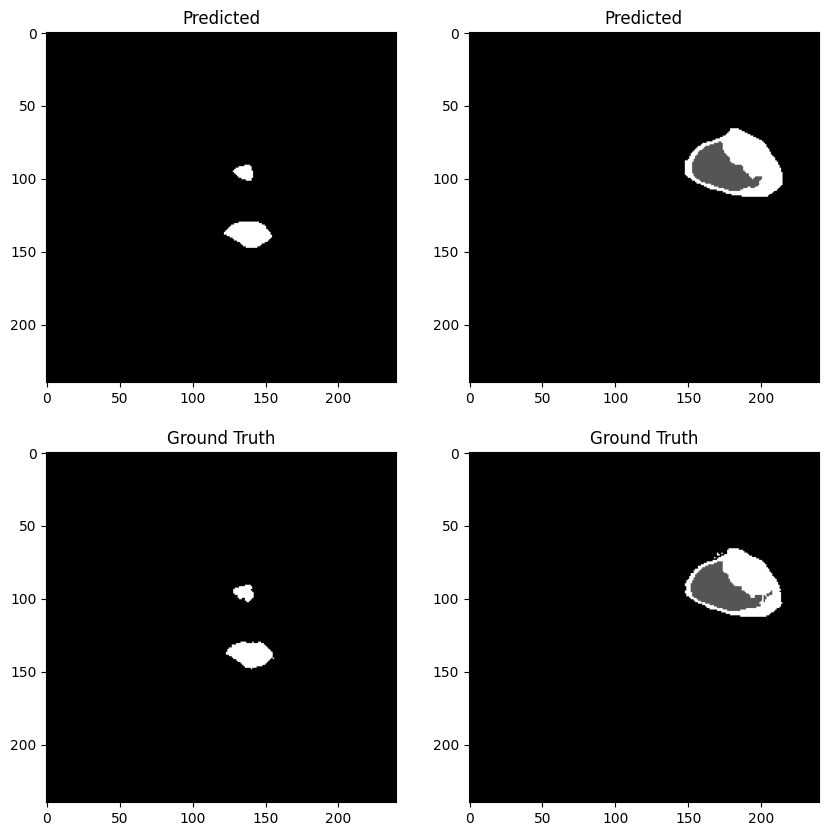

100%|██████████| 136/136 [09:34<00:00,  4.22s/it]



Average Training Loss: 0.0043404257500215485

Average Training DSC: [0.99953784 0.92973    0.95572947 0.84327816]
Average Training ASSD: [ 0.05973377  8.45910271  6.57555464 14.7048228 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


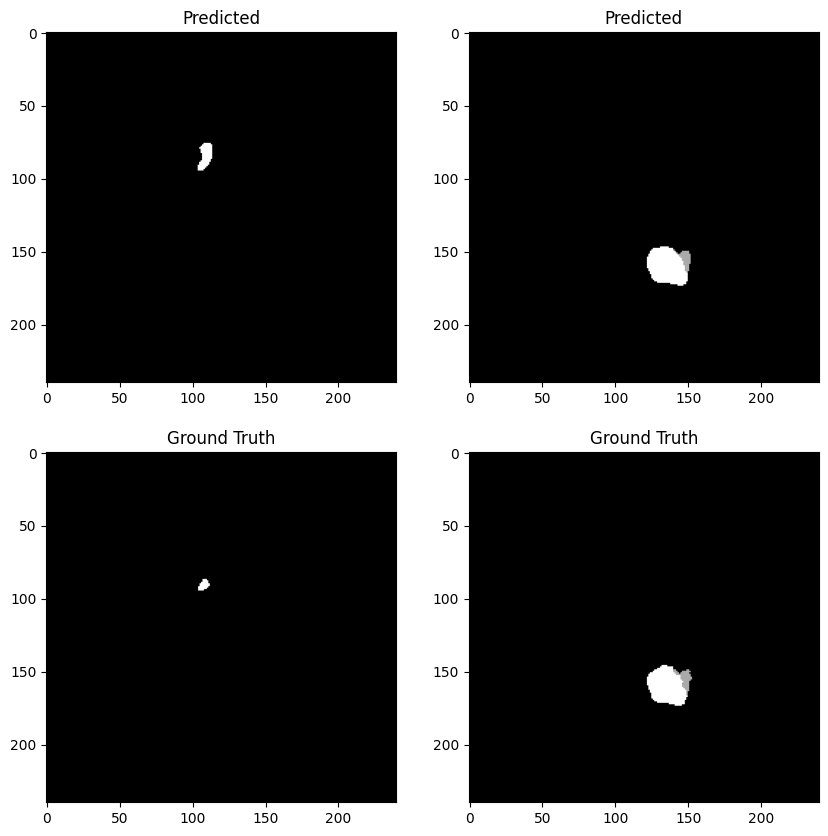

100%|██████████| 34/34 [02:13<00:00,  3.93s/it]


Average Validation Loss: 0.0067235252285814465

Average Validation DSC: [0.99936287 0.90167405 0.9448803  0.806731  ]
Average Validation ASSD: [ 0.08097094 15.39317525  9.16001754 11.9764025 ]
Epoch 94/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


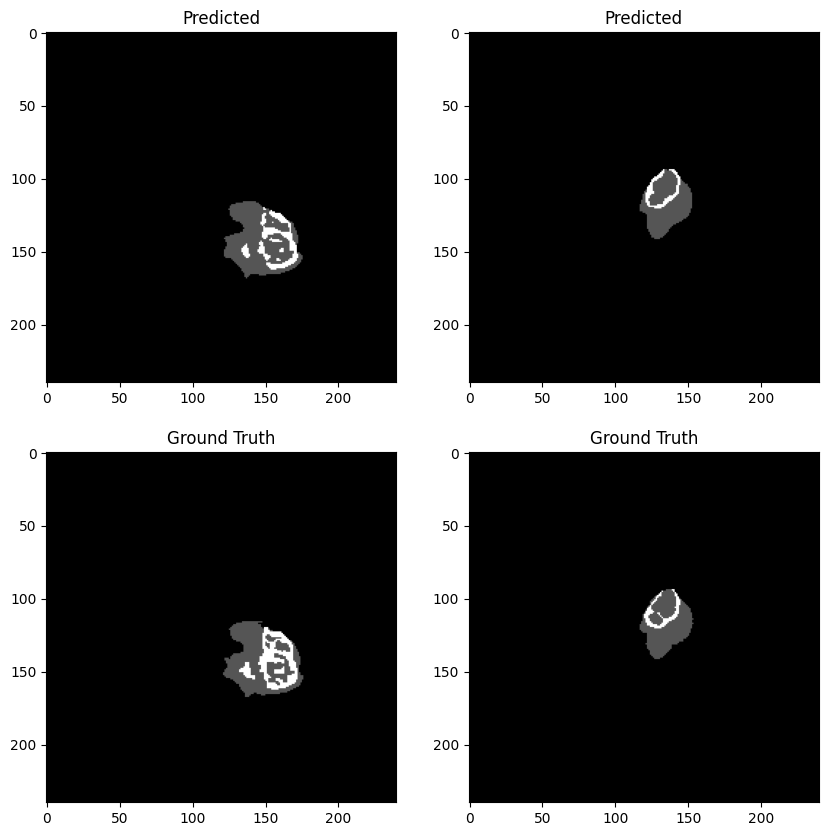

100%|██████████| 136/136 [09:44<00:00,  4.30s/it]



Average Training Loss: 0.0039033377680050977

Average Training DSC: [0.99959036 0.93968668 0.96124487 0.85742474]
Average Training ASSD: [ 0.05342019  5.7803035   5.47018213 13.82661919]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


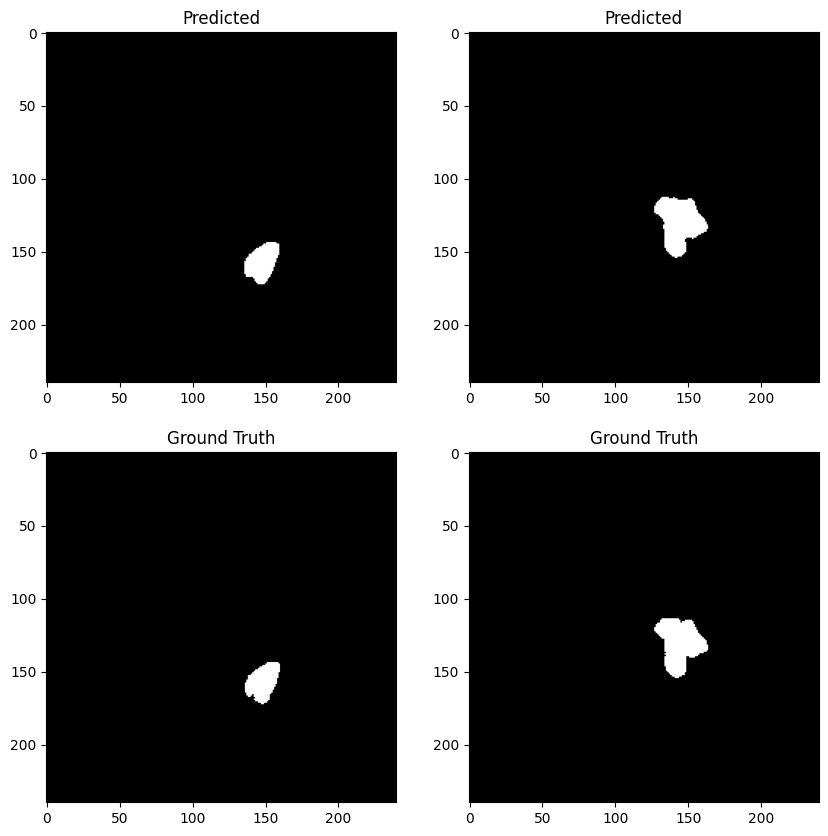

100%|██████████| 34/34 [02:09<00:00,  3.80s/it]


Average Validation Loss: 0.007061830940930282

Average Validation DSC: [0.99933217 0.86179196 0.93944682 0.80355311]
Average Validation ASSD: [ 0.08504489 27.23002844 10.9959807  11.32095028]
Epoch 95/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


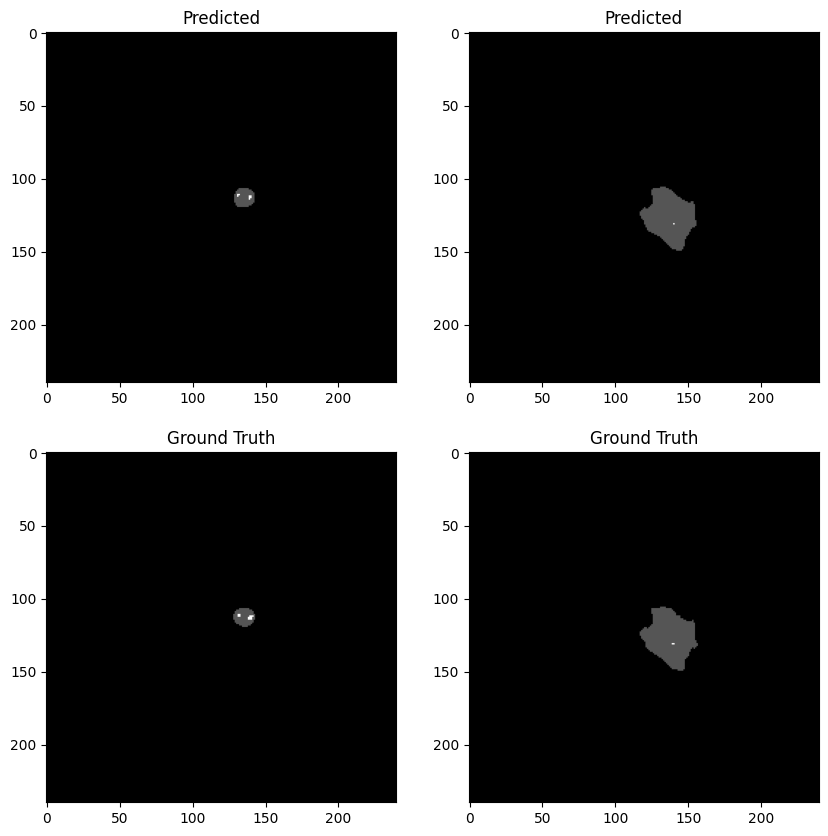

100%|██████████| 136/136 [09:39<00:00,  4.26s/it]



Average Training Loss: 0.0038505577626090277

Average Training DSC: [0.99959586 0.94072256 0.96363066 0.857142  ]
Average Training ASSD: [ 0.05228142  5.4435264   4.96267955 12.98597196]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


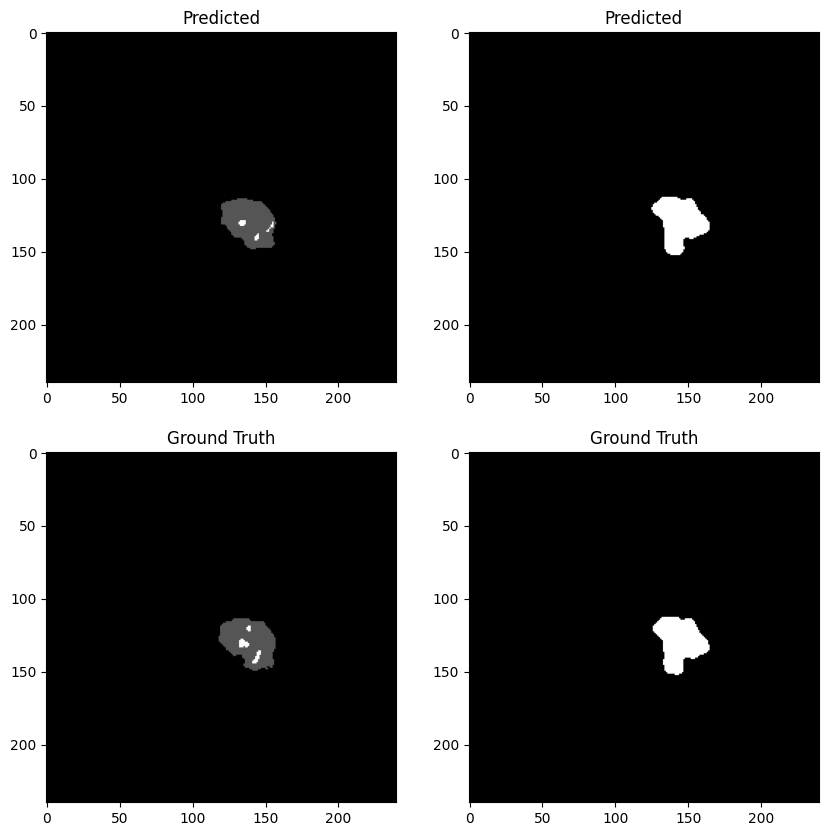

100%|██████████| 34/34 [02:09<00:00,  3.82s/it]


Average Validation Loss: 0.0069029534043853775

Average Validation DSC: [0.99934856 0.9060062  0.9408747  0.81147336]
Average Validation ASSD: [ 0.08280097 13.68583972 10.17377183 14.1190926 ]
Epoch 96/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


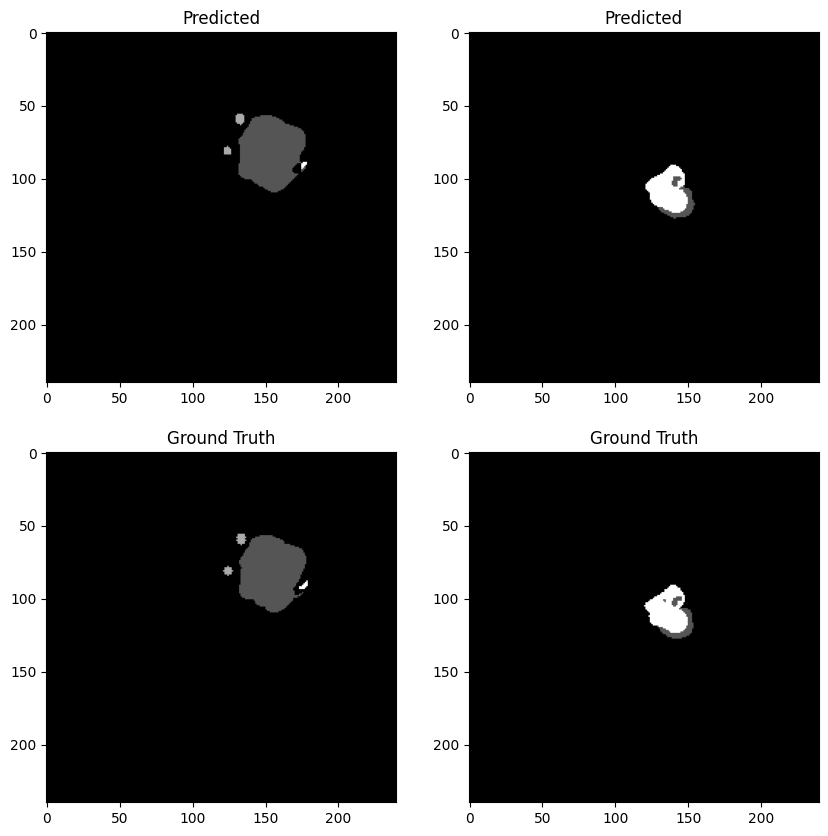

100%|██████████| 136/136 [09:44<00:00,  4.30s/it]



Average Training Loss: 0.0033690832283087622

Average Training DSC: [0.99964    0.95188201 0.96617861 0.87205233]
Average Training ASSD: [ 0.045206    2.75296939  4.86157819 12.46390449]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


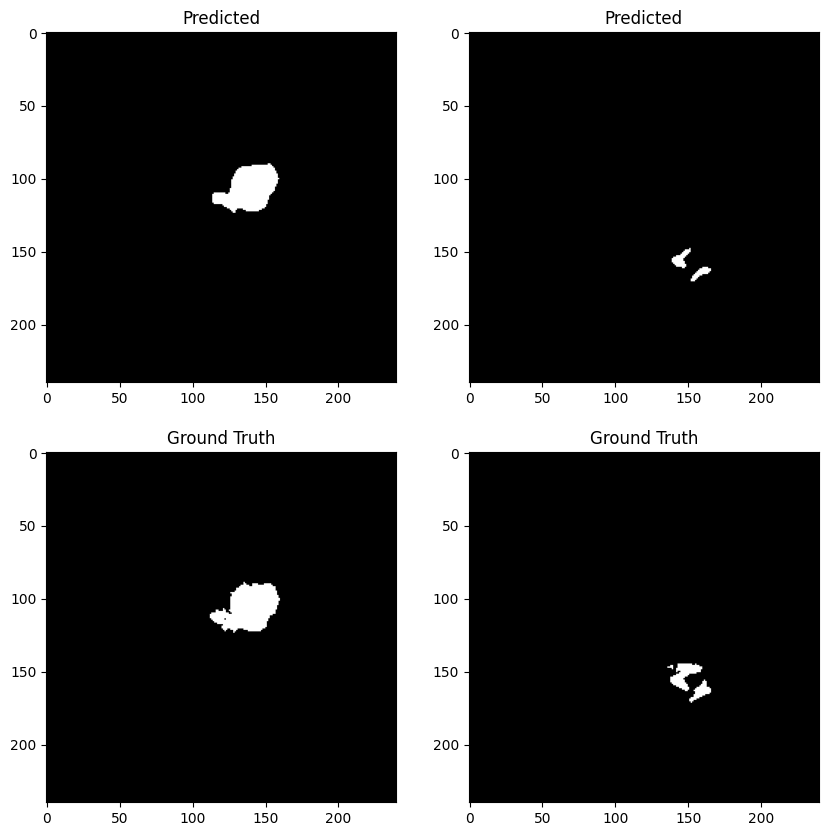

100%|██████████| 34/34 [02:15<00:00,  3.99s/it]


Average Validation Loss: 0.00685879767543691

Average Validation DSC: [0.99939851 0.90514518 0.94239578 0.8143845 ]
Average Validation ASSD: [ 0.07803706 15.63685203 10.50271049 15.17069955]
Epoch 97/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


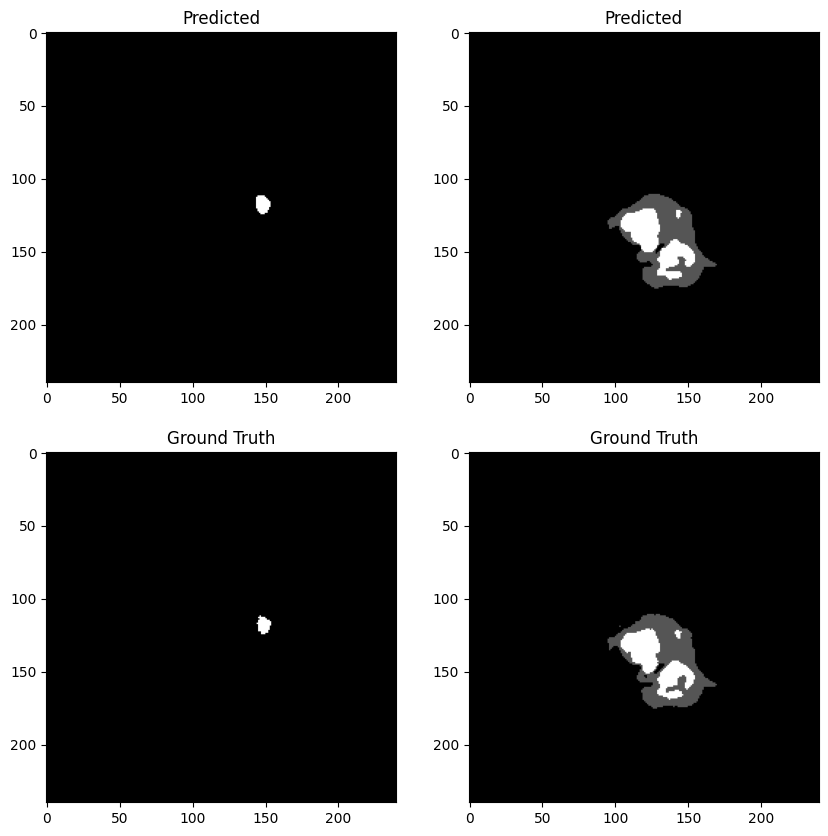

100%|██████████| 136/136 [09:39<00:00,  4.26s/it]



Average Training Loss: 0.0032378590206944328

Average Training DSC: [0.99965983 0.95335457 0.96830185 0.87115223]
Average Training ASSD: [ 0.04340046  2.49686318  3.86756958 13.97904609]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


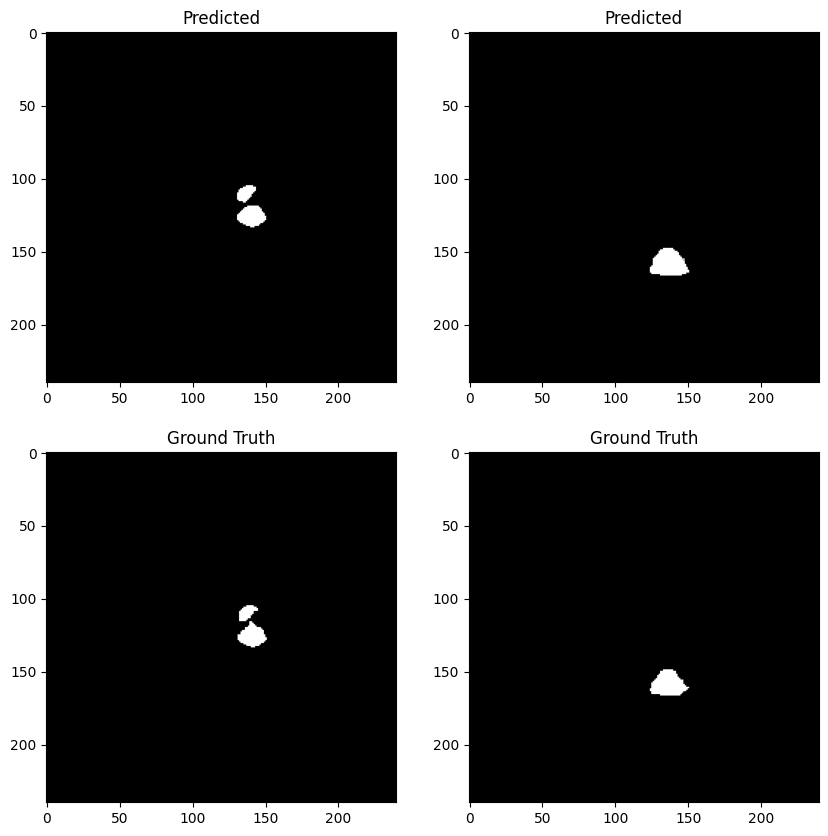

100%|██████████| 34/34 [02:16<00:00,  4.02s/it]


Average Validation Loss: 0.007173241513288196

Average Validation DSC: [0.99938285 0.90592375 0.93936503 0.82030416]
Average Validation ASSD: [ 0.075541   14.06712899 10.50674588 11.64065473]
Epoch 98/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


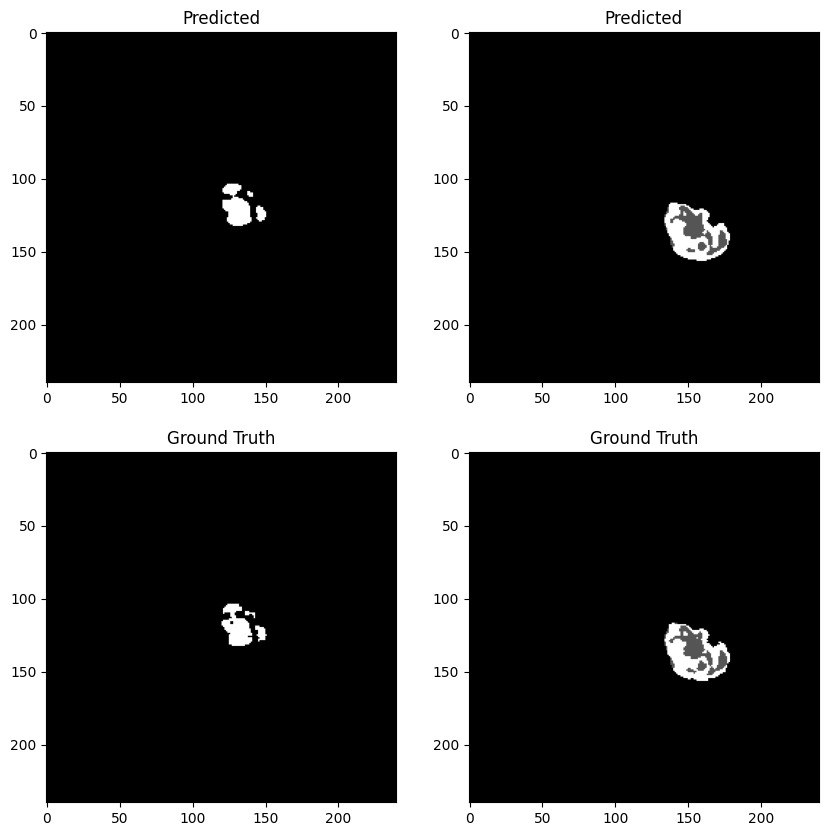

100%|██████████| 136/136 [09:42<00:00,  4.28s/it]



Average Training Loss: 0.0034532908047207028

Average Training DSC: [0.9996276  0.95029893 0.96518399 0.86924993]
Average Training ASSD: [ 0.04775435  3.2508675   4.54436531 13.25971586]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


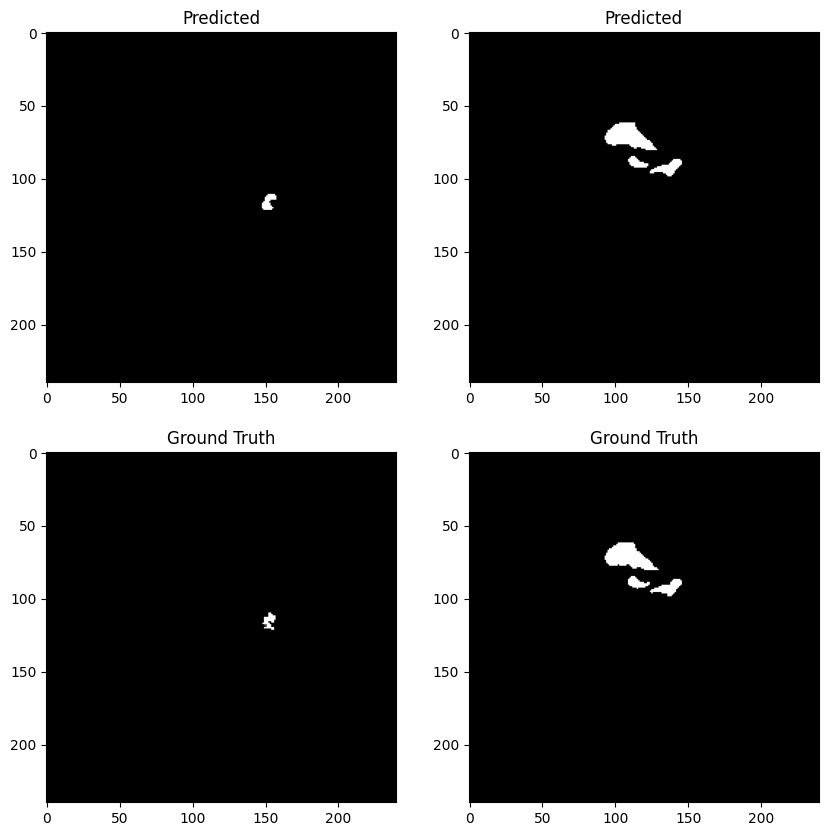

100%|██████████| 34/34 [02:15<00:00,  3.99s/it]


Average Validation Loss: 0.007030709270004402

Average Validation DSC: [0.99940762 0.9114797  0.94576134 0.8172642 ]
Average Validation ASSD: [ 0.07602219 13.63631905  7.5821772  15.13937026]
Epoch 99/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


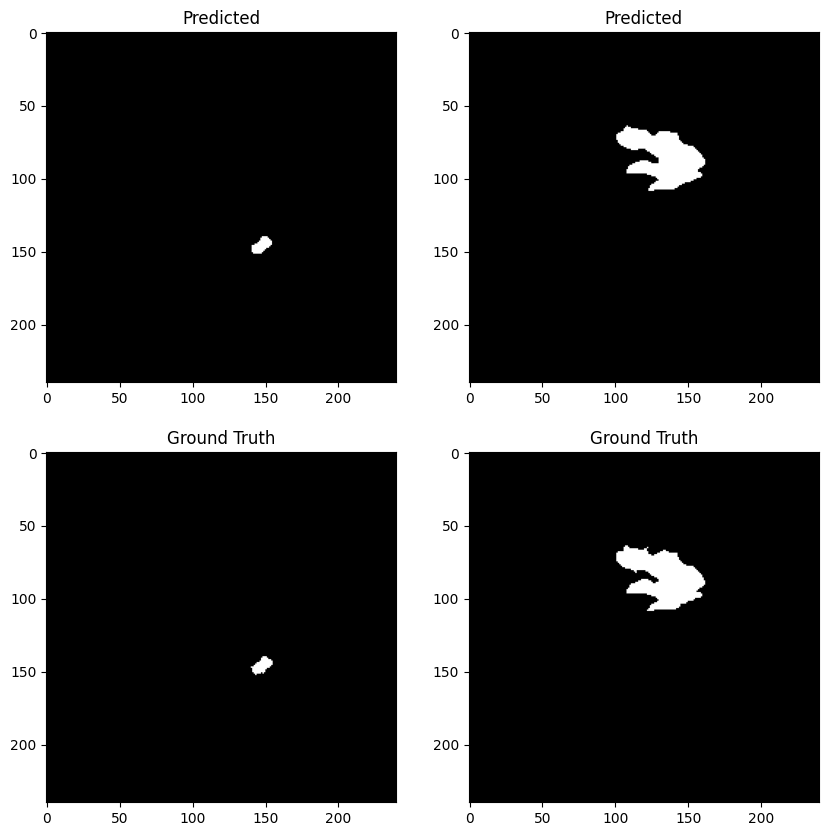

100%|██████████| 136/136 [09:25<00:00,  4.16s/it]



Average Training Loss: 0.003126481787630302

Average Training DSC: [0.99966937 0.95545432 0.97035028 0.87937561]
Average Training ASSD: [ 0.04211969  2.40214047  3.35903224 12.51841073]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


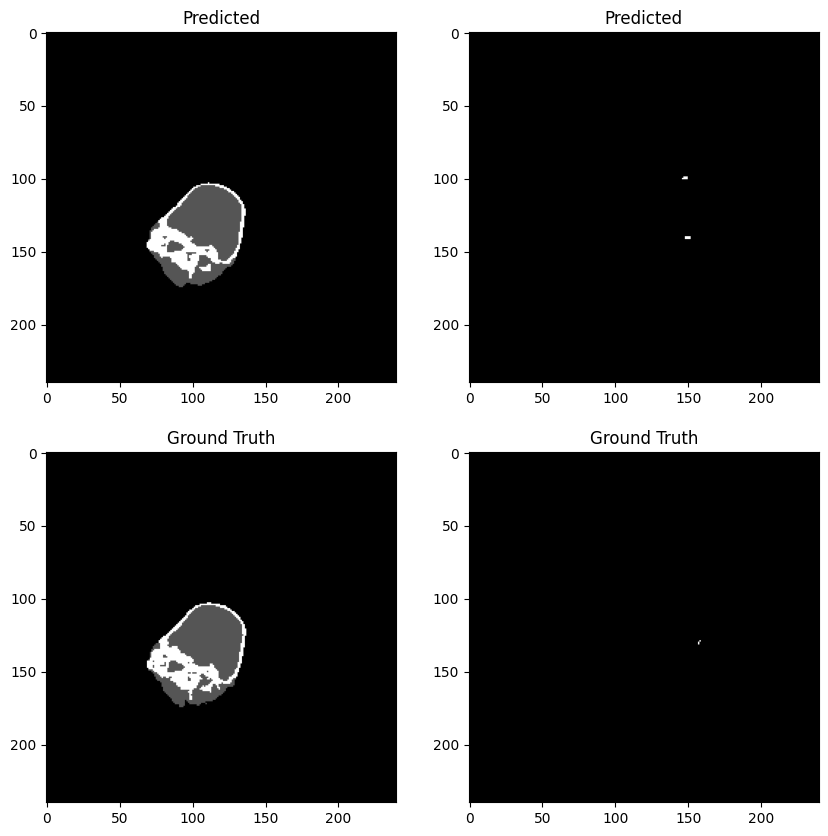

100%|██████████| 34/34 [02:15<00:00,  4.00s/it]


Average Validation Loss: 0.007304938920937917

Average Validation DSC: [0.99939507 0.90881717 0.94666676 0.81198718]
Average Validation ASSD: [ 0.07900774 13.97306597  9.4898804  17.08540903]
Epoch 100/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


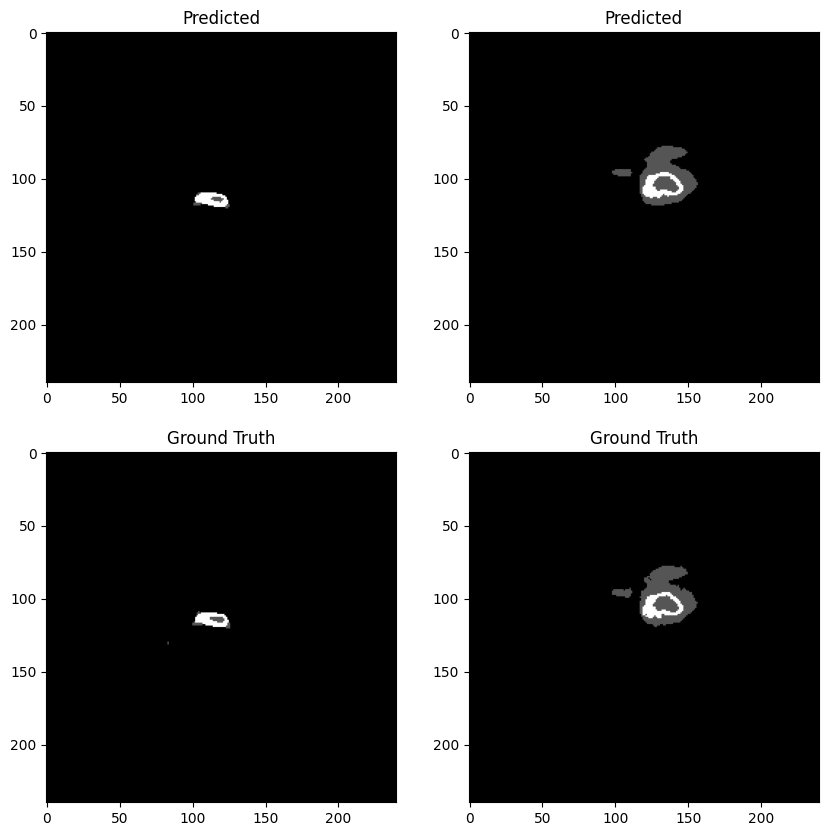

100%|██████████| 136/136 [09:36<00:00,  4.24s/it]



Average Training Loss: 0.0033292407272657487

Average Training DSC: [0.99964303 0.95211829 0.96268437 0.87416326]
Average Training ASSD: [ 0.04472587  2.9955548   5.2969156  12.07946952]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


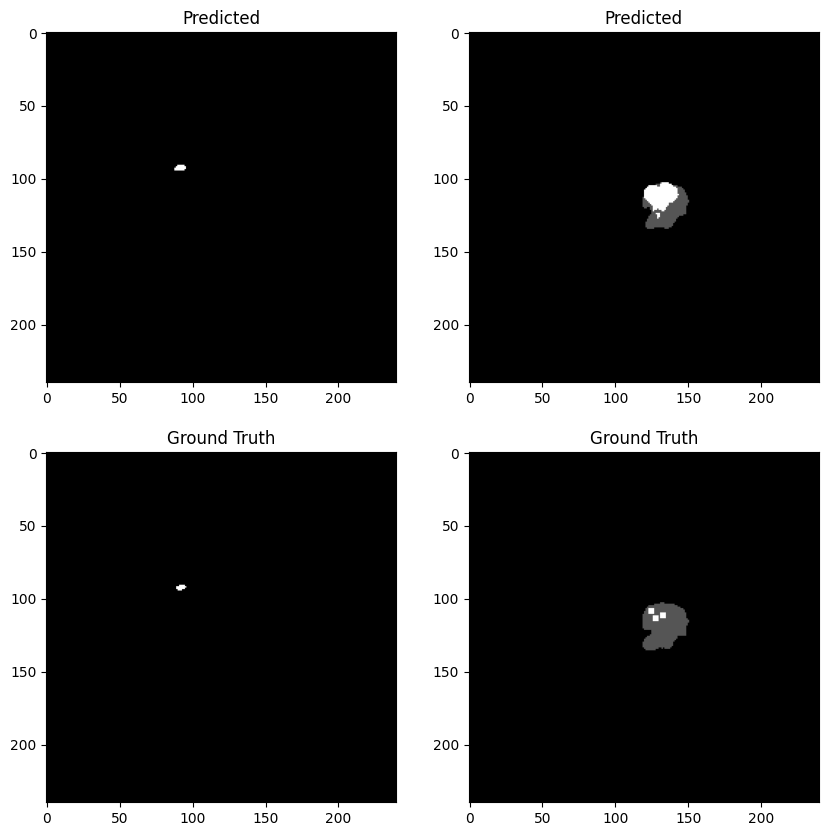

100%|██████████| 34/34 [02:21<00:00,  4.15s/it]


Average Validation Loss: 0.0070994279744541824

Average Validation DSC: [0.99939454 0.9063509  0.9436576  0.81548163]
Average Validation ASSD: [ 0.07947147 14.14266066 10.80512502 15.76557479]


In [11]:
model = train_model(num_epochs = 100)